# Emulators: First example

This example illustrates Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc.html) with emulator neural networks .

It follows on from [Sampling: First example](../sampling/first-example.ipynb)

Like in the sampling example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

Next, I create a model class using the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]

And a number of time points at which to sample the time series:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [5]:
org_values = model.simulate(true_parameters, times)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 5
values = org_values + np.random.normal(0, noise, org_values.shape)

Using matplotlib, I look at the noisy time series I just simulated:

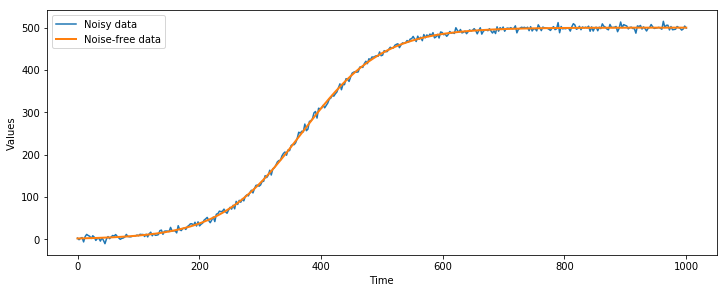

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [8]:
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
#log_likelihood = pints.GaussianLogLikelihood(problem)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [10]:
# Create bounds for our parameters and get prior
bounds = pints.RectangularBoundaries([0.01, 400], [0.02, 600])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [11]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions:

In [12]:
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

And this gives us everything we need to run an MCMC routine:

In [13]:
chains = pints.mcmc_sample(log_posterior, 3, xs)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
[-1.57677016e-03  4.51924727e+02]
-inf


[5.83173766e-03 5.23819153e+02]
-inf


[1.55832013e-02 5.80225950e+02]
-32908.375661197555
accepted


1     6      0         0         0.5        0:00.0
[-5.45693240e-03  4.49874428e+02]
-inf


[4.79471583e-02 5.26615497e+02]
-inf


[7.95798017e-03 5.79494494e+02]
-inf


2     9      0         0         0.333      0:00.0
[1.1557379e-02 4.5000277e+02]
-74147.55614014826


[3.18919603e-03 5.24023914e+02]
-inf


[1.74080693e-02 5.77542212e+02]
-58672.21413239878


3     12     0         0         0.25       0:00.0
[-3.85917420e-03  4.51097857e+02]
-inf


[3.91008312e-02 5.28341730e+02]
-inf


[-1.86913896e-02  5.83129795e+02]
-inf


[1.55472162e-02 4.50823651e+02]
-10054.831973063165
accepted


[1.56505306e-02 5.25967463e+02]
-6681.008172012373
accepted


[2.22873244e-02 4.50011438e+02]
-inf


[3.67615797e-02 5.23980377e+02]
-inf


[1.85977041e-02 5.71093919e+02]
-75559.933461882


[-2.26766226e-02  4.50590461e+02]
-inf


[7.40491868e-03 5.24626131e+02]
-inf


[2.34042002e-02 5.74104208e+02]
-inf


[1.33622060e-02 4.49969515e+02]
-26829.253934547844


[2.01336309e-02 5.26391318e+02]
-inf


[2.10802262e-02 5.73503765e+02]
-inf


[3.10903852e-02 4.53413179e+02]
-inf


[4.15093860e-03 5.23506403e+02]
-inf


[1.55701503e-02 5.74729453e+02]
-28965.743877970723


[1.70585671e-02 4.52649080e+02]
-13777.71143972045


[1.87201312e-02 5.22239267e+02]
-40740.58993896925


[3.70363002e-02 5.72983604e+02]
-inf


[1.57705191e-02 4.51394993e+02]
-9863.71999027876
accepted


[3.42928148e-02 5.23991011e+02]
-inf


[3.14587231e-02 5.70594726e+02]
-inf


[1.67531034e-02 4.49285312e+02]
-13161.34156840907


[1.11004607e-02 5.22112079e+02]
-66676.49224352415


[2.07448560e-02 5.72093834e+02]
-inf


[-9.44306286e-03  4.51705515e+02]
-inf


[2.02998306e-02 5.

[2.17904132e-02 4.62227946e+02]
-inf


[2.26768734e-04 5.21271524e+02]
-inf


[1.88920981e-02 5.70791866e+02]
-81227.72950092902


[1.74178656e-02 4.61952088e+02]
-14303.944011465275


[-8.61730670e-04  5.21683658e+02]
-inf


[1.04636154e-02 5.66676194e+02]
-92588.03338477135


[2.04326482e-02 4.57918372e+02]
-inf


[1.28122182e-02 5.14770512e+02]
-18066.10730953073


[1.77919947e-02 5.70914101e+02]
-59802.832631714045


[2.72413676e-02 4.62118548e+02]
-inf


[6.85595312e-03 5.14906764e+02]
-inf


[3.72360978e-02 5.71379025e+02]
-inf


[-7.88083038e-03  4.61538490e+02]
-inf


[-4.80404021e-03  5.21037856e+02]
-inf


[2.13022593e-02 5.73022395e+02]
-inf


[2.04187774e-04 4.61742301e+02]
-inf


[8.28465875e-03 5.17180691e+02]
-inf


[1.77867802e-02 5.69229275e+02]
-58222.7699469738


[2.62985934e-02 4.62945620e+02]
-inf


[1.60061079e-02 5.17770856e+02]
-6917.459465355245


[5.17615487e-03 5.71433388e+02]
-inf


[1.78834978e-02 4.60340669e+02]
-18209.19384164614


[2.01870158e-02 5.19326

[1.55197542e-02 4.66565523e+02]
-5257.590382158646


[1.47410627e-02 5.20320221e+02]
-2619.4467881594483


[1.40215217e-02 5.69960353e+02]
-17542.388133822453
accepted


[1.53881773e-02 4.67327505e+02]
-5061.538023416045


[1.47226387e-02 5.20315093e+02]
-2618.3587339038922


[1.40163093e-02 5.69997188e+02]
-17560.574648590788


[1.54715116e-02 4.67649935e+02]
-4985.788414996683
accepted


[1.46976483e-02 5.20300627e+02]
-2619.605779043224


[1.40136963e-02 5.69954414e+02]
-17542.25600854022
accepted


[1.54947189e-02 4.68840836e+02]
-4723.293579442794
accepted


[1.47135578e-02 5.20299315e+02]
-2616.8509973861082
accepted


[1.40019280e-02 5.69961132e+02]
-17550.05816687631


[1.54364843e-02 4.68944858e+02]
-4682.653510148089
accepted


[1.46998558e-02 5.20310157e+02]
-2620.4512552477986


[1.40354762e-02 5.69974056e+02]
-17545.33926443775


[1.53904596e-02 4.68629713e+02]
-4753.727552849783


[1.47101518e-02 5.20301227e+02]
-2617.519554112894


[1.40377065e-02 5.69915452e+02]
-17518.

[1.49188015e-02 5.01985757e+02]
-1213.454694350369


[1.45027842e-02 5.14993745e+02]
-2273.8563181396134


[1.52228492e-02 5.46352591e+02]
-11006.77317320842


[1.49487243e-02 5.00841820e+02]
-1198.1750743996674
accepted


[1.44970006e-02 5.15739992e+02]
-2345.5751193236047


[1.56776488e-02 5.37734313e+02]
-10661.12829269381
accepted


[1.49467200e-02 5.00025703e+02]
-1199.6692203074128
accepted


[1.44767442e-02 5.14167965e+02]
-2271.0449749150857
accepted


[1.53182553e-02 5.44601137e+02]
-10876.573261272608


[1.48522276e-02 5.07180271e+02]
-1377.8120176192576


[1.45638707e-02 5.16727913e+02]
-2316.0374504259735


[1.54258864e-02 5.42649971e+02]
-10790.762222637155


[1.5019250e-02 4.9536521e+02]
-1274.462189791174


[1.45028808e-02 5.14895758e+02]
-2266.1062961588154
accepted


[1.54043320e-02 5.43086755e+02]
-10821.609047637077


[1.50162771e-02 4.99073206e+02]
-1194.7818119276037
accepted


[1.45738061e-02 5.17179658e+02]
-2346.4839175829566


[1.55482944e-02 5.40320900e+02]
-1

[1.49965801e-02 5.00486009e+02]
-1191.942852799017
accepted


[1.48004670e-02 5.07708359e+02]
-1426.7747421519314


[1.56179119e-02 5.38186569e+02]
-10398.95430848795


[1.50058886e-02 5.00384881e+02]
-1192.0850831528037
accepted


[1.50116304e-02 4.98110363e+02]
-1205.1586829688652


[1.56966136e-02 5.36572144e+02]
-10370.793083688137
accepted


[1.50156648e-02 5.00832642e+02]
-1195.7861282109877


[1.51798186e-02 4.95393607e+02]
-1312.0134937637729


[1.55237268e-02 5.39878992e+02]
-10379.885783659018


[1.50270188e-02 4.99962222e+02]
-1193.68208552588
accepted


[1.49464217e-02 5.00268769e+02]
-1198.9000888362455


[1.56527416e-02 5.37587387e+02]
-10425.566124247394


[1.50040665e-02 4.99555549e+02]
-1192.153709220318
accepted


[1.50198439e-02 5.00716093e+02]
-1195.6797092232675
accepted


[1.55906142e-02 5.38752119e+02]
-10417.422729102978


[1.50038294e-02 4.99584381e+02]
-1192.0532165734664
accepted


[1.51444117e-02 4.98291209e+02]
-1248.697311388242


[1.57954742e-02 5.3468332

[1.49824343e-02 5.01632988e+02]
-1200.0475709239042


[1.50518626e-02 4.97677857e+02]
-1212.8706411589753


[1.61724328e-02 5.07850804e+02]
-6066.31463240594


[1.50081330e-02 5.00538509e+02]
-1192.9032324928903


[1.49631880e-02 5.01263576e+02]
-1197.4713788948252


[1.63126040e-02 5.01484956e+02]
-6101.480439926492


[1.50124085e-02 5.00457867e+02]
-1193.0167239406467
accepted


[1.50853252e-02 4.97009801e+02]
-1230.9524654623615


[1.65665489e-02 4.98229656e+02]
-7545.428502521093


[1.50175158e-02 5.00341260e+02]
-1193.2152027880602
accepted


[1.49372401e-02 5.00195052e+02]
-1202.2639095590189


[1.60951138e-02 5.19085608e+02]
-7888.076233740855


[1.50114239e-02 4.99464863e+02]
-1192.6014269396485
accepted


[1.50363395e-02 4.97993357e+02]
-1206.735895023625


[1.57746383e-02 5.31353919e+02]
-9123.263357076921


[1.50042842e-02 4.98653864e+02]
-1198.718999149498


[1.50984465e-02 4.96862194e+02]
-1237.8047682290498


[1.60768683e-02 5.14735241e+02]
-6725.285386814934


[1.5030698

[1.50029941e-02 4.99481006e+02]
-1192.460553364916


[1.50076928e-02 4.99371434e+02]
-1192.930779542604


[1.46660394e-02 5.01225083e+02]
-1521.3129558127218


[1.49859193e-02 5.01226102e+02]
-1196.0714162804256


[1.50089108e-02 5.00105429e+02]
-1191.671438389013


[1.42289928e-02 4.89765598e+02]
-4246.83915701711


[1.49902037e-02 4.99513295e+02]
-1193.0158036283817


[1.50170153e-02 5.00029867e+02]
-1192.335948615006


[1.43743602e-02 4.90559616e+02]
-3325.4107696647434


[1.49973886e-02 5.00104037e+02]
-1191.2565902719177
accepted


[1.50054838e-02 5.00490602e+02]
-1192.445228865179


[1.49841364e-02 5.04054547e+02]
-1252.2136673091277


[1.49769829e-02 5.00112598e+02]
-1192.5539528436075


[1.5001285e-02 4.9936264e+02]
-1193.0830520944828


[1.4470913e-02 4.9358458e+02]
-2552.829795792541


[1.49855165e-02 5.00329560e+02]
-1191.7533695173481


[1.49704801e-02 5.00253867e+02]
-1193.3354607905167


[1.49463195e-02 4.98167098e+02]
-1222.3287804546842


[1.49961373e-02 5.00763774e+02]

[1.50061943e-02 5.00067032e+02]
-1191.4650518269304
accepted


[1.49731952e-02 4.97754508e+02]
-1219.581541257036


[1.50597674e-02 4.97673125e+02]
-1214.22006034117


[1.49944305e-02 4.99311150e+02]
-1193.8034858768133


[1.48782450e-02 4.95688309e+02]
-1357.391924251641


[1.50162425e-02 4.99237981e+02]
-1193.8117619616442
accepted


[1.50305773e-02 5.00083411e+02]
-1194.625366341537


[1.49627152e-02 4.98082098e+02]
-1216.874570609059


[1.50069673e-02 4.99534657e+02]
-1192.2413741722448
accepted


[1.50181404e-02 4.99855773e+02]
-1192.347925497183
accepted


[1.50790428e-02 4.99734228e+02]
-1209.8799204996033


[1.49878130e-02 4.99459864e+02]
-1193.5537415621948


[1.50005159e-02 5.00144239e+02]
-1191.3157718706482
accepted


[1.50086391e-02 4.97588520e+02]
-1214.3737280061405


[1.49866645e-02 5.00977358e+02]
-1194.2129417552012


[1.5014399e-02 5.0013715e+02]
-1192.218864076522


[1.49349796e-02 4.98519410e+02]
-1221.4413566876547


[1.50939473e-02 4.97200986e+02]
-1230.546981668

[1.49702216e-02 4.99748170e+02]
-1194.785867905529


[1.50290102e-02 5.00058983e+02]
-1194.2472035861072


[1.49630577e-02 4.99701123e+02]
-1196.6476498219104


[1.50466882e-02 4.98942258e+02]
-1199.2359578000326


[1.50293879e-02 4.99466148e+02]
-1194.2233862197577


[1.50333868e-02 5.00324517e+02]
-1196.2141997245303


[1.49713006e-02 5.00409783e+02]
-1193.2081682610344
accepted


[1.49781817e-02 4.99883637e+02]
-1192.8984643703873
accepted


[1.49902030e-02 4.99301598e+02]
-1194.2804421941526


[1.50190511e-02 5.00483461e+02]
-1194.1013263530056
accepted


[1.50177670e-02 4.99941051e+02]
-1192.3342860694463
accepted


[1.50898609e-02 5.00209409e+02]
-1218.6393763608812


[1.49891328e-02 5.00132980e+02]
-1191.4637062579297
accepted


[1.49897167e-02 5.00228206e+02]
-1191.4634120324104
accepted


[1.50717272e-02 5.01159094e+02]
-1219.791343735353


[1.49877833e-02 4.98931492e+02]
-1197.7310743039936


[1.50169454e-02 5.00161087e+02]
-1192.5708293187874
accepted


[1.50606956e-02 5.009


[1.50431702e-02 5.00830138e+02]
-1202.9078826097484


[1.49400383e-02 5.00483280e+02]
-1200.516364374755


[1.49615176e-02 4.99403166e+02]
-1199.1728883591732


[1.50629969e-02 4.99685094e+02]
-1202.9391249074495


[1.49340839e-02 5.00724062e+02]
-1202.3880459857153


[1.49819380e-02 4.99906364e+02]
-1192.3599565625532
accepted


[1.50561153e-02 4.99839470e+02]
-1200.893807916837


[1.49763223e-02 5.00984105e+02]
-1194.5348952307743
accepted


[1.50145387e-02 5.00494136e+02]
-1193.4654151095303


[1.50357564e-02 4.99909675e+02]
-1195.3167724111295


[1.50508586e-02 5.00481643e+02]
-1202.5180163755397


[1.49620047e-02 5.00105065e+02]
-1195.1913923562995


[1.50505231e-02 5.00644305e+02]
-1203.7728117332813


[1.49570868e-02 5.01683393e+02]
-1201.7180260478115


[1.49513196e-02 4.99349029e+02]
-1202.9062662185204


[1.50785955e-02 5.01520914e+02]
-1229.908057089351


[1.49760162e-02 5.00507382e+02]
-1192.7624092127603
accepted


[1.49693517e-02 4.99932451e+02]
-1194.1944083098206


[1.

[1.49329840e-02 4.99410465e+02]
-1209.7723339248803


[1.50312089e-02 4.99960171e+02]
-1194.4561453907327


[1.50030642e-02 4.99655273e+02]
-1191.8318773772423


[1.50862338e-02 4.99251594e+02]
-1212.1582351973975


[1.49473640e-02 5.00755885e+02]
-1198.359826517253


[1.49686245e-02 4.99686964e+02]
-1195.4337705829887


[1.49504486e-02 5.00305046e+02]
-1197.635393445643


[1.49437798e-02 4.99291913e+02]
-1206.3466833549435


[1.49574407e-02 5.00198949e+02]
-1196.028168912799


[1.49459563e-02 5.00882158e+02]
-1198.9689425255976


[1.50252486e-02 4.99198089e+02]
-1194.66136358992


[1.49780443e-02 4.99592507e+02]
-1194.1644058596214


[1.50412375e-02 4.98612148e+02]
-1200.4648530073832


[1.50262147e-02 4.99086986e+02]
-1195.3331772797685


[1.49754170e-02 5.00419292e+02]
-1192.7000421254518
accepted


[1.49697615e-02 5.00393858e+02]
-1193.4222229804152


[1.50131673e-02 5.00107321e+02]
-1192.0372061781234
accepted


[1.49803055e-02 5.00539779e+02]
-1192.4620554206374
accepted


[1.500

[1.49999341e-02 5.00188810e+02]
-1191.349121529779
accepted


[1.49612624e-02 5.01169121e+02]
-1197.11164757244


[1.49924971e-02 5.00570289e+02]
-1192.1696178061406


[1.50132638e-02 4.99107757e+02]
-1194.4821536893676


[1.49369029e-02 5.01024231e+02]
-1201.8965786408075


[1.50099802e-02 4.99521477e+02]
-1192.351823919873
accepted


[1.50388559e-02 4.99142431e+02]
-1196.7919540480532


[1.49538014e-02 5.00485720e+02]
-1196.5650589910963


[1.50213481e-02 4.99492110e+02]
-1193.1743643614925


960   2883   0.26      0.275     0.236      0:03.8
[1.50272826e-02 4.99960128e+02]
-1193.724484005649


[1.49806334e-02 5.00679233e+02]
-1192.861675630967


[1.50022580e-02 4.99993515e+02]
-1191.3019624834612
accepted


[1.4998041e-02 4.9940852e+02]
-1192.9837242273927


[1.49617022e-02 5.01237534e+02]
-1197.481474724236


[1.49787042e-02 5.00205515e+02]
-1192.269530232692


[1.50587513e-02 4.99263065e+02]
-1201.3168388877389


[1.49937255e-02 4.99308314e+02]
-1193.8827996228479


[1.50094768e-0



[1.50005000e-02 4.99167968e+02]
-1194.3372992946377


[1.50305845e-02 4.99343377e+02]
-1194.729540637975


[1.50468758e-02 5.00013994e+02]
-1198.5106147466242


[1.49753895e-02 5.00561692e+02]
-1192.9346999816155


[1.50506148e-02 5.00202452e+02]
-1200.5697047939568


[1.50573810e-02 5.00908344e+02]
-1209.3325600712158


[1.50095501e-02 5.00899374e+02]
-1195.3381608902866
accepted


[1.50126285e-02 4.99818204e+02]
-1191.8662481798954
accepted


[1.50178138e-02 4.99759040e+02]
-1192.3541677480646


[1.50229499e-02 5.01436732e+02]
-1203.766841912212


[1.50361367e-02 5.00044372e+02]
-1195.7352822467317


[1.49975185e-02 4.98810686e+02]
-1197.675356425036


[1.50060630e-02 5.00651867e+02]
-1193.27309053538
accepted


[1.50325687e-02 4.99849486e+02]
-1194.5558025341359


[1.50089631e-02 4.99948785e+02]
-1191.5761981193475
accepted


[1.50082211e-02 5.00540565e+02]
-1192.9221036721108
accepted


[1.49629433e-02 5.01657735e+02]
-1200.8462340296442


[1.50336549e-02 5.00351331e+02]
-1196.41

[1.49520040e-02 5.00263544e+02]
-1197.2910671411078


[1.50234760e-02 5.01050121e+02]
-1199.3610693467383


[1.49526330e-02 5.00917127e+02]
-1197.4812937608863


[1.50191525e-02 4.98657137e+02]
-1198.2346142368315


[1.50214053e-02 4.98689732e+02]
-1197.980435825756


[1.49682341e-02 5.01125014e+02]
-1196.0141314175073


[1.50310378e-02 4.99584017e+02]
-1194.2799246536333


[1.49770293e-02 4.98629168e+02]
-1203.4635278643473


[1.50116367e-02 5.00535556e+02]
-1193.28769357095
accepted


[1.50178122e-02 5.00190895e+02]
-1192.7598296278322
accepted


[1.50232456e-02 4.96565024e+02]
-1235.852346329865


[1.50596304e-02 4.99283242e+02]
-1201.5653511332164


[1.50152130e-02 4.99944231e+02]
-1192.0662141010307
accepted


[1.49384329e-02 5.00171109e+02]
-1201.9183423633233


[1.50158110e-02 5.01003411e+02]
-1197.2582680751816


[1.50016395e-02 4.99893500e+02]
-1191.3557482999627
accepted


[1.49931240e-02 5.00993646e+02]
-1194.493051811844


[1.50172753e-02 5.01183125e+02]
-1199.3438145604616



[1.49732164e-02 5.00217344e+02]
-1192.9528846612461


[1.49826587e-02 5.02534206e+02]
-1213.7570105956659


[1.49988501e-02 4.99764348e+02]
-1191.5903075283745
accepted


[1.49850042e-02 4.99555036e+02]
-1193.3653489719002


[1.49832762e-02 4.99203994e+02]
-1195.9650808160068


[1.50310983e-02 4.99870023e+02]
-1194.2943291756333


[1.49904507e-02 5.00803298e+02]
-1193.209521635283


[1.49789163e-02 5.01556383e+02]
-1199.1341073913084


[1.49850451e-02 4.99719223e+02]
-1192.6170565063492


[1.49712619e-02 4.99820828e+02]
-1194.2565106680097


[1.49561594e-02 5.01380334e+02]
-1199.2581150208373


[1.49856736e-02 4.99338332e+02]
-1194.5904239050528


[1.49970216e-02 4.98879588e+02]
-1197.0399978831006


[1.49490435e-02 5.01310026e+02]
-1200.0644675790575


[1.50115489e-02 4.99465712e+02]
-1192.602623972734


[1.50064656e-02 4.99759200e+02]
-1191.634765387733
accepted


[1.49435696e-02 4.99243413e+02]
-1206.9632859487567


[1.50167853e-02 4.98650241e+02]
-1198.282466706102


[1.50307862e

[1.50167336e-02 5.00422742e+02]
-1193.443626713197


[1.49470677e-02 5.01272801e+02]
-1200.2662246575417


[1.49459243e-02 5.01114465e+02]
-1199.7467441725823


1280  3843   0.25605   0.273224  0.273224   0:05.1
[1.50201470e-02 4.99538913e+02]
-1192.9378739031483
accepted


[1.49774248e-02 4.99288785e+02]
-1196.3193720510126


[1.49443019e-02 5.00881530e+02]
-1199.4065446917448


[1.50181618e-02 4.99334443e+02]
-1193.4621718183841


[1.50379983e-02 4.99930251e+02]
-1195.8755633382711


[1.49994665e-02 5.00115771e+02]
-1191.2758719305723
accepted


[1.50090202e-02 4.99925379e+02]
-1191.581887563883
accepted


[1.49537045e-02 5.00513802e+02]
-1196.5859544204145


[1.49928118e-02 5.00178750e+02]
-1191.3398000064883
accepted


[1.50022056e-02 4.99377081e+02]
-1192.9751595547739


[1.50234755e-02 5.01295471e+02]
-1202.106209827132


[1.49939313e-02 5.00036930e+02]
-1191.3119669200448
accepted


[1.50316164e-02 4.98761746e+02]
-1198.0531052327979


[1.50182481e-02 4.99855529e+02]
-1192.35967

[1.49734074e-02 5.00655808e+02]
-1193.374242055171
accepted


[1.50347559e-02 4.99680654e+02]
-1194.8969228043413


[1.50389499e-02 5.00051948e+02]
-1196.448537274067


[1.49626459e-02 5.01087298e+02]
-1196.454045182083


[1.49960161e-02 5.00091131e+02]
-1191.2609736986285
accepted


[1.49902388e-02 4.99836719e+02]
-1191.7870270876185
accepted


[1.50096744e-02 5.00885532e+02]
-1195.2485533839376


[1.50190358e-02 5.00104643e+02]
-1192.7175348312846


[1.50200777e-02 5.00773343e+02]
-1196.1487854758816


[1.49581263e-02 4.98473358e+02]
-1211.7357982377


[1.49887425e-02 4.99682020e+02]
-1192.3933293611433
accepted


[1.50042801e-02 5.00203332e+02]
-1191.530755012824
accepted


[1.49566411e-02 5.01105866e+02]
-1197.4848277057374


[1.49181634e-02 5.00923950e+02]
-1208.670198443859


[1.50041058e-02 5.00264793e+02]
-1191.6398126986658
accepted


[1.49612047e-02 5.00623197e+02]
-1195.0720586022994


[1.50221242e-02 4.98976327e+02]
-1195.7041797411684


[1.50266503e-02 4.99830517e+02]
-119

[1.50289424e-02 5.00116192e+02]
-1194.3932843889513
accepted


[1.49867125e-02 4.99197925e+02]
-1195.4902202889814


[1.49708987e-02 5.01326251e+02]
-1197.230085354153


[1.50489428e-02 5.00141174e+02]
-1199.6979788089131


[1.49786963e-02 4.97943580e+02]
-1214.0665502529587


[1.49912078e-02 5.01209617e+02]
-1196.124838897563


[1.50467351e-02 5.00401540e+02]
-1200.4998226783246


[1.50716481e-02 4.98006900e+02]
-1212.8287811809191


[1.49893233e-02 5.00863356e+02]
-1193.532169631397


[1.50269315e-02 5.00152909e+02]
-1194.1190133790376
accepted


[1.50482838e-02 4.98439016e+02]
-1203.121203822428


[1.50085794e-02 4.99092655e+02]
-1194.5779865872278


[1.50400939e-02 5.00829091e+02]
-1201.8661842529661


[1.50494830e-02 4.99259552e+02]
-1198.7096868534209


[1.49805026e-02 4.98958554e+02]
-1198.7563282964816


[1.51125105e-02 5.00745586e+02]
-1240.2500743253486


1420  4263   0.257     0.272     0.284      0:05.7
[1.49565639e-02 4.99607710e+02]
-1199.030038363764


[1.50190098e-02 5.

[1.49971188e-02 4.99690482e+02]
-1191.8391223028689
accepted


[1.50632807e-02 4.99729694e+02]
-1203.1572983251851


[1.49825598e-02 4.98936446e+02]
-1198.5857409599212


[1.50385209e-02 4.99759768e+02]
-1195.728999425134


[1.49919849e-02 5.00717991e+02]
-1192.7949596097903
accepted


[1.50042431e-02 4.99897465e+02]
-1191.3970288987625
accepted


[1.49861103e-02 4.99322850e+02]
-1194.638662668348


[1.49950489e-02 4.99607031e+02]
-1192.2280984324448
accepted


[1.50284232e-02 5.00163527e+02]
-1194.441515099317


[1.49803223e-02 4.98949384e+02]
-1198.8887625124223


[1.49909122e-02 4.98660304e+02]
-1200.2265639507311


[1.49693678e-02 4.99846075e+02]
-1194.5168220381515


[1.50317407e-02 5.00595689e+02]
-1197.4665429550755


[1.50238181e-02 4.98543774e+02]
-1199.487170673044


[1.49963923e-02 4.99365001e+02]
-1193.325667056619


[1.50084052e-02 4.99742453e+02]
-1191.728784386991
accepted


[1.50170841e-02 4.99153010e+02]
-1194.3186273711308


[1.49717517e-02 4.99899586e+02]
-1193.86544

[1.50260692e-02 4.97896791e+02]
-1207.808332603159


[1.50182680e-02 5.01738424e+02]
-1206.8359868356695


[1.50259945e-02 5.00328414e+02]
-1194.6104192278372


[1.49776226e-02 5.00161174e+02]
-1192.4217309545004
accepted


[1.50946384e-02 4.99085131e+02]
-1216.2714590291573


[1.50204386e-02 4.98485136e+02]
-1200.033512575137


[1.49447347e-02 5.00437232e+02]
-1199.0863377107019


[1.49668677e-02 5.01390400e+02]
-1198.0560034009914


[1.50087096e-02 4.98612522e+02]
-1198.8854938509905


[1.49471974e-02 5.01801615e+02]
-1204.3614667123225


[1.50138380e-02 5.01029813e+02]
-1197.1369283410338


[1.49579418e-02 5.00197443e+02]
-1195.910081868691


[1.49520701e-02 5.00447494e+02]
-1197.0146843867428


[1.50424556e-02 4.98641591e+02]
-1200.4143232302988


[1.49409119e-02 5.01395880e+02]
-1202.4370047786829


[1.49723764e-02 5.01316320e+02]
-1197.0598865647544


[1.50460320e-02 4.99359222e+02]
-1197.656392720177


[1.49669733e-02 4.99831792e+02]
-1195.070558666355


[1.49497692e-02 5.003022


[1.49381190e-02 5.00489875e+02]
-1201.1531767323092


[1.49357347e-02 4.99223973e+02]
-1210.607041129871


[1.49973206e-02 5.01257600e+02]
-1197.0217890493245


[1.50150633e-02 4.99691046e+02]
-1192.196543835073
accepted


[1.49420352e-02 5.00739850e+02]
-1199.8289517379792


[1.50116313e-02 5.00609630e+02]
-1193.6799492957853


[1.50408940e-02 4.98407416e+02]
-1202.2826291157796


[1.49790395e-02 4.98967235e+02]
-1198.9653206477776


[1.49958481e-02 4.99908073e+02]
-1191.3869260170122
accepted


[1.50570262e-02 4.98699237e+02]
-1203.0119855910386


[1.50204918e-02 4.98985969e+02]
-1195.5461045997445
accepted


[1.49938142e-02 5.00007136e+02]
-1191.334998217136
accepted


[1.50031455e-02 5.00503720e+02]
-1192.3216363417416
accepted


[1.49652883e-02 4.99960540e+02]
-1194.91864256757
accepted


[1.49987987e-02 4.99498780e+02]
-1192.5037909332498
accepted


1640  4923   0.259     0.268     0.281      0:06.6
[1.49919285e-02 5.01638036e+02]
-1200.707861786716


[1.50139435e-02 4.99288188e

[1.50082636e-02 5.00260790e+02]
-1191.9131398440024
accepted


[1.50855716e-02 4.97124035e+02]
-1229.0495564468767


[1.50108139e-02 4.98686268e+02]
-1198.017231051478


[1.49897902e-02 5.01559740e+02]
-1199.5948708028218


[1.49693092e-02 5.01585197e+02]
-1199.6664604949472


[1.49601165e-02 5.00589268e+02]
-1195.2327910473718


[1.50050592e-02 5.00164899e+02]
-1191.511417073667
accepted


[1.49832308e-02 5.00394639e+02]
-1191.977670018671
accepted


[1.49871689e-02 4.98763666e+02]
-1199.6394059297752


[1.49991818e-02 4.99399919e+02]
-1192.97188614633


[1.49794510e-02 5.00652409e+02]
-1192.843208944193
accepted


[1.4975596e-02 4.9958028e+02]
-1194.6543935229508
accepted


[1.50076519e-02 4.99190491e+02]
-1193.9376896700453


[1.49955813e-02 5.03460008e+02]
-1237.6695797060306


[1.49852172e-02 4.99519091e+02]
-1193.53077802861
accepted


[1.50226795e-02 4.99132033e+02]
-1194.777004994896


[1.49729607e-02 5.03265578e+02]
-1228.3701323296575


[1.49629977e-02 4.98422268e+02]
-1210.7

[1.49836480e-02 4.99932076e+02]
-1192.1149153169458
accepted


[1.50087617e-02 4.99103652e+02]
-1194.4989605337294


[1.49346765e-02 5.00546685e+02]
-1202.2835866059095


[1.50293147e-02 4.99026835e+02]
-1195.9958126478552


[1.49675760e-02 5.00345335e+02]
-1193.7649354514454


[1.49566254e-02 5.00309973e+02]
-1196.0237086118134


[1.50008570e-02 4.99756655e+02]
-1191.5815310025694
accepted


[1.50071260e-02 4.98154424e+02]
-1204.9021444967238


[1.49720247e-02 5.02014628e+02]
-1204.6998140235644


[1.50086540e-02 4.98520066e+02]
-1199.9347573516848


[1.50119524e-02 5.01071354e+02]
-1197.1930454962248


[1.50307248e-02 4.98339758e+02]
-1202.0279475995048


[1.50257004e-02 4.99105280e+02]
-1195.182781717725


[1.49818265e-02 5.01838211e+02]
-1202.5530049212987


[1.49943688e-02 4.99855738e+02]
-1191.5244262724661
accepted


[1.49359992e-02 5.01308136e+02]
-1203.2691992058778


[1.49688103e-02 5.00284252e+02]
-1193.584220383342


[1.49863825e-02 4.99820656e+02]
-1192.138212283825
accept

[1.49330112e-02 5.01891535e+02]
-1208.315465340152


[1.49874965e-02 4.99769930e+02]
-1192.1929080346392
accepted


[1.49997527e-02 5.01519970e+02]
-1200.1507211243097


1880  5643   0.255     0.261563  0.283      0:07.5
[1.49535958e-02 5.01583727e+02]
-1201.2767682862805


[1.49829029e-02 4.99589587e+02]
-1193.457336795475


[1.50075519e-02 5.00305566e+02]
-1191.9738472978559
accepted


[1.49651177e-02 5.00945307e+02]
-1195.4167174159084


[1.49953887e-02 5.01001794e+02]
-1194.6760245770654


[1.49603491e-02 5.01260347e+02]
-1197.8134692054355


[1.5015317e-02 5.0052435e+02]
-1193.7296035515312
accepted


[1.50349088e-02 4.98193523e+02]
-1204.037905842896


[1.50489672e-02 4.99822768e+02]
-1198.5658193879865


[1.49818562e-02 5.01110217e+02]
-1195.1471665861118


[1.50168231e-02 4.98422526e+02]
-1200.7622582418614


[1.49865856e-02 4.99452774e+02]
-1193.739328339867


[1.49971353e-02 4.99718148e+02]
-1191.7560817880915
accepted


[1.50463038e-02 4.99374860e+02]
-1197.6958467806405


[

[1.50142753e-02 5.00441466e+02]
-1193.1830246607553


[1.50165388e-02 5.01405824e+02]
-1201.772188626105


[1.50088141e-02 5.02611759e+02]
-1220.4395979082028


[1.50196602e-02 5.00083239e+02]
-1192.7588138555066


[1.49769123e-02 5.00457496e+02]
-1192.5903344735812


[1.49788972e-02 5.02213206e+02]
-1207.8505140265224


[1.49964149e-02 4.99659494e+02]
-1191.967669004205
accepted


[1.49781454e-02 5.00322363e+02]
-1192.3325546365363


[1.50257588e-02 5.00027373e+02]
-1193.5841162620818


[1.49389764e-02 5.00406544e+02]
-1201.0064472368078


[1.49902472e-02 4.99952873e+02]
-1191.554557658283
accepted


[1.49859500e-02 5.02248236e+02]
-1209.010171145609


[1.49937780e-02 5.00756208e+02]
-1193.0326812922576


[1.50143397e-02 4.98235263e+02]
-1203.2201685648556


[1.49906076e-02 5.00619576e+02]
-1192.3502787308869
accepted


[1.50069498e-02 4.98593803e+02]
-1199.1964771490577


[1.50000897e-02 5.00091928e+02]
-1191.2732249753935
accepted


[1.50605204e-02 5.01118342e+02]
-1213.465990462370

[1.50424261e-02 4.99536642e+02]
-1196.5941566254155


[1.50096515e-02 5.00460531e+02]
-1192.712563586105
accepted


[1.49746082e-02 5.01316058e+02]
-1196.947032548893


[1.49852011e-02 4.99405475e+02]
-1194.2075734558014
accepted


[1.50150922e-02 5.00321831e+02]
-1192.8113748136357
accepted


[1.49426791e-02 4.99925553e+02]
-1201.566963535989


[1.49724184e-02 4.98589154e+02]
-1205.2390670199748


[1.49792055e-02 4.99828039e+02]
-1192.9389249860885
accepted


[1.49363644e-02 5.01387436e+02]
-1203.5892411932343


[1.49651208e-02 4.98270649e+02]
-1212.5608691628113


[1.49793272e-02 4.98931607e+02]
-1199.2831897067008


[1.50396080e-02 5.00780451e+02]
-1201.2452048550979


[1.49948219e-02 4.99452188e+02]
-1192.9526190242018
accepted


[1.50138413e-02 4.98869418e+02]
-1196.266496602501


[1.49866286e-02 4.99607551e+02]
-1192.918743167424
accepted


[1.50049568e-02 4.98407309e+02]
-1201.6058579203745


[1.50213066e-02 4.98824051e+02]
-1196.8060368046165


[1.50331800e-02 4.98676551e+02]
-

[1.49538982e-02 4.99038809e+02]
-1205.3382586803243


[1.49353606e-02 5.00599434e+02]
-1201.9851843647502


[1.50226124e-02 5.00761209e+02]
-1196.5732591297008


[1.49825178e-02 5.00729335e+02]
-1192.9626802252442


[1.49732187e-02 4.99691914e+02]
-1194.4854824007277


[1.49775151e-02 5.00515672e+02]
-1192.6345638904093
accepted


[1.49638657e-02 5.00957166e+02]
-1195.6410490437918


[1.49497369e-02 5.00703121e+02]
-1197.6807347552863


[1.49925512e-02 4.99996036e+02]
-1191.388986696773
accepted


[1.49911723e-02 5.01167727e+02]
-1195.7616418094362


[1.50214564e-02 4.99853986e+02]
-1192.7421979246958
accepted


[1.50225434e-02 4.99469397e+02]
-1193.3580657092905
accepted


[1.49689364e-02 4.99556369e+02]
-1196.1482160762487


[1.49509839e-02 4.98931235e+02]
-1207.7801520258088


[1.50406377e-02 4.98040627e+02]
-1206.4623069607858


[1.50563438e-02 5.00338713e+02]
-1203.502855136379


[1.50052379e-02 4.99989084e+02]
-1191.392539145619
accepted


[1.50228964e-02 4.99034648e+02]
-1195.37

[1.49944063e-02 5.00791766e+02]
-1193.2497208629832
accepted


[1.50538446e-02 5.00112636e+02]
-1201.20808280515


[1.49796083e-02 5.01202183e+02]
-1195.875045574072


[1.50021113e-02 5.00895358e+02]
-1194.4267078407854


[1.50114186e-02 4.99816866e+02]
-1191.7856887383894
accepted


[1.49441703e-02 5.01100748e+02]
-1200.1236236568213


[1.49658595e-02 5.00748863e+02]
-1194.585190581652
accepted


[1.50036007e-02 4.98780232e+02]
-1197.4458248576564


[1.50047874e-02 4.98822192e+02]
-1196.9586645244353


[1.50131248e-02 5.01249681e+02]
-1199.2215499800186


[1.50307615e-02 4.99579924e+02]
-1194.2391183534546
accepted


[1.49758359e-02 4.99814631e+02]
-1193.4874000867533


[1.49886258e-02 4.99659734e+02]
-1192.4919470256395
accepted


[1.49837365e-02 4.99941577e+02]
-1192.0852059971442
accepted


[1.49626038e-02 5.01155164e+02]
-1196.8465394685072


[1.50176092e-02 4.99174651e+02]
-1194.2192688932123


[1.50094295e-02 4.99905372e+02]
-1191.610849665684
accepted


[1.50124576e-02 5.006958

[1.5042445e-02 4.9974029e+02]
-1196.6455669681152


[1.49982176e-02 4.99819046e+02]
-1191.484533632392
accepted


[1.50321295e-02 4.99818271e+02]
-1194.4391588169274


[1.50544249e-02 4.99515174e+02]
-1199.8244008315257


[1.50084850e-02 5.00869574e+02]
-1194.9644711384694


[1.49560847e-02 5.00295988e+02]
-1196.175278682078


[1.50076542e-02 5.00952733e+02]
-1195.4996295507065


2220  6663   0.258     0.253     0.276452   0:08.8
[1.50480692e-02 4.99750780e+02]
-1198.1642921551781


[1.49646331e-02 5.00127529e+02]
-1194.5759564080554


[1.49997733e-02 4.99739721e+02]
-1191.633742079221
accepted


[1.50454739e-02 4.99850850e+02]
-1197.625645797159


[1.50058329e-02 4.99724613e+02]
-1191.6858811963552
accepted


[1.50286328e-02 4.99917556e+02]
-1193.8996655758435


[1.50307850e-02 5.00253234e+02]
-1195.2784926239915


[1.50417989e-02 4.99926974e+02]
-1196.8164832909963


[1.50359152e-02 4.99788088e+02]
-1195.1807449924818


[1.49296510e-02 5.00396802e+02]
-1204.5191646298724


[1.4968840

[1.49719599e-02 4.98920939e+02]
-1201.124530310718


[1.49290567e-02 5.01314317e+02]
-1205.4508235880535


[1.49825346e-02 4.99876334e+02]
-1192.3733548365715


[1.49812051e-02 5.01205661e+02]
-1195.8777876659472


[1.50194495e-02 4.99466443e+02]
-1193.0746769416162


[1.49986566e-02 5.00499577e+02]
-1192.0598010513743
accepted


[1.50275171e-02 4.98960552e+02]
-1196.2246348271124


[1.49872775e-02 5.00205825e+02]
-1191.5660441963585
accepted


[1.49845204e-02 5.00318532e+02]
-1191.800843581046
accepted


[1.49844126e-02 5.02184480e+02]
-1207.8059202113595


[1.50373753e-02 4.99472930e+02]
-1195.5788854177881


[1.49645472e-02 5.00353404e+02]
-1194.2981447818786


[1.49537205e-02 5.01406415e+02]
-1199.8393671367958


[1.49734849e-02 5.01487029e+02]
-1198.5179680376518


[1.49943303e-02 5.01159688e+02]
-1195.8786257199288


[1.49633701e-02 5.00250598e+02]
-1194.6145162836926


[1.5065403e-02 4.9983944e+02]
-1204.3367038038318


[1.49679360e-02 5.00285747e+02]
-1193.7297863095982


[1.49

[1.50172866e-02 5.02281291e+02]
-1216.0791296048687


[1.50005466e-02 4.99910738e+02]
-1191.3309601903045
accepted


[1.50600850e-02 4.99029348e+02]
-1202.2828108360366


[1.49898837e-02 4.99564423e+02]
-1192.7942317834231
accepted


[1.49954337e-02 4.99233295e+02]
-1194.239475851775


[1.49889270e-02 5.00396768e+02]
-1191.7142489826003
accepted


[1.50100753e-02 5.00111643e+02]
-1191.7680759216307
accepted


[1.50201011e-02 4.99431475e+02]
-1193.241876768558
accepted


[1.50002968e-02 5.00143122e+02]
-1191.3099750177637
accepted


[1.50634456e-02 5.00006370e+02]
-1204.2846596182176


[1.49781908e-02 5.00217578e+02]
-1192.3213476796839
accepted


[1.50360239e-02 5.00381798e+02]
-1197.1918127954434


2400  7203   0.255     0.252     0.271137   0:09.6
[1.49675006e-02 5.00926342e+02]
-1195.029723830144


[1.49772700e-02 4.99680537e+02]
-1193.8377101883245


[1.50272814e-02 4.97956095e+02]
-1206.9182517584393


[1.50135143e-02 5.00440165e+02]
-1193.0777148476793


[1.49377782e-02 4.9910760

[1.50621618e-02 4.97824676e+02]
-1212.6206288732167


[1.50476584e-02 4.99511101e+02]
-1197.9035314226442


[1.50087257e-02 4.98791820e+02]
-1197.0554899594215


[1.50359548e-02 4.99501992e+02]
-1195.2614891031958


[1.49943755e-02 5.00351490e+02]
-1191.547741131189


[1.50055192e-02 5.00935502e+02]
-1195.0918572624817


[1.49818157e-02 5.01209698e+02]
-1195.9050231590566


[1.49977001e-02 4.99103448e+02]
-1195.0128834165737


[1.50129101e-02 5.00579640e+02]
-1193.6845873702346
accepted


[1.49953658e-02 4.99134584e+02]
-1194.9727673678206


[1.49748548e-02 5.00089883e+02]
-1192.8757345988126


[1.49982636e-02 4.99524544e+02]
-1192.411983392326
accepted


[1.50095096e-02 5.00371435e+02]
-1192.3545159965527
accepted


[1.49912114e-02 4.99654582e+02]
-1192.2953387832047


[1.50319808e-02 4.99452443e+02]
-1194.6523575757308


2500  7503   0.254     0.253     0.269892   0:10.0
[1.50369910e-02 5.00467966e+02]
-1197.9841462010313


[1.50374710e-02 4.99371501e+02]
-1195.7953410420457


[1.501

[1.50119834e-02 4.99065246e+02]
-1194.7549196200453


[1.49750182e-02 4.99103656e+02]
-1198.4579123465944


[1.49617695e-02 4.98949301e+02]
-1203.731165668823


[1.49583680e-02 5.00603272e+02]
-1195.5977039424627


[1.49562838e-02 5.00811008e+02]
-1196.4124924868554


[1.49367791e-02 5.00465089e+02]
-1201.6594366222025


2560  7683   0.253     0.252     0.27       0:10.2
[1.49446695e-02 4.98451374e+02]
-1217.8272562788545


[1.49654873e-02 4.99528955e+02]
-1197.1486165424494


[1.49700340e-02 5.00615509e+02]
-1193.669271463356


[1.49747646e-02 4.98818098e+02]
-1201.6230726680692


[1.50330710e-02 4.99734988e+02]
-1194.5744576305096
accepted


[1.50130633e-02 5.00014772e+02]
-1191.9114016595804
accepted


[1.50104705e-02 5.00252188e+02]
-1192.084002856847
accepted


[1.50468290e-02 4.99091971e+02]
-1198.5936294548221


[1.50108270e-02 4.99285291e+02]
-1193.3962969383476


[1.50062532e-02 5.01779346e+02]
-1204.6818107939014


[1.50484751e-02 4.99378150e+02]
-1198.23401855817


[1.500283

[1.49483923e-02 5.00003356e+02]
-1199.2328165393849


[1.49786588e-02 4.99432854e+02]
-1195.0337179325131
accepted


[1.49773332e-02 4.99575589e+02]
-1194.3771949111313
accepted


[1.50153651e-02 4.99470587e+02]
-1192.7666579948498
accepted


[1.49318927e-02 4.97474283e+02]
-1246.3411729469265


[1.49426458e-02 4.97993297e+02]
-1227.7362373132298


[1.50630394e-02 4.97542689e+02]
-1216.7775219580822


[1.49865484e-02 5.00769685e+02]
-1193.0342828352323
accepted


[1.49804148e-02 4.98753615e+02]
-1201.084549051888


[1.50464116e-02 4.96786084e+02]
-1229.2708228719796


[1.49881733e-02 5.02056069e+02]
-1206.1453106560978


[1.49933208e-02 5.00445564e+02]
-1191.7720938998334
accepted


[1.50202273e-02 4.97382199e+02]
-1217.165302783745


[1.49671331e-02 5.00451914e+02]
-1193.8604341866262


[1.50026604e-02 5.02602064e+02]
-1218.6268394296828


[1.51349275e-02 4.98684509e+02]
-1241.2480931006135


[1.50714785e-02 5.00874276e+02]
-1215.6906099821051


[1.49894637e-02 4.99049068e+02]
-1196.3

[1.50000445e-02 4.99283712e+02]
-1193.5955179855819
accepted


[1.49720725e-02 5.00835452e+02]
-1194.1359962954275
accepted


[1.49916005e-02 4.98820886e+02]
-1198.3040070652733


[1.50421856e-02 4.98789129e+02]
-1199.2887637679519


[1.49225051e-02 5.01745155e+02]
-1210.2106490802237


[1.50390201e-02 5.00176339e+02]
-1196.9434964807228


[1.49642617e-02 4.98592176e+02]
-1207.7033229958406


[1.49969256e-02 5.01242355e+02]
-1196.8382174988524


[1.50497495e-02 4.98909553e+02]
-1200.0708262536373


[1.50474682e-02 4.99927385e+02]
-1198.3979363970234


[1.49595157e-02 5.01807693e+02]
-1202.7461010470522


[1.49908262e-02 5.02467011e+02]
-1213.5693110817572


[1.49838856e-02 4.97724482e+02]
-1216.8525772421624


[1.49835796e-02 5.00003063e+02]
-1191.9830208244523
accepted


[1.50221090e-02 4.99791066e+02]
-1192.8246366333758


2660  7983   0.251785  0.253664  0.267      0:10.6
[1.49572500e-02 4.98175535e+02]
-1217.2864037578913


[1.50927362e-02 5.00938500e+02]
-1229.1291795021061


[1.4


[1.49544104e-02 5.01180281e+02]
-1198.2745565055734


[1.49698707e-02 5.00886720e+02]
-1194.5828670075696


[1.50338110e-02 4.99424406e+02]
-1195.0172247772618


[1.49815397e-02 5.02763051e+02]
-1218.1483307476778


[1.50172958e-02 4.99767039e+02]
-1192.2972118935384


[1.49731419e-02 4.98201762e+02]
-1211.0901162105777


[1.49890853e-02 4.99746354e+02]
-1192.1337475117432
accepted


[1.49928209e-02 5.01267584e+02]
-1196.749978005876


[1.49869126e-02 5.00402475e+02]
-1191.795757650765
accepted


[1.50089998e-02 4.98854387e+02]
-1196.4702765843258


[1.50188973e-02 4.99540495e+02]
-1192.820024644474


[1.50148911e-02 4.99881331e+02]
-1192.023084956741
accepted


[1.49205616e-02 5.00889846e+02]
-1207.6317572158553


[1.50348587e-02 4.98363771e+02]
-1202.0739249013943


[1.50149369e-02 4.99873114e+02]
-1192.0280338087082
accepted


[1.49792731e-02 5.00523668e+02]
-1192.502148246955
accepted


[1.49801670e-02 4.98372973e+02]
-1206.346547423803


[1.49948777e-02 4.98852644e+02]
-1197.5459

[1.49675340e-02 5.01191029e+02]
-1196.507792687411


[1.49800030e-02 5.00066113e+02]
-1192.2559512082312
accepted


[1.50570519e-02 4.98110834e+02]
-1208.1108693703948


[1.49797498e-02 5.01491917e+02]
-1198.4693129380548


[1.49509989e-02 5.01420555e+02]
-1200.4184075583441


[1.50455607e-02 4.99469782e+02]
-1197.3953715812543


[1.49530527e-02 5.00644946e+02]
-1196.8098928060174


[1.50521544e-02 5.00258835e+02]
-1201.4295554943506


[1.50296256e-02 4.99643356e+02]
-1193.9899971801349


[1.50016395e-02 4.99934539e+02]
-1191.3189328458825
accepted


[1.49868665e-02 5.00587390e+02]
-1192.281143570499
accepted


[1.50020177e-02 4.99863283e+02]
-1191.3945374814364
accepted


[1.49902327e-02 5.01541875e+02]
-1199.4225000358247


[1.49826766e-02 4.99104563e+02]
-1196.9248040991174


[1.49593252e-02 4.98055688e+02]
-1218.7275817768489


[1.49646289e-02 5.00215069e+02]
-1194.413647592531


[1.50316052e-02 5.01067459e+02]
-1201.7160759220853


[1.50007053e-02 5.00269478e+02]
-1191.49728600341



[1.49725568e-02 5.00516526e+02]
-1193.163592491855


[1.50092260e-02 5.00975497e+02]
-1195.9076455836662


[1.50465165e-02 4.97833161e+02]
-1209.917629723885


[1.50311931e-02 4.99822191e+02]
-1194.2647607145102


2840  8523   0.246     0.252     0.269      0:11.3
[1.50234542e-02 4.99057142e+02]
-1195.2717557261024


[1.49578442e-02 4.99625684e+02]
-1198.5287219931442


[1.49834108e-02 5.00139411e+02]
-1191.8458739979378
accepted


[1.50481787e-02 4.99540092e+02]
-1198.0348596091926


[1.50054247e-02 4.99100842e+02]
-1194.5933156752565


[1.49382275e-02 4.99769016e+02]
-1204.279005221845


[1.49995285e-02 5.00551963e+02]
-1192.3027652448106
accepted


[1.49522117e-02 5.00013815e+02]
-1198.0228071030326


[1.50193950e-02 4.99173342e+02]
-1194.3240763312388


[1.49514495e-02 5.01236346e+02]
-1199.1473135509502


[1.50149054e-02 4.99034078e+02]
-1195.0100791913453


[1.49930841e-02 5.00913333e+02]
-1193.9395743408256


[1.50481918e-02 5.00491211e+02]
-1201.6444920830936


[1.50245149e-0

[1.50099889e-02 5.00740380e+02]
-1194.2585769477155


[1.49772431e-02 5.00828432e+02]
-1193.6786661480655


[1.50382852e-02 5.00518965e+02]
-1198.6977003656968


[1.50207660e-02 4.99458433e+02]
-1193.215563672083
accepted


[1.50347936e-02 4.99170651e+02]
-1195.996771238616


[1.50496974e-02 4.99814687e+02]
-1198.7655347679713


[1.50556573e-02 4.98927788e+02]
-1201.4306755884202


[1.49756657e-02 5.01222179e+02]
-1196.155534044961


[1.50089468e-02 4.99795407e+02]
-1191.6725071490316
accepted


[1.49971146e-02 4.98598714e+02]
-1200.079254504041


[1.49812658e-02 4.99865824e+02]
-1192.5515656075545
accepted


[1.50008377e-02 4.98303507e+02]
-1203.4611935924966


[1.50041555e-02 4.98640461e+02]
-1198.8767266790464


[1.50243427e-02 5.00443515e+02]
-1194.8507132435352
accepted


[1.50311662e-02 4.98592129e+02]
-1199.4599318911123


[1.49802691e-02 4.99739385e+02]
-1193.1270696179643
accepted


[1.50600581e-02 4.99535875e+02]
-1201.6554431159889


[1.49943153e-02 5.00517143e+02]
-1192.001

[1.49724286e-02 5.00101217e+02]
-1193.2200390758153
accepted


[1.50186624e-02 4.98999976e+02]
-1195.3641472889321


[1.50127006e-02 5.00197153e+02]
-1192.1682026591864
accepted


[1.50094255e-02 4.99514656e+02]
-1192.3597498339943
accepted


[1.50164957e-02 5.00698665e+02]
-1194.9572604880798


[1.50270698e-02 5.01764432e+02]
-1209.8418940813253


[1.50279866e-02 4.99305026e+02]
-1194.5129668804832


[1.50353438e-02 4.99485882e+02]
-1195.1713935296475
accepted


[1.49953468e-02 4.99821654e+02]
-1191.5579319293415
accepted


[1.49968305e-02 4.98406538e+02]
-1202.576748759116


[1.50899551e-02 5.01493692e+02]
-1236.8162159698427


[1.49873388e-02 5.00114982e+02]
-1191.569252451802
accepted


[1.50351990e-02 4.97746602e+02]
-1210.321197342067


[1.50457898e-02 4.99573191e+02]
-1197.4056197969878


[1.49963939e-02 4.99014108e+02]
-1195.8659941865603


[1.50215943e-02 4.97217708e+02]
-1220.448168657639


[1.50122289e-02 4.99429334e+02]
-1192.7674285555952
accepted


[1.49777812e-02 5.00281

[1.50225956e-02 4.99477328e+02]
-1193.3416140733095


[1.49725426e-02 5.00653344e+02]
-1193.4607417154984


[1.49611898e-02 5.00972399e+02]
-1196.1047205168384


[1.50050796e-02 5.00553522e+02]
-1192.6859577353257
accepted


[1.49680608e-02 5.00465102e+02]
-1193.7232732675884


[1.49808130e-02 5.00856843e+02]
-1193.6217130913865


[1.50124023e-02 5.00324953e+02]
-1192.4989023734795
accepted


[1.50466150e-02 5.00344153e+02]
-1200.082421266147


[1.49768388e-02 4.98647187e+02]
-1203.2707299942724


[1.50257614e-02 4.99669613e+02]
-1193.38222284108
accepted


[1.49736837e-02 5.00749870e+02]
-1193.6477550269246


[1.50068464e-02 5.00695886e+02]
-1193.6053410672182


[1.50388301e-02 4.99758366e+02]
-1195.7982264779728


[1.49826910e-02 5.00310719e+02]
-1191.9205162293345
accepted


[1.50084409e-02 4.98952279e+02]
-1195.6482914560033


[1.50151028e-02 4.98525847e+02]
-1199.609632110128


[1.50475824e-02 5.00029073e+02]
-1198.7811026363763


[1.50288426e-02 4.98494465e+02]
-1200.240080460390



[1.49862527e-02 4.99553954e+02]
-1193.2219389861737


[1.49292331e-02 5.00144268e+02]
-1205.6949120856123


[1.49793100e-02 5.00788571e+02]
-1193.3735520232017


[1.49867692e-02 5.00107085e+02]
-1191.6098475508518
accepted


[1.50305569e-02 4.98942214e+02]
-1196.6526607327646


[1.50101309e-02 4.99722144e+02]
-1191.8389606781484
accepted


[1.49675473e-02 4.99825802e+02]
-1194.975242007574


[1.50041018e-02 5.00040616e+02]
-1191.3584934517903
accepted


[1.49995895e-02 5.01208040e+02]
-1196.7740074093529


[1.49497419e-02 5.00381196e+02]
-1197.7051100701326


[1.50122688e-02 4.99546303e+02]
-1192.3599858956065


[1.50097918e-02 5.00045389e+02]
-1191.6714994477659
accepted


[1.49946963e-02 5.00008724e+02]
-1191.3093508436816
accepted


[1.49953125e-02 4.99750675e+02]
-1191.7340255825782
accepted


[1.50060692e-02 5.00149958e+02]
-1191.546217487373
accepted


[1.50350440e-02 4.99051706e+02]
-1196.593931168015


[1.50081630e-02 4.99194775e+02]
-1193.9058457042981


[1.50248363e-02 5.00

[1.50119291e-02 5.01946658e+02]
-1208.5405032282806


[1.50477365e-02 4.99712894e+02]
-1198.0154178210828


[1.49710692e-02 5.01398281e+02]
-1197.821547090372


[1.50279258e-02 5.00409484e+02]
-1195.4069408527669


[1.50433314e-02 4.99352264e+02]
-1197.0438136731457


[1.49453761e-02 5.02032820e+02]
-1207.1738337569711


[1.50586141e-02 4.98968440e+02]
-1202.0720582039598


[1.50110186e-02 4.99235500e+02]
-1193.6711278815417


[1.50284054e-02 4.99697520e+02]
-1193.7600995194093


[1.50244584e-02 5.00315401e+02]
-1194.259278497214
accepted


[1.50197066e-02 4.99721791e+02]
-1192.582601138187
accepted


[1.50048550e-02 5.00068699e+02]
-1191.4023025255306
accepted


[1.50254009e-02 5.00149707e+02]
-1193.828940279882
accepted


[1.50335731e-02 4.99941334e+02]
-1194.9041410159823


[1.49920221e-02 5.00243382e+02]
-1191.4067192095267
accepted


[1.50654626e-02 4.99227069e+02]
-1203.5788554657995


[1.50126210e-02 4.99734439e+02]
-1191.958842540374
accepted


[1.50434504e-02 5.00087376e+02]
-

[1.49243324e-02 5.00009918e+02]
-1208.6688833670726


[1.50311439e-02 5.01787547e+02]
-1211.5971234767278


[1.48961410e-02 5.02191895e+02]
-1224.50140494301


[1.50204840e-02 4.99845163e+02]
-1192.6183001281966
accepted


[1.49710080e-02 4.99762432e+02]
-1194.5629365061939


[1.50223639e-02 4.99929270e+02]
-1192.9099135519198
accepted


[1.50526295e-02 5.00242058e+02]
-1201.4957873089463


[1.50232834e-02 5.00503278e+02]
-1194.9730544251


[1.50452396e-02 4.98728304e+02]
-1200.2448670876777


[1.50643813e-02 4.99687817e+02]
-1203.466137624881


[1.49922690e-02 5.00726911e+02]
-1192.8438850852663


[1.50214478e-02 4.99806696e+02]
-1192.7382583318304
accepted


[1.50200972e-02 5.00265978e+02]
-1193.3234896106148
accepted


[1.49876535e-02 5.01202055e+02]
-1195.9121652488004


[1.49988457e-02 5.01117153e+02]
-1195.8746309242265


[1.50216928e-02 5.01672897e+02]
-1206.7758616749243


[1.49907207e-02 5.01366313e+02]
-1197.5722479580247


[1.50179656e-02 4.99280161e+02]
-1193.6936186118671


[1.49892246e-02 5.00332977e+02]
-1191.5942630115935
accepted


[1.49989785e-02 5.00929807e+02]
-1194.4015206684487
accepted


[1.49997428e-02 5.03280585e+02]
-1233.9782224715555


3280  9843   0.245352  0.245     0.27       0:13.0
[1.50049138e-02 5.00660081e+02]
-1193.2074140108218


[1.49957799e-02 5.00891627e+02]
-1193.9254278001165
accepted


[1.49439159e-02 5.03795190e+02]
-1240.398141281805


[1.49890865e-02 5.00465148e+02]
-1191.8654492324115
accepted


[1.50164451e-02 5.01262511e+02]
-1200.0426738252997


[1.50296282e-02 4.99049036e+02]
-1195.9030924358885


[1.49740644e-02 5.02054313e+02]
-1205.2707341825549


[1.49784896e-02 4.99996037e+02]
-1192.5635022811814
accepted


[1.50275056e-02 5.00568446e+02]
-1196.261412318869


[1.49879949e-02 5.01532520e+02]
-1199.1666007272509


[1.49909394e-02 4.99032744e+02]
-1196.3164596934064


[1.50578789e-02 4.98914734e+02]
-1202.0891082773715


[1.50199245e-02 5.00344500e+02]
-1193.5961033990645


[1.50367129e-02 5.00311100e+02]
-1196.9828

[1.50228769e-02 4.99880731e+02]
-1192.9448539706827
accepted


[1.49946801e-02 4.99258154e+02]
-1194.1327315444094


[1.50337365e-02 4.98379078e+02]
-1201.811583901637


[1.49934882e-02 5.01151723e+02]
-1195.7551627125736


[1.50226521e-02 4.99859665e+02]
-1192.9032607030338
accepted


[1.49185810e-02 5.01407407e+02]
-1209.6501316909787


[1.49852061e-02 5.00920226e+02]
-1193.8594200739963
accepted


[1.50378100e-02 4.99906639e+02]
-1195.780421226853


[1.50644234e-02 5.01040470e+02]
-1214.2913952035371


[1.50376978e-02 4.99386027e+02]
-1195.8050614759313


[1.50649324e-02 4.98877069e+02]
-1204.3422467758626


[1.50247239e-02 5.01415348e+02]
-1203.9701489059732


[1.49493455e-02 5.01536614e+02]
-1201.6006541285944


[1.50355920e-02 5.00089727e+02]
-1195.7512716802858


[1.50121944e-02 5.01605048e+02]
-1203.4242020235713


3360  10083  0.245     0.245     0.265      0:13.4
[1.49379099e-02 4.99529415e+02]
-1206.3996677611065


[1.50299325e-02 4.99632692e+02]
-1194.048761788222


[1.4949

[1.50764882e-02 4.99391688e+02]
-1207.8556678763762


[1.50305136e-02 4.99283064e+02]
-1194.9253169472047
accepted


[1.49360632e-02 5.00254969e+02]
-1202.4796413057318


[1.49973655e-02 4.99942545e+02]
-1191.3146875195464
accepted


[1.50429197e-02 4.98087082e+02]
-1206.1172491886239


[1.49870827e-02 5.00156190e+02]
-1191.5732082203112
accepted


[1.49517926e-02 4.99081448e+02]
-1205.6042335819582


[1.50190618e-02 4.97935503e+02]
-1207.3741038850283


[1.50243160e-02 4.99641862e+02]
-1193.2167252743945
accepted


3420  10263  0.245     0.245     0.264      0:13.5
[1.49483285e-02 5.00806419e+02]
-1198.198700408773


[1.50517218e-02 4.97218943e+02]
-1220.6180030869739


[1.50375776e-02 4.98645532e+02]
-1199.679134148953


[1.50220659e-02 4.99456089e+02]
-1193.3475244982042


[1.49864155e-02 5.00337796e+02]
-1191.716043343344
accepted


[1.51081933e-02 4.98998066e+02]
-1223.7423154893102


[1.49899359e-02 5.00631678e+02]
-1192.3992305450608


[1.49784811e-02 5.00795348e+02]
-1193.45222

[1.49630130e-02 4.99514305e+02]
-1197.889007150023


[1.49952735e-02 4.99490612e+02]
-1192.7281760611072


[1.50250599e-02 4.99257791e+02]
-1194.370533454534


[1.50616409e-02 4.99094439e+02]
-1202.5675516599133


[1.50137911e-02 5.00564724e+02]
-1193.7252847155078


[1.50303046e-02 4.99115896e+02]
-1195.6256473490653


[1.49957545e-02 5.01080440e+02]
-1195.3128817497186
accepted


[1.49993537e-02 4.98679525e+02]
-1198.8843524155468


[1.50352952e-02 4.99755696e+02]
-1195.026007971549
accepted


[1.49528406e-02 5.01683546e+02]
-1202.2978807332092


[1.49714174e-02 5.00728061e+02]
-1193.8079948732127


[1.50603634e-02 5.00661958e+02]
-1207.9344080104172


[1.50409161e-02 5.02067313e+02]
-1220.578871565963


[1.50627272e-02 4.99273140e+02]
-1202.5891696330748


[1.50311682e-02 4.98789810e+02]
-1197.7904306170062


[1.50257612e-02 5.01222461e+02]
-1201.8381900168117


[1.50089974e-02 5.00142949e+02]
-1191.7312426857648
accepted


[1.50338798e-02 4.98625408e+02]
-1199.4179782940967


[1.49

[1.50008930e-02 4.99049931e+02]
-1195.2033904961086


[1.5007801e-02 5.0029041e+02]
-1191.952359219704
accepted


[1.50749606e-02 5.01236458e+02]
-1222.808873161631


[1.50144683e-02 5.00138989e+02]
-1192.2300834900718
accepted


[1.50141749e-02 5.00465764e+02]
-1193.280113134171


[1.50231340e-02 4.99891665e+02]
-1192.9882879175739
accepted


[1.50437419e-02 4.99741063e+02]
-1196.9755829812073


[1.50435381e-02 5.00346265e+02]
-1199.1226554896514


[1.49883645e-02 4.99266740e+02]
-1194.7445660311487


[1.49696805e-02 5.02048410e+02]
-1205.1811407563555


[1.50191475e-02 4.99512806e+02]
-1192.9143510893862


[1.50107565e-02 5.02560877e+02]
-1219.8943608400568


[1.50118735e-02 4.99594261e+02]
-1192.2051166084532
accepted


[1.49896251e-02 5.00145487e+02]
-1191.439408341904
accepted


[1.49608895e-02 4.99803658e+02]
-1196.6308942829753


[1.49989197e-02 5.00035064e+02]
-1191.253589237627
accepted


[1.50221285e-02 4.98916266e+02]
-1196.1311410561352


[1.51221750e-02 4.97731987e+02]
-12

[1.49882918e-02 5.02055711e+02]
-1206.15221973461


[1.50488829e-02 4.99739199e+02]
-1198.3795573793373


[1.50234432e-02 4.99372544e+02]
-1193.7562877489827


[1.50674146e-02 4.98696629e+02]
-1205.9905153720238


[1.49885215e-02 5.00011095e+02]
-1191.5798050629937
accepted


[1.50241439e-02 5.00560329e+02]
-1195.4856201185623


[1.49551919e-02 5.01923370e+02]
-1204.5126060515759


[1.49882418e-02 5.00118771e+02]
-1191.5142680699985
accepted


[1.49591529e-02 5.00901601e+02]
-1196.1585008851225


[1.49999570e-02 5.00349927e+02]
-1191.649612381814
accepted


[1.50503779e-02 4.98897373e+02]
-1200.2765343796452


[1.50668409e-02 5.00041564e+02]
-1205.8720389581006


[1.50215613e-02 4.99949067e+02]
-1192.8176583124264
accepted


[1.49838778e-02 5.00852827e+02]
-1193.5021482057386
accepted


[1.50143649e-02 5.00449385e+02]
-1193.2305771506858


[1.50011089e-02 5.00627993e+02]
-1192.7378115368026
accepted


[1.49841151e-02 5.02564626e+02]
-1214.5054469618574


[1.50105225e-02 5.00615998e+02]

[1.50559326e-02 4.98562170e+02]
-1203.6841092424486


[1.50553749e-02 4.97828590e+02]
-1211.2628608343514


[1.49944122e-02 4.99651708e+02]
-1192.094469789376
accepted


[1.49907893e-02 4.99895373e+02]
-1191.6228302852712
accepted


[1.50732483e-02 4.98249683e+02]
-1210.9664480953259


[1.50576370e-02 4.99597712e+02]
-1200.9030541776617


[1.49637961e-02 4.99939720e+02]
-1195.322574105431


[1.49953730e-02 4.99306951e+02]
-1193.7535539067017
accepted


[1.50107076e-02 4.99963773e+02]
-1191.6920907816907
accepted


[1.49874221e-02 4.99362348e+02]
-1194.2005384505412


[1.50404201e-02 4.98599641e+02]
-1200.4498320985065


[1.51252906e-02 4.99466230e+02]
-1236.476073824638


[1.49756862e-02 5.00564047e+02]
-1192.9104747082692


[1.50125115e-02 4.99499904e+02]
-1192.5193865324736
accepted


[1.50789617e-02 4.99257406e+02]
-1208.8457237755563


[1.49674065e-02 5.00956167e+02]
-1195.179213292546


[1.50622487e-02 5.01336626e+02]
-1217.5440111010107


[1.49411038e-02 5.01750233e+02]
-1205.075

[1.49911376e-02 5.00729358e+02]
-1192.8378119286574


[1.50245374e-02 5.00774902e+02]
-1197.1014829632793


[1.50170965e-02 4.99824915e+02]
-1192.2445581320421
accepted


[1.49983589e-02 5.00411976e+02]
-1191.763358273186
accepted


[1.50302033e-02 5.00192905e+02]
-1194.9105412099207
accepted


[1.49292620e-02 5.00831916e+02]
-1204.1593195017101


[1.50268728e-02 4.99689010e+02]
-1193.5283309301253
accepted


[1.50130899e-02 5.00162934e+02]
-1192.1327940303222
accepted


[1.50059632e-02 5.00644151e+02]
-1193.2211421230872


[1.50562592e-02 5.00005852e+02]
-1201.5588004800052


[1.49923221e-02 5.00273181e+02]
-1191.4342540678979
accepted


[1.50405067e-02 5.00486648e+02]
-1199.1236677599356


[1.50334098e-02 4.99107190e+02]
-1196.0796176109018


[1.49899859e-02 5.02916778e+02]
-1222.7827985341041


[1.49725200e-02 5.01298662e+02]
-1196.9098614087802


[1.50421526e-02 4.99723700e+02]
-1196.5566874553106


[1.49598189e-02 5.00818064e+02]
-1195.7645093950682


[1.50317211e-02 4.99915710e+0

[1.49813667e-02 5.00620637e+02]
-1192.620684843255
accepted


[1.50311402e-02 5.00681265e+02]
-1197.9535873381024


[1.49872887e-02 4.99728644e+02]
-1192.3532043143457


[1.49549367e-02 5.01462001e+02]
-1200.063492305703


[1.50081146e-02 4.99595722e+02]
-1192.0640386649848


[1.50001524e-02 5.00332678e+02]
-1191.6143119488008
accepted


[1.49841881e-02 5.00522772e+02]
-1192.1871598836342
accepted


[1.49841283e-02 5.00584044e+02]
-1192.3655277943828
accepted


[1.49481989e-02 4.99727789e+02]
-1200.8676580190145


[1.49801466e-02 5.01270670e+02]
-1196.4193655850204


[1.49951514e-02 5.01053708e+02]
-1195.058426328101


[1.49778584e-02 5.00114988e+02]
-1192.4417399543504
accepted


[1.49993133e-02 5.01035838e+02]
-1195.2366764450635


[1.49655409e-02 4.99487670e+02]
-1197.432002240205


[1.49204417e-02 5.01311173e+02]
-1208.5360700581773


3800  11403  0.244     0.246     0.258      0:15.1
[1.49617452e-02 4.99834466e+02]
-1196.262190836422


[1.49549410e-02 4.98243649e+02]
-1216.9844965

[1.49858682e-02 5.00322451e+02]
-1191.7258801806393
accepted


[1.50346282e-02 5.00966161e+02]
-1201.5315555141242


[1.49811307e-02 5.00826205e+02]
-1193.4567586256294


[1.50261123e-02 4.98491684e+02]
-1200.1208370297752


[1.50339909e-02 5.00603299e+02]
-1198.1112425826414


[1.50368699e-02 5.00196140e+02]
-1196.4725846135855


[1.50119465e-02 4.99035312e+02]
-1194.9671014491805


[1.50144267e-02 5.00200203e+02]
-1192.3631434027864
accepted


[1.49883743e-02 4.99686100e+02]
-1192.410827868711


[1.50072691e-02 4.99854678e+02]
-1191.5347117960866
accepted


[1.50077491e-02 4.99941819e+02]
-1191.5097699500545
accepted


[1.49658233e-02 5.00041985e+02]
-1194.5486210071379


[1.50507247e-02 4.98668519e+02]
-1201.7483472996503


[1.49620561e-02 4.99890160e+02]
-1195.9300492320347


[1.49803045e-02 4.99807477e+02]
-1192.8629169720523


[1.49445090e-02 5.00426705e+02]
-1199.1701116048143


[1.50386967e-02 4.99404991e+02]
-1195.9598715975492


[1.49896207e-02 5.00396763e+02]
-1191.695683693

[1.50118882e-02 4.99445686e+02]
-1192.6908963578833


[1.50537193e-02 5.01166137e+02]
-1211.016298767737


[1.49823245e-02 5.00110083e+02]
-1191.964630929577
accepted


[1.50123668e-02 4.99574436e+02]
-1192.2831200628652


[1.50226482e-02 4.99569199e+02]
-1193.1313807025697


[1.49182648e-02 4.99188852e+02]
-1220.1299318990311


[1.50441644e-02 4.99318211e+02]
-1197.303519068277


[1.50062130e-02 5.01018846e+02]
-1195.8560265707463


[1.49866482e-02 5.00776283e+02]
-1193.0651088345112


[1.49991357e-02 5.00205745e+02]
-1191.3533395033696
accepted


[1.50768453e-02 4.97673686e+02]
-1218.2812915968225


[1.49655483e-02 4.99855020e+02]
-1195.2782487708707


[1.50327989e-02 4.98463073e+02]
-1200.8524068534105


[1.51021064e-02 5.00468750e+02]
-1229.022568386763


[1.49632970e-02 5.00076564e+02]
-1194.9838006677153


[1.49647358e-02 5.00599082e+02]
-1194.417178686492


[1.49963022e-02 4.99641656e+02]
-1192.0347679502
accepted


[1.49408777e-02 5.00793937e+02]
-1200.2315788694434


[1.497410

[1.49609780e-02 5.01389815e+02]
-1198.663288567829


3960  11883  0.245645  0.243     0.259      0:15.6
[1.50759469e-02 4.98351463e+02]
-1211.0313615394764


[1.50080436e-02 5.01153265e+02]
-1197.3422473741136


[1.50069658e-02 5.00711040e+02]
-1193.708975395569


[1.49595683e-02 4.99395088e+02]
-1199.8071918027467


[1.49812826e-02 4.99894440e+02]
-1192.4677660946656


[1.49990020e-02 4.99485002e+02]
-1192.558308421675
accepted


[1.50447868e-02 4.98270187e+02]
-1204.236524976934


[1.50197967e-02 5.01436212e+02]
-1202.9391994364619


[1.50156489e-02 4.99474189e+02]
-1192.7717846055655
accepted


[1.50358843e-02 5.00307697e+02]
-1196.7505626014058


[1.49568488e-02 5.01986988e+02]
-1205.0946930939979


[1.49580148e-02 5.00009774e+02]
-1196.448400705904


[1.50418261e-02 4.98596902e+02]
-1200.6798624180924


[1.50536276e-02 4.99930832e+02]
-1200.3516657556747


[1.50161750e-02 5.00467806e+02]
-1193.5717123895224
accepted


[1.50242821e-02 5.00463507e+02]
-1194.9464969705923


[1.501199

[1.4931346e-02 5.0156972e+02]
-1206.1647651507765


[1.49915698e-02 4.99371330e+02]
-1193.6848638086635


[1.50478511e-02 4.98723268e+02]
-1200.7789315727125


4060  12183  0.246     0.242     0.257      0:16.0
[1.50345445e-02 5.00408066e+02]
-1196.960317579186


[1.49864283e-02 4.99944861e+02]
-1191.8345744276032
accepted


[1.50379347e-02 4.99091320e+02]
-1196.8556957409971


[1.49863051e-02 5.01532168e+02]
-1199.0707754452371


[1.50019818e-02 4.99931856e+02]
-1191.3254510745198
accepted


[1.50377487e-02 5.00136456e+02]
-1196.4493430924247


[1.49555965e-02 5.01634399e+02]
-1201.4431652655614


[1.49934204e-02 4.99978697e+02]
-1191.3740852979283
accepted


[1.49978924e-02 5.00190401e+02]
-1191.3172848094086
accepted


[1.49510956e-02 5.00644688e+02]
-1197.281177316264


[1.49908121e-02 5.01108179e+02]
-1195.2570642243948


[1.50276942e-02 4.99119573e+02]
-1195.3062361688121


[1.50114713e-02 4.98957367e+02]
-1195.5570155239216


[1.50351268e-02 4.99272999e+02]
-1195.6619529344368



[1.50537928e-02 5.00461149e+02]
-1203.4465748869


[1.50249064e-02 5.00860862e+02]
-1197.907866102929


[1.4999911e-02 5.0086822e+02]
-1194.046677387419


[1.50124628e-02 5.00370673e+02]
-1192.6675053069214
accepted


[1.49559914e-02 5.00632436e+02]
-1196.1322668884723


[1.50032052e-02 5.00654822e+02]
-1193.0297155708606


[1.49636527e-02 5.01080435e+02]
-1196.2815182790496


[1.50363925e-02 5.00382791e+02]
-1197.2950464180215


[1.50118823e-02 4.99638777e+02]
-1192.095265453854
accepted


[1.50413458e-02 5.00895726e+02]
-1202.954730578526


[1.49380967e-02 4.99879415e+02]
-1203.572070487084


[1.49497356e-02 5.00471643e+02]
-1197.6144766104424


[1.50306564e-02 4.99411981e+02]
-1194.5425817877933


[1.50056405e-02 4.99047113e+02]
-1194.9850871577298


[1.49802781e-02 4.99992536e+02]
-1192.3521960884261


[1.50732271e-02 5.02353949e+02]
-1244.6619008504515


[1.49492572e-02 5.00577080e+02]
-1197.716568146365


[1.49633408e-02 5.01279827e+02]
-1197.5667536207382


[1.50168239e-02 5.000

[1.50012235e-02 5.00430894e+02]
-1191.9397721587552
accepted


[1.49384227e-02 4.99979699e+02]
-1202.8429183762328


[1.50319153e-02 4.98599107e+02]
-1199.4615577841494


[1.50755030e-02 4.99245384e+02]
-1207.383922023158


[1.49469379e-02 5.00673325e+02]
-1198.3818845961127


[1.50036664e-02 5.01338469e+02]
-1198.6062999594985


[1.49774068e-02 5.01955068e+02]
-1203.9566259956343


[1.49874557e-02 5.00474689e+02]
-1191.9335495443763
accepted


[1.49982453e-02 5.01189735e+02]
-1196.4678434534499


[1.50171565e-02 4.98254407e+02]
-1202.8546699113892


[1.49797239e-02 4.98666056e+02]
-1202.3332334345373


[1.50168397e-02 4.98908822e+02]
-1195.9805423969774


[1.49953876e-02 5.00086906e+02]
-1191.2683315600336
accepted


[1.50394795e-02 4.98160435e+02]
-1204.8439358648222


[1.50005895e-02 4.98204076e+02]
-1204.9376743711168


[1.49377235e-02 5.00397101e+02]
-1201.4633107183442


[1.49745285e-02 5.00826953e+02]
-1193.876169271912


[1.50111051e-02 4.99011470e+02]
-1195.1433152089717


[1.

[1.50158326e-02 5.00472715e+02]
-1193.5453037286168


[1.49789278e-02 4.98228993e+02]
-1208.9545920690257


[1.50049158e-02 5.00554385e+02]
-1192.6760470326547


[1.50005796e-02 5.00182124e+02]
-1191.3569164758512
accepted


[1.49696401e-02 4.99384375e+02]
-1197.222908355225


[1.50453619e-02 4.99684305e+02]
-1197.3400730029277


[1.49097233e-02 5.00903740e+02]
-1212.5701407692134


[1.50127803e-02 4.99746803e+02]
-1191.9519856451066


[1.50422435e-02 4.99282409e+02]
-1196.9731998730624


[1.50311499e-02 4.99337599e+02]
-1194.8298496585983


4300  12903  0.246     0.241     0.255987   0:17.0
[1.51053308e-02 5.00713283e+02]
-1234.4739054887216


[1.49976862e-02 4.99752733e+02]
-1191.6457630295192
accepted


[1.49943904e-02 5.00393306e+02]
-1191.6414408283454
accepted


[1.49662477e-02 5.00351270e+02]
-1193.991407841992


[1.49632141e-02 5.01307993e+02]
-1197.783096431854


[1.49454272e-02 4.98675044e+02]
-1213.7763213701862


[1.49803902e-02 4.98739296e+02]
-1201.264191978503


[1.50429

[1.5002072e-02 5.0153735e+02]
-1200.6884901590659


[1.49745577e-02 5.00497583e+02]
-1192.9001054103967
accepted


[1.50055400e-02 5.00105102e+02]
-1191.4640684043602
accepted


[1.50501568e-02 4.99843584e+02]
-1198.974494573258


[1.49887413e-02 5.00796065e+02]
-1193.156080978155


[1.50163455e-02 5.00519309e+02]
-1193.8570814118937


[1.49918153e-02 5.01327414e+02]
-1197.2571819613165


[1.49988079e-02 5.00906970e+02]
-1194.2270491178297


[1.49731655e-02 4.99915735e+02]
-1193.566525550373


[1.50642561e-02 4.99714597e+02]
-1203.486902552702


[1.49155373e-02 5.01175526e+02]
-1210.1359924315607


[1.49686643e-02 4.99634654e+02]
-1195.7226676525577


[1.49976627e-02 5.00780681e+02]
-1193.3422204355002


[1.50169464e-02 4.98835491e+02]
-1196.5796682830264
accepted


[1.49656024e-02 5.01984938e+02]
-1204.4449984876503


[1.50177854e-02 4.98412284e+02]
-1200.8687923345497


[1.50336854e-02 5.00184930e+02]
-1195.652879033869
accepted


[1.49549414e-02 4.99798207e+02]
-1198.2886234037696



[1.49666399e-02 5.01316920e+02]
-1197.4932333992767


[1.49354547e-02 4.99316633e+02]
-1209.6618587229148


[1.49856344e-02 5.00954895e+02]
-1194.0683450133154


[1.50343940e-02 4.98157458e+02]
-1204.4468460582564


[1.49423950e-02 5.00325756e+02]
-1200.0390588431312


[1.50003478e-02 5.00682729e+02]
-1192.9649133545333


[1.49528085e-02 5.00354944e+02]
-1196.9163539375488


[1.49032496e-02 4.99858740e+02]
-1221.3457751232


[1.49292040e-02 4.99527613e+02]
-1210.343174332241


[1.49296457e-02 5.01776114e+02]
-1208.2126330463518


[1.49600726e-02 5.01064487e+02]
-1196.7112532066956


[1.49959993e-02 5.00532206e+02]
-1192.0896893455908
accepted


[1.49642723e-02 5.01398971e+02]
-1198.367664240494


[1.49730962e-02 5.02131393e+02]
-1206.374626347213


[1.50537395e-02 4.99975673e+02]
-1200.5569182249521


[1.49716864e-02 5.01258856e+02]
-1196.6518011536587


[1.48767311e-02 5.01458149e+02]
-1231.7193413457362


[1.50141420e-02 5.00113579e+02]
-1192.147195438896
accepted


[1.49992430e-02 4

[1.49453449e-02 5.00350087e+02]
-1199.0454313276302


[1.49785789e-02 4.99830478e+02]
-1193.0175520823552


[1.49572078e-02 5.00872108e+02]
-1196.4117498800467


[1.49737645e-02 5.01096578e+02]
-1195.3787299651824


[1.49861099e-02 4.99849799e+02]
-1192.0813843946926
accepted


[1.49674693e-02 5.00834356e+02]
-1194.652409323519


[1.50557392e-02 4.99546392e+02]
-1200.2445390389325


[1.49579621e-02 5.00126347e+02]
-1196.0823860387943


[1.50293167e-02 4.99560197e+02]
-1194.0362133611375


[1.49260211e-02 5.00939974e+02]
-1205.4749835687621


[1.49928061e-02 4.98685985e+02]
-1199.6333864166186


[1.50052562e-02 5.01610383e+02]
-1202.1376574850565


[1.49582795e-02 5.00431848e+02]
-1195.5424743644767


[1.49159891e-02 5.00949173e+02]
-1209.6374179728307


[1.50287912e-02 4.99979848e+02]
-1194.0299516047126


[1.50114262e-02 4.98716219e+02]
-1197.6988373870445


[1.49794020e-02 4.99860646e+02]
-1192.8043539743294


[1.50118768e-02 5.00530021e+02]
-1193.2901201177579


[1.49591114e-02 5.01

accepted


[1.49706833e-02 5.01910669e+02]
-1203.3321629257289


[1.49333799e-02 5.02129060e+02]
-1210.7119802813952


[1.50167713e-02 4.98556626e+02]
-1199.2510287932387


[1.49808912e-02 5.00047017e+02]
-1192.1863337512045


[1.49446996e-02 5.01808110e+02]
-1204.883551374583


[1.50477353e-02 4.98875834e+02]
-1199.8110306392412


[1.49972308e-02 4.99985923e+02]
-1191.27960890796
accepted


[1.49647514e-02 5.01218545e+02]
-1196.9843861312256


[1.49895390e-02 4.99638655e+02]
-1192.4962291019006
accepted


[1.49382835e-02 5.00757387e+02]
-1200.998831384019


[1.49912502e-02 5.00855743e+02]
-1193.5222581148187
accepted


[1.49850777e-02 4.99560717e+02]
-1193.3269348888227


[1.49795457e-02 5.01593616e+02]
-1199.540471926144


[1.50205084e-02 5.00799739e+02]
-1196.43978958325


[1.49879165e-02 4.99641871e+02]
-1192.633295628353
accepted


[1.49822400e-02 5.00015812e+02]
-1192.0940961595984


[1.49795053e-02 5.01427127e+02]
-1197.8296248671113


[1.49680193e-02 5.01622971e+02]
-1200.12151

[1.49766368e-02 5.00717419e+02]
-1193.2728149494214
accepted


[1.50549963e-02 4.99187163e+02]
-1200.3539730182101


[1.49695136e-02 5.00925149e+02]
-1194.7956327286497


[1.49963126e-02 5.00642071e+02]
-1192.5543311341096
accepted


[1.50205233e-02 5.00019947e+02]
-1192.7661007078702


[1.49889244e-02 4.99982139e+02]
-1191.5917044187913
accepted


[1.50496053e-02 4.99840729e+02]
-1198.7996606379718


[1.50176563e-02 4.99783567e+02]
-1192.3206441001198


[1.50237339e-02 4.99320592e+02]
-1193.9784513015693


[1.50474058e-02 4.99162023e+02]
-1198.4752650655246


[1.49625371e-02 5.01425945e+02]
-1198.7698159381473


[1.49953242e-02 4.99446636e+02]
-1192.9470971325675
accepted


[1.50001914e-02 5.01053994e+02]
-1195.4664537291733


[1.50016261e-02 4.99335497e+02]
-1193.220244485907


[1.50033956e-02 4.99782225e+02]
-1191.5339495322892
accepted


[1.49734348e-02 5.01340023e+02]
-1197.1998365881475


[1.49622030e-02 5.02496888e+02]
-1212.192426468373


[1.49572426e-02 4.99530433e+02]
-1199.3

[1.50042199e-02 4.98814956e+02]
-1197.0632188294423


[1.49867529e-02 4.99441375e+02]
-1193.7867086394683


[1.49659628e-02 5.00230814e+02]
-1194.1354770326109


[1.50238811e-02 4.99203656e+02]
-1194.505291356158


[1.49681331e-02 5.00437042e+02]
-1193.6923563488215


[1.49734212e-02 4.99562257e+02]
-1195.1699412109006


[1.49329281e-02 5.00035854e+02]
-1204.715687317429


[1.49815005e-02 5.00237118e+02]
-1191.987380690212
accepted


[1.50044667e-02 4.99491583e+02]
-1192.3988789726714
accepted


[1.49621698e-02 5.01678682e+02]
-1201.1278427742855


[1.49868496e-02 4.99924668e+02]
-1191.839983553766
accepted


[1.50250810e-02 4.99387959e+02]
-1193.880087726551


[1.50208664e-02 5.02486947e+02]
-1221.5020934241252


[1.50075288e-02 5.00428166e+02]
-1192.3747716493526
accepted


[1.50044658e-02 5.00427406e+02]
-1192.1254228822277
accepted


[1.50454255e-02 4.99887160e+02]
-1197.6980032758624


[1.49929414e-02 4.99460544e+02]
-1193.0508873348015


[1.49764815e-02 5.00977726e+02]
-1194.4890



[1.50074192e-02 5.00795873e+02]
-1194.304992876288


[1.49970598e-02 4.99101371e+02]
-1195.0823587479556


[1.50401895e-02 5.01265708e+02]
-1206.9443786346574


[1.49389513e-02 4.98875364e+02]
-1213.7224038180289


[1.49698449e-02 5.01257883e+02]
-1196.7764030683495


[1.50326504e-02 4.98938826e+02]
-1196.9184239399492


[1.50046745e-02 5.00556375e+02]
-1192.6650196133153


[1.50192717e-02 4.99354168e+02]
-1193.4583240994382


[1.49823883e-02 5.00398936e+02]
-1192.0407563570923
accepted


[1.50170054e-02 5.00311040e+02]
-1193.0289369512775


4700  14103  0.244     0.242927  0.252      0:18.5
[1.49957551e-02 4.99446924e+02]
-1192.917125780447


[1.50223095e-02 4.99412713e+02]
-1193.506647429506


[1.49891194e-02 5.01291850e+02]
-1196.7647319877997


[1.49743115e-02 4.99585958e+02]
-1194.857925721969


[1.49534848e-02 5.00990014e+02]
-1197.5613228380842


[1.49583937e-02 4.99354656e+02]
-1200.5183719394417


[1.5005918e-02 5.0094921e+02]
-1195.2476438144818


[1.50175481e-02 4.99707139



[1.50116806e-02 5.01126645e+02]
-1197.6777400329493


[1.50440938e-02 4.99967694e+02]
-1197.5500477127084


[1.50271327e-02 5.01442201e+02]
-1205.0258842688945


[1.49365543e-02 5.00234334e+02]
-1202.370312438997


[1.49721695e-02 4.99821081e+02]
-1194.0876867998513


[1.49827149e-02 5.01686761e+02]
-1200.6894111794836


[1.50303788e-02 4.98869557e+02]
-1197.12389213399


[1.49816376e-02 5.00807489e+02]
-1193.3462534266423


[1.49809322e-02 5.00960751e+02]
-1194.1875780985533


[1.49974043e-02 5.00512196e+02]
-1192.0590513384193
accepted


[1.49879106e-02 5.00435596e+02]
-1191.8268570100747


[1.49768328e-02 5.00147716e+02]
-1192.531418307581
accepted


[1.50117965e-02 5.00271009e+02]
-1192.266245361557


[1.50092304e-02 5.00834263e+02]
-1194.8044433125638


[1.49884272e-02 5.00375275e+02]
-1191.6895860944994
accepted


[1.50245804e-02 5.01395838e+02]
-1203.672933657054


[1.50534573e-02 4.99970754e+02]
-1200.4424544303722


[1.49583177e-02 4.99446364e+02]
-1199.7476611403606


[1.50

-1198.3270252059665


[1.49871367e-02 5.00615282e+02]
-1192.3720707955465
accepted


[1.49927464e-02 5.00801447e+02]
-1193.2487182513948
accepted


[1.50250669e-02 4.99326068e+02]
-1194.0955243982312


4800  14403  0.243     0.244     0.253      0:18.9
[1.49802362e-02 4.99664867e+02]
-1193.4590715091047


[1.49803583e-02 4.99749506e+02]
-1193.0739332828473
accepted


[1.49958782e-02 5.00119848e+02]
-1191.2677690959995
accepted


[1.50080756e-02 4.99935558e+02]
-1191.5278180326436
accepted


[1.50195651e-02 4.99855223e+02]
-1192.5090962215274
accepted


[1.50008855e-02 4.99740822e+02]
-1191.6178651692278
accepted


[1.50664307e-02 4.99184255e+02]
-1203.9761640523116


[1.49775334e-02 5.01374085e+02]
-1197.3579403236643


[1.50078611e-02 4.99388860e+02]
-1192.8489032177501
accepted


[1.50186730e-02 5.01077066e+02]
-1198.5412749533666


[1.50433231e-02 4.99446336e+02]
-1196.88652935637


[1.50262511e-02 5.00988430e+02]
-1199.4269518780711


[1.50268063e-02 4.99110373e+02]
-1195.262642666

[1.49707813e-02 4.99473022e+02]
-1196.3038115523746


[1.49661815e-02 5.01735984e+02]
-1201.4307806563247


[1.50224943e-02 4.99645695e+02]
-1192.986027488328


[1.50452135e-02 4.98988975e+02]
-1198.697469223148


[1.50064169e-02 5.01778220e+02]
-1204.6971960926967


[1.50240621e-02 4.99166573e+02]
-1194.7069551296233


[1.49807859e-02 4.99990411e+02]
-1192.2979515247875
accepted


[1.50162220e-02 5.00662544e+02]
-1194.6741613124784


[1.50022684e-02 4.98734338e+02]
-1198.0174036606213


[1.50285889e-02 4.99613112e+02]
-1193.8551564187585


[1.50507396e-02 4.99828666e+02]
-1199.115990429349


[1.49558527e-02 5.00279042e+02]
-1196.260024449163


[1.49881881e-02 5.00308150e+02]
-1191.5988045937208
accepted


[1.50298594e-02 4.99847012e+02]
-1194.040555743367


[1.50436198e-02 4.98932637e+02]
-1198.6727973660452


[1.49581153e-02 5.01718129e+02]
-1201.9438206987536


[1.50025702e-02 5.00714392e+02]
-1193.3045173179219
accepted


[1.49646835e-02 4.99759052e+02]
-1195.9347033362653


[1.501

[1.49736483e-02 4.99372893e+02]
-1196.422667483621


[1.50020982e-02 4.99756192e+02]
-1191.5783713755802
accepted


[1.50176999e-02 4.99661897e+02]
-1192.4623614112772
accepted


[1.50471768e-02 4.98999299e+02]
-1199.0632583771703


[1.49977566e-02 5.00194594e+02]
-1191.3203775928275
accepted


[1.49628036e-02 4.99116091e+02]
-1201.5221250087775


[1.50357761e-02 4.98013782e+02]
-1206.418975703898


[1.49942707e-02 5.00020432e+02]
-1191.312478538807
accepted


[1.50796393e-02 4.99003107e+02]
-1209.3574980831622


[1.50194178e-02 5.01167552e+02]
-1199.6465812943504


[1.50403268e-02 4.99462141e+02]
-1196.1996740860561


[1.50599902e-02 4.99928828e+02]
-1202.5960624537793


[1.49782473e-02 5.00895666e+02]
-1193.9437522313326


[1.49648083e-02 5.00018780e+02]
-1194.8282429858864


[1.50139307e-02 4.99624611e+02]
-1192.245426742451
accepted


[1.49746369e-02 5.00793811e+02]
-1193.7289668873004


[1.50216047e-02 4.99550393e+02]
-1193.0569969385488


[1.49764404e-02 4.99107257e+02]
-1198.112

[1.50130932e-02 5.00221831e+02]
-1192.2699656389589
accepted


[1.49664412e-02 4.98843046e+02]
-1203.5928639038539


[1.50232544e-02 4.99623442e+02]
-1193.1087331977787


[1.50069821e-02 4.98480234e+02]
-1200.522394605484


[1.50448226e-02 5.00708603e+02]
-1202.310348721281


[1.49501726e-02 5.01315211e+02]
-1199.8694108094896


[1.49973946e-02 5.00477177e+02]
-1191.9366302677533
accepted


[1.50008267e-02 5.00999406e+02]
-1195.0862091903894


[1.50168613e-02 5.00066904e+02]
-1192.372215055271
accepted


[1.50229915e-02 4.98998957e+02]
-1195.6077449677268


[1.49825302e-02 4.98908885e+02]
-1198.8823417506442


[1.50020351e-02 5.00175057e+02]
-1191.3926322090927
accepted


[1.49653258e-02 5.00983408e+02]
-1195.5662044054432
accepted


[1.50305800e-02 4.99572075e+02]
-1194.219315613599


5000  15003  0.242     0.244     0.254      0:19.6
[1.50784844e-02 4.97862269e+02]
-1216.481520555448


[1.49954554e-02 5.00573522e+02]
-1192.2331133161545
accepted


[1.50634098e-02 4.99041193e+02]
-120

[1.50141226e-02 5.00297639e+02]
-1192.6083526625252


[1.49773449e-02 4.98952070e+02]
-1199.490745758528


[1.49665822e-02 5.01748568e+02]
-1201.5464039786968


[1.49782465e-02 4.99975409e+02]
-1192.6411121876115


[1.50583599e-02 4.98956833e+02]
-1202.0459222737086


[1.49765967e-02 5.00198905e+02]
-1192.5173864192707


[1.49345192e-02 4.98735290e+02]
-1218.0344208334357


[1.50279309e-02 5.00722840e+02]
-1197.478430091289


[1.50385577e-02 4.99910525e+02]
-1195.9660195487631


5100  15303  0.241     0.245246  0.252      0:20.0
[1.50124054e-02 4.99781005e+02]
-1191.8854448122552
accepted


[1.49369677e-02 4.98941009e+02]
-1213.7212406903802


[1.50258573e-02 5.01024112e+02]
-1199.6855378401888


[1.49664278e-02 4.99543394e+02]
-1196.8184833030527


[1.50154618e-02 4.97262472e+02]
-1220.130241326707


[1.49644798e-02 5.00061955e+02]
-1194.7712274768016


[1.50415574e-02 4.99625719e+02]
-1196.3665733174696


[1.49886045e-02 4.98320071e+02]
-1205.2341797674553


[1.50089122e-02 4.9965564

[1.49945354e-02 4.99066752e+02]
-1195.6027487182992


[1.49702261e-02 5.01474842e+02]
-1198.55402819002


[1.49668678e-02 5.02028028e+02]
-1204.9660193721704


[1.50357336e-02 5.00026149e+02]
-1195.5874782963817


[1.50296008e-02 5.00628720e+02]
-1197.1712261673451


[1.49979337e-02 5.01085669e+02]
-1195.5253874575023


[1.49892031e-02 4.98712446e+02]
-1199.886540468843


[1.49917438e-02 4.99488948e+02]
-1193.0021785324866


[1.49867971e-02 5.00503041e+02]
-1192.0283506716921


[1.50192077e-02 4.99883079e+02]
-1192.4728090232877


[1.49714021e-02 4.99990239e+02]
-1193.6428316501301


[1.50373926e-02 4.98101396e+02]
-1205.385143562013


5160  15483  0.240651  0.243945  0.253      0:20.2
[1.50396994e-02 4.99173055e+02]
-1196.824160846865


[1.50268559e-02 4.98910517e+02]
-1196.5048864055443


[1.49731213e-02 4.99857095e+02]
-1193.778078358113


[1.50181625e-02 4.99942166e+02]
-1192.3804189275345


[1.49665225e-02 4.99513263e+02]
-1197.0048528898674


[1.49610064e-02 5.00465909e+02]
-1194

[1.50248218e-02 4.99609335e+02]
-1193.326321036972
accepted


[1.49796698e-02 4.98288719e+02]
-1207.7878697454746


[1.50095414e-02 5.00307688e+02]
-1192.151753769713


[1.50218660e-02 4.99338474e+02]
-1193.7324940317997


[1.50775919e-02 4.99326985e+02]
-1208.2784127648272


[1.49528166e-02 5.00487822e+02]
-1196.80700149042


[1.50408666e-02 4.99009198e+02]
-1197.7622051452242


[1.50054164e-02 4.99846490e+02]
-1191.4786163466933
accepted


[1.50127229e-02 5.00789913e+02]
-1194.9861602162257


[1.50462130e-02 4.98801874e+02]
-1199.9406731957715


[1.49764362e-02 5.01723052e+02]
-1200.9871052697824


[1.50070321e-02 4.99945016e+02]
-1191.4740346228496
accepted


[1.50228090e-02 4.98932782e+02]
-1196.0512707535102


[1.49804930e-02 4.99943101e+02]
-1192.4364186487646


[1.49861110e-02 5.00748486e+02]
-1192.9407993690515


[1.50616243e-02 4.98098563e+02]
-1209.2451413417145


[1.50215014e-02 4.99407463e+02]
-1193.4471684632774
accepted


[1.49873933e-02 4.99947936e+02]
-1191.752751417037

[1.50240294e-02 4.98805635e+02]
-1197.094400371485


[1.49778129e-02 4.99806960e+02]
-1193.2129895928133


[1.50527783e-02 5.00038571e+02]
-1200.4920798683042


[1.50194020e-02 4.99825866e+02]
-1192.490768512317
accepted


[1.49880725e-02 5.00598091e+02]
-1192.2918835231833
accepted


[1.50318445e-02 5.00775236e+02]
-1198.9127060216563


5300  15903  0.241     0.242     0.251      0:20.7
[1.49755891e-02 5.01303086e+02]
-1196.8004740514875


[1.49415754e-02 5.00671234e+02]
-1199.9268789903101


[1.49700809e-02 5.01130283e+02]
-1195.8761770243027


[1.50499734e-02 4.99586186e+02]
-1198.5377134837252


[1.49941017e-02 5.00144705e+02]
-1191.2988356896926
accepted


[1.49325436e-02 5.01201593e+02]
-1203.8463909809996


[1.50328839e-02 5.00510190e+02]
-1197.1707157995954


[1.49505994e-02 5.02142547e+02]
-1207.7609696628085


[1.49134566e-02 5.00429856e+02]
-1211.7679745332036


[1.50237959e-02 4.99623706e+02]
-1193.1749466055223


[1.49282867e-02 5.00422835e+02]
-1205.0002648079706


[1.498

[1.49817736e-02 5.00779004e+02]
-1193.2091281657993


[1.50130067e-02 5.00594427e+02]
-1193.7796557181698


[1.50047921e-02 5.01776887e+02]
-1204.3681450819136


[1.50245094e-02 5.00179196e+02]
-1193.7622586324944


[1.49980368e-02 5.00197493e+02]
-1191.3265296794862
accepted


[1.49900861e-02 5.01096369e+02]
-1195.1357176456243


[1.49603991e-02 5.01738182e+02]
-1201.911101776593


[1.50158042e-02 5.00986862e+02]
-1197.106398551864


[1.50189038e-02 4.99463411e+02]
-1193.0389124692365
accepted


[1.49858561e-02 5.00414876e+02]
-1191.8653511546
accepted


[1.50002303e-02 4.99883028e+02]
-1191.3621017194678
accepted


[1.50413177e-02 4.99502249e+02]
-1196.3686648982693


[1.49701611e-02 5.00971564e+02]
-1194.9558620065684


[1.50451227e-02 4.98479815e+02]
-1202.2133535980597


[1.50734240e-02 5.00378565e+02]
-1211.3215805998686


[1.49980465e-02 4.99222315e+02]
-1194.1149878295557


[1.50495902e-02 4.99677815e+02]
-1198.5000971747313


[1.49706772e-02 4.99333226e+02]
-1197.3917952087627

[1.50065816e-02 4.99822237e+02]
-1191.543879426108
accepted


[1.49846945e-02 5.01417508e+02]
-1197.8055000991985


[1.50305035e-02 4.98991973e+02]
-1196.3360806317432


5400  16203  0.242     0.243     0.25       0:21.1
[1.49871712e-02 4.98196603e+02]
-1207.4557861280175


[1.49930115e-02 5.00121601e+02]
-1191.3174463413563
accepted


[1.50618001e-02 5.00393632e+02]
-1206.1230891964394


[1.49535051e-02 5.02299764e+02]
-1209.6056347058143


[1.50077441e-02 4.99044218e+02]
-1194.9449605065383


[1.50464546e-02 4.98470200e+02]
-1202.520923334526


[1.50048090e-02 4.99915219e+02]
-1191.4001250181632
accepted


[1.50630423e-02 5.00526080e+02]
-1207.8004458304533


[1.50110111e-02 5.01404817e+02]
-1200.5967824543034


[1.50404386e-02 4.98925906e+02]
-1198.137441999627


[1.49610926e-02 5.00625934e+02]
-1195.0970041024711


[1.50675780e-02 4.99159628e+02]
-1204.4202685053297


[1.49912520e-02 5.00035694e+02]
-1191.4087259003259
accepted


[1.49757739e-02 5.00315467e+02]
-1192.592393250803



[1.50113163e-02 4.98670527e+02]
-1198.1615349558779


[1.49411240e-02 5.00831881e+02]
-1200.2113308289543


[1.50123361e-02 5.00060475e+02]
-1191.8929626875824
accepted


[1.49239010e-02 5.01791892e+02]
-1210.1066366376963


[1.49580328e-02 4.98833643e+02]
-1206.4525436763965


[1.50630470e-02 4.99322276e+02]
-1202.6550398760191


[1.49619807e-02 4.99911841e+02]
-1195.8553345967346


[1.49583678e-02 4.99803932e+02]
-1197.2917386825768


[1.50244945e-02 4.97776027e+02]
-1209.7512164173002


[1.50037155e-02 4.99594013e+02]
-1192.0210752561156
accepted


[1.50424315e-02 4.98639326e+02]
-1200.4284522397047


[1.50168185e-02 5.00646173e+02]
-1194.6681248512996


[1.50457127e-02 4.99821787e+02]
-1197.6305229506072


[1.49561018e-02 4.99972002e+02]
-1197.1019093732798


[1.49608187e-02 5.01080009e+02]
-1196.6770455324977


[1.50246675e-02 4.99856647e+02]
-1193.190503783284
accepted


[1.49386314e-02 5.00388869e+02]
-1201.163919229608


[1.50159198e-02 4.98228271e+02]
-1203.245351754386


[1.5

[1.50804101e-02 5.00078428e+02]
-1212.4514214890814


[1.49269475e-02 5.02467171e+02]
-1216.5196782635617


[1.49407942e-02 4.99674908e+02]
-1203.9744425657072


[1.50328111e-02 5.00612641e+02]
-1197.8667111470963


[1.49885073e-02 4.99856772e+02]
-1191.861804595368
accepted


[1.49746741e-02 4.99901406e+02]
-1193.3658744938032
accepted


[1.49951556e-02 4.98937421e+02]
-1196.6869449188134


[1.49965081e-02 4.99961504e+02]
-1191.309533656891
accepted


[1.49890832e-02 4.99930966e+02]
-1191.6630734886346
accepted


[1.50072570e-02 5.01465336e+02]
-1200.6404636866973


[1.49937813e-02 4.99765462e+02]
-1191.7646109948118
accepted


[1.49882304e-02 5.01017848e+02]
-1194.5049315658991


[1.49724496e-02 4.99353735e+02]
-1196.8278943628336


[1.49638838e-02 5.00058370e+02]
-1194.9080246210892


[1.50333684e-02 5.00401492e+02]
-1196.6253802979215


[1.50828319e-02 5.00194710e+02]
-1214.597121034979


[1.49486030e-02 4.99301328e+02]
-1204.3684828178


[1.50104607e-02 5.00031445e+02]
-1191.70953

[1.50654280e-02 4.97939564e+02]
-1211.9420311246188


[1.49763165e-02 5.01273322e+02]
-1196.530864008148


[1.50348495e-02 5.00237883e+02]
-1196.1545624345022


[1.50154133e-02 5.00061476e+02]
-1192.1995066194256


[1.50690827e-02 4.99394966e+02]
-1204.8409159999849


[1.50155227e-02 5.00675203e+02]
-1194.6423685262243


[1.49840912e-02 5.01922815e+02]
-1203.8309194326528


[1.50528073e-02 4.98880160e+02]
-1200.9377619186569


[1.50195050e-02 4.99804003e+02]
-1192.5075061942268
accepted


[1.49920399e-02 5.00899308e+02]
-1193.811444180052


[1.50520458e-02 5.00390003e+02]
-1202.26186714333


[1.49863453e-02 5.00498130e+02]
-1192.0312601896892
accepted


[1.49905461e-02 5.00735778e+02]
-1192.8626585113118


[1.50261661e-02 5.01664418e+02]
-1207.9686927925286


[1.49687149e-02 5.00972241e+02]
-1195.10947120402


5640  16923  0.241     0.243     0.247      0:22.1
[1.49891387e-02 4.99685059e+02]
-1192.3468747248176
accepted


[1.49694471e-02 5.01473458e+02]
-1198.5876996194834


[1.5006256

accepted


[1.49839496e-02 5.00497954e+02]
-1192.1368429707152
accepted


[1.49267151e-02 5.00108563e+02]
-1206.9837895322662


[1.49715264e-02 5.01295697e+02]
-1196.946463744978
accepted


[1.50023928e-02 4.99482588e+02]
-1192.4647984049147
accepted


[1.49939817e-02 4.98898853e+02]
-1197.19321738771


[1.49582725e-02 4.98738200e+02]
-1207.6724824168543


[1.50384931e-02 5.00334541e+02]
-1197.5873840894938


[1.49644108e-02 4.99263978e+02]
-1199.5896387642767


[1.50591289e-02 4.97696350e+02]
-1213.768541171437


[1.49435810e-02 4.99264676e+02]
-1206.7233406510095


[1.50816216e-02 5.00345726e+02]
-1215.2605428610598


[1.50199004e-02 5.01215159e+02]
-1200.2819151717667


[1.50052350e-02 4.99279951e+02]
-1193.4347185645272


[1.50319144e-02 4.99743049e+02]
-1194.3587264757064


[1.49275239e-02 5.01214697e+02]
-1205.5740368572217


[1.49759247e-02 4.98849809e+02]
-1200.9643316223414


[1.49618817e-02 5.00104149e+02]
-1195.2212395377271


[1.49975328e-02 5.01524313e+02]
-1199.9237898481

[1.49811801e-02 5.00051927e+02]
-1192.1479916352737
accepted


[1.49363380e-02 5.00528596e+02]
-1201.7168490009985


[1.49973645e-02 4.99784002e+02]
-1191.578638387442
accepted


[1.50287415e-02 4.99486018e+02]
-1194.0857878906977


[1.50138829e-02 4.99726585e+02]
-1192.0558409495445
accepted


[1.50495059e-02 4.99259413e+02]
-1198.7158074758431


[1.49157871e-02 5.01246395e+02]
-1210.2085234505103


[1.49947742e-02 5.00648852e+02]
-1192.534185727078
accepted


[1.49953279e-02 5.00150848e+02]
-1191.2852309662787
accepted


[1.4914991e-02 5.0150091e+02]
-1211.5115896991517


[1.50138828e-02 5.00860896e+02]
-1195.7035495734888


[1.50591642e-02 4.99691299e+02]
-1201.5723315114678


[1.49560010e-02 5.00876962e+02]
-1196.6603189818466


[1.50140828e-02 5.00901320e+02]
-1196.061236067273


[1.49622619e-02 4.99908663e+02]
-1195.8017097557952


[1.49802057e-02 4.99086814e+02]
-1197.5420559316283


[1.49745199e-02 5.00459092e+02]
-1192.8482856364742
accepted


[1.49772554e-02 5.00099712e+02]
-

[1.50185416e-02 4.99279703e+02]
-1193.7313821187029


[1.50143266e-02 4.99267587e+02]
-1193.580040606224


[1.49813196e-02 4.99628847e+02]
-1193.4779272255528


[1.49324606e-02 5.00471210e+02]
-1203.2308405135138


[1.49826879e-02 5.00790011e+02]
-1193.2241623031596
accepted


[1.4961999e-02 4.9979881e+02]
-1196.3769238959908


[1.49518325e-02 5.00097532e+02]
-1197.8106784584015


5840  17523  0.242     0.244     0.249      0:22.8
[1.49178091e-02 5.00656323e+02]
-1209.014679348497


[1.49925394e-02 5.00058046e+02]
-1191.344262659252
accepted


[1.50221315e-02 4.99203957e+02]
-1194.3549757338037


[1.49954380e-02 5.01585173e+02]
-1200.416707034895


[1.49773366e-02 5.00996590e+02]
-1194.5510238499212


[1.49983247e-02 4.99691000e+02]
-1191.7986230230879
accepted


[1.50220706e-02 5.00889381e+02]
-1197.5150135974573


[1.49710692e-02 4.99514874e+02]
-1195.9543262511315


[1.49690939e-02 5.00485939e+02]
-1193.5873737240527


[1.49875974e-02 5.00753702e+02]
-1192.9467111899733
accepted


[

[1.50346802e-02 5.01722536e+02]
-1211.7774736157787


[1.50136123e-02 5.00872551e+02]
-1195.750661059324


[1.50217705e-02 4.99921972e+02]
-1192.8209927648707
accepted


[1.49847303e-02 4.99627685e+02]
-1193.041463551438
accepted


[1.49944067e-02 4.99227730e+02]
-1194.368759182529


[1.50219446e-02 5.02162748e+02]
-1215.2439195534307


[1.49872071e-02 4.99071062e+02]
-1196.4922687489568


[1.49343617e-02 5.00819292e+02]
-1202.3400319005357


[1.50234916e-02 5.00015340e+02]
-1193.1924750541405
accepted


[1.49537717e-02 4.99302986e+02]
-1202.504140015982


[1.49897395e-02 4.99906184e+02]
-1191.6664722398023
accepted


[1.50667060e-02 5.01192917e+02]
-1217.6191148475411


[1.49447999e-02 5.00685823e+02]
-1198.984030603229


[1.49862310e-02 5.00865703e+02]
-1193.537184811662


[1.50804918e-02 4.98097784e+02]
-1214.723815995875


[1.50034701e-02 4.99077560e+02]
-1194.8434789830542
accepted


[1.49867521e-02 4.99320078e+02]
-1194.572339360275


[1.50036598e-02 5.00582117e+02]
-1192.7028967

[1.49799288e-02 4.99478600e+02]
-1194.524832984578


[1.50476804e-02 5.01144543e+02]
-1208.2022147022926


[1.49738954e-02 5.00857529e+02]
-1194.0639729313211


5980  17943  0.241     0.243     0.248      0:23.4
[1.50019238e-02 4.99266794e+02]
-1193.6129667760856


[1.5082692e-02 4.9995283e+02]
-1212.7969433829674


[1.4958311e-02 5.0041075e+02]
-1195.5429935562436


[1.50546751e-02 5.00719420e+02]
-1206.1160249176125


[1.50479871e-02 5.00414678e+02]
-1201.0109350790588


[1.50097484e-02 4.99249613e+02]
-1193.5789379304676


[1.50063665e-02 5.01571982e+02]
-1201.829213829236


[1.50545783e-02 5.00405694e+02]
-1203.3174485959469


[1.48844112e-02 5.02666134e+02]
-1235.1090560177427


[1.50187512e-02 4.99811281e+02]
-1192.421606022026


[1.49672850e-02 4.99829785e+02]
-1195.0130703801474


[1.49640564e-02 5.01225196e+02]
-1197.1085634845138


[1.49901122e-02 5.00509433e+02]
-1191.9708899633363
accepted


[1.50439775e-02 5.00018103e+02]
-1197.6818061604533


[1.50379548e-02 4.99671048e+0

[1.49993621e-02 5.00012041e+02]
-1191.260265941641
accepted


[1.50590845e-02 5.00600474e+02]
-1206.7826344692323


[1.49733363e-02 5.00507849e+02]
-1193.0562711991372
accepted


[1.50352287e-02 4.98618491e+02]
-1199.6249160924378


[1.50110474e-02 4.99683493e+02]
-1191.9565873639735
accepted


[1.49644589e-02 5.00839172e+02]
-1195.0825497375695


[1.49429699e-02 5.00011976e+02]
-1201.0042881022734


[1.49448221e-02 5.00071668e+02]
-1200.0929104057013


[1.48467569e-02 5.00964738e+02]
-1255.912546529017


[1.49365268e-02 5.00785661e+02]
-1201.589031346968


[1.50480560e-02 4.98439411e+02]
-1203.07713967866


[1.49916348e-02 5.00811034e+02]
-1193.2739447718875


[1.50264952e-02 4.99313171e+02]
-1194.3036669919704


[1.50169145e-02 4.96828155e+02]
-1229.9784783973964


[1.49866504e-02 4.99624784e+02]
-1192.8376982462837
accepted


[1.50170760e-02 4.99463197e+02]
-1192.901911683996
accepted


[1.50238450e-02 4.98943831e+02]
-1196.0406487970756


[1.49765569e-02 5.00218207e+02]
-1192.51121

accepted


[1.50328776e-02 4.99419446e+02]
-1194.8725695277965


[1.50269117e-02 5.00278558e+02]
-1194.5752212958448


[1.50061097e-02 5.01313521e+02]
-1198.6970656763003


[1.50181526e-02 4.99791351e+02]
-1192.3665324094632


[1.49517676e-02 4.99882579e+02]
-1198.7756586600924


[1.49798094e-02 5.01694876e+02]
-1200.6969786621153


[1.49966502e-02 4.98990023e+02]
-1196.0521851316341


[1.49955888e-02 4.99560880e+02]
-1192.387546636199
accepted


[1.49730439e-02 5.00683568e+02]
-1193.493094561272
accepted


[1.49597065e-02 5.00698420e+02]
-1195.4848579176016


[1.49563320e-02 5.00787339e+02]
-1196.3423092431726


[1.49952557e-02 5.00966532e+02]
-1194.410475171321
accepted


[1.49782255e-02 5.01105088e+02]
-1195.20439838552


[1.49533331e-02 4.99377732e+02]
-1201.9398243317958


[1.49578806e-02 5.00306756e+02]
-1195.7319065207648


[1.49551602e-02 5.00893080e+02]
-1196.8788890870392


[1.49814693e-02 4.99817377e+02]
-1192.6799700552367
accepted


[1.50060929e-02 5.00374980e+02]
-1192.06



[1.49841497e-02 4.99673564e+02]
-1192.9055352717915
accepted


[1.50322891e-02 4.99420985e+02]
-1194.7734056691609


[1.49513967e-02 5.01138488e+02]
-1198.6385889280336


[1.50038583e-02 4.98431247e+02]
-1201.4025042782002


[1.49928566e-02 4.99646379e+02]
-1192.2096745244662
accepted


[1.50186020e-02 5.01313767e+02]
-1201.1220774327542


[1.50170335e-02 4.98945771e+02]
-1195.7012538566762


[1.5075980e-02 4.9970365e+02]
-1208.3448898307338


[1.49404491e-02 5.01851292e+02]
-1206.168124321914


[1.50062578e-02 5.00240893e+02]
-1191.7192210484002
accepted


[1.49813337e-02 4.99050049e+02]
-1197.6776403161302


[1.50201171e-02 4.99600304e+02]
-1192.8012474825962


[1.50088991e-02 5.00734587e+02]
-1194.0818877001482


[1.50209578e-02 4.99423097e+02]
-1193.3450952337785


[1.50043619e-02 5.00127962e+02]
-1191.4308740940278
accepted


[1.50561251e-02 5.00895380e+02]
-1208.6345364028964


[1.50068362e-02 4.99853264e+02]
-1191.5189332460664
accepted


[1.49644058e-02 5.00299785e+02]
-1194.

[1.49940211e-02 4.99629281e+02]
-1192.201214804549
accepted


[1.49649717e-02 5.00526009e+02]
-1194.2799730415782


[1.50093580e-02 5.01085589e+02]
-1196.9014648100572


[1.50136025e-02 4.99305530e+02]
-1193.3645188871108


[1.49399408e-02 5.00070636e+02]
-1201.8060253581914


[1.49769238e-02 4.98890798e+02]
-1200.2601423491608


[1.50035837e-02 5.00285551e+02]
-1191.657736597645
accepted


[1.50094065e-02 5.01006042e+02]
-1196.1947184773214


[1.50382044e-02 5.00053420e+02]
-1196.265719473804


[1.49385270e-02 5.00942038e+02]
-1201.196484909448


[1.50061768e-02 5.01082043e+02]
-1196.4041951075808


[1.50044969e-02 4.99623900e+02]
-1191.9266558449065


[1.50156245e-02 4.99697778e+02]
-1192.2298390463338
accepted


[1.50419360e-02 4.99787446e+02]
-1196.576507552388


[1.50128151e-02 4.99808376e+02]
-1191.8874731559624
accepted


[1.49956035e-02 5.00929530e+02]
-1194.1708115476983


[1.49842496e-02 5.01062187e+02]
-1194.785010703552
accepted


[1.49557604e-02 5.00958401e+02]
-1196.99072

[1.49990402e-02 5.01828645e+02]
-1204.1447210130827


[1.50278333e-02 4.98570459e+02]
-1199.418663784375


[1.49988518e-02 5.00562267e+02]
-1192.312518549919


[1.50285513e-02 5.00359173e+02]
-1195.2826242210465


[1.49628961e-02 5.00272111e+02]
-1194.6835778584552


[1.49800510e-02 4.99751833e+02]
-1193.106775126168


[1.50181851e-02 5.00525531e+02]
-1194.1822064467738


[1.50037013e-02 5.01062054e+02]
-1195.9122857579205


[1.49973396e-02 4.98002096e+02]
-1208.6521995369967


[1.49517205e-02 5.00923617e+02]
-1197.7004256158025


[1.49699816e-02 5.00236130e+02]
-1193.4289970261564


[1.50129244e-02 5.00228001e+02]
-1192.267765246102


[1.49936153e-02 4.99810118e+02]
-1191.6574460677955
accepted


[1.49774361e-02 5.01147531e+02]
-1195.5318306292609


[1.49870029e-02 5.00637226e+02]
-1192.456181150416


6240  18723  0.242     0.242     0.247      0:24.4
[1.49755210e-02 4.97789024e+02]
-1218.087326698337


[1.49796409e-02 4.99572924e+02]
-1194.016868827638


[1.49772028e-02 5.00274359e+0

[1.50558657e-02 4.99986263e+02]
-1201.3352160140143


[1.50450934e-02 5.00082880e+02]
-1198.2480069667474


[1.50041718e-02 5.00544118e+02]
-1192.568943531188
accepted


[1.50146617e-02 5.02779463e+02]
-1226.0228150372825


[1.50055777e-02 5.01240046e+02]
-1197.840768177882


[1.50469524e-02 4.99549691e+02]
-1197.708649755361


[1.51355885e-02 4.97773165e+02]
-1245.0348839888645


[1.49954949e-02 5.00656420e+02]
-1192.5914106844705


[1.50393598e-02 5.00548270e+02]
-1199.2251933313914


[1.50614049e-02 5.00254640e+02]
-1204.926049724664


[1.49881364e-02 4.99835544e+02]
-1191.945033075376


[1.50370282e-02 5.01461133e+02]
-1208.54058746494


[1.50032116e-02 5.00239867e+02]
-1191.5433131751588
accepted


[1.50061470e-02 5.01189056e+02]
-1197.41037239384


[1.50100345e-02 5.00478657e+02]
-1192.8321356993083
accepted


[1.50437914e-02 5.00554397e+02]
-1200.6533202863507


[1.49890493e-02 5.00790124e+02]
-1193.1262804432688


[1.50589455e-02 5.00066594e+02]
-1202.834402210052


[1.49711461

[1.50003375e-02 4.99368001e+02]
-1193.0916316889964
accepted


[1.50120557e-02 4.99400008e+02]
-1192.8817188827968


[1.49541824e-02 5.02271768e+02]
-1209.1384551225203


[1.49446568e-02 5.00126773e+02]
-1199.922230006018


[1.50140253e-02 4.99898712e+02]
-1191.9457784536899
accepted


[1.49465908e-02 5.00500116e+02]
-1198.4726392771738


[1.49623741e-02 4.99404175e+02]
-1198.9238144851251


[1.50517841e-02 4.99136776e+02]
-1199.627933613295


[1.50321335e-02 4.99879873e+02]
-1194.5075796235276
accepted


6380  19143  0.242     0.241     0.247      0:24.9
[1.49903703e-02 4.99695964e+02]
-1192.2052563833147
accepted


[1.50262743e-02 4.99838652e+02]
-1193.4276796428553


[1.50753384e-02 5.00381019e+02]
-1212.2989870260085


[1.49729320e-02 5.01064114e+02]
-1195.233930585431


[1.50176894e-02 5.00668872e+02]
-1194.962715817661


[1.51209868e-02 4.99243904e+02]
-1232.399067780541


[1.49835731e-02 5.00646574e+02]
-1192.5983882859114
accepted


[1.49892611e-02 4.99761496e+02]
-1192.0706055

[1.50104584e-02 4.99081710e+02]
-1194.6386704780482


[1.50044782e-02 5.00243886e+02]
-1191.6165846986294
accepted


[1.50113791e-02 4.98524575e+02]
-1199.7413604134651


[1.49358171e-02 5.00001422e+02]
-1203.7376849439827


[1.50257636e-02 5.00414946e+02]
-1194.9838649830613


[1.50265565e-02 4.99301784e+02]
-1194.3539119116292
accepted


[1.49874678e-02 4.98514927e+02]
-1202.6873009056517


[1.49926068e-02 5.01461798e+02]
-1198.7125588171273


[1.50383259e-02 5.00518687e+02]
-1198.7074920716007


[1.49842207e-02 4.99443683e+02]
-1194.1005075532714


[1.49623261e-02 5.00092535e+02]
-1195.1532766051869


[1.50315484e-02 4.98611983e+02]
-1199.3114540103306


[1.49853018e-02 5.00509603e+02]
-1192.102340933807
accepted


[1.49825619e-02 5.02575225e+02]
-1214.5270319432836


[1.50123831e-02 5.00648475e+02]
-1194.006390525968
accepted


[1.49570814e-02 5.02741100e+02]
-1216.6432059618667


[1.50702186e-02 4.99365475e+02]
-1205.269771323045


[1.49586686e-02 5.00860307e+02]
-1196.10278787179

[1.49856556e-02 4.98660035e+02]
-1201.1567163708974


[1.50234321e-02 5.00179821e+02]
-1193.5791290924305


[1.49936720e-02 5.00521198e+02]
-1192.0067756939222
accepted


[1.49753586e-02 5.00183855e+02]
-1192.686522058904


[1.49638608e-02 5.00492301e+02]
-1194.4439998574774


[1.49688799e-02 5.00774515e+02]
-1194.260613979229


[1.50088102e-02 4.98079239e+02]
-1205.8683254612167


[1.49457148e-02 5.00183091e+02]
-1199.3750687896472


[1.49758700e-02 5.00955912e+02]
-1194.405358460354


[1.50703996e-02 4.98464924e+02]
-1208.3810482084723


[1.49539370e-02 5.00665591e+02]
-1196.629368580404


[1.50083546e-02 5.00365660e+02]
-1192.2263360834377
accepted


[1.49466213e-02 4.99632540e+02]
-1202.113954286569


[1.50203573e-02 5.00600486e+02]
-1195.0004683020074


[1.49733058e-02 5.00135766e+02]
-1193.0301285512694
accepted


[1.49858204e-02 4.99457078e+02]
-1193.80870784159


[1.50055196e-02 4.99448682e+02]
-1192.5754941421335


[1.49967784e-02 4.99115416e+02]
-1194.9960085830735


[1.49555

[1.49787840e-02 5.00419508e+02]
-1192.358890049309
accepted


[1.50137939e-02 4.99965008e+02]
-1191.9427868004448
accepted


[1.50089751e-02 4.98687347e+02]
-1198.0780323453166


[1.49859173e-02 5.00171904e+02]
-1191.6453900108195
accepted


[1.49641783e-02 5.01277055e+02]
-1197.4514739819147


[1.50053551e-02 4.99176454e+02]
-1194.0726480144106
accepted


[1.49383047e-02 4.98824198e+02]
-1214.784319259925


[1.50387956e-02 4.99776967e+02]
-1195.8086694856438
accepted


[1.49751299e-02 5.00114572e+02]
-1192.7982367155662
accepted


[1.49846723e-02 5.00741142e+02]
-1192.939526188068


[1.51015204e-02 4.98907829e+02]
-1219.9844549276643


[1.50054700e-02 4.99970418e+02]
-1191.4026631040942
accepted


[1.49221497e-02 5.00215624e+02]
-1208.5068180638455


[1.50460663e-02 5.00309699e+02]
-1199.6924303381704


[1.50100094e-02 4.99750446e+02]
-1191.7863740862904


[1.49514716e-02 4.99866046e+02]
-1198.9552478017606


[1.50279763e-02 5.00472885e+02]
-1195.772275529106
accepted


[1.50023968e-0


[1.50257597e-02 4.99535954e+02]
-1193.5746876282312


[1.50288277e-02 4.99045407e+02]
-1195.8351310869639


[1.49338758e-02 5.00121206e+02]
-1203.8865571053764


[1.49802656e-02 4.98780738e+02]
-1200.7913862029648


[1.4948328e-02 5.0081765e+02]
-1198.2212578654965


[1.49807371e-02 4.98524443e+02]
-1203.997832169807


[1.50131576e-02 4.99728798e+02]
-1192.0023403510095
accepted


[1.49505314e-02 5.00945353e+02]
-1198.0355835898329


[1.50174853e-02 4.99009360e+02]
-1195.2540836740302
accepted


[1.50295410e-02 4.99581504e+02]
-1194.0412177416442


[1.49662270e-02 5.00702597e+02]
-1194.4036709193838


[1.50629699e-02 4.98223524e+02]
-1208.2929249681752


[1.49992349e-02 5.00033771e+02]
-1191.2552152849585
accepted


[1.50154952e-02 4.99039218e+02]
-1194.9878497936636


[1.50916498e-02 4.98344609e+02]
-1217.1759165614026


[1.50158564e-02 4.99689554e+02]
-1192.261050851194


[1.50689579e-02 5.00028280e+02]
-1206.7097092024414


[1.49741850e-02 4.98950326e+02]
-1200.2398222928146


6640

[1.50540045e-02 4.99568188e+02]
-1199.7177835723173


[1.50063623e-02 5.00496039e+02]
-1192.5430636182323


[1.50275061e-02 4.98512544e+02]
-1199.9758192333113


[1.50250677e-02 5.00124276e+02]
-1193.6970731867239


[1.49266807e-02 5.00262744e+02]
-1206.2459771254655


[1.49494650e-02 5.01332408e+02]
-1200.1181293960897


[1.49944219e-02 5.00241235e+02]
-1191.3688838523465
accepted


[1.49442230e-02 4.99129567e+02]
-1208.0123822666649


[1.49997832e-02 4.99430827e+02]
-1192.7864566908356


6740  20223  0.24      0.243     0.247      0:26.2
[1.49661934e-02 5.01864751e+02]
-1202.9137679899397


[1.49956978e-02 5.00108958e+02]
-1191.2667002179048
accepted


[1.49865795e-02 4.99631310e+02]
-1192.8161135886505
accepted


[1.50117867e-02 4.99448629e+02]
-1192.6759040004338


[1.49801331e-02 5.01057635e+02]
-1194.8204028192558


[1.49421530e-02 4.99676474e+02]
-1203.4344378221206


[1.49835929e-02 4.99813647e+02]
-1192.4432658600995


[1.50037017e-02 4.99791319e+02]
-1191.5214871309142


[1.4

[1.49840263e-02 5.00435766e+02]
-1191.9991701893978


[1.49622287e-02 5.00668205e+02]
-1194.9670149407307


[1.50114555e-02 4.99377902e+02]
-1192.9595303046456


[1.50444475e-02 5.00332485e+02]
-1199.319773617566


[1.49890149e-02 5.01523647e+02]
-1199.1313099352838


[1.49763177e-02 5.00993051e+02]
-1194.5866874668325


[1.50064889e-02 4.99845404e+02]
-1191.5141164206918
accepted


[1.49376083e-02 5.01219511e+02]
-1202.3903479654896


[1.49998084e-02 4.98601799e+02]
-1199.7260141432735


[1.50421143e-02 4.99435866e+02]
-1196.6267742064376


[1.50521710e-02 5.00212747e+02]
-1201.1624587346798


[1.50168271e-02 5.00035591e+02]
-1192.321802255407
accepted


[1.50187381e-02 5.00683766e+02]
-1195.2483988883166


[1.49925734e-02 5.01254775e+02]
-1196.613817721656


[1.50210217e-02 5.00615086e+02]
-1195.2173504947468


[1.50446856e-02 4.98557378e+02]
-1201.4649148813353


[1.49809593e-02 5.00351806e+02]
-1192.0927291267733
accepted


[1.50626619e-02 4.99100255e+02]
-1202.877130864712


[1.49

[1.49505960e-02 5.00520576e+02]
-1197.3656697950662


[1.50620864e-02 4.99459460e+02]
-1202.3062981453284


[1.49422966e-02 5.00036747e+02]
-1201.1206141595542


[1.49599086e-02 4.99724027e+02]
-1197.32731638446


[1.50737572e-02 4.98108761e+02]
-1212.414499829039


[1.49942891e-02 4.99270171e+02]
-1194.085462274253


[1.49669587e-02 5.00500813e+02]
-1193.9284243448894


[1.50342216e-02 5.00030799e+02]
-1195.2565388285168
accepted


[1.49425431e-02 4.99791587e+02]
-1202.4510259486126


[1.49695172e-02 5.00036306e+02]
-1193.8533474143426


[1.50332067e-02 5.01306095e+02]
-1205.0844540562841


[1.49582765e-02 4.99544559e+02]
-1198.9853453221249


[1.50385786e-02 4.99988785e+02]
-1196.1631144506653


[1.50373231e-02 4.98687172e+02]
-1199.307440648696


[1.49288967e-02 5.00237990e+02]
-1205.402677391961


[1.49785629e-02 4.99401758e+02]
-1195.263455898032


[1.50205541e-02 5.01165002e+02]
-1199.879271299588


[1.49862822e-02 5.00527455e+02]
-1192.113111634219
accepted


[1.50180811e-02 5.0

[1.49920126e-02 5.00916742e+02]
-1193.9222839027593


[1.49601215e-02 4.99342183e+02]
-1200.107946443142


[1.50260349e-02 4.99235792e+02]
-1194.5683872947702


[1.50283624e-02 4.99345275e+02]
-1194.4194574631565


[1.50384219e-02 4.98472212e+02]
-1201.3380760712332


[1.50270429e-02 4.99084608e+02]
-1195.4274788586017


[1.49872544e-02 5.00409325e+02]
-1191.795239209024
accepted


[1.50018302e-02 4.99708434e+02]
-1191.6913425610965
accepted


[1.49751451e-02 5.00845903e+02]
-1193.9095260227807


[1.50114114e-02 4.99338770e+02]
-1193.139255103737


[1.50024474e-02 4.99059440e+02]
-1195.0348168856399
accepted


[1.50733772e-02 4.99323634e+02]
-1206.5141399231234


[1.49385598e-02 5.00418368e+02]
-1201.1259489137003


[1.50340392e-02 4.98597430e+02]
-1199.6826409923726


[1.49633918e-02 4.99415023e+02]
-1198.5553339209896


[1.49899764e-02 5.00113272e+02]
-1191.427292759511
accepted


[1.50048368e-02 4.98685124e+02]
-1198.3403001267927


[1.50045822e-02 5.00072217e+02]
-1191.392837891860

[1.50199914e-02 5.00241160e+02]
-1193.2228807633771
accepted


[1.49610194e-02 5.00814909e+02]
-1195.54630092011


[1.49977939e-02 4.98541818e+02]
-1200.687897034143


[1.50116513e-02 5.00351756e+02]
-1192.5076052573527
accepted


[1.49590954e-02 4.99855621e+02]
-1196.8328442010923


[1.50064188e-02 4.98483648e+02]
-1200.523566450546


[1.50176611e-02 4.97952571e+02]
-1207.1741767022918


[1.49905102e-02 4.99194745e+02]
-1195.0208387047855


[1.50280315e-02 4.99760337e+02]
-1193.6869365973484
accepted


[1.50175424e-02 5.00929873e+02]
-1196.933109896917


[1.49716703e-02 5.01361860e+02]
-1197.476052339315


[1.49757157e-02 4.99751366e+02]
-1193.7665701797685
accepted


[1.50224436e-02 5.01245422e+02]
-1201.2439814855732


[1.50415143e-02 5.01199498e+02]
-1206.5574476185568


[1.49498535e-02 4.99382074e+02]
-1203.1117250785946


[1.50362531e-02 5.00112999e+02]
-1195.990377725887


[1.49323271e-02 5.01116944e+02]
-1203.6201399969261


[1.49782058e-02 5.00376131e+02]
-1192.3645036646137
a

[1.50173199e-02 5.00096716e+02]
-1192.4799194801933


[1.49114331e-02 5.00812988e+02]
-1211.8040506443244


[1.50324059e-02 5.00350651e+02]
-1196.113165685679


7080  21243  0.241     0.242     0.246      0:27.5
[1.50881939e-02 4.98615854e+02]
-1214.2217136710815


[1.50087500e-02 5.00350406e+02]
-1192.2118747897525
accepted


[1.50057878e-02 4.99304103e+02]
-1193.2890725187392


[1.49820139e-02 5.00881086e+02]
-1193.7036495450327


[1.50077987e-02 5.00830088e+02]
-1194.5886543813415


[1.50370611e-02 4.99056451e+02]
-1196.8795185293682


[1.49922970e-02 5.00099476e+02]
-1191.3392154556957
accepted


[1.49945711e-02 5.00796304e+02]
-1193.2819378319796


[1.49474846e-02 4.99265411e+02]
-1205.1679325702385


[1.50108352e-02 5.00405066e+02]
-1192.6151496195055
accepted


[1.50564343e-02 4.99601964e+02]
-1200.5133950197283


[1.49691834e-02 5.01065689e+02]
-1195.5652476633857
accepted


[1.49819655e-02 5.01473145e+02]
-1198.3022491098598


[1.50016283e-02 5.01179486e+02]
-1196.729448567668

[1.50573775e-02 4.99179799e+02]
-1201.0578490682467


[1.50434704e-02 5.00191238e+02]
-1198.2541014745843


[1.49886422e-02 5.00290437e+02]
-1191.5601918182638
accepted


[1.49911535e-02 5.00354627e+02]
-1191.581179771704
accepted


[1.50638783e-02 4.96787067e+02]
-1230.7349189466865


[1.49665121e-02 5.00800886e+02]
-1194.6586441131665


[1.49908795e-02 5.01559198e+02]
-1199.6721056375322


[1.49764821e-02 5.00822482e+02]
-1193.7046873328081


[1.49978763e-02 5.01626257e+02]
-1201.2225175378012


[1.49807499e-02 5.00537525e+02]
-1192.4254680092108


[1.49813021e-02 4.99954476e+02]
-1192.3156810228581


[1.50185456e-02 4.99566568e+02]
-1192.7260548458873
accepted


[1.50395324e-02 4.99359754e+02]
-1196.223383954661


[1.50399258e-02 4.99548602e+02]
-1196.0223327205392


[1.49813092e-02 4.98962330e+02]
-1198.557450116907


[1.49578225e-02 5.01130785e+02]
-1197.4155709126753


[1.49890255e-02 5.01528302e+02]
-1199.1841190024527


[1.50324693e-02 5.00390951e+02]
-1196.3454529133485


[1.5

[1.50701045e-02 4.98910622e+02]
-1205.942022345657


[1.49249646e-02 4.98384097e+02]
-1229.6030566548077


[1.5034831e-02 4.9967626e+02]
-1194.9120810405045


[1.49655500e-02 5.01738018e+02]
-1201.4927028581037


[1.49207563e-02 5.00602774e+02]
-1207.7859292082728


[1.49847382e-02 4.99527183e+02]
-1193.5469272082346


[1.49370141e-02 5.00499310e+02]
-1201.521156177296


[1.49524142e-02 5.01293447e+02]
-1199.3051203510977


[1.50434555e-02 5.00329027e+02]
-1198.9933789483498


[1.49891562e-02 5.00560712e+02]
-1192.1459534810688
accepted


[1.49419710e-02 5.00542489e+02]
-1199.8319723282586


[1.49485364e-02 5.00000123e+02]
-1199.201925700098


[1.49828593e-02 5.01343610e+02]
-1197.0604340470904


[1.49750765e-02 5.00746946e+02]
-1193.5100371546382
accepted


[1.5000261e-02 5.0017014e+02]
-1191.335360649435
accepted


[1.50565247e-02 4.99626602e+02]
-1200.572300180874


[1.49661660e-02 5.01353523e+02]
-1197.8210845131073


[1.50707495e-02 4.98747227e+02]
-1206.832195361141


[1.49679946

[1.50343134e-02 4.98863724e+02]
-1197.617241259444


[1.49868349e-02 5.00796057e+02]
-1193.1616042733694


[1.49970179e-02 4.99492189e+02]
-1192.6183734365388
accepted


[1.50790282e-02 4.99006603e+02]
-1209.0970569983085


[1.50052575e-02 5.00127291e+02]
-1191.4732831453025
accepted


[1.49813798e-02 4.99298894e+02]
-1195.528894214432


[1.51101088e-02 4.99101794e+02]
-1224.988601345277


[1.50212893e-02 5.02655412e+02]
-1225.425130373849


[1.49717814e-02 5.00108941e+02]
-1193.30910155421


[1.49795648e-02 4.99599706e+02]
-1193.8842679643633
accepted


[1.50627357e-02 4.98908037e+02]
-1203.5314898457148


[1.49619355e-02 5.00041125e+02]
-1195.3913571249866


[1.49542439e-02 5.00426064e+02]
-1196.482434427724


[1.49492295e-02 5.00642779e+02]
-1197.752061094796


[1.50048091e-02 4.99145038e+02]
-1194.3013816138155
accepted


7240  21723  0.24      0.241     0.246      0:28.1
[1.50343062e-02 4.99670032e+02]
-1194.810318214277
accepted


[1.49826828e-02 4.99824513e+02]
-1192.51142115958

[1.50166898e-02 4.99606526e+02]
-1192.4818324280454
accepted


[1.50595672e-02 4.99411174e+02]
-1201.4513369186952


[1.50266066e-02 5.00605060e+02]
-1196.3047446017397


[1.50235759e-02 4.99453105e+02]
-1193.5141524653504


[1.50551209e-02 5.01027065e+02]
-1209.7992542127156


[1.49760103e-02 5.00461864e+02]
-1192.688808997371
accepted


[1.49573439e-02 5.02161378e+02]
-1207.3152895699939


[1.50864654e-02 5.00156613e+02]
-1216.2668891337394


[1.49460483e-02 5.00700431e+02]
-1198.6470777944992


[1.50365739e-02 4.99603278e+02]
-1195.2833602918556


[1.50475215e-02 4.98752994e+02]
-1200.5140902014018


[1.49838957e-02 5.02308693e+02]
-1209.825568839348


[1.50495578e-02 4.99435284e+02]
-1198.454373789478


[1.50453593e-02 5.00330165e+02]
-1199.5918985969502


[1.48830892e-02 5.01146740e+02]
-1227.4969230988074


[1.50157034e-02 4.97845622e+02]
-1209.017252110671


[1.50580836e-02 5.00665039e+02]
-1206.9854004344043


[1.50095507e-02 4.99204625e+02]
-1193.84090617979
accepted


[1.5081

accepted


[1.50064457e-02 4.99815137e+02]
-1191.54839048684
accepted


[1.50119025e-02 5.01886390e+02]
-1207.552237335845


[1.50325461e-02 5.00648724e+02]
-1198.068622920923


[1.4958234e-02 5.0090104e+02]
-1196.3197462599785


[1.49752060e-02 5.00721064e+02]
-1193.4058044062997
accepted


[1.49713993e-02 5.00893746e+02]
-1194.4568228701794


[1.49836321e-02 5.00749900e+02]
-1193.0094924525877


[1.49493106e-02 5.01719478e+02]
-1203.2003112964383


[1.49331277e-02 5.01813872e+02]
-1207.5717927034714


[1.49843177e-02 4.99795314e+02]
-1192.4237671208127
accepted


[1.49611088e-02 4.99551595e+02]
-1198.1312066202474


[1.50451951e-02 4.99485991e+02]
-1197.2917842281017


[1.49165184e-02 5.01731795e+02]
-1212.257199908643


[1.49813393e-02 5.01513068e+02]
-1198.7035510542273


[1.49621634e-02 5.01096795e+02]
-1196.5724860500686


[1.49913727e-02 5.00793850e+02]
-1193.1738458113855
accepted


[1.50471969e-02 4.99036344e+02]
-1198.902711156451


[1.49611961e-02 5.01841705e+02]
-1202.97652



[1.49774877e-02 5.00374798e+02]
-1192.435362427422
accepted


7440  22323  0.239     0.241     0.246      0:28.8
[1.50147491e-02 5.01053527e+02]
-1197.5257550625402


[1.49647087e-02 4.99820805e+02]
-1195.6223984326336
accepted


[1.50175597e-02 4.99299740e+02]
-1193.5782329986957


[1.50112395e-02 4.99194042e+02]
-1193.9150446312115


[1.49845023e-02 5.00911744e+02]
-1193.817571260359
accepted


[1.49882953e-02 4.98711596e+02]
-1200.0500937893767


[1.49537660e-02 5.00366293e+02]
-1196.6561560324117


[1.49730645e-02 5.02136655e+02]
-1206.4520554816718


[1.49294556e-02 5.01081225e+02]
-1204.4880387149763


[1.49794708e-02 4.99236435e+02]
-1196.3588897118661


[1.50078522e-02 5.01674379e+02]
-1203.4891362541914


[1.49983266e-02 5.00994630e+02]
-1194.8298859491551


[1.49587379e-02 4.99507750e+02]
-1199.1308260875032


[1.49973176e-02 5.01587385e+02]
-1200.6634488425557


[1.49745223e-02 4.99455865e+02]
-1195.6435716646836


[1.49518709e-02 4.98931051e+02]
-1207.4397507277884


[1.5

[1.49636673e-02 5.01063695e+02]
-1196.1894255986974


[1.50303389e-02 4.99438797e+02]
-1194.427996209394
accepted


[1.49868727e-02 5.01130707e+02]
-1195.313732002051


[1.49674528e-02 4.99144264e+02]
-1199.9144023247065


[1.49742941e-02 4.99880951e+02]
-1193.4953954594228
accepted


[1.50460870e-02 5.00346121e+02]
-1199.9237614479566


[1.49481968e-02 4.99652484e+02]
-1201.405784780034


[1.49689875e-02 5.00795130e+02]
-1194.319304912172


[1.49729904e-02 5.00034424e+02]
-1193.2672782595155


[1.49658725e-02 4.99929449e+02]
-1194.9067713434556


[1.50110329e-02 5.01830154e+02]
-1206.461527995286


[1.50700406e-02 4.99613935e+02]
-1205.5233583809634


[1.49925631e-02 5.00586695e+02]
-1192.2319784112615
accepted


[1.50161219e-02 4.99453779e+02]
-1192.870478987804
accepted


[1.49727980e-02 5.01432462e+02]
-1198.0362159770775


7540  22623  0.238     0.241     0.245      0:29.2
[1.49783043e-02 5.02411644e+02]
-1211.1306967848125


[1.50217047e-02 4.98923233e+02]
-1196.0567608958845


[

[1.49898517e-02 5.00044956e+02]
-1191.4690450514988
accepted


[1.49651865e-02 5.01360709e+02]
-1197.9712582347927


[1.49667900e-02 4.99562573e+02]
-1196.6026948841563


[1.49880795e-02 5.00564377e+02]
-1192.1765069242895
accepted


[1.49898136e-02 5.00165600e+02]
-1191.4328378272392
accepted


[1.50408059e-02 4.99367316e+02]
-1196.4671740763517


[1.49832828e-02 5.00662461e+02]
-1192.6682621999066
accepted


[1.49477024e-02 5.00483598e+02]
-1198.1675725992438


[1.49865428e-02 4.99411675e+02]
-1193.9941639129145


[1.50478707e-02 4.99883810e+02]
-1198.3928366502805


[1.50279900e-02 4.99346477e+02]
-1194.367460529019


[1.49935992e-02 5.00974994e+02]
-1194.38250319773


[1.49547240e-02 5.00876373e+02]
-1196.9149299996134


[1.50456788e-02 4.98127064e+02]
-1205.9807371925203


[1.50059015e-02 4.98695171e+02]
-1198.1627000217034


[1.49991467e-02 5.01371878e+02]
-1198.3853036269786


[1.50497529e-02 4.99969216e+02]
-1199.231826521399


[1.50178712e-02 4.98446258e+02]
-1200.470974708183

[1.50222915e-02 5.00169333e+02]
-1193.3601563489665
accepted


[1.49916963e-02 4.99257237e+02]
-1194.4267729087612
accepted


[1.50345051e-02 5.00012757e+02]
-1195.2711825762037


[1.49822707e-02 5.00608034e+02]
-1192.530559588544
accepted


[1.49905077e-02 5.00556168e+02]
-1192.1173198868958
accepted


[1.50524037e-02 5.01221323e+02]
-1211.2057637373393


[1.49841019e-02 4.98615118e+02]
-1202.0367037525882


[1.50331207e-02 5.00277117e+02]
-1195.9190651440138


[1.50202141e-02 4.98941245e+02]
-1195.8505226776597


[1.50235962e-02 4.99743601e+02]
-1193.0350497674362


[1.49880864e-02 5.00324609e+02]
-1191.623750278483
accepted


[1.50034787e-02 4.97715982e+02]
-1212.7156166849195


[1.50130673e-02 5.00899679e+02]
-1195.878216519621


[1.49958238e-02 5.00528769e+02]
-1192.0725731837765
accepted


[1.50341604e-02 4.99661254e+02]
-1194.7842134737946


[1.49525273e-02 5.02094239e+02]
-1206.904260205751


[1.50430924e-02 5.00062168e+02]
-1197.5916480884698


[1.49973478e-02 4.98950502e+02]


[1.49672598e-02 5.00913545e+02]
-1195.001854456807


[1.50205628e-02 4.99893393e+02]
-1192.6426541217481
accepted


[1.50144694e-02 5.00226789e+02]
-1192.437400339137


[1.50418625e-02 4.99200315e+02]
-1197.1449543793094


[1.50442613e-02 4.99561073e+02]
-1197.023135363548


[1.49648614e-02 5.01113876e+02]
-1196.3176107594352


[1.50380053e-02 4.98786889e+02]
-1198.6498092539814


[1.50459188e-02 5.00628614e+02]
-1201.9769055939053


[1.49999975e-02 5.00568034e+02]
-1192.395145332741


[1.50068230e-02 5.00732939e+02]
-1193.8274225801536


[1.50528455e-02 4.98590328e+02]
-1202.7724514808685


[1.50205455e-02 4.99846261e+02]
-1192.6259561459283
accepted


[1.49961297e-02 4.99392613e+02]
-1193.185722907833
accepted


[1.50579475e-02 4.99614839e+02]
-1201.0277408627549


[1.50287692e-02 4.99779939e+02]
-1193.8117231334702
accepted


[1.49869414e-02 4.98483822e+02]
-1203.2144252539947


[1.50412115e-02 4.98478864e+02]
-1201.635062895231


[1.50298738e-02 5.00178789e+02]
-1194.7894715609539


[1.50016379e-02 5.00304930e+02]
-1191.6080942018039


[1.50430898e-02 5.00271838e+02]
-1198.5565713207163


[1.50397275e-02 4.99647037e+02]
-1195.9470386106352


[1.49881465e-02 5.01218924e+02]
-1196.0719764528806


[1.49838248e-02 5.01838506e+02]
-1202.662341343361


[1.50313299e-02 4.99177900e+02]
-1195.4632713254607


[1.49838419e-02 5.00085542e+02]
-1191.8503976348863
accepted


[1.49653476e-02 5.00652985e+02]
-1194.4199558791377


[1.49666522e-02 5.00334608e+02]
-1193.9259296381483


[1.49372815e-02 5.01823199e+02]
-1206.6152368320306


[1.49596532e-02 4.99490988e+02]
-1198.9953825308937


[1.49824831e-02 4.99554315e+02]
-1193.6998245079853


[1.50150637e-02 5.00572534e+02]
-1193.952508170833


[1.49461051e-02 5.02226690e+02]
-1209.4807570925384


[1.50265839e-02 4.98356816e+02]
-1201.6270761871363


[1.49841115e-02 5.00840300e+02]
-1193.4312253207784
accepted


[1.49704909e-02 4.99691443e+02]
-1195.0189275998866


[1.50093335e-02 4.98495672e+02]
-1200.1814190157481


[1.50015043e

[1.49345097e-02 5.01015757e+02]
-1202.6255035932838


[1.49600480e-02 5.00226037e+02]
-1195.3622791045666
accepted


[1.49805821e-02 5.00899065e+02]
-1193.8516127589296


[1.50265920e-02 4.99018643e+02]
-1195.7704987434881


[1.49792626e-02 5.00857529e+02]
-1193.697324932491
accepted


[1.50109295e-02 4.99775882e+02]
-1191.7998902306845


[1.50262845e-02 5.00177333e+02]
-1194.076745467697


[1.49750514e-02 4.99823039e+02]
-1193.5818620882196
accepted


[1.50230318e-02 4.99906361e+02]
-1192.9847738680871


[1.49830346e-02 5.01320169e+02]
-1196.8489361209683


[1.49673376e-02 4.99398205e+02]
-1197.6678426963385


[1.50449437e-02 5.00879268e+02]
-1204.0390893506199


7900  23703  0.236     0.243     0.243      0:30.6
[1.49927800e-02 5.00591583e+02]
-1192.2531482049556


[1.49465551e-02 5.00207532e+02]
-1199.03148874157


[1.50078097e-02 4.98725708e+02]
-1197.7415519967278


[1.50228247e-02 4.98503412e+02]
-1199.878575752619


[1.49674153e-02 5.00117563e+02]
-1194.0524387276666
accepted




[1.50196170e-02 4.99580595e+02]
-1192.7924898951521
accepted


[1.49639810e-02 4.99627276e+02]
-1196.8664705515268


[1.49778654e-02 4.99440507e+02]
-1195.121404428057


[1.49984437e-02 4.98657226e+02]
-1199.235386322807


[1.50284152e-02 4.98971618e+02]
-1196.2395449861995


[1.50174068e-02 5.01018998e+02]
-1197.714672485228


[1.50348402e-02 4.98989094e+02]
-1196.9053575808903


[1.49541494e-02 5.00282345e+02]
-1196.6842868114252


[1.50185785e-02 5.00447747e+02]
-1193.8444685499253


[1.50094023e-02 4.99025364e+02]
-1195.0554148368512


[1.49863758e-02 5.00480336e+02]
-1191.9851705099402
accepted


[1.50356428e-02 4.99556759e+02]
-1195.1355006514157


[1.50316268e-02 4.99780350e+02]
-1194.3185662967073


[1.49972627e-02 5.01022697e+02]
-1194.9638176038427


[1.50288583e-02 4.99839028e+02]
-1193.856500091292


[1.50511116e-02 4.99318886e+02]
-1199.0172385959438


[1.49436809e-02 5.01364320e+02]
-1201.5739749170395


[1.50077848e-02 5.00495544e+02]
-1192.673042057818


[1.50034332e-02

[1.50437637e-02 4.99453946e+02]
-1196.9797017453297


[1.49777574e-02 5.00496317e+02]
-1192.575029365759
accepted


[1.50237014e-02 4.98618360e+02]
-1198.7402383130996


[1.49923389e-02 4.99598412e+02]
-1192.438895013246
accepted


[1.49897248e-02 4.98834140e+02]
-1198.4396202407947


[1.50230499e-02 4.98962422e+02]
-1195.858258138264


8000  24003  0.236     0.244     0.244      0:30.9
[1.50055967e-02 4.98879432e+02]
-1196.383105928114


[1.50037940e-02 4.99549071e+02]
-1192.178748487723
accepted


[1.49946887e-02 5.00778098e+02]
-1193.1838476530847
accepted


[1.49772047e-02 5.00945163e+02]
-1194.2653736301386


[1.49247903e-02 5.00452557e+02]
-1206.3866680294416


[1.49973223e-02 5.01697753e+02]
-1202.0808611636853


[1.50136365e-02 4.99923817e+02]
-1191.9144001426505
accepted


[1.49224385e-02 5.01661132e+02]
-1209.6380122032795


[1.49796412e-02 5.00776104e+02]
-1193.3007649088079
accepted


[1.50063258e-02 4.99764660e+02]
-1191.6213543819806
accepted


[1.5018790e-02 4.9793755e+0

[1.50193164e-02 4.99045988e+02]
-1195.0837331072657


[1.50098586e-02 5.00121638e+02]
-1191.7653061534322
accepted


[1.50647176e-02 4.98570094e+02]
-1205.9365285652561


[1.49972270e-02 5.00127867e+02]
-1191.265859094521
accepted


[1.49959292e-02 5.00010755e+02]
-1191.2822001711982
accepted


[1.50374361e-02 4.99972127e+02]
-1195.8420594706663


[1.50061990e-02 4.99323645e+02]
-1193.178059814251


[1.50505469e-02 4.98411934e+02]
-1203.78481199963


[1.50128732e-02 5.01101434e+02]
-1197.6420942057828


[1.50365318e-02 4.99592576e+02]
-1195.281164574702


[1.50137364e-02 5.00263348e+02]
-1192.456184998003


[1.50042429e-02 5.00094049e+02]
-1191.3941268307128
accepted


[1.50268978e-02 4.99898929e+02]
-1193.5770560210237


[1.49805109e-02 4.97726897e+02]
-1217.7857574707207


[1.49775531e-02 5.00790387e+02]
-1193.4908295240386


[1.50129621e-02 5.00583117e+02]
-1193.7107609543762


[1.49979291e-02 5.00273252e+02]
-1191.432618775635


[1.50867726e-02 4.99561783e+02]
-1213.0385288034313



[1.50002664e-02 5.00464078e+02]
-1192.0047221888028
accepted


[1.50210223e-02 4.99441681e+02]
-1193.291001972827


[1.49798497e-02 5.00130597e+02]
-1192.1959941643727


[1.50283947e-02 5.00813015e+02]
-1198.339004293962


[1.49782134e-02 5.00479772e+02]
-1192.5037896894867


[1.49684916e-02 5.00538049e+02]
-1193.7407360947457


[1.49956951e-02 5.00321043e+02]
-1191.4926214963293
accepted


[1.49695473e-02 4.99265132e+02]
-1198.240356990155


[1.50067285e-02 4.99790499e+02]
-1191.591911159308
accepted


8140  24423  0.236     0.242     0.244      0:31.5
[1.50361599e-02 5.00110494e+02]
-1195.9588541845403


[1.50154990e-02 4.99846581e+02]
-1192.084830210822
accepted


[1.50004398e-02 5.00475554e+02]
-1192.0536755701116
accepted


[1.49829278e-02 5.00791839e+02]
-1193.2244230526198
accepted


[1.50235817e-02 4.99453258e+02]
-1193.5143415331154


[1.49820085e-02 5.00069177e+02]
-1192.0393020784636
accepted


[1.50280740e-02 5.00492698e+02]
-1195.9115354604821


[1.50472098e-02 5.00258589e

[1.50194423e-02 4.99556917e+02]
-1192.8290470863906
accepted


[1.50314563e-02 4.99563736e+02]
-1194.3745196479501


[1.49895193e-02 4.99274894e+02]
-1194.5451066584196


8200  24603  0.236     0.242     0.244      0:31.7
[1.50241710e-02 4.97561274e+02]
-1213.490888974246


[1.49704352e-02 5.01387189e+02]
-1197.7646809934758


[1.50253533e-02 4.99982193e+02]
-1193.4338734569292


[1.50420626e-02 4.99712057e+02]
-1196.5246517006628


[1.50056536e-02 4.99093344e+02]
-1194.6401818058575


[1.50181663e-02 4.99479815e+02]
-1192.9293200450368


[1.50376580e-02 5.00110229e+02]
-1196.3267632598875


[1.49927139e-02 5.00965202e+02]
-1194.2738065197407


[1.50148306e-02 4.99060592e+02]
-1194.8261121529824


[1.50541761e-02 4.98529770e+02]
-1203.5306582688604


[1.49766036e-02 5.00490224e+02]
-1192.673419147978


[1.49615833e-02 5.00694383e+02]
-1195.134294035822


[1.49554941e-02 5.01223001e+02]
-1198.3275611790525


[1.49651658e-02 5.00636907e+02]
-1194.4157181438493


[1.50355095e-02 4.9996278

[1.49869426e-02 5.00809054e+02]
-1193.2273236843987


[1.49517967e-02 4.98556831e+02]
-1212.9089130607724


[1.49863711e-02 4.99893665e+02]
-1191.9476962570345
accepted


[1.49585588e-02 5.01932253e+02]
-1204.2681465708993


[1.49945106e-02 4.99396838e+02]
-1193.2780111292418
accepted


[1.50155620e-02 5.00274112e+02]
-1192.710632093693
accepted


[1.49957958e-02 4.99753428e+02]
-1191.7068250683592
accepted


[1.49735456e-02 5.00403872e+02]
-1192.9078767767476
accepted


[1.50357138e-02 4.99147934e+02]
-1196.238731698544


[1.49516153e-02 5.00651725e+02]
-1197.160186672876


[1.50091779e-02 5.01069585e+02]
-1196.725889595303


[1.50345417e-02 4.99426000e+02]
-1195.1398167906327


[1.49911900e-02 5.01307482e+02]
-1197.0238992985603


[1.50042503e-02 5.00700203e+02]
-1193.3704722964837
accepted


[1.50230343e-02 5.01281015e+02]
-1201.8165554999775


[1.50478713e-02 4.98791637e+02]
-1200.336741029568


[1.50697752e-02 5.01226177e+02]
-1219.754491521513


[1.50175154e-02 5.00591314e+02]
-1

[1.50190491e-02 4.98940843e+02]
-1195.8040409734824


[1.50372833e-02 4.99306288e+02]
-1195.9325786170077


[1.50013266e-02 4.97452613e+02]
-1218.32189306669


[1.50165406e-02 4.99940585e+02]
-1192.199534279894
accepted


[1.49387375e-02 5.00862468e+02]
-1200.9790090994795


[1.50056046e-02 5.00330366e+02]
-1191.897395133359
accepted


[1.50275762e-02 4.99854684e+02]
-1193.6496621967765
accepted


[1.49884073e-02 5.00297189e+02]
-1191.5771022495805
accepted


[1.50831248e-02 4.98975132e+02]
-1210.8961169663496


[1.50377069e-02 4.99617756e+02]
-1195.510701327563
accepted


[1.49851972e-02 4.99406127e+02]
-1194.2039153906396


[1.49924211e-02 4.99566281e+02]
-1192.5730940186634


[1.50650641e-02 5.00179970e+02]
-1205.9533592852968


[1.49852402e-02 5.00612720e+02]
-1192.4163029448648
accepted


[1.50504152e-02 4.99755432e+02]
-1198.8590853291919


[1.50111061e-02 5.00873523e+02]
-1195.3642837039752
accepted


[1.50229290e-02 5.00532422e+02]
-1195.0734840031619


[1.49483646e-02 5.005926

[1.50004543e-02 5.00368460e+02]
-1191.717282767346
accepted


[1.49867539e-02 4.99499700e+02]
-1193.4515953579942
accepted


[1.50100689e-02 5.00335496e+02]
-1192.2884425347613
accepted


[1.50029822e-02 4.99170217e+02]
-1194.1969863306329


[1.49848540e-02 4.99871778e+02]
-1192.141979817719
accepted


[1.49474110e-02 5.00559302e+02]
-1198.2166455038994


[1.50003962e-02 5.00766834e+02]
-1193.440134190296


[1.49613738e-02 5.00680713e+02]
-1195.1431468067533


[1.50453834e-02 4.99844648e+02]
-1197.5870016931613


[1.50546356e-02 5.00646584e+02]
-1205.3872884883854


[1.49960268e-02 4.98532963e+02]
-1201.0326827454335


[1.50118643e-02 5.00277352e+02]
-1192.2916121492074
accepted


[1.50335103e-02 4.99772199e+02]
-1194.675200188625


[1.50076848e-02 5.00568312e+02]
-1193.001340279919
accepted


[1.50494791e-02 5.00353268e+02]
-1201.1006106954621


[1.50138581e-02 5.00676347e+02]
-1194.3911357772406


8400  25203  0.236     0.242     0.243      0:32.4
[1.50003285e-02 4.99918621e+02]
-119

[1.50052647e-02 5.00187856e+02]
-1191.5578405368417


[1.49893996e-02 5.02014095e+02]
-1205.6330444225498


[1.49996010e-02 5.02459821e+02]
-1215.035256879234


[1.49287715e-02 4.99261828e+02]
-1213.511268516586


[1.50043842e-02 4.98986089e+02]
-1195.522887208966


[1.50367814e-02 5.00610427e+02]
-1198.9411039400259


[1.50076456e-02 5.00938138e+02]
-1195.381499834331


[1.49677932e-02 4.98687561e+02]
-1205.2240820607074


[1.49934722e-02 5.00329480e+02]
-1191.5070532204575
accepted


[1.49969644e-02 4.99885820e+02]
-1191.3934402403079
accepted


[1.50439733e-02 4.97833702e+02]
-1209.6305573056743


[1.50115293e-02 5.01465279e+02]
-1201.4433213110128


[1.50227613e-02 4.99923247e+02]
-1192.9607417447346


[1.49994562e-02 4.99518211e+02]
-1192.3927077697238
accepted


[1.50537812e-02 4.98903255e+02]
-1201.0627262967046


[1.49798558e-02 4.99518977e+02]
-1194.2910299532043


[1.49429812e-02 5.00194428e+02]
-1200.2325196351628


[1.49862895e-02 4.99635613e+02]
-1192.8282479974384
accepte

[1.49624063e-02 5.00354483e+02]
-1194.7103936438946


[1.49939051e-02 5.00060000e+02]
-1191.3025134633347
accepted


[1.49392924e-02 5.00260918e+02]
-1201.2824179465688


[1.50073318e-02 5.00642806e+02]
-1193.3540449422676
accepted


[1.50027752e-02 5.01321482e+02]
-1198.2999560351152


[1.50405859e-02 5.01737157e+02]
-1214.3027552434585


[1.50229878e-02 4.99795076e+02]
-1192.9390896430996
accepted


[1.49779219e-02 5.01394952e+02]
-1197.5411488956224


[1.50598067e-02 4.99452267e+02]
-1201.5290832588817


[1.50269506e-02 4.99232478e+02]
-1194.6829334962044
accepted


[1.49595615e-02 4.99634220e+02]
-1197.985289693091


[1.49996039e-02 5.00057751e+02]
-1191.2579095253068
accepted


[1.50223852e-02 4.99746639e+02]
-1192.8764251736209
accepted


[1.49934354e-02 4.98704329e+02]
-1199.3315735765757


[1.49935637e-02 5.00837575e+02]
-1193.4843520852305


[1.50403285e-02 5.00729144e+02]
-1201.0053908433845


[1.50130039e-02 4.99816391e+02]
-1191.894811976637


[1.49971012e-02 4.99232637e+02

[1.5013228e-02 5.0026679e+02]
-1192.4085354960832
accepted


[1.49930261e-02 4.99218087e+02]
-1194.570574951287


[1.49352797e-02 5.00257326e+02]
-1202.7669567045712


[1.49899349e-02 5.00754858e+02]
-1192.9517747457621
accepted


[1.50881376e-02 4.99504471e+02]
-1213.5550716109076


[1.4970754e-02 5.0051261e+02]
-1193.3881159526316


[1.49776334e-02 5.02533319e+02]
-1213.2674806149125


[1.50437053e-02 4.99520034e+02]
-1196.906334386314


[1.50612601e-02 4.99353645e+02]
-1202.0328659376748


[1.50294328e-02 4.99700881e+02]
-1193.9259257669746
accepted


[1.50550795e-02 4.97712629e+02]
-1212.8371184179366


[1.49615872e-02 5.02014853e+02]
-1205.0529662039762


[1.50839682e-02 4.99005045e+02]
-1211.2168336101352


[1.50160474e-02 4.98943513e+02]
-1195.6951688044944


[1.50155359e-02 4.99260720e+02]
-1193.663275875687


[1.50004740e-02 5.00472502e+02]
-1192.0444737126975
accepted


[1.49351055e-02 5.01268832e+02]
-1203.3417350242007


[1.50044245e-02 4.99872873e+02]
-1191.423951378367
ac

[1.49865161e-02 5.00268881e+02]
-1191.6405017262227
accepted


[1.50028208e-02 5.00103253e+02]
-1191.3474158707468
accepted


[1.49892320e-02 5.00325833e+02]
-1191.583579319747
accepted


[1.49833428e-02 4.99236523e+02]
-1195.6918875824238


[1.49662948e-02 5.00301532e+02]
-1194.0062055486399


[1.50467555e-02 5.00642112e+02]
-1202.3856589403213


[1.49637402e-02 5.00046448e+02]
-1194.97356192366


[1.49874526e-02 5.00771164e+02]
-1193.0324482848928


[1.50436018e-02 5.01824751e+02]
-1217.113624445428


[1.50235508e-02 5.00056985e+02]
-1193.281436533441


[1.49676523e-02 5.00545731e+02]
-1193.8761393707373


[1.49799315e-02 5.01073977e+02]
-1194.9357417476142


[1.49727369e-02 4.99732170e+02]
-1194.3772736750418


[1.50077827e-02 5.01461270e+02]
-1200.6833847178114


[1.49432465e-02 5.01427947e+02]
-1202.0787416142266


[1.50173207e-02 5.00968368e+02]
-1197.2309092363996


[1.50055042e-02 4.99830289e+02]
-1191.5005075092993
accepted


[1.50119068e-02 5.01578706e+02]
-1203.0026044202416

[1.49836386e-02 5.00656965e+02]
-1192.6333222014982


[1.50656594e-02 5.00171196e+02]
-1206.150199873128


[1.50762158e-02 4.98950576e+02]
-1208.0912560777217


[1.50143530e-02 4.98362339e+02]
-1201.5633080595965


[1.50235701e-02 5.00583055e+02]
-1195.512240346461


[1.50302293e-02 5.00170151e+02]
-1194.832831259617


[1.49763339e-02 4.98802983e+02]
-1201.4222892789455


[1.50127552e-02 5.01228111e+02]
-1198.9168106098173


[1.50034583e-02 4.99955772e+02]
-1191.3413401058906
accepted


[1.50179544e-02 5.00871578e+02]
-1196.517666542909


[1.50374040e-02 5.00887107e+02]
-1201.5798974842403


[1.49621151e-02 5.01026362e+02]
-1196.2149256543623


[1.50010954e-02 5.00453451e+02]
-1192.00921577676


[1.50218409e-02 4.99634355e+02]
-1192.9265629725603
accepted


[1.49756204e-02 4.99952329e+02]
-1193.0677357497789


[1.49855805e-02 5.01449293e+02]
-1198.1567266423344


[1.49813363e-02 4.99758117e+02]
-1192.9101552924672
accepted


[1.49672091e-02 5.01955279e+02]
-1203.9978269333194


[1.4968

[1.50778817e-02 4.98018470e+02]
-1214.613334076136


[1.49324918e-02 5.01768314e+02]
-1207.3477621116424


[1.50663288e-02 4.99066101e+02]
-1204.1758894487923


[1.50209813e-02 4.99604697e+02]
-1192.8818034424787
accepted


[1.49106850e-02 5.01167505e+02]
-1212.2840064938669


[1.50275914e-02 4.98997623e+02]
-1195.9948147551422


[1.49831062e-02 5.00001853e+02]
-1192.0308239318902
accepted


[1.49198241e-02 5.01656472e+02]
-1210.5327016373255


[1.50208095e-02 4.99677922e+02]
-1192.7512384626539
accepted


[1.49630173e-02 5.00135924e+02]
-1194.894731374629


[1.49563803e-02 5.00848939e+02]
-1196.4998376402707


[1.50633490e-02 4.99323452e+02]
-1202.7578214736338


[1.49947398e-02 5.00836600e+02]
-1193.526022402043
accepted


[1.49684899e-02 5.00968704e+02]
-1195.11646608888


[1.50316712e-02 4.98118025e+02]
-1204.7903999000819


[1.49726496e-02 5.00227693e+02]
-1193.0266235219779
accepted


[1.50165445e-02 5.00973903e+02]
-1197.1302353453566


[1.50173313e-02 4.99019251e+02]
-1195.1801

[1.50560600e-02 4.98705802e+02]
-1202.7285542301572


[1.49784539e-02 5.00065783e+02]
-1192.4381278122066


[1.50571488e-02 4.99155788e+02]
-1201.0481551152511


[1.50352337e-02 4.98967242e+02]
-1197.0871253643886


[1.50085294e-02 4.99113071e+02]
-1194.4368613260863


8920  26763  0.238     0.24      0.243      0:34.5
[1.49986325e-02 5.00179603e+02]
-1191.3150200984762
accepted


[1.49927517e-02 4.99753924e+02]
-1191.8535579534152
accepted


[1.50133473e-02 5.00516319e+02]
-1193.4125506468483


[1.49626885e-02 5.02297275e+02]
-1208.9720444008572


[1.49600023e-02 5.00054120e+02]
-1195.8025001633234


[1.49910281e-02 4.99822732e+02]
-1191.7704768269816
accepted


[1.49985581e-02 4.99573216e+02]
-1192.1986685186164


[1.49606209e-02 4.99864825e+02]
-1196.3974342463896


[1.49751575e-02 4.99417646e+02]
-1195.7861180494783


[1.50146734e-02 5.00762142e+02]
-1195.09511909271


[1.50265365e-02 4.98892337e+02]
-1196.6073519374725


[1.49945613e-02 4.99587753e+02]
-1192.3344687003407


[1.504

[1.49810752e-02 4.99566990e+02]
-1193.8324588345604


[1.50238304e-02 5.00192607e+02]
-1193.687178143038


[1.49348131e-02 5.00690044e+02]
-1202.1345741886933


9020  27063  0.238     0.241     0.243      0:34.9
[1.50034953e-02 5.00143681e+02]
-1191.4106118065704
accepted


[1.50485962e-02 4.99242641e+02]
-1198.528490642643


[1.49943477e-02 5.01983889e+02]
-1205.780201424957


[1.49882436e-02 5.00604839e+02]
-1192.3132422331305


[1.49985354e-02 5.00732649e+02]
-1193.1203607314599


[1.49962271e-02 4.99003610e+02]
-1195.9737863476169


[1.49268905e-02 5.00850207e+02]
-1205.0646823772913


[1.50242525e-02 4.99472926e+02]
-1193.5357751516797


[1.49664452e-02 4.99512019e+02]
-1197.0324549782765


[1.50548245e-02 5.01074161e+02]
-1210.2737729261005


[1.49910973e-02 4.98767979e+02]
-1198.9530442646976


[1.49849426e-02 4.99433186e+02]
-1194.0676157141477


[1.49918891e-02 4.98898329e+02]
-1197.4653691804756


[1.50218855e-02 5.00181082e+02]
-1193.3297050956953


[1.50274927e-02 4.9951628

[1.49999086e-02 4.98293803e+02]
-1203.7199238211451


[1.49319856e-02 5.00783828e+02]
-1203.1442098342366


[1.49354534e-02 5.00183393e+02]
-1202.9877916697237


[1.49925558e-02 4.99480702e+02]
-1192.9765552406905
accepted


[1.50404006e-02 5.00494472e+02]
-1199.1468890637102


[1.50104587e-02 5.00790315e+02]
-1194.659531505287


9080  27243  0.237639  0.240392  0.242      0:35.1
[1.50164541e-02 4.99718543e+02]
-1192.27030312414
accepted


[1.4995634e-02 4.9877292e+02]
-1198.2847906924912


[1.50144220e-02 5.00057801e+02]
-1192.089735100157
accepted


[1.50094614e-02 4.97938570e+02]
-1208.0301941772557


[1.49343979e-02 5.01673778e+02]
-1206.0629631450938


[1.50239106e-02 4.99406716e+02]
-1193.6905204210402


[1.49599111e-02 5.00028303e+02]
-1195.9099052138931


[1.49608425e-02 5.00037112e+02]
-1195.6578670252986


[1.50050738e-02 5.00372722e+02]
-1191.98636941218
accepted


[1.50437167e-02 4.99306539e+02]
-1197.2304109207535


[1.49483383e-02 5.00686591e+02]
-1198.0206250555227


[1.

[1.49292563e-02 4.99411113e+02]
-1211.5404822257226


[1.50111772e-02 4.99387311e+02]
-1192.9102685679363


[1.50124114e-02 4.99812957e+02]
-1191.855159658138
accepted


[1.49846128e-02 4.99768127e+02]
-1192.4842778537984
accepted


[1.50135364e-02 4.99357808e+02]
-1193.1182925625424


[1.49860187e-02 5.01333477e+02]
-1197.0333130036665


[1.49702413e-02 4.99832718e+02]
-1194.4014180166437


[1.49625717e-02 5.00536199e+02]
-1194.7131060980498
accepted


[1.50959645e-02 5.00476572e+02]
-1225.0790907897606


[1.49578140e-02 5.00483035e+02]
-1195.6401068036123


[1.49379573e-02 5.02076735e+02]
-1209.0885162879038


[1.50300855e-02 4.98307862e+02]
-1202.357718199287


[1.49898620e-02 4.98565746e+02]
-1201.577947749667


[1.49646386e-02 5.00104429e+02]
-1194.6282629900525
accepted


[1.49955895e-02 5.00414346e+02]
-1191.7066108498432
accepted


[1.49764183e-02 5.00998363e+02]
-1194.6117667929984
accepted


[1.49408393e-02 5.00597985e+02]
-1200.1582772170118


[1.49812387e-02 5.00343801e+02]

[1.49429958e-02 5.00454959e+02]
-1199.6007086027735


[1.50399843e-02 5.00136971e+02]
-1197.0338355969404


[1.49521834e-02 5.00839053e+02]
-1197.3556119138204


[1.49589625e-02 5.00808566e+02]
-1195.891339395085


[1.49831856e-02 5.00603951e+02]
-1192.4713850714872
accepted


[1.50191540e-02 5.00895882e+02]
-1196.9582256351948


9180  27543  0.238     0.24      0.242      0:35.5
[1.49326761e-02 5.00618923e+02]
-1202.9319880313476


[1.49682666e-02 5.01152665e+02]
-1196.1854741578265


[1.50306974e-02 4.99687307e+02]
-1194.1447113363906
accepted


[1.50537423e-02 4.99470866e+02]
-1199.6187300649437


[1.49925164e-02 5.00238315e+02]
-1191.3913689272347
accepted


[1.49594214e-02 4.99583962e+02]
-1198.3694503123154


[1.49916072e-02 4.99719505e+02]
-1192.0334507511448
accepted


[1.50136011e-02 5.00585032e+02]
-1193.8101295335139


[1.50412153e-02 5.00019998e+02]
-1196.9318887406644


[1.49814865e-02 4.99563568e+02]
-1193.791065568071


[1.4940600e-02 5.0173606e+02]
-1205.0604798584416



[1.49857611e-02 4.99058195e+02]
-1196.83222559824


[1.50380421e-02 5.00460895e+02]
-1198.2313343533026


[1.50333440e-02 5.00004328e+02]
-1194.9950374122598


[1.50282453e-02 4.99742675e+02]
-1193.7221292832442


[1.50129695e-02 4.99512083e+02]
-1192.500249742249
accepted


[1.50244606e-02 4.98635895e+02]
-1198.606318293883


[1.49837176e-02 4.99143673e+02]
-1196.4011938468263


[1.49958893e-02 4.98982199e+02]
-1196.1976069782334


[1.50214248e-02 5.00734716e+02]
-1196.1261975172615


[1.49097027e-02 5.01637608e+02]
-1214.4261396742186


[1.50627383e-02 5.01465745e+02]
-1219.901022524217


[1.50248004e-02 4.99259977e+02]
-1194.3347408833251
accepted


[1.50367020e-02 4.98749969e+02]
-1198.73958735016


[1.50458917e-02 4.99990271e+02]
-1198.135781193996


[1.49780436e-02 5.01337976e+02]
-1197.0277362353297


[1.50056007e-02 4.99797029e+02]
-1191.5493907904481
accepted


[1.49917793e-02 5.00389775e+02]
-1191.6419290983376
accepted


[1.49580939e-02 5.01113306e+02]
-1197.2781064092487




[1.49793584e-02 5.00717292e+02]
-1193.0790573759452


[1.50645230e-02 4.99689549e+02]
-1203.5243907944587


[1.50128733e-02 4.99955451e+02]
-1191.8579765738123


[1.49307824e-02 5.01082954e+02]
-1204.035652932047


[1.50383358e-02 4.99949962e+02]
-1196.0027057056557


[1.50129593e-02 4.99680634e+02]
-1192.069487009608
accepted


[1.49887761e-02 5.00530447e+02]
-1192.0552638689417


[1.50704148e-02 5.00308563e+02]
-1209.2828773046058


[1.50021410e-02 5.00866156e+02]
-1194.2242808460828


[1.49808963e-02 5.00407776e+02]
-1192.1640644706906


[1.50259122e-02 4.99918914e+02]
-1193.4371860669874
accepted


[1.50117598e-02 5.00549986e+02]
-1193.3762715930131
accepted


[1.50147336e-02 4.99159175e+02]
-1194.1952004643867


[1.50615805e-02 4.98666680e+02]
-1204.4256718993208


[1.50179289e-02 5.00099310e+02]
-1192.5614045868751
accepted


[1.49817801e-02 5.00260295e+02]
-1191.9671203206271


9280  27843  0.238     0.241     0.242      0:35.8
[1.51097865e-02 4.99175165e+02]
-1224.9178416502448

[1.50212886e-02 5.00694138e+02]
-1195.8039101961301


[1.4992285e-02 4.9964788e+02]
-1192.2428775018764
accepted


[1.49834598e-02 4.98865972e+02]
-1199.1687119634798


[1.50051584e-02 5.00485668e+02]
-1192.3985907558892
accepted


[1.49696311e-02 4.99646883e+02]
-1195.4428521716889


[1.50310314e-02 5.00799025e+02]
-1198.9013232254104


[1.49927696e-02 5.00012196e+02]
-1191.3660418236739
accepted


[1.50173021e-02 5.01842024e+02]
-1208.2094830891951


[1.49499258e-02 4.99951036e+02]
-1198.9973182766591


[1.49896320e-02 5.00121244e+02]
-1191.4415842621677
accepted


[1.49188902e-02 5.00984209e+02]
-1208.3991011131902


[1.50178164e-02 5.00113898e+02]
-1192.576487844215


[1.49739309e-02 5.01460920e+02]
-1198.254449648904


[1.49972057e-02 4.99874168e+02]
-1191.4065422951628
accepted


[1.50328466e-02 4.99737394e+02]
-1194.5322297069683


[1.49764518e-02 5.01428098e+02]
-1197.87558829827


[1.49980386e-02 5.00089295e+02]
-1191.2534670383898
accepted


[1.49661939e-02 4.99090944e+02]
-1

-1207.7805308401528


[1.50128476e-02 4.99511640e+02]
-1192.4958676612287
accepted


[1.49843199e-02 5.01876237e+02]
-1203.2017640445322


[1.50071572e-02 4.99520335e+02]
-1192.2953547661396
accepted


[1.49325578e-02 5.01043623e+02]
-1203.3344662895518


[1.50047190e-02 5.01781172e+02]
-1204.417018249644


[1.50057810e-02 4.99984878e+02]
-1191.4146737769179
accepted


[1.50585411e-02 5.00771938e+02]
-1208.2913709861396


[1.50161166e-02 4.99922214e+02]
-1192.1470782421843
accepted


[1.49893499e-02 4.99878241e+02]
-1191.750518317648
accepted


[1.50234586e-02 4.99292164e+02]
-1194.0665978096638


[1.50220967e-02 4.99303424e+02]
-1193.8950575457568


[1.49608456e-02 4.99256898e+02]
-1200.6849467920924


[1.49759693e-02 4.98542608e+02]
-1204.9297589084815


[1.50191916e-02 4.99174862e+02]
-1194.3036375376196


[1.49058327e-02 5.01002173e+02]
-1214.4873336953426


[1.49943582e-02 5.00467049e+02]
-1191.841015526842
accepted


[1.50228366e-02 4.99170363e+02]
-1194.5832839905095


[1.505313



[1.50242551e-02 5.01284995e+02]
-1202.1840936742542


[1.49942332e-02 5.00156921e+02]
-1191.3017441142074
accepted


[1.49559800e-02 5.00513658e+02]
-1196.0529424626836


[1.50008278e-02 4.99705956e+02]
-1191.706193480106
accepted


[1.49679056e-02 4.99555434e+02]
-1196.3888731237896


[1.50312861e-02 4.98697228e+02]
-1198.543748431202


[1.50295390e-02 4.99547809e+02]
-1194.0894435517798


[1.50545679e-02 5.00636774e+02]
-1205.2675537248017


[1.50574993e-02 4.99071748e+02]
-1201.3875248325296


[1.50140501e-02 4.98926568e+02]
-1195.8001301673683


[1.50079167e-02 5.01153518e+02]
-1197.3252617141627


[1.49626778e-02 5.00715524e+02]
-1194.9938371136436


[1.50148428e-02 4.99871273e+02]
-1192.0198354430727
accepted


[1.50092751e-02 4.99981966e+02]
-1191.6001204129154
accepted


[1.50238093e-02 4.98586191e+02]
-1199.0592226996168


[1.50095048e-02 5.00049692e+02]
-1191.65459475416
accepted


[1.50004956e-02 4.99871990e+02]
-1191.3763743085876
accepted


[1.50008731e-02 5.00334943e+02

[1.49804854e-02 5.00547282e+02]
-1192.4679574397187


[1.49560715e-02 4.99390195e+02]
-1200.9270842840278


[1.49913829e-02 5.00838188e+02]
-1193.4226185268299


[1.50305472e-02 4.99621766e+02]
-1194.159656583075


[1.49481051e-02 5.00968647e+02]
-1198.6756241917444


[1.49966614e-02 5.00907075e+02]
-1194.0803597663146


[1.50720986e-02 4.98896204e+02]
-1206.7023693884296


[1.50000120e-02 4.98540353e+02]
-1200.4405806927307


[1.49290623e-02 5.02008584e+02]
-1210.5147913868666


[1.49730518e-02 4.99218797e+02]
-1197.8274116538846


[1.50046327e-02 5.01381903e+02]
-1199.2302889256196


[1.49458932e-02 5.02496272e+02]
-1213.3905853654326


[1.48880986e-02 5.01054661e+02]
-1224.4239704801485


[1.49948703e-02 5.00098720e+02]
-1191.27647335944
accepted


[1.50034541e-02 5.01648906e+02]
-1202.343801263931


[1.49410385e-02 5.01101907e+02]
-1200.9524619708056


[1.49303445e-02 4.99171030e+02]
-1213.858399468142


[1.50163749e-02 5.01496529e+02]
-1202.902188981135


[1.50039238e-02 5.0172423

-1191.647095193334
accepted


[1.50141184e-02 4.99045184e+02]
-1194.9179325242542


[1.50282279e-02 5.00181070e+02]
-1194.4628546663605


9660  28983  0.238     0.241     0.242      0:37.3
[1.50150273e-02 4.99065022e+02]
-1194.800797055487


[1.50216116e-02 5.00008809e+02]
-1192.9014925181725


[1.50681147e-02 4.98901837e+02]
-1205.287470131746


[1.50300242e-02 5.00830274e+02]
-1198.9107793567696


[1.50081924e-02 4.99390225e+02]
-1192.8449429672958


[1.50216876e-02 5.00578756e+02]
-1195.1147315856124


[1.49811064e-02 4.99534558e+02]
-1194.008059048349
accepted


[1.50176207e-02 4.97870235e+02]
-1208.4878536941997


[1.50063846e-02 5.01252627e+02]
-1198.0905504444988


[1.49151303e-02 4.98881681e+02]
-1226.6313999797926


[1.50067597e-02 5.00788091e+02]
-1194.1751783702978
accepted


[1.50262600e-02 4.99792092e+02]
-1193.4097611893758


[1.50635836e-02 4.97655821e+02]
-1215.219750436447


[1.49811394e-02 5.01829922e+02]
-1202.4144278147414


[1.50235807e-02 4.99934731e+02]
-1193.091

[1.49643901e-02 4.99210293e+02]
-1200.104751463115


[1.49867455e-02 5.00394640e+02]
-1191.7884602218326
accepted


[1.49794366e-02 5.02016369e+02]
-1204.8938873492539


[1.50453539e-02 4.99294448e+02]
-1197.6293676793844


[1.49330613e-02 5.00630325e+02]
-1202.7822503642399


[1.50222329e-02 5.00254630e+02]
-1193.627252782582
accepted


[1.49809276e-02 4.98207418e+02]
-1208.7808788959658


[1.4998339e-02 4.9989215e+02]
-1191.3619428006944
accepted


[1.50253042e-02 4.99992871e+02]
-1193.4435872662941
accepted


[1.50119447e-02 4.99490822e+02]
-1192.526727477256
accepted


[1.49808328e-02 5.01101925e+02]
-1195.1060573807856


[1.50138445e-02 4.99869590e+02]
-1191.9340035520268
accepted


[1.50552560e-02 4.98678367e+02]
-1202.7080944136703


[1.49608821e-02 5.00432230e+02]
-1194.99331786845


[1.50231838e-02 5.00132178e+02]
-1193.4010728511787


[1.50125155e-02 5.00982755e+02]
-1196.485411753779


[1.50058805e-02 5.00157759e+02]
-1191.546405190539
accepted


[1.50383116e-02 5.00386810e+

[1.49520495e-02 5.00844211e+02]
-1197.3988109178506


[1.50375617e-02 4.99587436e+02]
-1195.4943734191513


[1.49970214e-02 4.99097457e+02]
-1195.1166422342963


[1.49711729e-02 5.01403745e+02]
-1197.8630380883392


[1.49764655e-02 4.99549571e+02]
-1194.6788556065417


[1.50194867e-02 4.98928796e+02]
-1195.9109536582625


[1.49586445e-02 4.99432882e+02]
-1199.7619086112902


[1.49994957e-02 5.00444141e+02]
-1191.9034240036306
accepted


[1.49970623e-02 4.99726557e+02]
-1191.7346862507582
accepted


[1.49979269e-02 4.98579349e+02]
-1200.2115509741254


[1.50305409e-02 4.99897584e+02]
-1194.2236506197603


[1.50286858e-02 4.99865142e+02]
-1193.8484737981244


[1.48787460e-02 5.01622591e+02]
-1230.7587738098518


[1.49803428e-02 5.00890367e+02]
-1193.8149214984537


[1.50009330e-02 5.00160717e+02]
-1191.3421022273785
accepted


[1.49505923e-02 5.01107637e+02]
-1198.6594705341893
accepted


[1.50234687e-02 5.01151821e+02]
-1200.437572988501


[1.50450205e-02 5.00247518e+02]
-1199.008768005

[1.49657304e-02 4.99671100e+02]
-1196.1753951724304


[1.49912483e-02 4.99303424e+02]
-1194.1550088981505


[1.49807738e-02 4.99306845e+02]
-1195.5708659630097


[1.50261108e-02 4.99498873e+02]
-1193.6988070919929


[1.49705226e-02 4.99775680e+02]
-1194.5963101703958


[1.49498716e-02 4.99766342e+02]
-1200.0535970855224


[1.50113512e-02 5.01469218e+02]
-1201.457096609407


[1.49847422e-02 5.01243750e+02]
-1196.2003189193447


[1.50189539e-02 4.99323030e+02]
-1193.5646257177166
accepted


9860  29583  0.23669   0.241     0.242      0:38.1
[1.50501312e-02 4.99754010e+02]
-1198.7715136015745


[1.50546701e-02 4.98802941e+02]
-1201.8076786816105


[1.50521582e-02 4.99500987e+02]
-1199.1494952086032


[1.50238388e-02 5.00912372e+02]
-1198.1188971231247


[1.50109901e-02 5.00863356e+02]
-1195.2690628455528


[1.50417241e-02 4.99555935e+02]
-1196.4210258769037


[1.50128819e-02 4.99106290e+02]
-1194.4858847225084


[1.50265561e-02 5.00062287e+02]
-1193.7998877171813


[1.50641665e-02 4.98796

[1.49796787e-02 5.01287891e+02]
-1196.5701786659808


[1.49859623e-02 5.00364661e+02]
-1191.7759270160986
accepted


[1.50326083e-02 5.00006125e+02]
-1194.8425997449817
accepted


[1.48990684e-02 4.99936922e+02]
-1223.243168004585


[1.49563735e-02 5.00968487e+02]
-1196.9138053145216


[1.50423242e-02 5.00852157e+02]
-1202.8397389005984


[1.50154177e-02 4.99520083e+02]
-1192.6126898954794


[1.49222574e-02 4.99966815e+02]
-1209.9536784590061


[1.50606660e-02 5.00640859e+02]
-1207.8552294829121


[1.49339955e-02 4.99419876e+02]
-1209.2066859711956


[1.49931179e-02 4.99514200e+02]
-1192.7640106219628
accepted


[1.49855500e-02 4.99170751e+02]
-1195.8816497110727


[1.49649565e-02 4.99118251e+02]
-1200.870028523333


[1.50006207e-02 4.99635345e+02]
-1191.9182003891522
accepted


[1.49809226e-02 5.01420980e+02]
-1197.7729013923479


[1.50147848e-02 4.99495224e+02]
-1192.6511240939826


[1.49861088e-02 5.00123204e+02]
-1191.6463612120986
accepted


[1.50195528e-02 5.00428723e+02]
-1193.9

## Using Pints' diagnostic plots to inspect the results

We can take a further look at the obtained results using Pints's [diagnostic plots](http://pints.readthedocs.io/en/latest/diagnostic_plots.html).

First, we use the [trace](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.trace) method to see if the three chains converged to the same solution.

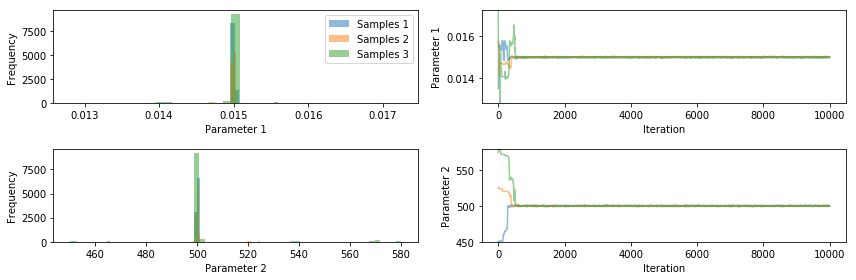

In [14]:
import pints.plot
pints.plot.trace(chains)
plt.show()

Based on this plot, it looks like the three chains become very similar after about 1000 iterations.
To be safe, we throw away the first 2000 samples and continue our analysis with the first chain.

In [15]:
chain = chains[0]
chain = chain[2000:]

We can also look for autocorrelation in the chains, using the [autocorrelation()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.autocorrelation) method. If everything went well, the samples in the chain should be relatively independent, so the autocorrelation should get quite low when the `lag` on the x-axis increases.

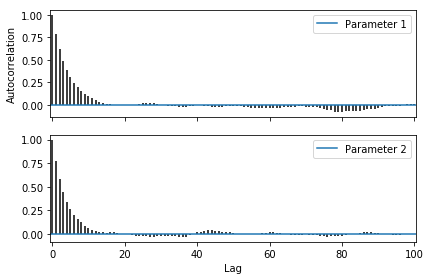

In [16]:
pints.plot.autocorrelation(chain)
plt.show()

Now we can inspect the inferred distribution by plotting histograms:

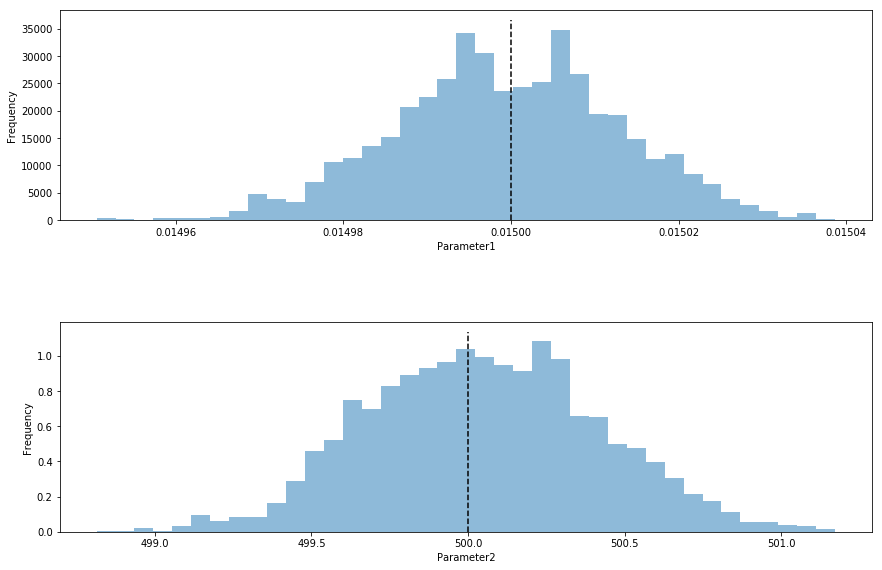

In [17]:
fig, axes = pints.plot.histogram([chain], ref_parameters=true_parameters)

# Show where the sample standard deviation of the generated noise is:
noise_sample_std = np.std(values - org_values)
#axes[-1].axvline(noise_sample_std, color='orange', label='Sample standard deviation of noise')
#axes[-1].legend()

fig.set_size_inches(14, 9)
plt.show()

Here we've analysed each parameter in isolation, but we can also look at correlations between parameters we found using the [pairwise()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.pairwise) plot.

To speed things up, we'll first apply some _thinning_ to the chain:

In [18]:
thinned_chain = chain[::10]

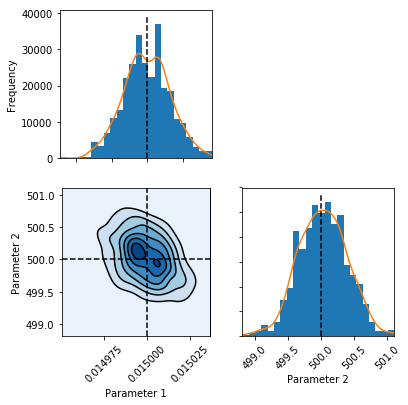

In [19]:
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

Finally, we can look at the bit that really matters: The model predictions made from models with the parameters we found (a _posterior predictive check_). Thes can be plotted using the [series()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.series) method.

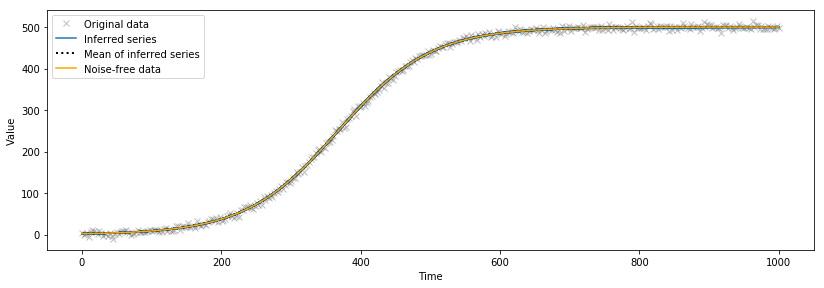

In [20]:
fig, axes = pints.plot.series(chain, problem)

# Customise the plot, and add the original, noise-free data
fig.set_size_inches(12,4.5)
plt.plot(times, org_values, c='orange', label='Noise-free data')
plt.legend()
plt.show()

-1284.3988653544197
[1.51573197e-02 4.95922642e+02]
-1190.5747037441117


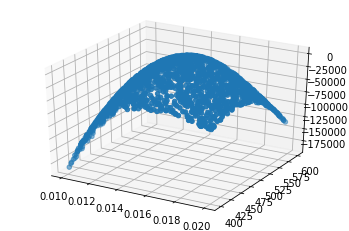

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

input_parameters = log_prior.sample(2000)
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
input_parameters[:5]

likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
likelihoods[:5]

print(max(likelihoods))
idx = list(likelihoods).index(max(likelihoods))
print(input_parameters[idx])
print(log_likelihood([0.015, 500]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, list(likelihoods))
plt.show()

In [22]:
print(input_parameters[:5])

[[1.11592969e-02 4.57655841e+02]
 [1.06619890e-02 5.04088867e+02]
 [1.20835488e-02 4.21815678e+02]
 [1.85515038e-02 5.85857207e+02]
 [1.64464855e-02 5.29516779e+02]]


In [23]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)

emu = pints.MultiLayerNN(log_likelihood, X_train, y_train, 
                          input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
#emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='tanh', learning_rate=0.00001)
emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=1000, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
#emu.summary()

In [24]:
emu([0.015, 500])

array([[-883.6697]], dtype=float32)

In [25]:
log_likelihood([0.015, 500])

-1190.5747037441117

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


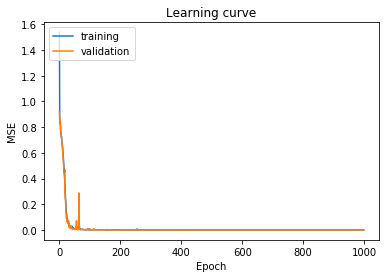

In [26]:
# summarize history for loss
print(hist.history.keys())
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Learning curve')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


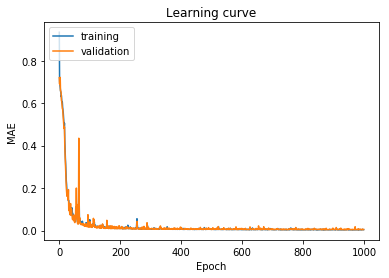

In [27]:
# summarize history for loss
print(hist.history.keys())
plt.plot(hist.history['mean_absolute_error'])
plt.plot(hist.history['val_mean_absolute_error'])
plt.title('Learning curve')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

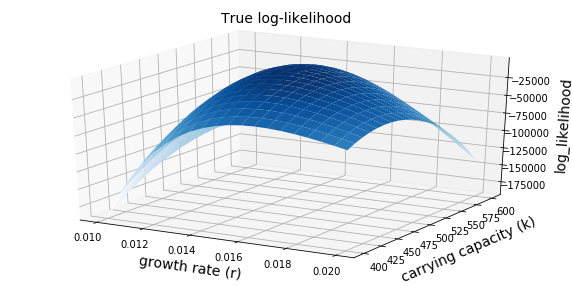

In [28]:
test_splits = 20 # number of splits along each axis
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), 
                                                  bounds.upper(), 
                                                  test_splits)

model_prediction = pints.predict_grid(log_likelihood, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, model_prediction, title = "True log-likelihood",
                     x_label = "growth rate (r)",
                     y_label = "carrying capacity (k)")

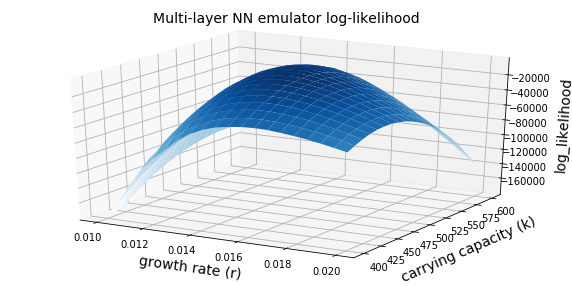

In [29]:
emu_prediction = pints.predict_grid(emu, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, 
             k_grid, 
             emu_prediction, 
             title = "Multi-layer NN emulator log-likelihood",
             x_label = "growth rate (r)",
             y_label = "carrying capacity (k)")

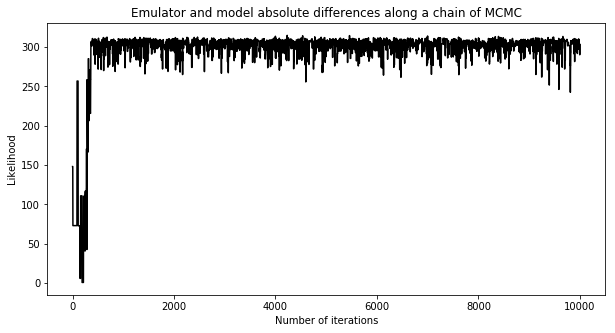

302.7538864615274

In [30]:
chain = chains[0]
emu_prediction = np.apply_along_axis(emu, 1, chain).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_prediction - emu_prediction)

iters = np.linspace(0, 10000, len(chain))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

In [31]:
print(emu_prediction)

[-24533.387   -24533.387   -24533.387   ...   -901.51733   -888.15796
   -888.15796]


In [32]:
log_posterior_emu = pints.LogPosterior(emu, log_prior)

In [33]:
chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
[2.27951446e-03 4.46881426e+02]
-inf


[2.28460622e-02 5.21531478e+02]
-inf


[1.48900637e-02 5.78653598e+02]
-25188.50390625
accepted


1     6      0         0         0.5        0:00.0
[2.69942513e-02 4.47980684e+02]
-inf


[-8.95027308e-03  5.25393025e+02]
-inf


[2.25160188e-02 5.81277364e+02]
-inf


2     9      0         0         0.333      0:00.0
[3.92944800e-03 4.50257055e+02]
-inf


[2.3092075e-02 5.2690677e+02]
-inf


[1.55855435e-02 5.76192497e+02]
-29674.82421875


3     12     0         0         0.25       0:00.0
[9.27946914e-03 4.47715777e+02]
-inf


[3.94858502e-02 5.19730124e+02]
-inf


[-1.47955029e-02  5.79813286e+02]
-inf


[2.95078400e-03 4.48510946e+02]
-inf


[1.86456972e-02 5.24063909e+02]
-40235.64453125


[2.46591373e-02 5.78278887e+02]
-inf


[-1.04396203e-03  4.

[4.39004068e-02 5.82583583e+02]
-inf


[5.94420656e-02 4.49384618e+02]
-inf


[-5.50711796e-03  5.18037215e+02]
-inf


[1.35712745e-02 5.79891180e+02]
-22752.396484375
accepted


[2.18666056e-02 4.45571424e+02]
-inf


[2.09805669e-02 5.17135986e+02]
-inf


[-2.97917115e-04  5.81699524e+02]
-inf


[2.34113397e-02 4.46647160e+02]
-inf


[1.20476644e-02 5.20321080e+02]
-34627.9921875


[3.43966089e-03 5.78800031e+02]
-inf


[1.99343932e-02 4.48987888e+02]
-39188.9140625


[-6.66015799e-03  5.15115992e+02]
-inf


[3.63078415e-02 5.77930513e+02]
-inf


[2.60107159e-03 4.49632575e+02]
-inf


[1.14982862e-02 5.16577824e+02]
-52007.24609375


[1.49591010e-02 5.80762622e+02]
-27072.79296875


[1.40783647e-02 4.44832150e+02]
-20301.669921875


[-3.81195436e-03  5.20408294e+02]
-inf


[-3.20411142e-03  5.82971271e+02]
-inf


[1.25772766e-02 4.43787226e+02]
-46275.47265625


[1.25495035e-02 5.16248478e+02]
-23121.705078125


[1.59138769e-02 5.75440297e+02]
-33334.3046875


[5.41443085e-03 4.478744

[2.01864729e-02 5.72328998e+02]
-inf


[2.96532956e-02 4.50459673e+02]
-inf


[5.83444041e-03 5.18605712e+02]
-inf


[1.46195934e-02 5.74306655e+02]
-21227.765625
accepted


[3.70985427e-04 4.48578907e+02]
-inf


[2.61823131e-03 5.18869139e+02]
-inf


[8.53314054e-03 5.75034497e+02]
-inf


[1.94679645e-02 4.48622370e+02]
-34530.28125


[9.11736743e-04 5.17578667e+02]
-inf


[2.02601301e-02 5.73382807e+02]
-inf


[7.53264040e-03 4.50749819e+02]
-inf


[2.45465860e-02 5.21113911e+02]
-inf


[9.08350669e-03 5.71896188e+02]
-inf


[2.32944848e-02 4.48464753e+02]
-inf


[1.44981438e-03 5.18501310e+02]
-inf


[6.24505439e-03 5.72214676e+02]
-inf


[1.96905370e-02 4.49114161e+02]
-36801.25


[1.59262229e-02 5.19488135e+02]
-6615.36328125


[2.20088377e-02 5.70473973e+02]
-inf


[2.67460908e-02 4.44518409e+02]
-inf


[4.88711029e-03 5.16279105e+02]
-inf


[1.02014493e-02 5.74527988e+02]
-106154.9140625


[2.61356228e-02 4.49057967e+02]
-inf


[1.83814243e-02 5.12844839e+02]
-31335.998046875




[1.5514335e-02 4.4715731e+02]
-11333.78125


[1.50462490e-02 5.18560355e+02]
-2980.63623046875


[1.41305645e-02 5.74016249e+02]
-19435.65625


[1.59835248e-02 4.47164924e+02]
-11807.337890625


[1.48974613e-02 5.18512627e+02]
-2523.46826171875


[1.38958070e-02 5.73917735e+02]
-18958.255859375
accepted


[1.56136166e-02 4.47164870e+02]
-11255.595703125
accepted


[1.50272572e-02 5.18594027e+02]
-2911.26123046875


[1.36597032e-02 5.73956519e+02]
-19593.328125


[1.58896436e-02 4.47173505e+02]
-11650.720703125


[1.45430674e-02 5.18426922e+02]
-2286.16357421875


[1.34414670e-02 5.73959057e+02]
-20623.873046875


[1.57845751e-02 4.47214461e+02]
-11470.060546875


[1.45783361e-02 5.18459775e+02]
-2204.26513671875


[1.37569672e-02 5.73906270e+02]
-19264.16796875


220   663    0.0226    0.0136    0.0452     0:01.3
[1.55957045e-02 4.47156796e+02]
-11262.72265625


[1.43450783e-02 5.18355145e+02]
-2742.98779296875


[1.38716883e-02 5.73995118e+02]
-18999.482421875


[1.56137879e-02 4.4717

[1.56029042e-02 4.47250402e+02]
-11225.025390625


[1.46655622e-02 5.18400486e+02]
-2080.01513671875


[1.38667037e-02 5.73747044e+02]
-18878.9921875
accepted


[1.55925337e-02 4.47234374e+02]
-11237.0625


[1.46546168e-02 5.18386338e+02]
-2076.27294921875


[1.38711752e-02 5.73752102e+02]
-18874.849609375
accepted


[1.55946265e-02 4.47247317e+02]
-11230.501953125


[1.46320591e-02 5.18393789e+02]
-2083.83935546875


[1.38701628e-02 5.73748810e+02]
-18874.7421875
accepted


[1.56142683e-02 4.47232125e+02]
-11229.392578125


[1.46589978e-02 5.18398327e+02]
-2078.40185546875


[1.38869738e-02 5.73751915e+02]
-18870.931640625
accepted


[1.55914490e-02 4.47257385e+02]
-11229.607421875


[1.46387039e-02 5.18391859e+02]
-2075.88623046875
accepted


[1.39018828e-02 5.73771726e+02]
-18887.439453125


[1.56072455e-02 4.47251922e+02]
-11223.4140625
accepted


[1.46385165e-02 5.18391063e+02]
-2075.81591796875
accepted


[1.38736155e-02 5.73734019e+02]
-18864.515625
accepted


280   843    0.067

-2042.31591796875
accepted


[1.38944724e-02 5.73178715e+02]
-18585.3125


[1.56671794e-02 4.47706787e+02]
-11049.470703125
accepted


[1.46447759e-02 5.18129055e+02]
-2048.91748046875


[1.38799309e-02 5.73247117e+02]
-18622.51171875


[1.56917591e-02 4.47825726e+02]
-11031.216796875
accepted


[1.46512517e-02 5.18127350e+02]
-2050.12060546875


[1.38885233e-02 5.73047627e+02]
-18522.015625
accepted


[1.56850312e-02 4.47830293e+02]
-11016.1171875
accepted


[1.46553458e-02 5.17938389e+02]
-2032.48388671875
accepted


[1.38953514e-02 5.72799565e+02]
-18399.27734375
accepted


[1.56868753e-02 4.47874668e+02]
-10998.708984375
accepted


[1.46430326e-02 5.18099133e+02]
-2045.55029296875


[1.38923543e-02 5.72601136e+02]
-18302.119140625
accepted


[1.56713598e-02 4.47806399e+02]
-11012.173828125


[1.46529947e-02 5.17896063e+02]
-2027.97998046875
accepted


[1.38984114e-02 5.72512980e+02]
-18264.41796875
accepted


[1.56997894e-02 4.48037213e+02]
-10948.943359375
accepted


[1.46496663e-



[1.45141398e-02 5.23998020e+02]
-3103.97998046875


[1.64303474e-02 4.59383320e+02]
-8844.37109375


[1.45296933e-02 5.14358414e+02]
-1712.97607421875


[1.47166698e-02 5.08074410e+02]
-1734.18701171875


[1.59359237e-02 4.51751208e+02]
-9910.544921875


[1.45221731e-02 5.13938153e+02]
-1693.55029296875
accepted


[1.46555426e-02 5.13319819e+02]
-1724.46826171875


[1.69087820e-02 4.66468935e+02]
-10147.2734375


[1.45662140e-02 5.15088798e+02]
-1761.32763671875


[1.42081542e-02 5.47904200e+02]
-9017.76171875


[1.66222658e-02 4.62200675e+02]
-9053.505859375


[1.45126431e-02 5.13594024e+02]
-1694.55029296875


[1.49488273e-02 4.89837165e+02]
-1397.11669921875


[1.65140614e-02 4.60523365e+02]
-8874.55078125


[1.46380115e-02 5.17758563e+02]
-2011.93701171875


[1.53356127e-02 4.59189660e+02]
-7321.03125


[1.64705257e-02 4.59892281e+02]
-8852.875


[1.44659875e-02 5.12053364e+02]
-1703.83154296875


[1.40550315e-02 5.60012118e+02]
-13304.025390625


[1.6724673e-02 4.6378352e+02]
-9

-8846.55078125


[1.45171865e-02 5.12464677e+02]
-1665.28466796875


[1.48168896e-02 5.00476315e+02]
-1143.03466796875


[1.65093893e-02 4.60785716e+02]
-8788.0078125
accepted


[1.45565170e-02 5.14015481e+02]
-1681.76513671875


[1.47082394e-02 5.08982279e+02]
-1701.44873046875


[1.63506519e-02 4.58306135e+02]
-8862.40234375


[1.44826609e-02 5.11578945e+02]
-1675.84326171875


[1.45142655e-02 5.24043667e+02]
-3111.72998046875


[1.66062644e-02 4.62336584e+02]
-8937.08203125


[1.45003251e-02 5.11754739e+02]
-1666.17138671875


[1.49499809e-02 4.90010072e+02]
-1375.20263671875


[1.64060475e-02 4.59103813e+02]
-8835.88671875


[1.45054895e-02 5.12271240e+02]
-1670.50732421875


[1.47557298e-02 5.05082649e+02]
-1476.20654296875


[1.64173619e-02 4.59293377e+02]
-8824.76171875


[1.45309847e-02 5.13480542e+02]
-1674.98779296875


[1.47267890e-02 5.07664271e+02]
-1765.73388671875


[1.65923150e-02 4.62109531e+02]
-8898.3046875


[1.45459408e-02 5.13473933e+02]
-1665.04248046875


[1.506

[1.65393868e-02 4.78518890e+02]
-6677.4609375
accepted


[1.45442862e-02 5.10593513e+02]
-1641.59326171875
accepted


[1.48820831e-02 4.95260682e+02]
-1040.60498046875


[1.65010995e-02 4.77846650e+02]
-6507.0390625
accepted


[1.46007728e-02 5.12285220e+02]
-1659.84716796875


[1.48639534e-02 4.96714839e+02]
-1042.18310546875


[1.65208176e-02 4.72624663e+02]
-6935.93359375


[1.45494534e-02 5.10100298e+02]
-1649.30029296875


[1.48606120e-02 4.96954298e+02]
-1043.40185546875


[1.65321659e-02 4.81976989e+02]
-6467.60546875
accepted


[1.45376552e-02 5.11137868e+02]
-1646.62451171875


[1.48119144e-02 5.00787837e+02]
-1159.28857421875


[1.64967422e-02 4.79107252e+02]
-6394.640625
accepted


[1.45556183e-02 5.09933124e+02]
-1653.40185546875


[1.48497179e-02 4.97815271e+02]
-1056.88623046875


[1.65036247e-02 4.81825166e+02]
-6318.96484375
accepted


[1.45602723e-02 5.12183439e+02]
-1650.41357421875


[1.48230940e-02 4.99917331e+02]
-1119.92529296875


[1.63701951e-02 4.68945905e+02]




[1.48812563e-02 4.95344962e+02]
-1038.13623046875


[1.54342237e-02 5.01489350e+02]
-1676.46435546875


[1.45548262e-02 5.10945359e+02]
-1644.92919921875
accepted


[1.48980737e-02 4.94022408e+02]
-1078.69873046875


[1.55594211e-02 4.94673426e+02]
-2131.10107421875


[1.45703018e-02 5.11222250e+02]
-1649.37060546875


[1.48495800e-02 4.97853044e+02]
-1057.51123046875


[1.56208923e-02 4.96515455e+02]
-2260.48779296875


[1.45493974e-02 5.11014783e+02]
-1643.95654296875
accepted


[1.48774800e-02 4.95640965e+02]
-1031.46826171875
accepted


[1.51035175e-02 5.14378735e+02]
-2504.13623046875


[1.45382278e-02 5.10807814e+02]
-1643.94873046875
accepted


[1.48757356e-02 4.95773985e+02]
-1030.92529296875
accepted


[1.52284543e-02 4.84916968e+02]
-2095.14013671875


[1.45357422e-02 5.10556012e+02]
-1643.01513671875
accepted


[1.48512642e-02 4.97674944e+02]
-1052.74560546875


[1.47361340e-02 5.05715737e+02]
-1604.24951171875


[1.45199495e-02 5.11152187e+02]
-1652.95263671875


[1.48782

-1643.01123046875


[1.48752626e-02 4.95813372e+02]
-1031.53076171875
accepted


[1.53767651e-02 4.91825339e+02]
-1762.61279296875


[1.45407020e-02 5.10731961e+02]
-1642.49951171875
accepted


[1.48764322e-02 4.95716325e+02]
-1030.37451171875
accepted


[1.52033131e-02 4.91327053e+02]
-1367.28466796875


[1.45359523e-02 5.10259601e+02]
-1646.33935546875


[1.48811809e-02 4.95336754e+02]
-1038.53076171875


[1.52278529e-02 4.96663640e+02]
-1148.58154296875


[1.45399690e-02 5.10748007e+02]
-1642.85498046875


[1.48724304e-02 4.96019598e+02]
-1035.06982421875


[1.48082657e-02 5.00791620e+02]
-1165.38232421875


[1.45463013e-02 5.10833120e+02]
-1642.62451171875
accepted


[1.48766462e-02 4.95691409e+02]
-1030.90966796875
accepted


[1.55722878e-02 4.86598605e+02]
-2317.40576171875


[1.45475656e-02 5.10273271e+02]
-1645.96435546875


[1.48778885e-02 4.95595712e+02]
-1032.39013671875


[1.50896404e-02 4.96865530e+02]
-1036.29638671875


[1.45424386e-02 5.11000284e+02]
-1643.94091796875



[1.55472633e-02 4.95988946e+02]
-2060.75341796875


[1.45449423e-02 5.10744165e+02]
-1642.03857421875


[1.48773465e-02 4.95633152e+02]
-1031.88232421875


[1.51266729e-02 4.97945696e+02]
-1036.08935546875


[1.45468701e-02 5.10609275e+02]
-1642.22998046875


[1.48755064e-02 4.95778137e+02]
-1031.35107421875
accepted


[1.52927698e-02 4.94343021e+02]
-1387.16748046875


[1.45480740e-02 5.10537999e+02]
-1642.60498046875


[1.48769827e-02 4.95657586e+02]
-1031.54638671875
accepted


[1.50854584e-02 5.00424397e+02]
-933.0855102539062


[1.45456827e-02 5.10744431e+02]
-1642.17919921875


[1.48769023e-02 4.95659640e+02]
-1031.58935546875
accepted


[1.50846048e-02 5.00269858e+02]
-929.8042602539062


[1.45476139e-02 5.10844627e+02]
-1642.94482421875


[1.48797503e-02 4.95435708e+02]
-1036.08154296875
accepted


[1.48798698e-02 5.02066689e+02]
-1091.01904296875


[1.45421059e-02 5.10604475e+02]
-1641.15185546875
accepted


[1.48819241e-02 4.95259915e+02]
-1040.76513671875


[1.51996723e-02 5

[1.50140138e-02 4.98725823e+02]
-923.7144165039062


[1.45399222e-02 5.10398992e+02]
-1642.64404296875


[1.48739335e-02 4.95891486e+02]
-1033.34716796875


[1.49823756e-02 4.99426589e+02]
-881.0230102539062
accepted


[1.45403712e-02 5.10270220e+02]
-1644.78076171875


[1.48737119e-02 4.95935784e+02]
-1033.40185546875
accepted


[1.48942695e-02 5.00119805e+02]
-1022.2066040039062


[1.45379324e-02 5.10666492e+02]
-1642.98779296875


[1.48747197e-02 4.95859816e+02]
-1032.14013671875
accepted


[1.49023576e-02 5.00225225e+02]
-1012.1753540039062


[1.45385692e-02 5.10625232e+02]
-1642.45654296875


[1.48767757e-02 4.95694800e+02]
-1030.67919921875
accepted


[1.49480467e-02 5.00474099e+02]
-947.6050415039062


[1.45440480e-02 5.10980825e+02]
-1643.27294921875


[1.48756353e-02 4.95785420e+02]
-1031.05029296875


[1.50437187e-02 4.98623833e+02]
-946.5894165039062


[1.45426957e-02 5.10556308e+02]
-1641.16748046875
accepted


[1.48784622e-02 4.95564196e+02]
-1032.72216796875


[1.52092475

[1.50284620e-02 4.98884899e+02]
-926.5581665039062


[1.45362602e-02 5.10200144e+02]
-1647.15576171875


[1.48825689e-02 4.95641383e+02]
-1025.56982421875


[1.49771834e-02 4.99946253e+02]
-895.6675415039062


[1.45481438e-02 5.10523137e+02]
-1642.58935546875


[1.48794741e-02 4.95780585e+02]
-1024.76123046875


[1.50092799e-02 4.99336880e+02]
-890.9566040039062


[1.45418983e-02 5.10417072e+02]
-1642.17529296875


[1.48806143e-02 4.95866185e+02]
-1021.3511352539062
accepted


[1.50263408e-02 4.98587271e+02]
-935.4487915039062


[1.45403199e-02 5.10454270e+02]
-1641.56982421875
accepted


[1.48795188e-02 4.95956492e+02]
-1022.6362915039062


[1.50167680e-02 5.00004512e+02]
-886.5151977539062


[1.45398741e-02 5.10629219e+02]
-1642.01904296875
accepted


[1.48803251e-02 4.95845065e+02]
-1022.0269165039062
accepted


[1.50188391e-02 4.99143181e+02]
-907.8159790039062


[1.45372325e-02 5.10515794e+02]
-1642.38623046875
accepted


[1.48812618e-02 4.95884090e+02]
-1020.0151977539062
accepte

[1.45394295e-02 5.10434329e+02]
-1642.18701171875


[1.49461559e-02 4.97939060e+02]
-922.5581665039062


[1.49765331e-02 4.99308746e+02]
-882.9097290039062


[1.45429052e-02 5.10874941e+02]
-1642.84326171875


[1.50266755e-02 5.00004116e+02]
-888.3081665039062


[1.50196140e-02 4.99745889e+02]
-882.4292602539062
accepted


[1.45367039e-02 5.10431787e+02]
-1643.10107421875


[1.50334142e-02 5.00445328e+02]
-897.3589477539062


[1.50331401e-02 4.99049288e+02]
-923.6011352539062


[1.45469335e-02 5.10842204e+02]
-1642.77294921875


[1.50324702e-02 5.00288744e+02]
-894.4214477539062


[1.5019730e-02 4.9993838e+02]
-885.8745727539062


[1.45398205e-02 5.10522009e+02]
-1641.54638671875
accepted


[1.50415556e-02 5.00575992e+02]
-901.1870727539062


[1.50426117e-02 4.99406113e+02]
-914.4566040039062


[1.45411401e-02 5.10710505e+02]
-1642.19091796875
accepted


[1.49809095e-02 4.98759286e+02]
-898.7105102539062


[1.50286152e-02 4.99848219e+02]
-887.3862915039062


[1.45371260e-02 5.10585303e

[1.50014453e-02 4.99685853e+02]
-881.7456665039062
accepted


[1.45374210e-02 5.10341971e+02]
-1644.44091796875


[1.49938841e-02 4.99246898e+02]
-888.5816040039062


[1.50057971e-02 4.99883307e+02]
-883.3862915039062


[1.45319676e-02 5.10582137e+02]
-1644.44873046875


[1.49712145e-02 4.98689889e+02]
-898.3042602539062


920   2763   0.168     0.262     0.197      0:08.0
[1.50164028e-02 4.99692965e+02]
-881.8941040039062
accepted


[1.45432832e-02 5.10575539e+02]
-1641.32373046875
accepted


[1.49722866e-02 4.98662701e+02]
-899.2730102539062


[1.50060833e-02 5.00266034e+02]
-889.2769165039062


[1.45316349e-02 5.10557783e+02]
-1644.35498046875


[1.50292419e-02 5.00282331e+02]
-893.7183227539062


[1.50286547e-02 4.99471918e+02]
-900.1128540039062


[1.45441824e-02 5.10577351e+02]
-1641.53466796875
accepted


[1.50067245e-02 4.99703304e+02]
-881.9175415039062
accepted


[1.50353639e-02 4.99528137e+02]
-902.8589477539062


[1.45459065e-02 5.10646644e+02]
-1641.98779296875


[1.502106

[1.49969648e-02 4.99251875e+02]
-889.2144165039062


[1.45301587e-02 5.10546574e+02]
-1644.79638671875


[1.49882185e-02 4.99230963e+02]
-887.6831665039062


[1.4987421e-02 4.9967477e+02]
-881.5776977539062
accepted


[1.45331859e-02 5.10894025e+02]
-1646.36669921875


[1.49923684e-02 4.99494455e+02]
-881.5776977539062
accepted


[1.49834022e-02 4.99628370e+02]
-881.5503540039062
accepted


[1.45561294e-02 5.10625124e+02]
-1644.69091796875


[1.49744294e-02 4.98912660e+02]
-893.0425415039062


[1.50056996e-02 4.99639158e+02]
-881.3706665039062
accepted


[1.45602487e-02 5.10783073e+02]
-1645.70654296875


[1.49915946e-02 4.99521166e+02]
-880.6675415039062
accepted


[1.50095331e-02 4.99809590e+02]
-882.8237915039062


[1.45305054e-02 5.10577265e+02]
-1644.90576171875


[1.49822799e-02 4.99275595e+02]
-885.0933227539062


[1.50107402e-02 4.99584642e+02]
-883.4566040039062


[1.45564936e-02 5.10671897e+02]
-1644.78076171875


[1.49758978e-02 4.99131152e+02]
-887.4800415039062


[1.500931

[1.5005429e-02 4.9986866e+02]
-883.2769165039062
accepted


[1.45349897e-02 5.10482963e+02]
-1642.97607421875
accepted


[1.50022730e-02 4.99737334e+02]
-882.1948852539062


[1.50043426e-02 4.99758591e+02]
-882.3667602539062
accepted


[1.45118173e-02 5.10253449e+02]
-1654.23388671875


[1.49669013e-02 4.98991746e+02]
-893.4566040039062


[1.50144202e-02 4.99670449e+02]
-882.0073852539062
accepted


[1.45305616e-02 5.10512309e+02]
-1644.48779296875


[1.49886509e-02 4.99539193e+02]
-880.4448852539062
accepted


[1.49888847e-02 4.99563081e+02]
-880.6870727539062
accepted


[1.45276868e-02 5.10456656e+02]
-1645.58544921875


[1.49980298e-02 4.99767929e+02]
-882.4058227539062


[1.49987097e-02 4.99620782e+02]
-881.1636352539062
accepted


[1.45221096e-02 5.10685395e+02]
-1648.65576171875


[1.49921332e-02 4.99819249e+02]
-882.7886352539062


[1.50012703e-02 4.99514267e+02]
-883.1284790039062


[1.45379890e-02 5.10221296e+02]
-1646.22998046875


[1.49665622e-02 4.98834800e+02]
-894.3042602

[1.50006999e-02 4.99822248e+02]
-882.8784790039062


[1.45524906e-02 5.10554886e+02]
-1643.76513671875


[1.49974032e-02 4.99588023e+02]
-880.8862915039062
accepted


[1.50202827e-02 4.99971914e+02]
-886.5542602539062


[1.45683615e-02 5.11129929e+02]
-1648.56982421875


[1.50015014e-02 4.99757281e+02]
-882.3237915039062


[1.49965043e-02 4.99819428e+02]
-882.8159790039062
accepted


[1.45459081e-02 5.10946425e+02]
-1642.92138671875


[1.49952481e-02 4.99555707e+02]
-880.6323852539062
accepted


[1.50020882e-02 4.99744560e+02]
-882.2261352539062
accepted


[1.45610771e-02 5.10476591e+02]
-1644.93701171875
accepted


[1.49893117e-02 4.99374530e+02]
-884.0620727539062


1080  3243   0.208     0.271     0.198      0:09.7
[1.49985051e-02 4.99759273e+02]
-882.3276977539062
accepted


[1.45671454e-02 5.10302056e+02]
-1649.31982421875


[1.49752395e-02 4.99112729e+02]
-887.8394165039062


[1.49882832e-02 4.99521352e+02]
-880.3003540039062
accepted


[1.45707964e-02 5.10431601e+02]
-1647.76123

[1.49856513e-02 4.99336621e+02]
-884.2417602539062


[1.45337906e-02 5.11865115e+02]
-1653.49560546875


[1.49861401e-02 4.99812084e+02]
-883.6011352539062


[1.49957244e-02 4.99521307e+02]
-881.6245727539062
accepted


[1.45511066e-02 5.11262908e+02]
-1645.19091796875
accepted


[1.50002696e-02 4.99915845e+02]
-883.6870727539062
accepted


[1.49836866e-02 4.99411626e+02]
-881.7730102539062
accepted


[1.45428262e-02 5.10825201e+02]
-1642.48779296875
accepted


[1.49987974e-02 4.99856121e+02]
-883.1636352539062
accepted


1140  3423   0.223     0.27695   0.206      0:10.3
[1.49731308e-02 4.99350423e+02]
-884.9956665039062


[1.45727269e-02 5.10318302e+02]
-1650.29638671875


[1.50021645e-02 4.99948656e+02]
-883.9605102539062
accepted


[1.49606665e-02 4.99322319e+02]
-902.1245727539062


[1.45411046e-02 5.10378368e+02]
-1642.83544921875
accepted


[1.50058750e-02 5.00023028e+02]
-884.9136352539062


[1.49848739e-02 4.99414018e+02]
-881.9800415039062
accepted


[1.45556639e-02 5.1070212

[1.49875556e-02 4.99593080e+02]
-880.9019165039062
accepted


[1.45544268e-02 5.10973686e+02]
-1644.95654296875


[1.50095926e-02 5.00173071e+02]
-888.2378540039062


[1.49864621e-02 4.99433150e+02]
-881.8355102539062


[1.45311616e-02 5.11196774e+02]
-1649.37060546875


[1.49802043e-02 4.99378678e+02]
-881.8355102539062


[1.49970955e-02 4.99658770e+02]
-881.4995727539062
accepted


[1.45297434e-02 5.11302080e+02]
-1650.65185546875


[1.49815348e-02 4.99205768e+02]
-886.8003540039062


[1.49745627e-02 4.99448626e+02]
-883.9995727539062


[1.45501497e-02 5.10515901e+02]
-1643.16357421875
accepted


[1.49987938e-02 4.99848281e+02]
-883.0972290039062
accepted


[1.49962477e-02 4.99576862e+02]
-880.8237915039062
accepted


[1.45543328e-02 5.11025147e+02]
-1645.10888671875


[1.50052835e-02 5.00104864e+02]
-886.2730102539062


[1.50037992e-02 4.99532369e+02]
-883.2495727539062


[1.45354054e-02 5.09946557e+02]
-1651.20654296875


[1.50005463e-02 4.99827089e+02]
-882.9214477539062
accepted


[1.49775197e-02 4.99438813e+02]
-880.2417602539062
accepted


[1.45454274e-02 5.10407753e+02]
-1643.26513671875
accepted


[1.49871578e-02 4.99453172e+02]
-881.4566040039062
accepted


[1.49837881e-02 4.99457783e+02]
-880.5191040039062
accepted


[1.45739228e-02 5.09366166e+02]
-1666.33154296875


[1.49947645e-02 4.99587318e+02]
-880.8784790039062
accepted


[1.49786101e-02 4.99405858e+02]
-880.9019165039062
accepted


[1.45389996e-02 5.10601573e+02]
-1642.13623046875
accepted


[1.49980994e-02 4.99534895e+02]
-881.8042602539062


[1.49828078e-02 4.99452184e+02]
-880.4526977539062
accepted


[1.45306094e-02 5.09946666e+02]
-1652.99169921875


[1.49950633e-02 4.99560461e+02]
-880.6714477539062
accepted


[1.49658754e-02 4.99291938e+02]
-894.9566040039062


[1.45365490e-02 5.11126724e+02]
-1646.91357421875


[1.49867280e-02 4.99401481e+02]
-882.7417602539062


[1.49839620e-02 4.99687704e+02]
-882.3159790039062


[1.45442184e-02 5.10769130e+02]
-1641.96435546875
accepted


[1.49962110e-02

[1.49730188e-02 4.99467688e+02]
-887.0581665039062


[1.45145701e-02 5.09057942e+02]
-1677.08544921875


[1.49927723e-02 4.99568478e+02]
-880.7026977539062
accepted


[1.49960270e-02 4.99595337e+02]
-880.9487915039062
accepted


[1.45490460e-02 5.10868807e+02]
-1643.33935546875


[1.49972306e-02 4.99565861e+02]
-880.7886352539062
accepted


[1.49957727e-02 4.99735031e+02]
-882.1597290039062


[1.45367648e-02 5.10505851e+02]
-1642.50341796875
accepted


[1.49941351e-02 4.99594866e+02]
-880.9331665039062
accepted


[1.49873909e-02 4.99519039e+02]
-880.2612915039062
accepted


[1.45483524e-02 5.10528494e+02]
-1642.70263671875


[1.49903458e-02 4.99450985e+02]
-882.2573852539062
accepted


[1.49805091e-02 4.99493656e+02]
-880.2925415039062
accepted


[1.45346486e-02 5.10664995e+02]
-1644.14404296875


[1.49999440e-02 4.99794035e+02]
-882.6167602539062
accepted


[1.49835248e-02 4.99372458e+02]
-882.7847290039062


[1.45371379e-02 5.11065260e+02]
-1646.28076171875


[1.50029932e-02 4.998642

-893.6480102539062


[1.45505208e-02 5.11210067e+02]
-1644.88232421875


[1.50194262e-02 4.99523914e+02]
-890.2495727539062


[1.50204202e-02 4.99709447e+02]
-882.3901977539062
accepted


[1.45556775e-02 5.11099811e+02]
-1645.67919921875


[1.50102248e-02 4.99587698e+02]
-883.2808227539062
accepted


[1.50249210e-02 4.99570671e+02]
-892.4370727539062


[1.45485207e-02 5.10480977e+02]
-1642.73779296875
accepted


[1.50025457e-02 4.99702456e+02]
-881.8550415039062
accepted


[1.50226248e-02 4.99784009e+02]
-883.6558227539062


[1.45456766e-02 5.11161937e+02]
-1644.03466796875
accepted


[1.49954375e-02 4.99595186e+02]
-880.9644165039062
accepted


[1.50244609e-02 4.99610697e+02]
-890.1909790039062


[1.45513855e-02 5.11060250e+02]
-1644.56982421875
accepted


[1.50042718e-02 4.99618260e+02]
-881.2417602539062


[1.49831388e-02 4.99633947e+02]
-881.7183227539062
accepted


[1.45505410e-02 5.11131632e+02]
-1644.58935546875
accepted


[1.49930970e-02 4.99635687e+02]
-881.2925415039062
accep

[1.49996112e-02 4.99811425e+02]
-882.7612915039062


[1.45609400e-02 5.10286049e+02]
-1648.17529296875


[1.50074486e-02 4.99622722e+02]
-881.6519165039062
accepted


[1.49919051e-02 4.99643107e+02]
-881.3355102539062
accepted


[1.45384030e-02 5.10691737e+02]
-1642.99560546875
accepted


[1.50105275e-02 4.99513345e+02]
-885.3433227539062


[1.50040496e-02 4.99945276e+02]
-883.9292602539062


[1.45238686e-02 5.10839824e+02]
-1649.23388671875


[1.49864946e-02 4.99431309e+02]
-881.8901977539062
accepted


[1.49738682e-02 4.99490295e+02]
-886.4214477539062


[1.45299762e-02 5.10828046e+02]
-1646.98388671875


[1.49882181e-02 4.99383412e+02]
-883.5855102539062
accepted


[1.49878554e-02 4.99502788e+02]
-880.2964477539062
accepted


[1.45309083e-02 5.10806313e+02]
-1646.48388671875


[1.49385958e-02 4.98927370e+02]
-931.6480102539062


[1.49768042e-02 4.99566010e+02]
-884.1792602539062


[1.45475581e-02 5.09785355e+02]
-1654.38232421875


[1.49883943e-02 4.99483556e+02]
-880.9136352539062


[1.45319611e-02 5.11019503e+02]
-1647.74169921875


[1.49846530e-02 4.99542618e+02]
-880.4448852539062


[1.49668750e-02 4.99515418e+02]
-898.3276977539062


[1.45424367e-02 5.10517261e+02]
-1641.15185546875
accepted


[1.49934921e-02 4.99569080e+02]
-880.7144165039062
accepted


[1.49877324e-02 4.99724136e+02]
-881.9800415039062
accepted


[1.4549798e-02 5.1018284e+02]
-1647.93310546875


[1.49988659e-02 4.99740614e+02]
-882.1792602539062


[1.49682539e-02 4.99724372e+02]
-902.6362915039062


[1.45387965e-02 5.09256974e+02]
-1661.96826171875


[1.50194275e-02 4.99816781e+02]
-883.6675415039062


[1.49888445e-02 4.99730579e+02]
-882.0698852539062
accepted


[1.45455262e-02 5.10860796e+02]
-1642.55419921875


[1.50012524e-02 4.99759460e+02]
-882.3550415039062


[1.4982702e-02 4.9965641e+02]
-882.1792602539062
accepted


[1.45421667e-02 5.10409227e+02]
-1642.40966796875


[1.50102729e-02 4.99751789e+02]
-882.3472290039062


[1.49949005e-02 4.99905143e+02]
-883.5269165039062


[1.45424723

[1.49767503e-02 4.99348204e+02]
-882.1480102539062
accepted


[1.45092891e-02 5.09812991e+02]
-1662.63623046875


[1.50212471e-02 4.99827573e+02]
-884.1753540039062


[1.49949470e-02 4.99493177e+02]
-882.1948852539062
accepted


[1.45360696e-02 5.10387371e+02]
-1644.10107421875


[1.49973572e-02 4.99920099e+02]
-883.6948852539062


[1.50066820e-02 4.99530841e+02]
-883.9722290039062


[1.45375848e-02 5.10624308e+02]
-1642.78076171875


[1.49945804e-02 4.99639962e+02]
-881.3159790039062
accepted


[1.49986479e-02 4.99755313e+02]
-882.3237915039062
accepted


[1.45499559e-02 5.11014466e+02]
-1644.06201171875


[1.50101560e-02 4.99610015e+02]
-882.6323852539062


[1.50093246e-02 4.99918558e+02]
-883.6987915039062


[1.45405231e-02 5.11315558e+02]
-1646.97607421875


[1.49923566e-02 4.99613912e+02]
-881.0816040039062
accepted


[1.49860533e-02 4.99632576e+02]
-881.1987915039062
accepted


[1.45349931e-02 5.10496718e+02]
-1643.00732421875


[1.50081064e-02 4.99514396e+02]
-884.7261352539062


[1.49835755e-02 4.99624272e+02]
-881.4683227539062
accepted


[1.45327861e-02 5.09956075e+02]
-1652.01904296875


[1.49722745e-02 4.99592049e+02]
-892.1792602539062


[1.49982532e-02 4.99657625e+02]
-881.5269165039062
accepted


[1.45571848e-02 5.10727302e+02]
-1644.93701171875


[1.49909963e-02 4.99611365e+02]
-881.0386352539062
accepted


[1.49965777e-02 4.99421454e+02]
-884.5269165039062


[1.45303881e-02 5.10127973e+02]
-1650.41748046875


[1.49740716e-02 4.99607937e+02]
-889.8667602539062


[1.50191988e-02 4.99650007e+02]
-884.0776977539062


[1.45461437e-02 5.11281938e+02]
-1644.76904296875


[1.49646442e-02 4.99566488e+02]
-903.4214477539062


1600  4803   0.284822  0.261     0.275      0:14.8
[1.4981070e-02 4.9955922e+02]
-881.1480102539062
accepted


[1.45333319e-02 5.10619046e+02]
-1644.24169921875


[1.49787694e-02 4.99482080e+02]
-880.5581665039062
accepted


[1.49822558e-02 4.99738536e+02]
-883.5269165039062


[1.45425716e-02 5.10743610e+02]
-1641.96044921875


[1.50091355

-909.5073852539062


[1.45495129e-02 5.10770117e+02]
-1643.11669921875


[1.49863659e-02 4.99510982e+02]
-880.1792602539062
accepted


[1.49697509e-02 4.99581835e+02]
-895.8472290039062


[1.45550405e-02 5.10981271e+02]
-1645.09326171875


[1.50063841e-02 4.99522893e+02]
-884.0816040039062


[1.49992210e-02 4.99774913e+02]
-882.4917602539062


[1.45475671e-02 5.10013145e+02]
-1650.49169921875


[1.50228988e-02 4.99683436e+02]
-885.4448852539062


[1.50049205e-02 4.99737503e+02]
-882.1753540039062


[1.45447674e-02 5.10747073e+02]
-1641.99169921875
accepted


[1.49854160e-02 4.99575642e+02]
-880.7378540039062


[1.50081629e-02 4.99663197e+02]
-881.6167602539062


[1.45556138e-02 5.11034181e+02]
-1645.39404296875


[1.49798182e-02 4.99445611e+02]
-880.0386352539062
accepted


[1.50231108e-02 4.99682482e+02]
-885.6792602539062


[1.45497522e-02 5.10829524e+02]
-1643.39794921875
accepted


[1.49548445e-02 4.99200719e+02]
-910.0972290039062


[1.49902758e-02 4.99383648e+02]
-884.06207275390

-1643.26904296875
accepted


[1.50109401e-02 4.99885422e+02]
-883.4722290039062
accepted


[1.49882156e-02 4.99841552e+02]
-883.5269165039062


[1.45381436e-02 5.10675927e+02]
-1642.95654296875
accepted


[1.50059982e-02 4.99890345e+02]
-883.5034790039062
accepted


[1.49834328e-02 4.99669202e+02]
-882.1558227539062


[1.45424681e-02 5.10126451e+02]
-1647.60888671875


[1.50000693e-02 4.99663069e+02]
-881.5542602539062
accepted


[1.50088460e-02 4.99427246e+02]
-887.2808227539062


[1.45439482e-02 5.10708917e+02]
-1641.66748046875
accepted


[1.49882912e-02 4.99542315e+02]
-880.4800415039062
accepted


[1.50140321e-02 4.99522923e+02]
-885.9761352539062


[1.45555386e-02 5.11444244e+02]
-1646.81982421875


[1.49921117e-02 4.99394346e+02]
-884.2222290039062


[1.50025859e-02 4.99698996e+02]
-881.8511352539062


[1.45372036e-02 5.10851648e+02]
-1644.64404296875


[1.50078929e-02 4.99639525e+02]
-881.3901977539062


[1.49578154e-02 4.99498891e+02]
-911.4878540039062


[1.45411497e-02 5.108

[1.50008291e-02 4.99345293e+02]
-887.5816040039062


[1.45477690e-02 5.10588024e+02]
-1642.52294921875
accepted


[1.50161686e-02 4.99927801e+02]
-885.0308227539062


[1.50149568e-02 4.99587967e+02]
-884.3433227539062


[1.45509797e-02 5.10616029e+02]
-1643.36669921875


[1.50005150e-02 4.99619895e+02]
-881.1870727539062
accepted


[1.50056666e-02 4.99865775e+02]
-883.2730102539062


[1.45426120e-02 5.10497086e+02]
-1641.14794921875
accepted


[1.49988908e-02 4.99717795e+02]
-881.9917602539062


[1.49697738e-02 4.99612680e+02]
-896.8042602539062


[1.45448821e-02 5.10710626e+02]
-1641.87451171875


[1.49915636e-02 4.99402707e+02]
-883.8511352539062


[1.49807756e-02 4.99454632e+02]
-879.9370727539062
accepted


[1.45642731e-02 5.10331753e+02]
-1648.08154296875


[1.50169560e-02 4.99934724e+02]
-885.3316040039062


[1.49585820e-02 4.99299104e+02]
-904.9761352539062


[1.45500182e-02 5.10307546e+02]
-1645.86669921875


[1.50196910e-02 4.99675389e+02]
-883.2612915039062


[1.49780696e-02 

[1.49776925e-02 4.99411425e+02]
-880.8120727539062
accepted


[1.45276646e-02 5.10311266e+02]
-1648.10498046875


[1.49993754e-02 4.99442284e+02]
-884.6480102539062


[1.49992755e-02 4.99634928e+02]
-881.3003540039062
accepted


[1.45447120e-02 5.10230584e+02]
-1646.24951171875


[1.49650675e-02 4.99211311e+02]
-896.0191040039062


[1.50060281e-02 4.99468282e+02]
-885.4839477539062


[1.45463688e-02 5.10995837e+02]
-1643.19873046875


[1.49862819e-02 4.99597067e+02]
-880.9097290039062


[1.50002668e-02 4.99851490e+02]
-883.1089477539062


[1.45425099e-02 5.10679840e+02]
-1641.49560546875
accepted


[1.50003698e-02 4.99677127e+02]
-881.6558227539062


[1.49815284e-02 4.99650738e+02]
-882.3941040039062
accepted


[1.45330253e-02 5.10617445e+02]
-1644.33935546875


[1.49919764e-02 4.99526649e+02]
-880.5972290039062
accepted


[1.49485037e-02 4.99485957e+02]
-924.7651977539062


[1.45448613e-02 5.10903346e+02]
-1642.52294921875


[1.50036972e-02 4.99546448e+02]
-882.8159790039062
accepted


[1.4544256e-02 5.0996051e+02]
-1650.83154296875


[1.49447825e-02 4.99211955e+02]
-923.0933227539062


[1.49762886e-02 4.99694496e+02]
-889.0620727539062


[1.45563791e-02 5.11965005e+02]
-1648.78857421875


[1.49639490e-02 4.99283771e+02]
-897.5855102539062


[1.50022210e-02 4.99917093e+02]
-883.6870727539062


[1.45488004e-02 5.10587406e+02]
-1642.75341796875
accepted


[1.49761068e-02 4.99177495e+02]
-886.2886352539062


[1.49711437e-02 4.99344518e+02]
-887.7183227539062


[1.45489541e-02 5.10610282e+02]
-1642.80419921875
accepted


[1.49902913e-02 4.99796899e+02]
-882.6245727539062


[1.49656708e-02 4.99860599e+02]
-910.3003540039062


[1.45600760e-02 5.10627625e+02]
-1645.37060546875


[1.50068845e-02 4.99644744e+02]
-881.4370727539062
accepted


[1.49842317e-02 4.99631405e+02]
-881.3901977539062
accepted


[1.45476529e-02 5.10566663e+02]
-1642.49169921875
accepted


[1.50218853e-02 4.99776573e+02]
-883.3589477539062
accepted


[1.49486039e-02 4.99405946e+02]
-922.3589477539062




[1.49905415e-02 4.99818120e+02]
-882.7651977539062


[1.45610350e-02 5.10516544e+02]
-1645.09716796875


[1.50079380e-02 4.99528658e+02]
-884.3081665039062


[1.49621530e-02 4.99664235e+02]
-909.8511352539062


[1.45656079e-02 5.10729521e+02]
-1646.76513671875


[1.49681779e-02 4.99711870e+02]
-902.3980102539062


[1.49767007e-02 4.99430722e+02]
-880.4487915039062
accepted


[1.45533941e-02 5.10820913e+02]
-1644.18310546875
accepted


[1.49972078e-02 4.99613982e+02]
-881.1128540039062
accepted


[1.50031118e-02 4.99889224e+02]
-883.4566040039062


[1.45527634e-02 5.11150759e+02]
-1645.19482421875


[1.49886776e-02 4.99485521e+02]
-880.9175415039062
accepted


[1.50173339e-02 4.99460530e+02]
-891.5386352539062


[1.45753672e-02 5.10897299e+02]
-1649.26904296875


[1.49762418e-02 4.99275840e+02]
-883.6558227539062


[1.49510965e-02 4.99291468e+02]
-915.4487915039062


[1.45565989e-02 5.10623477e+02]
-1644.76513671875
accepted


[1.50360532e-02 4.99742245e+02]
-895.7261352539062


[1.4981

[1.45306880e-02 5.10239276e+02]
-1648.37451171875


[1.49960743e-02 4.99748489e+02]
-882.2495727539062
accepted


[1.49442163e-02 4.99096289e+02]
-924.0386352539062


[1.45352929e-02 5.10171525e+02]
-1647.96044921875


[1.49997590e-02 4.99719837e+02]
-882.0269165039062
accepted


[1.49617634e-02 4.99167158e+02]
-900.5737915039062


[1.45376540e-02 5.09911854e+02]
-1650.83544921875


[1.50095337e-02 4.99859617e+02]
-883.2573852539062
accepted


[1.49711388e-02 4.99643695e+02]
-895.6284790039062


[1.45346573e-02 5.10112683e+02]
-1649.08154296875


[1.50157616e-02 4.99785761e+02]
-882.6597290039062
accepted


[1.49759028e-02 4.99574071e+02]
-885.8511352539062


[1.45090362e-02 5.09892421e+02]
-1661.38623046875


[1.50162569e-02 4.99760060e+02]
-882.4136352539062
accepted


[1.50100627e-02 4.99904797e+02]
-883.5933227539062


[1.45409515e-02 5.10600456e+02]
-1641.51904296875
accepted


[1.50135684e-02 4.99674774e+02]
-881.7183227539062
accepted


[1.49748526e-02 4.99362507e+02]
-882.69879

[1.49695548e-02 4.99410436e+02]
-890.7183227539062


[1.45603103e-02 5.11057696e+02]
-1646.56982421875


[1.50150205e-02 4.99787847e+02]
-882.6480102539062


[1.50051745e-02 4.99558324e+02]
-882.8472290039062
accepted


[1.45375436e-02 5.10859243e+02]
-1644.56591796875


[1.50013835e-02 4.99815255e+02]
-882.8003540039062


[1.50125454e-02 4.99873368e+02]
-883.4058227539062


[1.45340381e-02 5.10285295e+02]
-1646.51904296875


[1.49753654e-02 4.99376642e+02]
-881.9487915039062


[1.50231766e-02 4.99871249e+02]
-885.3081665039062


[1.45227954e-02 5.10262443e+02]
-1650.55419921875


[1.50001677e-02 4.99580998e+02]
-881.0659790039062
accepted


[1.50240408e-02 4.99570520e+02]
-891.7261352539062


[1.45392808e-02 5.09943500e+02]
-1650.22216796875


[1.49594319e-02 4.99209490e+02]
-903.7808227539062


[1.49908287e-02 4.99423181e+02]
-883.1245727539062
accepted


[1.45475771e-02 5.10735598e+02]
-1642.62451171875


[1.49971192e-02 4.99579210e+02]
-880.8394165039062
accepted


[1.49928972e-02 

[1.50337443e-02 5.00280828e+02]
-894.4800415039062


[1.45282479e-02 5.10192203e+02]
-1649.95654296875


[1.50061261e-02 4.99614015e+02]
-881.5894165039062


[1.50273679e-02 4.99824379e+02]
-886.5464477539062


[1.45770969e-02 5.11279155e+02]
-1651.07373046875


[1.49846613e-02 4.99454113e+02]
-880.8394165039062
accepted


2120  6363   0.282     0.256     0.288      0:19.9
[1.49803024e-02 4.99432592e+02]
-880.3628540039062
accepted


[1.45548491e-02 5.10742538e+02]
-1644.30810546875


[1.49845252e-02 4.99537110e+02]
-880.3901977539062
accepted


[1.50060604e-02 4.99458486e+02]
-885.7612915039062


[1.45286722e-02 5.10504238e+02]
-1645.07763671875


[1.49675837e-02 4.99453018e+02]
-895.1753540039062


[1.49881739e-02 4.99321657e+02]
-885.2378540039062


[1.45437679e-02 5.10173915e+02]
-1647.03076171875


[1.49382784e-02 4.99243129e+02]
-932.8472290039062


[1.49762996e-02 4.99553750e+02]
-884.5972290039062


[1.45310724e-02 5.10179995e+02]
-1649.27294921875


[1.49722335e-02 4.99551419e

-1645.38623046875


[1.50042358e-02 4.99591822e+02]
-881.7534790039062


[1.49683463e-02 4.99365810e+02]
-891.6050415039062


[1.45404078e-02 5.10582738e+02]
-1641.62451171875
accepted


[1.50136460e-02 4.99712111e+02]
-882.0191040039062


[1.50066353e-02 4.99754402e+02]
-882.3706665039062
accepted


[1.45332078e-02 5.10781284e+02]
-1645.52294921875


[1.50395541e-02 4.99791085e+02]
-897.2456665039062


[1.49941059e-02 5.00049274e+02]
-885.1128540039062


[1.45499217e-02 5.10863021e+02]
-1643.56201171875


[1.50012183e-02 4.99651351e+02]
-881.4761352539062
accepted


[1.50465829e-02 5.00202257e+02]
-899.5972290039062


[1.45401527e-02 5.10630777e+02]
-1641.90966796875
accepted


[1.49768108e-02 4.99456388e+02]
-880.6480102539062
accepted


[1.50193304e-02 5.00002984e+02]
-886.9761352539062
accepted


[1.45377082e-02 5.10591511e+02]
-1642.53076171875


[1.49995351e-02 4.99605737e+02]
-881.0737915039062
accepted


2180  6543   0.282     0.255     0.289      0:20.5
[1.50344333e-02 5.00322

[1.49957395e-02 4.99764902e+02]
-882.3706665039062
accepted


[1.45360125e-02 5.10287784e+02]
-1645.82373046875


[1.49869319e-02 4.99620240e+02]
-881.1245727539062


[1.50235290e-02 4.99969847e+02]
-887.1245727539062


[1.45361077e-02 5.10287766e+02]
-1645.81591796875


[1.49727967e-02 4.99237449e+02]
-885.4136352539062


[1.50012699e-02 4.99908452e+02]
-883.5894165039062
accepted


[1.45536606e-02 5.11366794e+02]
-1646.12060546875


[1.49651911e-02 4.99343411e+02]
-895.8980102539062


[1.50023024e-02 5.00020633e+02]
-884.5620727539062
accepted


[1.45512974e-02 5.10680333e+02]
-1643.38232421875


[1.50134891e-02 4.99644661e+02]
-882.4878540039062


[1.49832600e-02 5.00066219e+02]
-889.8667602539062


[1.45541658e-02 5.11118574e+02]
-1645.37060546875


[1.49854457e-02 4.99333607e+02]
-884.2612915039062


[1.50054137e-02 5.00315251e+02]
-890.0269165039062


[1.45516397e-02 5.10657345e+02]
-1643.48779296875


[1.50043706e-02 4.99518766e+02]
-883.7691040039062


2240  6723   0.282     0.

[1.49974291e-02 4.99247012e+02]
-889.4292602539062


[1.45348389e-02 5.10571438e+02]
-1643.37060546875


[1.49779232e-02 4.99191392e+02]
-886.3589477539062


[1.50160889e-02 5.00373069e+02]
-892.9956665039062


[1.45437422e-02 5.10666794e+02]
-1641.48779296875
accepted


[1.49571656e-02 4.99148482e+02]
-906.8745727539062


[1.49328954e-02 4.99010428e+02]
-938.8433227539062


[1.4543759e-02 5.1011987e+02]
-1647.94873046875


[1.49432695e-02 4.99076263e+02]
-925.2925415039062


[1.49763149e-02 4.99427514e+02]
-880.6714477539062
accepted


[1.45542753e-02 5.11375619e+02]
-1646.27294921875


[1.49563990e-02 4.99363803e+02]
-909.7144165039062


[1.50153007e-02 5.00252922e+02]
-890.6870727539062


[1.45379145e-02 5.10537568e+02]
-1642.21435546875


[1.49992404e-02 4.99518813e+02]
-882.5425415039062
accepted


[1.49748209e-02 4.99429860e+02]
-882.9800415039062


[1.45526656e-02 5.10473491e+02]
-1643.46826171875


[1.49770088e-02 4.99518439e+02]
-882.3433227539062
accepted


[1.49782448e-02 4.

[1.49871666e-02 4.99417219e+02]
-882.4214477539062


[1.45402199e-02 5.10384330e+02]
-1642.76123046875
accepted


[1.50378367e-02 5.00083729e+02]
-893.6167602539062


[1.49923840e-02 4.99601816e+02]
-880.9526977539062
accepted


[1.45486504e-02 5.10322483e+02]
-1645.32373046875


[1.50324283e-02 4.99810452e+02]
-890.0503540039062


[1.49449096e-02 4.98995866e+02]
-923.3667602539062


[1.45375425e-02 5.09826779e+02]
-1652.14013671875


[1.49668121e-02 4.99468205e+02]
-896.9058227539062


[1.50057647e-02 4.99791160e+02]
-882.6401977539062


[1.45457883e-02 5.10223381e+02]
-1646.50341796875


[1.49974831e-02 4.99677819e+02]
-881.6519165039062
accepted


[1.50006895e-02 4.99433956e+02]
-885.1401977539062


[1.45357255e-02 5.10534089e+02]
-1642.91357421875
accepted


[1.49957001e-02 4.99794782e+02]
-882.5972290039062


[1.50071478e-02 4.99943118e+02]
-883.9097290039062


[1.45318267e-02 5.11281106e+02]
-1649.77685546875


[1.50006827e-02 4.99943007e+02]
-883.8745727539062


[1.49946132e-02 

-1642.62841796875
accepted


[1.50307931e-02 4.99972032e+02]
-888.8198852539062


[1.50028877e-02 4.99676126e+02]
-881.6597290039062


[1.45498011e-02 5.11036984e+02]
-1644.11279296875


[1.49875972e-02 4.99901364e+02]
-884.5816040039062
accepted


[1.50132870e-02 4.99854633e+02]
-883.2300415039062


[1.45624923e-02 5.10507481e+02]
-1645.31201171875


[1.49558269e-02 4.99565907e+02]
-916.3237915039062


[1.50013314e-02 4.99498132e+02]
-883.5855102539062


[1.45425041e-02 5.10897690e+02]
-1643.11669921875


[1.49681153e-02 4.99781715e+02]
-904.4800415039062


[1.49869836e-02 4.99565101e+02]
-880.6480102539062
accepted


[1.45398665e-02 5.10359724e+02]
-1643.35107421875
accepted


[1.49871106e-02 5.00198584e+02]
-889.1480102539062


[1.49740039e-02 4.99305937e+02]
-883.8042602539062


[1.45417789e-02 5.11065083e+02]
-1644.65966796875


[1.49995025e-02 5.00221706e+02]
-887.3862915039062


[1.50033078e-02 4.99579601e+02]
-881.8316040039062


[1.45381690e-02 5.11110934e+02]
-1646.2612304687


[1.50073156e-02 4.99621200e+02]
-881.6792602539062
accepted


[1.45504275e-02 5.10248138e+02]
-1646.90966796875


[1.49559783e-02 4.99318667e+02]
-909.0386352539062


[1.49994527e-02 4.99347268e+02]
-887.1987915039062


[1.45411319e-02 5.10100949e+02]
-1647.84716796875


[1.49952684e-02 4.99070696e+02]
-893.6675415039062


[1.49964977e-02 4.99687544e+02]
-881.7261352539062
accepted


[1.45535941e-02 5.10927455e+02]
-1644.58935546875


[1.50049073e-02 4.99236303e+02]
-892.2026977539062


[1.49918163e-02 4.99662534e+02]
-881.5073852539062
accepted


[1.45359341e-02 5.10280031e+02]
-1645.99169921875


[1.49898339e-02 4.99297540e+02]
-886.2769165039062


[1.49805316e-02 4.99621766e+02]
-882.1987915039062


[1.45479909e-02 5.10151625e+02]
-1648.17529296875


[1.49843629e-02 4.99688015e+02]
-882.2026977539062


[1.49847076e-02 4.99445797e+02]
-881.0659790039062
accepted


[1.45461136e-02 5.11436591e+02]
-1645.95654296875


[1.49721788e-02 4.99291720e+02]
-886.2925415039062


[1.49775842e-02


[1.49850970e-02 4.99626141e+02]
-881.1597290039062
accepted


[1.49599451e-02 4.99077819e+02]
-903.0464477539062


[1.45448308e-02 5.11103243e+02]
-1643.89013671875


[1.49673291e-02 4.99595725e+02]
-900.1480102539062


[1.50004521e-02 4.99823342e+02]
-882.9058227539062


[1.45368527e-02 5.10149279e+02]
-1647.68310546875


[1.49863278e-02 4.99637214e+02]
-881.2378540039062
accepted


[1.49589843e-02 4.99376593e+02]
-906.3003540039062


[1.45551894e-02 5.11157376e+02]
-1645.71044921875


[1.50103381e-02 4.99934372e+02]
-884.1245727539062


[1.49683770e-02 4.99135081e+02]
-891.4448852539062


[1.45452869e-02 5.09822537e+02]
-1653.33935546875


[1.49637283e-02 4.99550274e+02]
-904.3042602539062


[1.50032083e-02 4.99601808e+02]
-881.2222290039062


[1.45431028e-02 5.11164710e+02]
-1644.94873046875


[1.49458531e-02 4.99275475e+02]
-922.6987915039062


[1.49825073e-02 4.99358286e+02]
-882.9097290039062


[1.45306525e-02 5.11440691e+02]
-1651.35107421875


[1.49960559e-02 4.99550726e+02]
-

-890.7769165039062


[1.45417565e-02 5.09671789e+02]
-1655.36669921875


[1.50133288e-02 4.99566418e+02]
-884.5464477539062


[1.49604405e-02 4.99039988e+02]
-902.3394165039062


[1.45441904e-02 5.10223288e+02]
-1646.24560546875


[1.49548845e-02 4.99426083e+02]
-913.7222290039062


[1.49913777e-02 4.99535860e+02]
-880.4644165039062
accepted


[1.45565307e-02 5.10584914e+02]
-1644.62841796875


[1.49895478e-02 4.99411083e+02]
-883.1597290039062


[1.49487384e-02 4.99290763e+02]
-918.8706665039062


[1.45572347e-02 5.11625785e+02]
-1647.80029296875


[1.49965627e-02 4.99528500e+02]
-881.6323852539062


[1.49709644e-02 4.99392780e+02]
-887.9995727539062


[1.45462123e-02 5.10420949e+02]
-1643.17919921875
accepted


[1.49916818e-02 4.99428139e+02]
-883.1909790039062


[1.50255508e-02 4.99673417e+02]
-888.2534790039062


[1.45390414e-02 5.09795479e+02]
-1652.71435546875


[1.49945013e-02 4.99399968e+02]
-884.6050415039062


[1.49948548e-02 4.99409242e+02]
-884.4526977539062


[1.45377922e-

[1.45457533e-02 5.11218071e+02]
-1644.43701171875


[1.49645496e-02 4.99587368e+02]
-904.1792602539062


[1.49893090e-02 4.99644636e+02]
-881.3237915039062
accepted


[1.45473097e-02 5.10534973e+02]
-1642.39794921875


[1.50014310e-02 4.99394271e+02]
-886.3941040039062


[1.49682244e-02 4.99588372e+02]
-898.4761352539062


[1.45457573e-02 5.10346725e+02]
-1644.37451171875


[1.49955436e-02 4.99560095e+02]
-880.6597290039062
accepted


[1.49977654e-02 4.99775889e+02]
-882.4761352539062


[1.45322185e-02 5.10064772e+02]
-1650.66748046875


[1.49812832e-02 4.99275262e+02]
-884.8550415039062


[1.50082275e-02 4.99501792e+02]
-885.1245727539062


[1.45448895e-02 5.11044087e+02]
-1643.42919921875


[1.49900955e-02 4.99465809e+02]
-881.8276977539062


[1.49682085e-02 4.99864871e+02]
-906.7026977539062


[1.45392809e-02 5.11073641e+02]
-1645.62451171875


[1.49342769e-02 4.98766997e+02]
-937.5230102539062


[1.49463032e-02 4.99359098e+02]
-924.3901977539062


[1.45496287e-02 5.10932995e+02]
-1

[1.49710170e-02 4.99678273e+02]
-896.9448852539062


[1.45366737e-02 5.09889722e+02]
-1651.53857421875


[1.49656020e-02 4.99394671e+02]
-896.4761352539062


[1.50325540e-02 4.99808165e+02]
-890.1323852539062


[1.45572236e-02 5.12493723e+02]
-1650.78857421875


[1.49824139e-02 4.99543000e+02]
-880.5581665039062
accepted


2700  8103   0.273     0.254     0.284      0:25.5
[1.50168032e-02 4.99646955e+02]
-883.1987915039062


[1.45383431e-02 5.10549320e+02]
-1642.14404296875
accepted


[1.49850135e-02 4.99542073e+02]
-880.4370727539062
accepted


[1.50433451e-02 4.99861281e+02]
-898.2730102539062


[1.45439088e-02 5.09943408e+02]
-1651.02685546875


[1.50215307e-02 4.99646231e+02]
-886.1323852539062


[1.50192134e-02 4.99695242e+02]
-882.4683227539062


[1.45335653e-02 5.10323367e+02]
-1646.00732421875


[1.49925502e-02 4.99650735e+02]
-881.4058227539062


[1.49877106e-02 4.99766551e+02]
-882.4995727539062


[1.45302755e-02 5.10767327e+02]
-1646.41748046875


[1.49946252e-02 4.99748525e

accepted


[1.49925227e-02 4.99543534e+02]
-880.5112915039062
accepted


[1.45252569e-02 5.10080335e+02]
-1652.86669921875


[1.49576656e-02 4.98906403e+02]
-906.1011352539062


[1.49949623e-02 4.99720325e+02]
-881.9644165039062


[1.45479405e-02 5.11365374e+02]
-1644.85107421875


[1.49613770e-02 4.99529808e+02]
-907.1714477539062


[1.49974021e-02 4.99462719e+02]
-883.6245727539062


[1.45548039e-02 5.11352269e+02]
-1646.31201171875


[1.49695773e-02 4.99633555e+02]
-897.7769165039062


[1.49691809e-02 4.99531634e+02]
-895.1558227539062


[1.45355907e-02 5.09798644e+02]
-1653.29638671875


[1.49720165e-02 4.99266599e+02]
-886.4995727539062


[1.49940504e-02 4.99620564e+02]
-881.1909790039062
accepted


[1.45500990e-02 5.10730273e+02]
-1643.13232421875


[1.49820519e-02 4.99468889e+02]
-879.8120727539062
accepted


2760  8283   0.275     0.254     0.284      0:26.1
[1.49905523e-02 4.99886574e+02]
-883.5933227539062


[1.45322904e-02 5.10174790e+02]
-1648.96435546875


[1.50121520e-02 

[1.50238937e-02 4.99774947e+02]
-884.1753540039062


[1.45471131e-02 5.10267998e+02]
-1646.01123046875


[1.49974445e-02 4.99418938e+02]
-884.8120727539062


[1.50004765e-02 4.99885607e+02]
-883.4292602539062
accepted


[1.45475837e-02 5.10802805e+02]
-1642.82373046875


[1.49879923e-02 4.99285906e+02]
-886.1714477539062


[1.50080764e-02 5.00142662e+02]
-887.4409790039062


[1.45323846e-02 5.10337888e+02]
-1646.10888671875


[1.49809545e-02 4.99270735e+02]
-884.9097290039062


[1.50296380e-02 5.00073513e+02]
-890.0581665039062


[1.45455065e-02 5.10837634e+02]
-1642.46826171875


[1.49857512e-02 4.99624873e+02]
-881.1519165039062
accepted


2820  8463   0.274     0.248139  0.281      0:26.6
[1.49902150e-02 4.99946359e+02]
-884.5542602539062


[1.45606812e-02 5.11096643e+02]
-1646.76123046875


[1.49962132e-02 4.99595834e+02]
-880.9487915039062
accepted


[1.50056974e-02 4.99859502e+02]
-883.2534790039062
accepted


[1.45418224e-02 5.10832024e+02]
-1642.87451171875


[1.50195847e-02 4.

[1.49966109e-02 4.99568578e+02]
-880.7495727539062
accepted


[1.45152460e-02 5.09981885e+02]
-1657.84716796875


[1.49945572e-02 4.99529939e+02]
-881.1206665039062
accepted


[1.49902854e-02 4.99623764e+02]
-881.1558227539062
accepted


[1.45359597e-02 5.10215501e+02]
-1647.03857421875


[1.50206988e-02 4.99844635e+02]
-884.3901977539062


[1.49893668e-02 4.99913229e+02]
-884.2691040039062


[1.45375567e-02 5.10186866e+02]
-1646.90576171875


[1.49938009e-02 4.99403386e+02]
-884.3550415039062


[1.50312888e-02 5.00003826e+02]
-889.1128540039062


[1.45558576e-02 5.10975838e+02]
-1645.25341796875


[1.49910391e-02 4.99496307e+02]
-881.1948852539062


[1.49945672e-02 4.99398261e+02]
-884.6753540039062


[1.45420260e-02 5.10144706e+02]
-1647.22607421875


[1.49951563e-02 4.99528424e+02]
-881.3120727539062


[1.50070449e-02 4.99508165e+02]
-884.6401977539062


[1.45393218e-02 5.10485762e+02]
-1641.60888671875
accepted


[1.49826094e-02 4.99517731e+02]
-880.2261352539062
accepted


[1.5019

[1.49523686e-02 4.99103087e+02]
-913.4800415039062


[1.45482984e-02 5.11301097e+02]
-1644.70654296875


[1.50206191e-02 4.99871320e+02]
-884.8276977539062


[1.49663800e-02 4.99403652e+02]
-895.5230102539062


[1.45430564e-02 5.10775342e+02]
-1642.01904296875
accepted


[1.49536783e-02 4.99565507e+02]
-919.4605102539062


[1.49957072e-02 4.99628492e+02]
-881.2495727539062
accepted


[1.45466582e-02 5.10570911e+02]
-1642.22607421875


[1.4973223e-02 4.9957539e+02]
-890.1362915039062


[1.50244363e-02 5.00195588e+02]
-891.2847290039062


[1.45402558e-02 5.10929089e+02]
-1644.15185546875


[1.49670250e-02 4.99591638e+02]
-900.4644165039062


[1.49779384e-02 4.99435295e+02]
-880.3003540039062
accepted


[1.45490249e-02 5.10977610e+02]
-1643.73388671875


[1.49942146e-02 4.99507357e+02]
-881.6519165039062


[1.49939351e-02 4.99698253e+02]
-881.8120727539062


[1.45541112e-02 5.11366588e+02]
-1646.21044921875


[1.50121996e-02 4.99905601e+02]
-883.9526977539062


[1.49534639e-02 4.98848678e

-902.6401977539062


[1.45346659e-02 5.10146779e+02]
-1648.55810546875


[1.49841029e-02 4.99810350e+02]
-884.1245727539062


[1.49722660e-02 4.99526148e+02]
-890.1284790039062


[1.45483943e-02 5.10490243e+02]
-1642.70263671875
accepted


[1.49796084e-02 4.99443486e+02]
-880.0737915039062
accepted


[1.49627771e-02 4.99313991e+02]
-899.2261352539062


[1.45462307e-02 5.09987364e+02]
-1650.69482421875


[1.49534285e-02 4.99446537e+02]
-916.4292602539062


[1.50023831e-02 5.00059090e+02]
-884.9136352539062


[1.45560429e-02 5.11085107e+02]
-1645.66748046875


[1.49707898e-02 4.99213654e+02]
-888.1558227539062


[1.49605751e-02 4.99412008e+02]
-904.9878540039062


[1.45486569e-02 5.10087314e+02]
-1649.40576171875


[1.49579704e-02 4.99511100e+02]
-911.6089477539062


[1.50040822e-02 5.00215729e+02]
-888.0269165039062


[1.45690690e-02 5.11095376e+02]
-1648.63623046875


[1.49369136e-02 4.99196244e+02]
-933.4761352539062


[1.49912189e-02 4.99769107e+02]
-882.4019165039062
accepted


[1.4

[1.50008584e-02 5.00500910e+02]
-894.0933227539062


[1.45309361e-02 5.10699836e+02]
-1645.68701171875
accepted


[1.49904952e-02 4.99491249e+02]
-881.2144165039062
accepted


[1.49820916e-02 4.99704579e+02]
-883.0542602539062
accepted


[1.45290701e-02 5.10103740e+02]
-1651.25341796875


[1.49956201e-02 4.99823711e+02]
-882.8589477539062
accepted


[1.50092259e-02 4.99957261e+02]
-884.3081665039062
accepted


[1.45425681e-02 5.10876695e+02]
-1642.96435546875
accepted


[1.49882943e-02 4.99993255e+02]
-885.7534790039062


[1.50077200e-02 5.00038242e+02]
-885.5112915039062
accepted


[1.45513796e-02 5.10755723e+02]
-1643.50341796875
accepted


[1.49876179e-02 4.99561833e+02]
-880.6480102539062
accepted


[1.49998951e-02 4.99717172e+02]
-881.9956665039062
accepted


[1.45558378e-02 5.10688217e+02]
-1644.56591796875
accepted


[1.50046552e-02 4.99638161e+02]
-881.3706665039062
accepted


[1.50066719e-02 4.99752002e+02]
-882.3237915039062
accepted


[1.45309447e-02 5.11227648e+02]
-1649.65

[1.49750634e-02 4.99774435e+02]
-893.5737915039062


[1.45377715e-02 5.10748458e+02]
-1643.69091796875


[1.50044031e-02 4.99691947e+02]
-881.8433227539062


[1.49839787e-02 4.99440246e+02]
-881.0464477539062


[1.45419387e-02 5.10424652e+02]
-1642.02685546875


[1.49916057e-02 4.99342079e+02]
-885.4839477539062


[1.49797807e-02 4.99126403e+02]
-888.5151977539062


[1.45416366e-02 5.10674406e+02]
-1641.75341796875


[1.49629739e-02 4.99084993e+02]
-898.8628540039062


[1.49805042e-02 4.99591240e+02]
-881.7573852539062
accepted


[1.45754782e-02 5.11241959e+02]
-1650.56201171875


[1.49761900e-02 4.99508683e+02]
-883.3316040039062


[1.49564122e-02 4.99409084e+02]
-910.9917602539062


[1.45376950e-02 5.10671071e+02]
-1643.12841796875


[1.49798247e-02 4.99627129e+02]
-882.4917602539062


[1.49736694e-02 4.99604271e+02]
-890.3589477539062


[1.45502347e-02 5.10976089e+02]
-1644.01513671875


[1.49590907e-02 4.99298730e+02]
-904.2808227539062


[1.49784538e-02 4.99570807e+02]
-881.983947

[1.50248543e-02 5.00173633e+02]
-890.9878540039062


[1.45475090e-02 5.10979259e+02]
-1643.38623046875


[1.49828899e-02 4.99529372e+02]
-880.3550415039062
accepted


[1.49629619e-02 4.99456153e+02]
-902.6128540039062


[1.45679348e-02 5.11084569e+02]
-1648.33154296875


[1.49983322e-02 4.99821528e+02]
-882.8589477539062


[1.49953147e-02 4.99847133e+02]
-883.0698852539062


[1.45519203e-02 5.10666478e+02]
-1643.55029296875


[1.49909520e-02 4.99733947e+02]
-882.0933227539062


3160  9483   0.271     0.248     0.279      0:30.0
[1.49778199e-02 4.99745376e+02]
-888.2847290039062


[1.45608112e-02 5.10557228e+02]
-1645.19873046875


[1.50167696e-02 5.00082746e+02]
-887.9253540039062


[1.49797222e-02 4.99360171e+02]
-882.2261352539062
accepted


[1.45487709e-02 5.10518959e+02]
-1642.81982421875


[1.50040626e-02 4.99513490e+02]
-883.8276977539062


[1.49640510e-02 4.99244697e+02]
-897.4409790039062


[1.45304273e-02 5.10405265e+02]
-1645.61279296875


[1.50104385e-02 4.99966835e+02]
-884

[1.49953820e-02 4.99919999e+02]
-883.6792602539062


[1.45475374e-02 5.10366711e+02]
-1644.37841796875


[1.50046888e-02 4.99965519e+02]
-884.0933227539062


[1.49875740e-02 4.99332693e+02]
-884.7964477539062


[1.45257549e-02 5.10190869e+02]
-1650.83544921875


[1.49805915e-02 4.99251525e+02]
-885.3511352539062


[1.49734781e-02 4.99456585e+02]
-886.0034790039062


[1.45564021e-02 5.10586392e+02]
-1644.60107421875


[1.50117598e-02 4.99969660e+02]
-884.9956665039062


3220  9663   0.269792  0.248     0.278      0:30.5
[1.49900206e-02 5.00045893e+02]
-886.1128540039062


[1.45413561e-02 5.10668824e+02]
-1641.83935546875
accepted


[1.49704393e-02 4.99688932e+02]
-898.2144165039062


[1.49973109e-02 4.99976220e+02]
-884.1519165039062


[1.45495662e-02 5.10596566e+02]
-1643.00341796875


[1.49674411e-02 4.99450150e+02]
-895.3355102539062


[1.49884502e-02 4.99615465e+02]
-881.0894165039062
accepted


[1.45344197e-02 5.10496478e+02]
-1643.18701171875
accepted


[1.49959814e-02 4.99850723e

-1644.68310546875


[1.50397080e-02 5.00003451e+02]
-894.9800415039062


[1.49730049e-02 4.99754899e+02]
-896.2105102539062


[1.454235e-02 5.110343e+02]
-1644.22998046875


[1.49913759e-02 4.99873666e+02]
-883.2261352539062
accepted


[1.49750733e-02 4.98870144e+02]
-894.3355102539062


[1.45395028e-02 5.10380163e+02]
-1643.11669921875


[1.49890582e-02 4.99775354e+02]
-882.4175415039062
accepted


[1.50117202e-02 5.00323259e+02]
-891.3042602539062


[1.45497579e-02 5.11149728e+02]
-1644.48388671875


[1.50199460e-02 5.00181775e+02]
-890.2534790039062


[1.49600839e-02 4.99092167e+02]
-902.8433227539062


[1.45513734e-02 5.10374517e+02]
-1644.89794921875


[1.49709414e-02 4.99916101e+02]
-904.1987915039062


[1.49730166e-02 4.99450702e+02]
-886.4917602539062


[1.45243716e-02 5.10241805e+02]
-1650.37451171875


[1.49955228e-02 4.99673825e+02]
-881.6206665039062
accepted


[1.49951389e-02 4.99762636e+02]
-882.3472290039062


[1.45596292e-02 5.10237623e+02]
-1648.75341796875


[1.498988



[1.49840608e-02 4.99824316e+02]
-884.3316040039062


[1.50127883e-02 4.99436346e+02]
-889.0425415039062


[1.45440727e-02 5.10670783e+02]
-1641.60498046875
accepted


[1.50156317e-02 4.99917229e+02]
-884.7847290039062


[1.50015408e-02 4.99423337e+02]
-885.6441040039062


[1.45521922e-02 5.10770337e+02]
-1643.76513671875


[1.49677588e-02 4.99317289e+02]
-892.4019165039062


[1.50095730e-02 4.99860818e+02]
-883.2144165039062


[1.45572009e-02 5.10864918e+02]
-1645.21044921875


[1.4998948e-02 4.9998522e+02]
-884.2066040039062


[1.50142694e-02 4.99764592e+02]
-882.4644165039062
accepted


[1.45351937e-02 5.11166174e+02]
-1647.74560546875


[1.50177278e-02 4.99309663e+02]
-899.0308227539062


[1.50113776e-02 4.99457397e+02]
-887.0386352539062


[1.45370805e-02 5.10632880e+02]
-1642.99169921875


[1.49893456e-02 4.99594278e+02]
-880.9097290039062


[1.50298081e-02 4.99981578e+02]
-888.4995727539062


[1.45397408e-02 5.10698903e+02]
-1642.58544921875
accepted


[1.49470046e-02 4.9888392

[1.50172058e-02 4.99995518e+02]
-886.4526977539062


[1.45452261e-02 5.10701337e+02]
-1641.94091796875
accepted


[1.49840889e-02 4.99363712e+02]
-883.1362915039062


[1.50024573e-02 4.99557008e+02]
-882.2378540039062
accepted


[1.45338556e-02 5.10610376e+02]
-1644.01513671875


[1.50214684e-02 5.00003273e+02]
-887.3589477539062


[1.50105805e-02 4.99486224e+02]
-886.0698852539062


[1.45343199e-02 5.10383977e+02]
-1644.70654296875


[1.49911152e-02 4.99952303e+02]
-884.4097290039062
accepted


[1.49865018e-02 4.99814211e+02]
-883.5425415039062


[1.45451523e-02 5.10967691e+02]
-1642.82763671875


[1.49543604e-02 4.99753783e+02]
-923.8316040039062


[1.50242762e-02 5.00200465e+02]
-891.3589477539062


[1.45305692e-02 5.10063780e+02]
-1651.32373046875


[1.49904759e-02 4.99492861e+02]
-881.1519165039062
accepted


[1.49943570e-02 4.99106327e+02]
-892.5112915039062


[1.45380989e-02 5.10761081e+02]
-1643.64013671875


[1.49744338e-02 4.98880177e+02]
-893.9292602539062


[1.49978370e-02 

[1.49786855e-02 4.99098462e+02]
-889.0230102539062


[1.45414529e-02 5.10073380e+02]
-1648.35107421875


[1.49798199e-02 4.99320201e+02]
-883.2964477539062


[1.50005287e-02 4.99427920e+02]
-885.2847290039062


[1.45617607e-02 5.10313352e+02]
-1647.83544921875


[1.49555022e-02 4.99478130e+02]
-914.3198852539062


[1.49613395e-02 4.99367641e+02]
-902.3628540039062


[1.45550771e-02 5.11204936e+02]
-1645.89404296875


[1.49747921e-02 4.99305768e+02]
-883.0425415039062


[1.49830243e-02 4.99448190e+02]
-880.5933227539062
accepted


[1.45263546e-02 5.09965985e+02]
-1654.32763671875


[1.50139202e-02 4.99645343e+02]
-882.5776977539062
accepted


[1.49823895e-02 4.99247341e+02]
-885.8745727539062


[1.45280057e-02 5.11342993e+02]
-1651.56982421875


[1.50168273e-02 4.99441518e+02]
-892.0620727539062


[1.49739946e-02 4.99467468e+02]
-885.5151977539062


[1.45222237e-02 5.10282869e+02]
-1650.38232421875


[1.50307541e-02 4.99339492e+02]
-908.0855102539062


[1.49622844e-02 4.99218785e+02]
-8

[1.49575553e-02 4.99067632e+02]
-906.3316040039062


[1.45513802e-02 5.10409390e+02]
-1644.32373046875
accepted


[1.49905608e-02 4.99550128e+02]
-880.5308227539062
accepted


[1.50040055e-02 4.99477893e+02]
-884.7573852539062


[1.45600177e-02 5.10024718e+02]
-1652.76904296875


[1.50110803e-02 4.99292867e+02]
-894.4683227539062


[1.49774578e-02 4.98781929e+02]
-897.2769165039062


[1.45456571e-02 5.10529625e+02]
-1641.97607421875
accepted


[1.50476996e-02 5.00065927e+02]
-900.4800415039062


[1.49427490e-02 4.99040147e+02]
-926.0620727539062


[1.45391039e-02 5.11078841e+02]
-1645.69091796875


[1.49382489e-02 4.99043788e+02]
-931.8901977539062


[1.49741044e-02 4.99123986e+02]
-887.2769165039062


[1.45374198e-02 5.11391325e+02]
-1648.65185546875


[1.50059082e-02 5.00076070e+02]
-885.8472290039062


[1.50069630e-02 4.99410192e+02]
-887.2886352539062


[1.45372476e-02 5.10739285e+02]
-1643.77685546875


[1.50120202e-02 4.99449061e+02]
-887.8316040039062


[1.4971469e-02 4.9930522e

[1.49927257e-02 4.99538128e+02]
-880.4605102539062
accepted


[1.50229571e-02 4.99668960e+02]
-886.2026977539062


[1.45478872e-02 5.10538492e+02]
-1642.57763671875


[1.49747879e-02 4.99411988e+02]
-882.7183227539062


[1.49583358e-02 4.99005762e+02]
-905.2261352539062


[1.45295620e-02 5.10617121e+02]
-1645.54248046875


[1.50063180e-02 4.99794094e+02]
-882.6636352539062


[1.50231000e-02 4.99811618e+02]
-884.2300415039062


[1.45232439e-02 5.10896171e+02]
-1649.86669921875


[1.50131259e-02 4.99392034e+02]
-891.4214477539062


[1.50059885e-02 4.99296834e+02]
-890.2026977539062


[1.45373237e-02 5.09895258e+02]
-1651.21044921875


[1.50161948e-02 4.99610956e+02]
-884.0269165039062


[1.49852924e-02 4.99530834e+02]
-880.3862915039062
accepted


[1.45482624e-02 5.11020124e+02]
-1643.70654296875


[1.49938511e-02 4.99562984e+02]
-880.7026977539062
accepted


[1.49998639e-02 4.99958069e+02]
-883.9956665039062


[1.45300381e-02 5.11312837e+02]
-1650.62060546875


[1.49501874e-02 4.9887270

[1.49524478e-02 4.99233098e+02]
-913.1284790039062


[1.45111026e-02 5.09681745e+02]
-1664.20654296875


[1.50182864e-02 4.99757132e+02]
-882.4409790039062


3620  10863  0.266     0.249     0.273      0:34.5
[1.49807475e-02 4.99490360e+02]
-880.2183227539062
accepted


[1.45074680e-02 5.10125075e+02]
-1657.85498046875


[1.50012901e-02 4.99720247e+02]
-882.0112915039062


[1.50030323e-02 4.99551804e+02]
-882.5269165039062


[1.45399198e-02 5.10579565e+02]
-1641.76123046875
accepted


[1.50282308e-02 4.99650047e+02]
-891.6441040039062


[1.49648476e-02 4.99634004e+02]
-905.0620727539062


[1.45558042e-02 5.11077107e+02]
-1645.59326171875


[1.49871900e-02 4.99742505e+02]
-882.2769165039062
accepted


[1.49648706e-02 4.99146968e+02]
-896.2769165039062


[1.45367617e-02 5.10309274e+02]
-1645.20263671875


[1.49991237e-02 4.99405891e+02]
-885.5855102539062


[1.49910872e-02 4.99534120e+02]
-880.4214477539062
accepted


[1.45583153e-02 5.10858344e+02]
-1645.40576171875


[1.50174147e-02 5.


[1.45440067e-02 5.10745032e+02]
-1641.81591796875


[1.50009228e-02 5.00161059e+02]
-886.4956665039062


[1.5013331e-02 4.9994038e+02]
-884.7769165039062


[1.45575924e-02 5.10652916e+02]
-1645.08154296875


[1.5004930e-02 4.9933061e+02]
-888.9253540039062


[1.49768274e-02 4.99559703e+02]
-883.9409790039062


[1.45339035e-02 5.11207288e+02]
-1648.50341796875


[1.49984350e-02 4.99705684e+02]
-881.8941040039062
accepted


[1.49859791e-02 4.99505530e+02]
-880.1441040039062
accepted


[1.45448011e-02 5.10183864e+02]
-1647.04638671875


[1.50119935e-02 4.99749629e+02]
-882.3472290039062
accepted


[1.49725624e-02 4.99309816e+02]
-885.7808227539062


[1.45529928e-02 5.11719352e+02]
-1647.17919921875


[1.50084776e-02 5.00145564e+02]
-887.5542602539062


3680  11043  0.264602  0.25      0.273      0:35.1
[1.50106321e-02 4.99673187e+02]
-881.6675415039062


[1.45561444e-02 5.10414444e+02]
-1645.05810546875


[1.50293796e-02 5.00032248e+02]
-889.2691040039062


[1.49759168e-02 4.99590665e+02

[1.50104221e-02 4.99679409e+02]
-881.7495727539062


[1.45302121e-02 5.10291541e+02]
-1647.61279296875


[1.49790686e-02 4.99328708e+02]
-882.9253540039062
accepted


[1.49759630e-02 4.99149275e+02]
-887.0112915039062


[1.45351067e-02 5.11124867e+02]
-1647.43701171875


[1.49912027e-02 4.99167414e+02]
-890.0972290039062


[1.50096016e-02 4.99534933e+02]
-884.5230102539062


[1.45574781e-02 5.09931649e+02]
-1653.86279296875


[1.49862601e-02 4.99126111e+02]
-890.0620727539062


[1.49664899e-02 4.98869840e+02]
-894.1519165039062


[1.45386750e-02 5.10937415e+02]
-1644.76123046875


[1.50023418e-02 4.99357899e+02]
-887.6050415039062


[1.50234601e-02 4.99771442e+02]
-883.8823852539062


[1.45291530e-02 5.09939632e+02]
-1653.64794921875


[1.49843624e-02 4.99354341e+02]
-883.4331665039062
accepted


[1.49934440e-02 4.99541369e+02]
-880.5230102539062
accepted


[1.45291385e-02 5.10610592e+02]
-1645.61669921875


[1.49952948e-02 4.99891238e+02]
-883.4253540039062
accepted


[1.50522943e-02 


[1.50108413e-02 4.99996102e+02]
-885.3042602539062


[1.45693438e-02 5.10625262e+02]
-1647.12841796875


[1.49495720e-02 4.98689986e+02]
-917.1480102539062


[1.50331076e-02 4.99843637e+02]
-890.4683227539062


[1.45369882e-02 5.10587949e+02]
-1642.71435546875
accepted


[1.49808051e-02 4.99651131e+02]
-882.5933227539062


[1.49650453e-02 4.99212742e+02]
-896.0464477539062


[1.45182426e-02 5.09958576e+02]
-1657.27685546875


[1.49886274e-02 4.99479890e+02]
-881.0855102539062


[1.50130625e-02 4.99479985e+02]
-887.2105102539062


[1.45304724e-02 5.10988700e+02]
-1648.03857421875


[1.49516831e-02 4.99352490e+02]
-916.3003540039062


[1.49847687e-02 4.98998228e+02]
-893.1714477539062


[1.45237917e-02 5.10396500e+02]
-1647.85498046875


[1.50071555e-02 4.99889519e+02]
-883.4800415039062


[1.49774612e-02 4.99607566e+02]
-884.4722290039062


[1.45584763e-02 5.10166426e+02]
-1649.78076171875


[1.49274054e-02 4.98554429e+02]
-946.8394165039062


[1.50477398e-02 4.99733234e+02]
-907.08160

[1.49958980e-02 4.99746128e+02]
-882.2300415039062
accepted


[1.45597363e-02 5.10957126e+02]
-1646.06591796875


[1.49727018e-02 4.99477476e+02]
-887.8550415039062


[1.49899185e-02 4.99542701e+02]
-880.5073852539062
accepted


[1.45568979e-02 5.10489076e+02]
-1644.27685546875
accepted


[1.49736730e-02 4.99122886e+02]
-887.1909790039062


[1.49981541e-02 4.99567828e+02]
-880.9644165039062
accepted


[1.45471317e-02 5.09900283e+02]
-1652.36669921875


[1.49760376e-02 4.99130596e+02]
-887.5308227539062


[1.49808393e-02 4.99311123e+02]
-883.7964477539062


[1.45489300e-02 5.10560428e+02]
-1642.84326171875
accepted


[1.49660210e-02 4.99509781e+02]
-899.5073852539062


[1.49960045e-02 4.99532934e+02]
-881.4019165039062
accepted


[1.45399473e-02 5.10065442e+02]
-1648.24169921875


[1.49942463e-02 4.99520942e+02]
-881.2612915039062


[1.49651231e-02 4.99207006e+02]
-895.9526977539062


[1.45507363e-02 5.10811262e+02]
-1643.55029296875


[1.49931538e-02 4.99701848e+02]
-881.8198852539062


[1.50168886e-02 5.00064508e+02]
-887.6050415039062


[1.50087396e-02 4.99619964e+02]
-882.0464477539062
accepted


[1.45483827e-02 5.11045538e+02]
-1643.82373046875
accepted


[1.49403810e-02 4.99464017e+02]
-936.0464477539062


[1.50589614e-02 4.99742838e+02]
-917.3511352539062


[1.45517391e-02 5.10292345e+02]
-1646.38623046875


[1.50199682e-02 4.99797465e+02]
-883.4292602539062


[1.50313412e-02 4.99766480e+02]
-890.3589477539062


[1.45539747e-02 5.11228708e+02]
-1645.73779296875


[1.50061676e-02 5.00004494e+02]
-884.6206665039062
accepted


[1.50095298e-02 4.99761982e+02]
-882.4175415039062
accepted


[1.45395554e-02 5.11883843e+02]
-1651.63232421875


[1.50117515e-02 5.00677427e+02]
-897.5972290039062


[1.49982720e-02 4.99895175e+02]
-883.4839477539062
accepted


[1.45432731e-02 5.10623677e+02]
-1641.28466796875
accepted


[1.50252652e-02 5.00414664e+02]
-895.3941040039062


[1.49554095e-02 4.99810033e+02]
-923.8901977539062


[1.45243300e-02 5.10269312e+02]
-1649.92138671875


[1.49699747e-02 4.99137645e+02]
-889.2769165039062


[1.45545538e-02 5.10951211e+02]
-1644.85888671875
accepted


[1.49947555e-02 4.99085709e+02]
-893.1831665039062


[1.49973028e-02 4.99751631e+02]
-882.2769165039062


[1.45509840e-02 5.10700075e+02]
-1643.30419921875
accepted


[1.50490562e-02 5.00293017e+02]
-901.2651977539062


[1.49671230e-02 4.99364578e+02]
-893.2573852539062


[1.45551165e-02 5.10470517e+02]
-1643.92919921875


[1.50234324e-02 4.99716255e+02]
-884.7339477539062


[1.49944966e-02 4.99798158e+02]
-882.6284790039062


[1.45570011e-02 5.11616963e+02]
-1647.74169921875


[1.50028745e-02 5.00009457e+02]
-884.4683227539062


[1.49761092e-02 4.99552158e+02]
-884.8472290039062


[1.45695968e-02 5.11191192e+02]
-1649.06201171875


[1.50136163e-02 4.99741601e+02]
-882.2886352539062


[1.49665259e-02 4.99256027e+02]
-894.0503540039062


[1.45557466e-02 5.10922188e+02]
-1645.04638671875


[1.49587043e-02 4.99416928e+02]
-907.8941040039062


[1.49625808e-02 4.99326120e+02]
-8

[1.49896408e-02 4.99424465e+02]
-882.8198852539062


[1.45423234e-02 5.10485436e+02]
-1641.09326171875
accepted


[1.49990923e-02 4.99386484e+02]
-886.0776977539062


[1.49979894e-02 4.99491613e+02]
-882.9605102539062


[1.45405862e-02 5.09564228e+02]
-1656.97607421875


[1.49875858e-02 4.99126565e+02]
-890.3589477539062


[1.50077303e-02 4.99579417e+02]
-882.8941040039062


[1.45645278e-02 5.10514252e+02]
-1645.73779296875


[1.49948215e-02 4.99684324e+02]
-881.6675415039062


[1.49744916e-02 4.99379511e+02]
-883.1362915039062


[1.45313722e-02 5.10545581e+02]
-1644.35498046875


[1.49647804e-02 4.98942441e+02]
-896.3276977539062


[1.49600251e-02 4.99423513e+02]
-906.1167602539062


[1.45434883e-02 5.10941434e+02]
-1643.11669921875
accepted


[1.49899997e-02 4.99765337e+02]
-882.3394165039062
accepted


[1.49809295e-02 4.99465630e+02]
-879.8003540039062
accepted


[1.45430558e-02 5.10928762e+02]
-1643.17529296875
accepted


[1.49888972e-02 4.99960478e+02]
-885.1401977539062


[1.4977

[1.49780517e-02 4.99476618e+02]
-880.6870727539062
accepted


[1.4553565e-02 5.1132030e+02]
-1645.95263671875


[1.49797694e-02 4.99792805e+02]
-886.7026977539062


[1.49864790e-02 4.99522248e+02]
-880.2847290039062
accepted


[1.45351157e-02 5.11033237e+02]
-1646.78076171875


[1.49679286e-02 4.99028821e+02]
-892.0308227539062


[1.49666764e-02 4.99317245e+02]
-893.8628540039062


[1.45327741e-02 5.10905723e+02]
-1646.59716796875


[1.49432099e-02 4.99244099e+02]
-925.6206665039062


[1.50163683e-02 4.99945823e+02]
-885.4370727539062


[1.45288547e-02 5.10301888e+02]
-1647.90185546875


[1.49914822e-02 4.99978470e+02]
-884.7300415039062


4080  12243  0.258025  0.247     0.264641   0:39.0
[1.4966304e-02 4.9949067e+02]
-898.4370727539062


[1.45370887e-02 5.10554604e+02]
-1642.56201171875


[1.49787784e-02 4.99368417e+02]
-881.7808227539062
accepted


[1.50156290e-02 4.99649635e+02]
-882.8550415039062


[1.45557819e-02 5.10998765e+02]
-1645.30029296875


[1.49719101e-02 4.99330642e+02]

-1645.75341796875


[1.50546448e-02 5.00191119e+02]
-905.2183227539062


[1.49759105e-02 4.99511593e+02]
-883.8433227539062


[1.45287747e-02 5.09939554e+02]
-1653.79638671875


[1.50273622e-02 4.99457960e+02]
-899.7300415039062


[1.49786750e-02 4.99458392e+02]
-880.2183227539062
accepted


[1.45476117e-02 5.10225028e+02]
-1646.83935546875


[1.50379127e-02 4.99515438e+02]
-905.7573852539062


[1.49592561e-02 4.99368675e+02]
-905.6714477539062


[1.45405392e-02 5.10820279e+02]
-1643.24560546875
accepted


[1.49974440e-02 4.99175534e+02]
-891.3628540039062


[1.49878884e-02 4.99547318e+02]
-880.5464477539062


[1.45488087e-02 5.10697247e+02]
-1642.71044921875
accepted


[1.50238111e-02 4.99658930e+02]
-887.3472290039062


4140  12423  0.258     0.248     0.265      0:39.6
[1.49738809e-02 4.99276119e+02]
-883.9683227539062


[1.45340472e-02 5.10705760e+02]
-1644.62841796875


[1.50198968e-02 4.99511300e+02]
-891.2066040039062


[1.49598636e-02 4.99464269e+02]
-907.5151977539062


[1.454

[1.49752813e-02 4.99651869e+02]
-889.3237915039062


[1.45674723e-02 5.10825229e+02]
-1647.47998046875


[1.49828507e-02 4.99866951e+02]
-885.2691040039062
accepted


[1.50143309e-02 4.99845401e+02]
-883.2417602539062


[1.45484843e-02 5.10139732e+02]
-1648.45654296875


[1.49801408e-02 5.00126578e+02]
-896.6909790039062


[1.49839355e-02 4.99691868e+02]
-882.4058227539062


[1.45399000e-02 5.10266366e+02]
-1644.88232421875


[1.49958434e-02 4.99892130e+02]
-883.4487915039062
accepted


[1.49758819e-02 4.99650290e+02]
-888.3237915039062


[1.45498705e-02 5.10668326e+02]
-1642.99951171875


[1.50097665e-02 4.99860115e+02]
-883.2456665039062
accepted


[1.50025386e-02 4.99616125e+02]
-881.1753540039062
accepted


[1.45511385e-02 5.10453121e+02]
-1643.49560546875


[1.49982503e-02 5.00088940e+02]
-885.0816040039062
accepted


[1.49914671e-02 4.99517129e+02]
-880.7339477539062
accepted


[1.45549793e-02 5.11020354e+02]
-1645.22998046875


[1.49647470e-02 4.99836196e+02]
-910.9722290039062


[1.49947857e-02 4.99766609e+02]
-882.3784790039062


[1.45526427e-02 5.10548444e+02]
-1643.76513671875
accepted


[1.50050789e-02 4.99657474e+02]
-881.5464477539062
accepted


[1.49826976e-02 4.99715179e+02]
-883.0386352539062


[1.45427868e-02 5.10235362e+02]
-1645.80810546875
accepted


[1.50365747e-02 4.99429129e+02]
-908.5151977539062


[1.49917757e-02 4.99881744e+02]
-883.3237915039062


[1.45628657e-02 5.10940889e+02]
-1646.70654296875
accepted


[1.50277170e-02 4.99836811e+02]
-886.7456665039062


[1.49959379e-02 4.99864774e+02]
-883.2144165039062


[1.45592921e-02 5.10781529e+02]
-1645.48388671875
accepted


[1.50071703e-02 4.99507270e+02]
-884.7183227539062


[1.49833314e-02 4.99184695e+02]
-887.7808227539062


[1.45540313e-02 5.10792680e+02]
-1644.21044921875
accepted


[1.50010461e-02 4.99887582e+02]
-883.4136352539062


[1.49560513e-02 4.99172887e+02]
-908.4058227539062


[1.45710424e-02 5.10516770e+02]
-1647.17919921875


[1.50000547e-02 4.99652853e+02]
-881.4683227539062


accepted


[1.45415246e-02 5.10753173e+02]
-1642.39794921875
accepted


[1.49634611e-02 4.99311903e+02]
-898.3042602539062


[1.49950126e-02 4.99393521e+02]
-884.9019165039062


[1.45493335e-02 5.10440030e+02]
-1643.42919921875


[1.49979959e-02 4.99755527e+02]
-882.2964477539062
accepted


[1.49682121e-02 4.99435782e+02]
-893.6597290039062


[1.45259454e-02 5.11189433e+02]
-1651.14013671875


[1.50332814e-02 5.00231508e+02]
-893.5308227539062


[1.50186151e-02 4.99756773e+02]
-882.4175415039062


[1.45535079e-02 5.11169789e+02]
-1645.39404296875


[1.49769726e-02 4.99776863e+02]
-890.6323852539062


[1.50065461e-02 4.99501465e+02]
-884.7222290039062
accepted


[1.45542391e-02 5.10731837e+02]
-1644.16748046875


[1.49801773e-02 4.99655355e+02]
-882.7925415039062
accepted


[1.50159267e-02 4.99694490e+02]
-881.8745727539062
accepted


[1.45244927e-02 5.10468472e+02]
-1646.42529296875


[1.49822572e-02 5.00090910e+02]
-892.2456665039062


[1.49882476e-02 4.99452318e+02]
-881.741760253906

[1.45483071e-02 5.10218225e+02]
-1647.05029296875


[1.50395532e-02 5.00034318e+02]
-894.8472290039062


[1.50321903e-02 4.99951605e+02]
-889.8042602539062


[1.45622117e-02 5.11176546e+02]
-1647.34716796875
accepted


[1.50045886e-02 4.99724859e+02]
-882.0737915039062


[1.50054376e-02 4.99404577e+02]
-887.0269165039062


[1.45731188e-02 5.11252465e+02]
-1650.09326171875


[1.50096135e-02 4.99479637e+02]
-886.0191040039062


[1.50134952e-02 4.99651272e+02]
-882.3042602539062


[1.45742082e-02 5.10904959e+02]
-1649.01904296875
accepted


[1.49986225e-02 4.99515668e+02]
-882.4956665039062


[1.49882954e-02 4.99385509e+02]
-883.5347290039062


[1.45838543e-02 5.11093516e+02]
-1652.02685546875


[1.50031340e-02 4.99846191e+02]
-883.0972290039062


[1.49717725e-02 4.99154912e+02]
-886.7691040039062


[1.45609647e-02 5.11295529e+02]
-1647.50341796875
accepted


[1.49768369e-02 4.99109561e+02]
-888.3003540039062


[1.50004917e-02 4.99267475e+02]
-889.5933227539062


[1.45722759e-02 5.1156752

[1.50081877e-02 4.99493912e+02]
-885.2769165039062


[1.45412760e-02 5.09856333e+02]
-1652.05419921875


[1.49995886e-02 4.99379667e+02]
-886.3784790039062


4420  13263  0.259     0.25      0.261      0:42.3
[1.50444399e-02 4.99860597e+02]
-899.3472290039062


[1.45392530e-02 5.10705325e+02]
-1642.80029296875
accepted


[1.49830816e-02 4.99935798e+02]
-886.2300415039062


[1.49957968e-02 4.99633228e+02]
-881.2691040039062
accepted


[1.44995094e-02 5.10681861e+02]
-1656.52294921875


[1.49848369e-02 4.99068834e+02]
-891.2730102539062


[1.50093969e-02 4.99669380e+02]
-881.6675415039062
accepted


[1.45229860e-02 5.10924767e+02]
-1650.17529296875


[1.49742195e-02 4.99082228e+02]
-888.4214477539062


[1.50021965e-02 4.99570202e+02]
-881.8198852539062
accepted


[1.45608322e-02 5.10180488e+02]
-1650.06201171875


[1.49812685e-02 4.99131015e+02]
-888.8003540039062


[1.49855450e-02 4.99724591e+02]
-882.4448852539062


[1.45171817e-02 5.09969920e+02]
-1657.40185546875


[1.49931121e-02 4.

[1.45554076e-02 5.11531161e+02]
-1647.11669921875


[1.50191393e-02 4.99265787e+02]
-902.2456665039062


[1.49888706e-02 4.99589323e+02]
-880.8667602539062
accepted


[1.45536556e-02 5.11138905e+02]
-1645.32373046875


[1.50043676e-02 4.99321345e+02]
-889.0347290039062


[1.49727308e-02 4.99570650e+02]
-890.8081665039062


[1.45281064e-02 5.09911390e+02]
-1654.44482421875


[1.49844341e-02 4.99280267e+02]
-885.4605102539062
accepted


[1.49977427e-02 4.99698665e+02]
-881.8237915039062
accepted


[1.45604646e-02 5.10439779e+02]
-1645.37060546875
accepted


[1.49847208e-02 4.99144256e+02]
-889.2261352539062


[1.49930338e-02 4.99679830e+02]
-881.6597290039062
accepted


[1.45378274e-02 5.10825147e+02]
-1644.20654296875
accepted


[1.49674522e-02 4.99306450e+02]
-892.7964477539062


[1.49866762e-02 4.99605031e+02]
-880.9566040039062
accepted


[1.45469541e-02 5.11039268e+02]
-1643.46826171875
accepted


[1.50099998e-02 5.00164569e+02]
-888.1870727539062


4480  13443  0.261     0.249     

[1.49648633e-02 4.99027818e+02]
-896.2534790039062


[1.45375852e-02 5.10928961e+02]
-1645.09716796875


[1.49705826e-02 4.99705378e+02]
-898.4800415039062


[1.49798481e-02 4.99445077e+02]
-880.0776977539062
accepted


[1.45035274e-02 5.10205472e+02]
-1657.72607421875


[1.49836868e-02 4.99676197e+02]
-882.2378540039062


[1.50040261e-02 4.99342250e+02]
-888.4331665039062


[1.45198578e-02 5.10443111e+02]
-1648.31982421875


[1.49791714e-02 4.99454368e+02]
-880.0581665039062
accepted


[1.49738248e-02 4.99434509e+02]
-884.7300415039062


[1.45382626e-02 5.10271695e+02]
-1645.39404296875


[1.49847644e-02 4.99446254e+02]
-881.0542602539062


[1.50063526e-02 5.00205706e+02]
-888.2534790039062


[1.45147488e-02 5.10338404e+02]
-1651.78076171875


[1.49972362e-02 4.99566788e+02]
-880.7651977539062


[1.49845607e-02 4.99441562e+02]
-881.1558227539062
accepted


[1.45268483e-02 5.10748417e+02]
-1647.46826171875


[1.49804990e-02 4.99598484e+02]
-881.8355102539062


4540  13623  0.261     0.

[1.50126390e-02 4.99728518e+02]
-882.1597290039062


[1.50231957e-02 5.00256301e+02]
-892.1792602539062


[1.45540340e-02 5.10676328e+02]
-1644.11669921875


[1.49849023e-02 4.99522849e+02]
-880.2847290039062
accepted


[1.50128804e-02 4.99596230e+02]
-883.6558227539062
accepted


[1.45615662e-02 5.10635498e+02]
-1645.67919921875


[1.49705737e-02 4.99177483e+02]
-888.4448852539062


[1.49938607e-02 4.99316815e+02]
-886.7300415039062
accepted


[1.45472103e-02 5.11009954e+02]
-1643.45654296875


[1.49878470e-02 4.99262019e+02]
-886.7573852539062


[1.49864745e-02 4.99186184e+02]
-888.4878540039062


[1.45433814e-02 5.10625800e+02]
-1641.33544921875
accepted


[1.50226881e-02 4.99489718e+02]
-894.4644165039062


[1.50366568e-02 4.99673628e+02]
-898.7534790039062


[1.45366935e-02 5.10567207e+02]
-1642.72216796875
accepted


[1.49749622e-02 4.99498786e+02]
-884.9605102539062


[1.49922919e-02 4.99142230e+02]
-891.0269165039062


[1.45260462e-02 5.10906770e+02]
-1648.93701171875


[1.4980

[1.49561002e-02 4.99408029e+02]
-911.4487915039062


[1.45413560e-02 5.10464525e+02]
-1641.02294921875
accepted


[1.49670988e-02 4.99663638e+02]
-902.6011352539062


[1.49703251e-02 4.99667795e+02]
-897.6870727539062


[1.45256662e-02 5.09579968e+02]
-1660.19873046875


[1.49876105e-02 5.00056488e+02]
-886.9058227539062


[1.49926758e-02 4.99357850e+02]
-885.3316040039062


[1.45520522e-02 5.09810203e+02]
-1654.87841796875


[1.49617535e-02 4.99589575e+02]
-908.3159790039062


[1.50205022e-02 4.99820886e+02]
-883.9526977539062


[1.45524671e-02 5.10241091e+02]
-1647.39794921875


[1.49962773e-02 4.99555159e+02]
-880.8628540039062
accepted


[1.50009913e-02 4.99950166e+02]
-883.9526977539062
accepted


[1.45382593e-02 5.09993380e+02]
-1649.42138671875


[1.50004032e-02 4.99663462e+02]
-881.5581665039062


[1.50079071e-02 5.00448102e+02]
-892.8628540039062


[1.45545420e-02 5.10520308e+02]
-1643.98779296875


[1.49823606e-02 4.99537511e+02]
-880.4878540039062
accepted


[1.49946357e-02 

[1.50003485e-02 4.99545793e+02]
-882.0581665039062
accepted


[1.45611666e-02 5.10137210e+02]
-1650.96435546875


[1.49846731e-02 4.99352189e+02]
-883.5855102539062


[1.50240683e-02 4.99517842e+02]
-894.2691040039062


[1.45878594e-02 5.11119322e+02]
-1652.94873046875


[1.49874843e-02 4.99471791e+02]
-881.0347290039062


[1.50234178e-02 4.99735684e+02]
-884.0034790039062


[1.45565354e-02 5.10563599e+02]
-1644.51513671875


[1.49891569e-02 4.99389726e+02]
-883.6558227539062


[1.50274858e-02 5.00257752e+02]
-892.9878540039062


[1.45483096e-02 5.10693463e+02]
-1642.60498046875
accepted


[1.49558508e-02 4.99455503e+02]
-913.1519165039062


[1.49744898e-02 4.98898127e+02]
-893.4097290039062


[1.45381235e-02 5.10432375e+02]
-1642.64794921875
accepted


[1.49502051e-02 4.99138113e+02]
-916.2261352539062


[1.49997686e-02 4.99476659e+02]
-883.7925415039062


[1.45167715e-02 5.09957983e+02]
-1657.76513671875


[1.49831335e-02 4.99621171e+02]
-881.5191040039062


[1.50225759e-02 4.9969771

[1.49966414e-02 4.99508199e+02]
-882.2105102539062
accepted


[1.45472106e-02 5.11621818e+02]
-1646.98388671875


[1.49767905e-02 4.99650363e+02]
-886.8941040039062


[1.50063304e-02 4.99646839e+02]
-881.4448852539062
accepted


[1.45540245e-02 5.11537293e+02]
-1646.76904296875


[1.50370675e-02 4.99588798e+02]
-902.2261352539062


[1.50178616e-02 4.99612798e+02]
-884.7612915039062


[1.45665961e-02 5.11493533e+02]
-1649.45263671875


[1.50185432e-02 4.99606866e+02]
-885.6128540039062


[1.50486770e-02 4.99639181e+02]
-911.3941040039062


[1.45515440e-02 5.11779583e+02]
-1647.08544921875


[1.50022981e-02 4.99730776e+02]
-882.1323852539062


[1.50146651e-02 4.99955742e+02]
-885.2808227539062


[1.45697194e-02 5.10836853e+02]
-1647.92919921875


[1.50030812e-02 4.99405873e+02]
-886.4878540039062


[1.49894829e-02 4.99406831e+02]
-883.2339477539062
accepted


[1.45429275e-02 5.10929047e+02]
-1643.21435546875
accepted


[1.50215648e-02 4.99772935e+02]
-883.2651977539062


[1.49899112e-02 



[1.49931569e-02 4.99729840e+02]
-882.0620727539062


[1.49705555e-02 4.99508381e+02]
-892.2534790039062


[1.45698763e-02 5.10692631e+02]
-1647.41357421875


[1.49882172e-02 4.99626634e+02]
-881.1597290039062
accepted


[1.49574944e-02 4.98914975e+02]
-906.3589477539062


[1.45291168e-02 5.10357556e+02]
-1646.83154296875


[1.49913648e-02 4.99439815e+02]
-882.8355102539062


[1.49979679e-02 5.00116849e+02]
-885.3120727539062


[1.45615483e-02 5.10192544e+02]
-1650.04248046875


[1.50143638e-02 4.99859416e+02]
-883.5073852539062


4820  14463  0.258     0.245     0.255      0:46.3
[1.49861866e-02 4.99551602e+02]
-880.5386352539062
accepted


[1.45475096e-02 5.10617972e+02]
-1642.42138671875
accepted


[1.50028037e-02 4.99950324e+02]
-883.9409790039062


[1.49783610e-02 4.99642838e+02]
-884.1714477539062


[1.45440242e-02 5.10450280e+02]
-1642.06982421875
accepted


[1.49910012e-02 4.99778785e+02]
-882.4605102539062
accepted


[1.49806983e-02 4.99504328e+02]
-880.4019165039062
accepted

[1.50170458e-02 4.99617020e+02]
-884.0737915039062


[1.45305380e-02 5.11020597e+02]
-1648.23388671875


[1.50005361e-02 4.99748254e+02]
-882.2573852539062
accepted


[1.49652435e-02 4.99425125e+02]
-898.0191040039062


[1.45465517e-02 5.10471662e+02]
-1642.22216796875
accepted


[1.50098624e-02 5.00105121e+02]
-887.0659790039062


[1.49736879e-02 4.99654212e+02]
-891.9448852539062


[1.45610952e-02 5.10319686e+02]
-1647.55810546875


[1.49860420e-02 4.99631794e+02]
-881.2105102539062
accepted


[1.49830039e-02 4.99943059e+02]
-886.3784790039062


[1.45451876e-02 5.10841656e+02]
-1642.44091796875


[1.49945148e-02 4.99955842e+02]
-883.9409790039062
accepted


[1.49981677e-02 4.99056412e+02]
-895.3159790039062


[1.45619728e-02 5.10942714e+02]
-1646.51904296875


[1.50086904e-02 4.99827862e+02]
-882.9448852539062
accepted


[1.49078708e-02 4.99165621e+02]
-974.0503540039062


[1.45253177e-02 5.10114636e+02]
-1652.29248046875


[1.50023170e-02 4.99577526e+02]
-881.6597290039062
accepted


[1.45367887e-02 5.10231211e+02]
-1646.53076171875


[1.49840554e-02 4.99097014e+02]
-890.3198852539062


[1.49733008e-02 4.99616133e+02]
-891.3316040039062


[1.45508292e-02 5.10291749e+02]
-1646.25732421875


[1.49985303e-02 4.99628063e+02]
-881.2651977539062
accepted


[1.49697638e-02 4.99558306e+02]
-895.0894165039062


[1.45406807e-02 5.10259934e+02]
-1644.98388671875


[1.49883202e-02 4.99213460e+02]
-888.1987915039062


[1.50015246e-02 4.99509503e+02]
-883.3198852539062


[1.45433115e-02 5.10745159e+02]
-1641.72216796875
accepted


[1.50051814e-02 5.00055709e+02]
-885.3745727539062


[1.49820139e-02 4.99669362e+02]
-882.5425415039062


[1.45353509e-02 5.10472016e+02]
-1642.85498046875


[1.50289931e-02 5.00252803e+02]
-893.1401977539062


[1.49660479e-02 4.99461814e+02]
-897.9097290039062


[1.45463174e-02 5.10890834e+02]
-1642.83544921875


[1.49964975e-02 4.99820351e+02]
-882.8472290039062
accepted


[1.49787081e-02 4.98946692e+02]
-893.1128540039062


[1.45337187e-02 5.1022726

[1.50110267e-02 4.99728586e+02]
-882.1401977539062


[1.45396998e-02 5.10880280e+02]
-1643.99169921875


[1.49761221e-02 4.99484807e+02]
-882.6831665039062


[1.49764031e-02 4.99559080e+02]
-884.6050415039062


[1.4537803e-02 5.1034221e+02]
-1644.30419921875


[1.49695608e-02 4.99554668e+02]
-895.2925415039062


[1.49990529e-02 4.99387815e+02]
-886.0269165039062


[1.45391201e-02 5.10280167e+02]
-1644.94482421875


[1.50023999e-02 5.00123441e+02]
-886.0581665039062


[1.50042746e-02 4.99681403e+02]
-881.7261352539062


[1.45377914e-02 5.10397002e+02]
-1643.36669921875


[1.49842253e-02 4.99629864e+02]
-881.3433227539062


[1.49690828e-02 4.99615416e+02]
-897.9800415039062


[1.45307617e-02 5.09992536e+02]
-1652.27294921875


[1.49666400e-02 4.99061241e+02]
-893.8198852539062


[1.50480676e-02 5.00208692e+02]
-900.6480102539062


[1.45469480e-02 5.10259748e+02]
-1646.13623046875


[1.50018858e-02 4.99675096e+02]
-881.6558227539062


[1.49939584e-02 4.99432174e+02]
-883.6401977539062


[

[1.49764002e-02 4.99541670e+02]
-884.0347290039062


[1.49585327e-02 4.99773545e+02]
-918.2808227539062


[1.45485452e-02 5.11078982e+02]
-1643.97216796875


[1.49779928e-02 4.99262798e+02]
-884.4214477539062


[1.49525313e-02 4.99341658e+02]
-914.7651977539062


[1.45388812e-02 5.10821293e+02]
-1643.81982421875
accepted


[1.49788878e-02 4.99315950e+02]
-883.1870727539062


[1.50281460e-02 4.99649935e+02]
-891.5816040039062


[1.45480963e-02 5.10820102e+02]
-1642.98388671875
accepted


[1.50036876e-02 4.99667621e+02]
-881.6011352539062
accepted


[1.50489894e-02 5.00018935e+02]
-901.4058227539062


[1.45379632e-02 5.10462033e+02]
-1642.17919921875
accepted


[1.50057187e-02 4.99940457e+02]
-883.8862915039062


[1.49803410e-02 4.99447377e+02]
-879.9995727539062
accepted


[1.45352162e-02 5.10488678e+02]
-1642.90576171875
accepted


[1.49442052e-02 4.99233954e+02]
-923.8980102539062


[1.49450343e-02 4.99698272e+02]
-935.7573852539062


[1.45372101e-02 5.10607393e+02]
-1642.80810546875


[1.49671353e-02 4.99729136e+02]
-904.3980102539062


[1.45391954e-02 5.10780148e+02]
-1643.40966796875
accepted


[1.50056140e-02 5.00009457e+02]
-884.6245727539062


[1.50376542e-02 5.00145197e+02]
-893.4448852539062


[1.45476171e-02 5.11074683e+02]
-1643.75341796875
accepted


[1.50198758e-02 4.99669526e+02]
-883.7066040039062


[1.50502905e-02 5.00313257e+02]
-902.1011352539062


[1.45443257e-02 5.11022679e+02]
-1643.46044921875
accepted


[1.49878580e-02 4.99746252e+02]
-882.1909790039062
accepted


[1.50344793e-02 5.00195062e+02]
-893.1089477539062


[1.45493026e-02 5.11254691e+02]
-1644.74560546875


[1.49982314e-02 4.99770291e+02]
-882.4292602539062
accepted


[1.50375885e-02 5.00206566e+02]
-893.8628540039062


[1.45405437e-02 5.10900190e+02]
-1643.85107421875
accepted


[1.50184876e-02 5.00018194e+02]
-887.1011352539062


[1.50114080e-02 4.99989169e+02]
-885.2730102539062


[1.45398273e-02 5.10784436e+02]
-1643.21044921875
accepted


[1.50002739e-02 4.99952223e+02]
-883.97222

[1.49464523e-02 4.98980553e+02]
-921.3862915039062


[1.45727927e-02 5.11241605e+02]
-1649.94482421875


[1.49745043e-02 4.99977001e+02]
-900.6714477539062


[1.49917940e-02 4.99582889e+02]
-880.8550415039062


[1.45491653e-02 5.10574253e+02]
-1642.86279296875
accepted


[1.49167892e-02 4.99881979e+02]
-979.2066040039062


[1.49422882e-02 4.99552055e+02]
-935.7691040039062


[1.45515832e-02 5.11110511e+02]
-1644.76904296875
accepted


[1.49650069e-02 4.99579494e+02]
-903.2847290039062


5160  15483  0.252     0.245     0.257      0:49.7
[1.49624842e-02 4.99674538e+02]
-909.6831665039062


[1.45654748e-02 5.11868533e+02]
-1650.47998046875


[1.50054311e-02 4.99761133e+02]
-882.3823852539062
accepted


[1.49620208e-02 4.99603350e+02]
-908.3355102539062


[1.45440842e-02 5.10720345e+02]
-1641.72607421875
accepted


[1.49991132e-02 4.99302136e+02]
-888.3472290039062


[1.49582138e-02 4.99017714e+02]
-905.3823852539062


[1.45379380e-02 5.10075501e+02]
-1648.34716796875


[1.49924274e-02 4.

[1.50181387e-02 4.99961782e+02]
-886.0230102539062


[1.45308741e-02 5.10358621e+02]
-1646.28466796875


[1.49770213e-02 4.99220454e+02]
-885.3433227539062


[1.49745614e-02 4.99523014e+02]
-886.3667602539062


[1.45434216e-02 5.10307437e+02]
-1644.66357421875


[1.49926197e-02 4.99503501e+02]
-881.3784790039062
accepted


[1.50107451e-02 4.99584139e+02]
-883.4526977539062


[1.45261729e-02 5.09860848e+02]
-1655.93310546875


[1.49936613e-02 4.99492417e+02]
-881.9214477539062
accepted


[1.49862387e-02 4.99669045e+02]
-881.5503540039062


[1.45383060e-02 5.10784337e+02]
-1643.76904296875


[1.49764720e-02 4.99065766e+02]
-889.3862915039062


[1.50106436e-02 4.99976778e+02]
-884.9370727539062


[1.45565283e-02 5.10379409e+02]
-1645.72998046875


[1.50217121e-02 4.99782926e+02]
-883.4839477539062


[1.50218214e-02 5.00036239e+02]
-888.0073852539062


[1.45464229e-02 5.10119913e+02]
-1648.45654296875


[1.49811565e-02 4.99368426e+02]
-882.3433227539062
accepted


[1.49611795e-02 4.9920261

[1.49991980e-02 4.99474057e+02]
-883.7144165039062


[1.45619756e-02 5.10926388e+02]
-1646.47607421875


[1.50030475e-02 4.99892431e+02]
-883.4839477539062


[1.49840280e-02 4.99587249e+02]
-880.8394165039062
accepted


[1.45422131e-02 5.10528288e+02]
-1641.05419921875
accepted


[1.49960684e-02 4.99712548e+02]
-881.9136352539062


[1.49437740e-02 4.99655571e+02]
-936.5698852539062


[1.45464486e-02 5.10295994e+02]
-1645.40966796875


[1.49909392e-02 4.99421669e+02]
-883.1597290039062


[1.49956595e-02 4.99335724e+02]
-886.6089477539062


[1.45513181e-02 5.10572013e+02]
-1643.46435546875


[1.49731461e-02 4.99401978e+02]
-884.9878540039062


[1.49667465e-02 4.99519722e+02]
-898.6362915039062


[1.45428372e-02 5.10255315e+02]
-1645.43701171875


[1.49375193e-02 4.98957155e+02]
-932.9487915039062


[1.50224204e-02 4.99527009e+02]
-892.4878540039062


[1.45511308e-02 5.11070906e+02]
-1644.55029296875


[1.49865517e-02 4.99748703e+02]
-882.5542602539062


[1.49866100e-02 4.99513188e+02]
-8



[1.45405142e-02 5.11358401e+02]
-1647.32373046875


[1.49690120e-02 4.99317276e+02]
-890.6441040039062


[1.49740970e-02 4.99342406e+02]
-883.6870727539062


[1.45505176e-02 5.10938872e+02]
-1643.92919921875


[1.50103510e-02 4.99804663e+02]
-882.7534790039062


[1.49622629e-02 4.99285887e+02]
-899.9019165039062


[1.45482723e-02 5.11094962e+02]
-1643.99951171875


[1.49974684e-02 4.99363383e+02]
-886.2964477539062


[1.49950048e-02 4.99384686e+02]
-885.1636352539062


[1.45648344e-02 5.10745786e+02]
-1646.70263671875


[1.50158949e-02 4.99698005e+02]
-881.9331665039062


[1.50137101e-02 4.99817642e+02]
-882.9136352539062
accepted


[1.45387924e-02 5.10876106e+02]
-1644.28076171875


[1.49878005e-02 4.99546063e+02]
-880.5073852539062
accepted


[1.50475385e-02 5.00215000e+02]
-900.2651977539062


[1.45544953e-02 5.10550888e+02]
-1644.11669921875


[1.49882142e-02 4.99657110e+02]
-881.4175415039062


[1.49796926e-02 4.99369619e+02]
-881.9331665039062
accepted


[1.45285385e-02 5.10290

[1.49824541e-02 4.99385478e+02]
-882.1284790039062
accepted


[1.45393372e-02 5.10829809e+02]
-1643.73388671875
accepted


[1.49898815e-02 4.99851992e+02]
-883.2300415039062


[1.49602401e-02 4.99537060e+02]
-909.0425415039062


[1.45325159e-02 5.10356967e+02]
-1645.78466796875


[1.49912663e-02 4.99197242e+02]
-889.3472290039062


[1.49879256e-02 4.99369731e+02]
-883.8941040039062
accepted


[1.45436088e-02 5.10637626e+02]
-1641.37060546875
accepted


[1.50187387e-02 4.99931280e+02]
-885.5972290039062


[1.49540710e-02 4.99448355e+02]
-915.5503540039062


[1.45343838e-02 5.10629440e+02]
-1643.96044921875


[1.49784409e-02 4.99572038e+02]
-882.0112915039062
accepted


[1.49834284e-02 4.99424938e+02]
-881.3394165039062
accepted


[1.45433925e-02 5.10847480e+02]
-1642.47607421875


[1.49861406e-02 4.99823140e+02]
-883.7612915039062


[1.49809296e-02 4.99498595e+02]
-880.2534790039062
accepted


[1.45512408e-02 5.10819362e+02]
-1643.67919921875


[1.50138478e-02 4.99668084e+02]
-881.95660

accepted


[1.45619305e-02 5.10445007e+02]
-1645.58154296875


[1.50175275e-02 5.00001781e+02]
-886.6206665039062


[1.49615341e-02 4.99377165e+02]
-902.3784790039062


[1.45570612e-02 5.10275535e+02]
-1647.63232421875


[1.50363484e-02 4.99936003e+02]
-892.6948852539062


[1.50062070e-02 4.99882995e+02]
-883.4097290039062


[1.45603284e-02 5.10448629e+02]
-1645.20654296875
accepted


[1.50256470e-02 5.00013625e+02]
-888.2769165039062


[1.50135391e-02 4.99472794e+02]
-887.9214477539062


[1.45522928e-02 5.10092905e+02]
-1649.92138671875


[1.50173996e-02 4.99695578e+02]
-882.0581665039062
accepted


[1.50146521e-02 4.99733636e+02]
-882.2183227539062
accepted


[1.45625538e-02 5.10142152e+02]
-1651.20263671875


[1.49777684e-02 4.99379533e+02]
-881.4526977539062
accepted


[1.50313507e-02 4.99515456e+02]
-900.2417602539062


[1.45612191e-02 5.10183868e+02]
-1650.11279296875


[1.49549469e-02 4.99155604e+02]
-909.9487915039062


[1.50134353e-02 4.99734258e+02]
-882.2105102539062
accepte

[1.50022581e-02 4.99594521e+02]
-881.2105102539062
accepted


[1.45553759e-02 5.10237516e+02]
-1647.97216796875


[1.50054074e-02 4.99719714e+02]
-882.0503540039062


[1.49812433e-02 4.99407333e+02]
-881.3042602539062


[1.45549454e-02 5.10675922e+02]
-1644.34716796875


[1.50286196e-02 5.00263702e+02]
-893.2730102539062


5500  16503  0.249591  0.242     0.256      0:53.0
[1.50227465e-02 4.99615178e+02]
-888.5855102539062


[1.45439852e-02 5.10688377e+02]
-1641.60888671875


[1.50207186e-02 4.99741311e+02]
-882.5542602539062


[1.50022636e-02 4.99357315e+02]
-887.5894165039062


[1.45440097e-02 5.10557693e+02]
-1641.51904296875
accepted


[1.50082892e-02 4.99710246e+02]
-881.9956665039062


[1.49867592e-02 4.99457530e+02]
-881.2183227539062
accepted


[1.45380629e-02 5.10686386e+02]
-1643.10107421875


[1.50202731e-02 4.99578667e+02]
-888.3120727539062


[1.50194998e-02 4.99657093e+02]
-883.9995727539062


[1.45181522e-02 5.10544561e+02]
-1648.99560546875


[1.50056432e-02 4.99901652e


[1.45402326e-02 5.11106865e+02]
-1645.54638671875


[1.49907869e-02 4.99776079e+02]
-882.4214477539062
accepted


[1.49743789e-02 4.99543344e+02]
-887.3159790039062


[1.45543744e-02 5.10358760e+02]
-1645.72998046875


[1.49952837e-02 4.99791938e+02]
-882.5581665039062
accepted


[1.49840296e-02 4.99648547e+02]
-881.7144165039062


[1.45327685e-02 5.10839396e+02]
-1646.08935546875


[1.49869374e-02 4.99654397e+02]
-881.3980102539062
accepted


[1.49351038e-02 4.99389876e+02]
-941.6714477539062


[1.45441206e-02 5.10884771e+02]
-1642.50341796875
accepted


[1.50074299e-02 5.00067083e+02]
-885.9409790039062


[1.49912684e-02 4.99743177e+02]
-882.1870727539062


[1.45478283e-02 5.10843685e+02]
-1643.03076171875


[1.49857258e-02 4.99637579e+02]
-881.2378540039062
accepted


[1.50235123e-02 4.99784002e+02]
-883.9097290039062


[1.45209430e-02 5.10659463e+02]
-1648.85107421875


[1.49467316e-02 4.99423495e+02]
-925.5972290039062


[1.50359284e-02 4.99585078e+02]
-901.2925415039062


[1.456

[1.49825918e-02 4.99425512e+02]
-881.1401977539062
accepted


[1.45471869e-02 5.10315659e+02]
-1645.20263671875
accepted


[1.49753830e-02 4.99373457e+02]
-881.9136352539062
accepted


[1.49710369e-02 4.99319825e+02]
-887.8901977539062


[1.45512183e-02 5.10056138e+02]
-1650.36279296875


[1.49622770e-02 4.99263293e+02]
-899.8862915039062


[1.49381436e-02 4.98908783e+02]
-932.2417602539062


[1.45428183e-02 5.10742921e+02]
-1641.85498046875
accepted


[1.49687445e-02 4.99333348e+02]
-891.0386352539062


[1.49735008e-02 4.99456634e+02]
-885.9526977539062


[1.45326750e-02 5.10463026e+02]
-1643.85498046875


[1.49885426e-02 4.99419609e+02]
-882.6792602539062


[1.49643879e-02 4.99496438e+02]
-901.6362915039062


[1.45423036e-02 5.10838658e+02]
-1642.74951171875
accepted


[1.49857282e-02 4.99518992e+02]
-880.2378540039062
accepted


[1.49949759e-02 4.99567469e+02]
-880.6948852539062
accepted


[1.45339940e-02 5.10661967e+02]
-1644.33544921875


[1.50204837e-02 5.00066327e+02]
-888.31207

-894.7808227539062


[1.45607916e-02 5.11402648e+02]
-1647.84326171875


[1.50251798e-02 5.00311282e+02]
-893.5151977539062


[1.49832850e-02 4.99272549e+02]
-885.4019165039062


[1.45440124e-02 5.10031465e+02]
-1649.52294921875


[1.49786788e-02 4.99655500e+02]
-884.0698852539062


[1.50079828e-02 4.99835724e+02]
-883.0034790039062


[1.45530026e-02 5.11001783e+02]
-1644.70654296875


[1.49647717e-02 4.99527077e+02]
-901.9956665039062


[1.49820213e-02 4.99321902e+02]
-883.7769165039062


[1.45421621e-02 5.10885787e+02]
-1643.18701171875
accepted


[1.49997128e-02 4.99989007e+02]
-884.2534790039062


[1.49633070e-02 4.99643359e+02]
-907.5855102539062


[1.45252898e-02 5.10878260e+02]
-1649.01123046875


[1.49626047e-02 4.99420077e+02]
-902.0503540039062


[1.49628397e-02 4.99007053e+02]
-899.0191040039062


[1.45385183e-02 5.11423427e+02]
-1648.48388671875


[1.49550771e-02 4.99377771e+02]
-912.1089477539062


[1.49911766e-02 4.99675507e+02]
-881.6050415039062
accepted


[1.45347225e-

[1.50047309e-02 4.99526983e+02]
-883.6089477539062


[1.45645882e-02 5.10935016e+02]
-1647.07763671875


[1.50167611e-02 4.99743074e+02]
-882.2847290039062


[1.49782734e-02 4.99637629e+02]
-884.1480102539062


[1.45433513e-02 5.10694040e+02]
-1641.47216796875
accepted


[1.50100426e-02 4.99791211e+02]
-882.6714477539062
accepted


[1.50214139e-02 4.99776933e+02]
-883.3081665039062


[1.45250649e-02 5.10523456e+02]
-1646.42138671875


[1.50155027e-02 4.99548720e+02]
-885.8941040039062


[1.49696744e-02 4.99273981e+02]
-889.7183227539062


[1.45462097e-02 5.10188773e+02]
-1647.19873046875


[1.50053146e-02 4.99892984e+02]
-883.4761352539062


[1.50071939e-02 4.99665562e+02]
-881.5894165039062
accepted


[1.4552380e-02 5.1090655e+02]
-1644.26123046875


[1.49931498e-02 4.99708759e+02]
-881.8901977539062
accepted


[1.50279471e-02 4.99680848e+02]
-890.2730102539062


[1.45421421e-02 5.11185212e+02]
-1645.44091796875


[1.50040802e-02 4.99643670e+02]
-881.4058227539062
accepted


[1.500597

[1.49624017e-02 4.99225402e+02]
-899.7300415039062


[1.45396830e-02 5.09952077e+02]
-1650.14404296875


[1.49511192e-02 4.98850529e+02]
-915.1089477539062


[1.49893086e-02 4.99425695e+02]
-882.6987915039062


[1.45485283e-02 5.09842888e+02]
-1653.60888671875


[1.49764005e-02 4.99379853e+02]
-881.4644165039062


[1.49905233e-02 4.99496972e+02]
-881.0503540039062
accepted


[1.45362058e-02 5.09674640e+02]
-1654.84716796875


[1.49889059e-02 4.99423498e+02]
-882.6597290039062


5780  17343  0.247     0.244     0.258      0:55.9
[1.49498111e-02 4.99248046e+02]
-916.5425415039062


[1.45629695e-02 5.10903086e+02]
-1646.61669921875


[1.49995531e-02 4.99418331e+02]
-885.3120727539062


[1.50020977e-02 4.99838170e+02]
-883.0151977539062


[1.45345736e-02 5.10622004e+02]
-1643.84326171875


[1.50080591e-02 4.99691362e+02]
-881.8237915039062
accepted


[1.50047802e-02 4.99669860e+02]
-881.6401977539062
accepted


[1.45495396e-02 5.10925621e+02]
-1643.69873046875


[1.49818777e-02 4.99573918e

-1643.17919921875


[1.50321804e-02 5.00008378e+02]
-889.7417602539062


[1.49650854e-02 4.99172367e+02]
-895.9683227539062


[1.4539153e-02 5.0928861e+02]
-1661.46044921875


[1.50307706e-02 4.99879392e+02]
-888.8511352539062


[1.4985511e-02 4.9958498e+02]
-880.8237915039062
accepted


[1.45380186e-02 5.10149716e+02]
-1647.24560546875


[1.50088458e-02 4.99991822e+02]
-884.8941040039062


[1.49696792e-02 4.99366786e+02]
-889.7417602539062


[1.45498670e-02 5.11282622e+02]
-1644.95263671875


[1.50822809e-02 5.00143472e+02]
-925.9644165039062


[1.49717282e-02 4.99584771e+02]
-892.8081665039062


[1.45536211e-02 5.10801809e+02]
-1644.16748046875


[1.49882849e-02 4.99534703e+02]
-880.3980102539062
accepted


5840  17523  0.248     0.242     0.259      0:56.4
[1.50005582e-02 4.99767854e+02]
-882.4136352539062


[1.45452844e-02 5.10090693e+02]
-1648.71826171875


[1.49631240e-02 4.99377657e+02]
-899.8433227539062


[1.49973215e-02 4.99947957e+02]
-883.9175415039062


[1.45620365e-02 5.1

[1.4975512e-02 4.9954868e+02]
-885.6909790039062


[1.49655823e-02 4.99410758e+02]
-896.9995727539062


[1.45489241e-02 5.10706277e+02]
-1642.78857421875
accepted


[1.49716196e-02 4.99699098e+02]
-896.6597290039062


[1.50282188e-02 4.99713680e+02]
-889.3355102539062


[1.45644881e-02 5.10986379e+02]
-1647.24169921875


[1.49654687e-02 4.99419540e+02]
-897.4566040039062


[1.49658735e-02 4.99477174e+02]
-898.6714477539062


[1.45476939e-02 5.10085749e+02]
-1649.22998046875


[1.49885717e-02 4.99633380e+02]
-881.2378540039062


[1.49870769e-02 4.99497407e+02]
-880.2300415039062
accepted


[1.45378854e-02 5.10698135e+02]
-1643.26123046875
accepted


[1.49957361e-02 4.99514949e+02]
-881.8120727539062


[1.49724335e-02 4.99533005e+02]
-890.0698852539062


[1.45485531e-02 5.10885137e+02]
-1643.33935546875
accepted


[1.49734782e-02 4.99508314e+02]
-887.6128540039062


[1.49803198e-02 4.99422275e+02]
-880.6519165039062
accepted


[1.45282082e-02 5.10935434e+02]
-1648.42138671875


[1.498549

[1.50018428e-02 4.99474289e+02]
-884.3511352539062
accepted


[1.45433955e-02 5.10402056e+02]
-1642.91357421875
accepted


[1.50074932e-02 4.99928273e+02]
-883.7769165039062


[1.50244519e-02 4.99524473e+02]
-894.2261352539062


[1.45553607e-02 5.11087645e+02]
-1645.54638671875


[1.49740257e-02 4.99531112e+02]
-887.4722290039062


[1.49976484e-02 4.99423462e+02]
-884.7222290039062
accepted


[1.45595371e-02 5.10207359e+02]
-1649.28466796875


[1.49947784e-02 4.99391158e+02]
-884.9331665039062


[1.49908250e-02 4.99381894e+02]
-884.2300415039062
accepted


[1.45426310e-02 5.09033781e+02]
-1667.26123046875


[1.50156274e-02 5.00020895e+02]
-886.6050415039062


[1.50010333e-02 4.99424032e+02]
-885.5269165039062
accepted


[1.45232308e-02 5.10707038e+02]
-1648.46044921875


[1.49598627e-02 4.99471230e+02]
-907.7339477539062


[1.49916286e-02 4.99202816e+02]
-889.2417602539062


[1.45302944e-02 5.08546795e+02]
-1686.21044921875


[1.50086096e-02 4.99633766e+02]
-881.6362915039062
accepted


[1.49877653e-02 4.99499852e+02]
-880.3628540039062
accepted


[1.45475220e-02 5.10991799e+02]
-1643.46044921875
accepted


[1.49751310e-02 4.99689843e+02]
-890.7730102539062


[1.50245272e-02 4.99486406e+02]
-896.1167602539062


[1.45457640e-02 5.10936944e+02]
-1642.87451171875
accepted


[1.49637334e-02 4.99656382e+02]
-907.3081665039062


[1.49961490e-02 4.99305385e+02]
-887.5425415039062


[1.45373851e-02 5.11003465e+02]
-1645.74169921875


[1.49853315e-02 4.99318894e+02]
-884.6089477539062


[1.49556995e-02 4.99407798e+02]
-912.0151977539062


[1.45236870e-02 5.10450627e+02]
-1646.98388671875


[1.50048401e-02 5.00015312e+02]
-884.6011352539062


[1.49972498e-02 4.99634461e+02]
-881.3042602539062


[1.45459411e-02 5.10137436e+02]
-1648.02685546875


[1.50104462e-02 5.00147812e+02]
-887.9331665039062


[1.49588380e-02 4.99203622e+02]
-904.5737915039062


[1.45572172e-02 5.11706876e+02]
-1648.09716796875


[1.50171871e-02 4.99845163e+02]
-883.7925415039062


[1.49549761e-02 4.9911492

[1.50688703e-02 5.00289866e+02]
-915.3784790039062


[1.45357405e-02 5.09813053e+02]
-1653.01513671875


[1.50075903e-02 5.00010992e+02]
-884.9995727539062


[1.50083505e-02 4.99827733e+02]
-882.9448852539062
accepted


[1.45379425e-02 5.10723545e+02]
-1643.40966796875


[1.49852469e-02 4.99426352e+02]
-881.7105102539062
accepted


[1.50435376e-02 5.00090247e+02]
-897.5894165039062


[1.45454642e-02 5.10622004e+02]
-1641.90185546875
accepted


[1.49460908e-02 4.99358085e+02]
-924.6675415039062


[1.49733115e-02 4.99599951e+02]
-890.8003540039062


[1.45430128e-02 5.10369781e+02]
-1643.51123046875
accepted


[1.50066707e-02 4.99638110e+02]
-881.3433227539062
accepted


[1.50284640e-02 4.99717358e+02]
-889.4526977539062


[1.45349486e-02 5.09910711e+02]
-1651.88623046875


[1.50127408e-02 4.99915516e+02]
-884.2222290039062


[1.49468324e-02 4.99331921e+02]
-922.8394165039062


[1.45350318e-02 5.10900214e+02]
-1645.75341796875


[1.50154216e-02 4.99994405e+02]
-886.1089477539062


[1.4965

accepted


6100  18303  0.249     0.242     0.258      0:59.2
[1.50047883e-02 4.99543050e+02]
-883.1909790039062


[1.45284728e-02 5.10105013e+02]
-1651.40185546875


[1.50078079e-02 4.99872852e+02]
-883.3159790039062


[1.49718619e-02 4.98998761e+02]
-890.1206665039062


[1.45440964e-02 5.11337835e+02]
-1645.87841796875


[1.50087074e-02 5.00051781e+02]
-885.9292602539062


[1.50152682e-02 4.99591548e+02]
-884.3355102539062


[1.45387622e-02 5.09933472e+02]
-1650.31201171875


[1.49953068e-02 4.99453809e+02]
-883.3706665039062


[1.50254053e-02 4.99994116e+02]
-887.8823852539062


[1.45393966e-02 5.09769547e+02]
-1653.22998046875


[1.49762871e-02 4.99514985e+02]
-883.4019165039062


[1.50050369e-02 4.99399073e+02]
-887.1323852539062


[1.45363329e-02 5.10818352e+02]
-1644.67529296875


[1.49751793e-02 4.99637013e+02]
-889.0191040039062


[1.49552956e-02 4.99339171e+02]
-910.6558227539062


[1.45427108e-02 5.10365348e+02]
-1643.50341796875
accepted


[1.49707730e-02 4.99722646e+02]
-8

[1.49728112e-02 4.98742639e+02]
-897.2612915039062


[1.45341377e-02 5.09947083e+02]
-1651.64404296875


[1.49851771e-02 4.99441426e+02]
-881.2925415039062
accepted


[1.49813577e-02 4.99574337e+02]
-881.3081665039062


[1.4527866e-02 5.1078318e+02]
-1647.37841796875


[1.49910759e-02 4.99395257e+02]
-883.9253540039062


[1.49905223e-02 4.99543358e+02]
-880.5073852539062
accepted


[1.45341089e-02 5.10213340e+02]
-1647.71044921875


[1.49788015e-02 4.99483622e+02]
-880.6011352539062
accepted


[1.5012647e-02 4.9995802e+02]
-884.9683227539062


[1.45374127e-02 5.09927927e+02]
-1650.69873046875


[1.50024988e-02 4.99397068e+02]
-886.5581665039062


[1.49828138e-02 4.99499351e+02]
-880.1050415039062
accepted


[1.45309128e-02 5.10144209e+02]
-1649.95263671875


[1.49833610e-02 4.99553782e+02]
-880.5386352539062
accepted


[1.50147810e-02 4.99710973e+02]
-882.0386352539062


[1.45373488e-02 5.10741229e+02]
-1643.77685546875


[1.49652235e-02 4.99301727e+02]
-895.8355102539062


6160  18483

[1.49908820e-02 4.99691354e+02]
-881.7534790039062
accepted


[1.45316634e-02 5.10740458e+02]
-1645.72216796875


[1.50202227e-02 5.00102960e+02]
-888.9097290039062


[1.49734857e-02 4.99574147e+02]
-889.7105102539062


[1.45317336e-02 5.10646597e+02]
-1644.97607421875
accepted


[1.49984482e-02 4.99728421e+02]
-882.0737915039062
accepted


[1.50012862e-02 4.99605179e+02]
-881.0776977539062
accepted


[1.45215451e-02 5.09867326e+02]
-1657.56982421875


[1.49820423e-02 4.99883693e+02]
-885.9526977539062


[1.49957316e-02 4.99686096e+02]
-881.7417602539062


[1.45321480e-02 5.11126935e+02]
-1648.49951171875


[1.49906953e-02 4.99841274e+02]
-882.9605102539062
accepted


[1.50026646e-02 4.99503150e+02]
-883.7730102539062


[1.45332917e-02 5.10785725e+02]
-1645.50341796875
accepted


[1.50109235e-02 4.99883235e+02]
-883.4566040039062
accepted


[1.50282233e-02 4.99877559e+02]
-887.0855102539062


[1.45398923e-02 5.10567290e+02]
-1641.74169921875
accepted


[1.50280077e-02 5.00101837e+02]
-

[1.49836304e-02 4.99801431e+02]
-884.0894165039062


[1.45426946e-02 5.10224607e+02]
-1645.96826171875


[1.49942051e-02 4.99530770e+02]
-881.0269165039062
accepted


[1.49860338e-02 4.99230805e+02]
-887.1753540039062


[1.45398785e-02 5.10847970e+02]
-1643.63623046875


[1.49652782e-02 4.99254866e+02]
-895.7339477539062


[1.49885840e-02 4.99632522e+02]
-881.2339477539062


[1.45473471e-02 5.10546582e+02]
-1642.40966796875


[1.50149928e-02 4.99579184e+02]
-884.6245727539062


[1.49647682e-02 4.99149000e+02]
-896.4526977539062


[1.45564415e-02 5.11128739e+02]
-1645.89404296875


[1.50449014e-02 4.99988877e+02]
-898.5972290039062


[1.49954276e-02 4.99600010e+02]
-880.9995727539062
accepted


[1.45671784e-02 5.11610757e+02]
-1649.96044921875


[1.49894789e-02 4.99594752e+02]
-880.9097290039062
accepted


[1.50265737e-02 4.99957890e+02]
-887.4409790039062


[1.45396822e-02 5.10349456e+02]
-1643.55419921875


[1.50213698e-02 4.99749692e+02]
-882.8472290039062


[1.50085770e-02 4.9965075

[1.49425560e-02 4.99410621e+02]
-931.3316040039062


[1.45241462e-02 5.09909680e+02]
-1655.96435546875


[1.50021197e-02 4.99677643e+02]
-881.6831665039062
accepted


[1.49846818e-02 4.99640460e+02]
-881.4136352539062
accepted


[1.45418898e-02 5.11079625e+02]
-1644.70654296875


[1.50107496e-02 4.99668899e+02]
-881.6480102539062
accepted


[1.50122318e-02 4.99923753e+02]
-884.2847290039062


[1.45506296e-02 5.10904580e+02]
-1643.83935546875
accepted


[1.49849271e-02 4.99531557e+02]
-880.3589477539062
accepted


[1.49883818e-02 4.99781533e+02]
-882.5894165039062


[1.45513718e-02 5.10915838e+02]
-1644.05810546875
accepted


[1.49981092e-02 4.99713775e+02]
-881.9800415039062


[1.49649222e-02 4.99524158e+02]
-901.6636352539062


[1.45476727e-02 5.10700199e+02]
-1642.46826171875
accepted


[1.49736444e-02 4.99262185e+02]
-884.2495727539062


[1.49984715e-02 4.99557459e+02]
-881.3120727539062
accepted


[1.45379888e-02 5.10372037e+02]
-1643.71044921875
accepted


[1.49728214e-02 4.996112

[1.50141591e-02 4.99877777e+02]
-883.8120727539062


[1.45520802e-02 5.11321046e+02]
-1645.58154296875


[1.49896137e-02 4.99395153e+02]
-883.5933227539062


[1.50046733e-02 4.99507493e+02]
-884.1089477539062


[1.45538820e-02 5.10932486e+02]
-1644.66748046875


[1.49979355e-02 4.99687818e+02]
-881.7339477539062
accepted


6380  19143  0.249     0.242     0.257      1:02.1
[1.50348218e-02 5.00247950e+02]
-894.0816040039062


[1.45442264e-02 5.10710628e+02]
-1641.74560546875
accepted


[1.50130256e-02 4.99801191e+02]
-882.7847290039062
accepted


[1.50411554e-02 4.99774868e+02]
-899.3237915039062


[1.45478455e-02 5.10461862e+02]
-1642.78466796875


[1.50116160e-02 4.99794093e+02]
-882.6948852539062
accepted


[1.49969027e-02 4.99805057e+02]
-882.7026977539062
accepted


[1.45599617e-02 5.11114504e+02]
-1646.68701171875


[1.49884176e-02 4.99748494e+02]
-882.1831665039062
accepted


[1.50259065e-02 5.00121702e+02]
-890.2612915039062


[1.45315139e-02 5.11075752e+02]
-1648.30810546875




[1.50178517e-02 4.99849874e+02]
-883.9526977539062


[1.45554321e-02 5.10993824e+02]
-1645.21826171875
accepted


[1.49904352e-02 5.00019175e+02]
-885.5855102539062


[1.50144294e-02 4.99990991e+02]
-885.8823852539062


[1.45723362e-02 5.10778364e+02]
-1648.22607421875


[1.50257138e-02 4.99967763e+02]
-887.4761352539062


[1.50139772e-02 4.99664776e+02]
-882.0855102539062


[1.45841436e-02 5.11008318e+02]
-1651.60107421875


[1.49753231e-02 4.98881647e+02]
-894.0816040039062


[1.49855439e-02 4.99378237e+02]
-883.1128540039062


[1.45299501e-02 5.11320028e+02]
-1650.71044921875


[1.49760348e-02 4.99276307e+02]
-883.6284790039062


[1.50395916e-02 4.99781690e+02]
-897.6323852539062


[1.45511252e-02 5.11575182e+02]
-1646.26904296875
accepted


[1.50036707e-02 4.99613939e+02]
-881.1714477539062


6440  19323  0.249     0.243     0.257      1:02.7
[1.49809683e-02 4.99598374e+02]
-881.7573852539062


[1.45503003e-02 5.11484851e+02]
-1645.78466796875
accepted


[1.49724061e-02 4.98817289e

[1.49833658e-02 4.99473139e+02]
-880.0112915039062
accepted


[1.45356205e-02 5.10606636e+02]
-1643.35498046875
accepted


[1.49793965e-02 4.99482981e+02]
-880.4097290039062
accepted


[1.49976255e-02 4.99456809e+02]
-883.8198852539062


[1.45311865e-02 5.10054164e+02]
-1651.20654296875


[1.49758756e-02 4.99233592e+02]
-884.6987915039062


[1.49835505e-02 4.99135111e+02]
-889.1792602539062


[1.45318173e-02 5.10289900e+02]
-1647.14794921875


[1.49836464e-02 4.99620677e+02]
-881.3941040039062
accepted


[1.4993194e-02 4.9952401e+02]
-880.9644165039062


[1.45655431e-02 5.11389718e+02]
-1648.85107421875


[1.5002434e-02 5.0017603e+02]
-887.0191040039062


[1.49852318e-02 4.99533002e+02]
-880.4019165039062
accepted


[1.45484656e-02 5.10150553e+02]
-1648.24560546875


[1.49693140e-02 4.99414635e+02]
-891.2456665039062


[1.49566183e-02 4.99136428e+02]
-907.6167602539062


[1.45356601e-02 5.11452304e+02]
-1649.74169921875


[1.49362698e-02 4.99006914e+02]
-934.4995727539062


[1.49415070

accepted


[1.50308121e-02 4.99899503e+02]
-888.8628540039062


[1.45548920e-02 5.11967176e+02]
-1648.46435546875


[1.49706489e-02 4.99495083e+02]
-891.6519165039062


[1.49832499e-02 4.98748141e+02]
-899.5464477539062


[1.45294457e-02 5.10238389e+02]
-1648.81201171875


[1.50063909e-02 4.99629133e+02]
-881.3042602539062
accepted


[1.50162615e-02 4.99744372e+02]
-882.3120727539062


[1.45437435e-02 5.10483305e+02]
-1641.49560546875
accepted


[1.50139242e-02 4.99383010e+02]
-892.4722290039062


[1.50092217e-02 4.99851311e+02]
-883.1362915039062


[1.45210466e-02 5.10338079e+02]
-1649.82373046875


[1.50115265e-02 4.99457189e+02]
-887.1128540039062


[1.50091214e-02 5.00205044e+02]
-888.7339477539062


[1.45615974e-02 5.11396333e+02]
-1648.01904296875


[1.49399078e-02 4.99465433e+02]
-936.8237915039062


[1.50104793e-02 4.99900334e+02]
-883.5933227539062


[1.45453608e-02 5.09645695e+02]
-1656.42529296875


[1.50241313e-02 4.99552124e+02]
-892.7144165039062


[1.50069839e-02 4.99694

[1.49986395e-02 4.99480449e+02]
-883.4214477539062


[1.45343879e-02 5.10791252e+02]
-1645.18701171875


[1.49867913e-02 4.99317402e+02]
-885.0269165039062


[1.50051585e-02 4.99739231e+02]
-882.2026977539062


[1.45333116e-02 5.09543897e+02]
-1657.84716796875


[1.49742865e-02 4.99635918e+02]
-890.4019165039062


[1.49766130e-02 4.99000406e+02]
-891.1636352539062


[1.45523026e-02 5.10803189e+02]
-1643.90576171875


[1.49568223e-02 4.99428236e+02]
-910.9722290039062


[1.50038206e-02 4.99373722e+02]
-887.5151977539062


[1.45530953e-02 5.10607905e+02]
-1643.88623046875


[1.50123213e-02 4.99656807e+02]
-881.8706665039062


[1.49979489e-02 4.99621471e+02]
-881.1987915039062
accepted


[1.45368293e-02 5.09921052e+02]
-1651.03076171875


[1.49486150e-02 4.99274009e+02]
-918.6011352539062


[1.50034055e-02 4.99484677e+02]
-884.4253540039062


[1.45415130e-02 5.10049594e+02]
-1648.78857421875


[1.49846958e-02 4.99645287e+02]
-881.4839477539062


[1.49932743e-02 4.99628631e+02]
-881.206604

[1.45488924e-02 5.10016646e+02]
-1650.63232421875


[1.50145177e-02 5.00016367e+02]
-886.3355102539062


[1.49831740e-02 4.99621902e+02]
-881.5230102539062


[1.45413881e-02 5.10799613e+02]
-1642.78076171875


[1.49611500e-02 4.99275227e+02]
-901.4448852539062


6660  19983  0.247     0.242     0.257      1:04.9
[1.49640691e-02 4.99363830e+02]
-897.9175415039062


[1.4547829e-02 5.1003498e+02]
-1650.14794921875


[1.49471541e-02 4.99410670e+02]
-924.6323852539062


[1.49668584e-02 4.99522947e+02]
-898.5698852539062


[1.45539258e-02 5.11212160e+02]
-1645.63232421875


[1.49652380e-02 4.99365496e+02]
-896.1323852539062


[1.49498289e-02 4.99115941e+02]
-916.7651977539062


[1.45298369e-02 5.10045339e+02]
-1651.83935546875


[1.49802147e-02 4.99238425e+02]
-885.6323852539062


[1.49879975e-02 4.99775446e+02]
-882.6011352539062
accepted


[1.45351132e-02 5.10650764e+02]
-1643.89013671875


[1.49915667e-02 4.99241756e+02]
-888.2183227539062


[1.50079026e-02 4.99721503e+02]
-882.0816040039

[1.49448079e-02 4.99088614e+02]
-923.3433227539062


[1.45489587e-02 5.10569207e+02]
-1642.79248046875
accepted


[1.49840154e-02 4.99563299e+02]
-880.6323852539062


[1.49557234e-02 4.99298404e+02]
-908.8862915039062


[1.45352037e-02 5.09919713e+02]
-1651.68701171875


[1.49733779e-02 4.99788792e+02]
-896.6831665039062


[1.49423241e-02 4.98931822e+02]
-926.8394165039062


[1.45349961e-02 5.10376568e+02]
-1644.60107421875


[1.49836179e-02 4.99677899e+02]
-882.2378540039062


[1.49686705e-02 4.98847603e+02]
-893.4292602539062


[1.45686955e-02 5.11256310e+02]
-1649.09326171875


[1.49539966e-02 4.98986809e+02]
-911.1792602539062


[1.49761216e-02 4.99139388e+02]
-887.3042602539062


[1.45396275e-02 5.09495392e+02]
-1658.00341796875


[1.50067341e-02 4.99632990e+02]
-881.3394165039062
accepted


[1.49633482e-02 4.99322475e+02]
-898.4487915039062


[1.45706129e-02 5.10302888e+02]
-1650.08935546875


[1.50130068e-02 4.99172617e+02]
-901.7417602539062


[1.49631527e-02 4.98683040e+02]
-8

[1.49914682e-02 4.99644739e+02]
-881.3394165039062
accepted


[1.49753505e-02 4.99440843e+02]
-882.5034790039062


[1.45329474e-02 5.10893791e+02]
-1646.46826171875


[1.50043349e-02 4.99705498e+02]
-881.9019165039062
accepted


[1.49787381e-02 4.99738213e+02]
-886.6128540039062


[1.45725138e-02 5.11592866e+02]
-1651.10888671875


[1.50039846e-02 4.99795681e+02]
-882.6753540039062
accepted


[1.50242880e-02 5.00423367e+02]
-895.3433227539062


[1.45488221e-02 5.10238122e+02]
-1646.81201171875


[1.50180955e-02 4.99823645e+02]
-883.5269165039062


[1.49937242e-02 4.99764572e+02]
-882.3472290039062


[1.45356116e-02 5.09886719e+02]
-1651.97998046875


[1.49843434e-02 4.99750481e+02]
-883.1323852539062
accepted


[1.49649025e-02 4.99402865e+02]
-897.8628540039062


[1.45317937e-02 5.10792774e+02]
-1646.05810546875


[1.49829450e-02 4.99724526e+02]
-883.1167602539062
accepted


[1.50192608e-02 5.00093693e+02]
-888.5659790039062


[1.45558899e-02 5.11043838e+02]
-1645.51123046875


[1.4985

[1.50302493e-02 5.00187454e+02]
-892.2261352539062


[1.45711104e-02 5.11143773e+02]
-1649.26513671875


[1.49694344e-02 4.99421652e+02]
-891.2769165039062


[1.49773573e-02 4.99216787e+02]
-885.5151977539062


[1.45376620e-02 5.11680631e+02]
-1650.74951171875


[1.4942021e-02 4.9954495e+02]
-935.9761352539062


[1.49916228e-02 5.00527151e+02]
-895.1597290039062


[1.45451408e-02 5.10436445e+02]
-1642.62451171875
accepted


[1.49975141e-02 4.99734679e+02]
-882.1401977539062
accepted


[1.50076202e-02 4.99909116e+02]
-883.6441040039062


[1.45424447e-02 5.10156052e+02]
-1647.12060546875


[1.49864948e-02 4.99725822e+02]
-882.2417602539062
accepted


[1.49755042e-02 4.99591662e+02]
-887.0776977539062


[1.45321963e-02 5.10957705e+02]
-1647.20263671875


[1.49925654e-02 5.00219900e+02]
-888.0737915039062


[1.49939652e-02 4.99925535e+02]
-883.7026977539062


[1.45310287e-02 5.11071003e+02]
-1648.44482421875


[1.49916847e-02 4.99709707e+02]
-881.8745727539062
accepted


[1.49887146e-02 4.



[1.49690384e-02 4.99150592e+02]
-890.5776977539062


[1.45778843e-02 5.11526806e+02]
-1652.10498046875


[1.49920357e-02 4.99587850e+02]
-880.8784790039062
accepted


[1.50254737e-02 5.00080724e+02]
-889.4175415039062


[1.45243141e-02 5.10382755e+02]
-1647.96826171875


[1.49830233e-02 4.99590624e+02]
-881.0855102539062
accepted


[1.49896184e-02 4.99416574e+02]
-883.0191040039062


[1.45650284e-02 5.11219354e+02]
-1648.15576171875


[1.49736719e-02 4.99720292e+02]
-894.0855102539062


[1.50156985e-02 4.99874760e+02]
-883.9995727539062


[1.45595353e-02 5.10690320e+02]
-1645.54638671875
accepted


[1.50154552e-02 4.99524340e+02]
-887.0347290039062


[1.50062729e-02 4.99809866e+02]
-882.7769165039062


[1.45405258e-02 5.11045561e+02]
-1644.94091796875
accepted


[1.49813638e-02 4.99720607e+02]
-883.4644165039062
accepted


[1.49885206e-02 4.99324020e+02]
-885.2534790039062


[1.45335073e-02 5.10583276e+02]
-1643.87841796875
accepted


[1.49829686e-02 4.99648633e+02]
-881.980041503906



[1.49723768e-02 4.99358763e+02]
-886.0347290039062


[1.45432955e-02 5.11540566e+02]
-1647.68310546875


[1.50221284e-02 4.99922275e+02]
-886.0347290039062


6940  20823  0.245     0.239     0.257      1:07.7
[1.49746218e-02 5.00054745e+02]
-902.7417602539062


[1.45967093e-02 5.10682393e+02]
-1653.54248046875


[1.49589397e-02 4.99544321e+02]
-911.1284790039062


[1.49755293e-02 5.00196472e+02]
-905.4526977539062


[1.45404433e-02 5.10138857e+02]
-1647.05810546875


[1.50107677e-02 4.99512914e+02]
-885.3862915039062


[1.50007629e-02 4.99838590e+02]
-883.0347290039062


[1.45483481e-02 5.10445821e+02]
-1643.13232421875


[1.50031609e-02 4.99672367e+02]
-881.6675415039062
accepted


[1.49867648e-02 4.99501091e+02]
-880.1401977539062
accepted


[1.45396629e-02 5.09750294e+02]
-1653.61279296875


[1.49792517e-02 4.99324768e+02]
-883.0776977539062


[1.49962239e-02 4.99452693e+02]
-883.6128540039062


[1.45588105e-02 5.10845433e+02]
-1645.47998046875


[1.49984166e-02 4.99582816e+02]
-8

[1.49594248e-02 4.99213009e+02]
-903.8120727539062


[1.45365220e-02 5.10052298e+02]
-1649.21044921875


[1.50016489e-02 4.99630793e+02]
-881.2847290039062
accepted


[1.49887083e-02 4.99449596e+02]
-881.9253540039062
accepted


[1.45313246e-02 5.10892737e+02]
-1647.03076171875


[1.50055072e-02 4.99971863e+02]
-884.1519165039062


[1.49925732e-02 4.99455472e+02]
-882.6675415039062
accepted


[1.45470904e-02 5.10232631e+02]
-1646.61279296875


[1.50069104e-02 4.99612351e+02]
-881.8081665039062


7000  21003  0.244     0.238     0.257      1:08.3
[1.49583108e-02 4.99046867e+02]
-905.2691040039062


[1.45217855e-02 5.10820056e+02]
-1649.78857421875


[1.50039567e-02 4.99529364e+02]
-883.3589477539062


[1.49733907e-02 4.99285734e+02]
-884.6206665039062


[1.45421642e-02 5.10732261e+02]
-1642.00732421875


[1.50231600e-02 4.99780041e+02]
-883.6558227539062


[1.49682035e-02 4.99054338e+02]
-891.6753540039062


[1.45427006e-02 5.10927265e+02]
-1643.30810546875


[1.49936731e-02 4.99615710e

[1.45239618e-02 5.10408839e+02]
-1647.62060546875


[1.50279847e-02 4.99669501e+02]
-890.7300415039062


[1.49502465e-02 4.98436631e+02]
-916.1401977539062


[1.45471333e-02 5.10388485e+02]
-1643.94091796875


[1.50017771e-02 4.99683273e+02]
-881.7534790039062
accepted


[1.49778325e-02 4.99402513e+02]
-880.9917602539062
accepted


[1.45569746e-02 5.10405713e+02]
-1645.36279296875


[1.49819873e-02 4.99699960e+02]
-883.0230102539062


[1.49885495e-02 4.99422232e+02]
-882.6284790039062


[1.45396395e-02 5.10586749e+02]
-1641.89404296875
accepted


[1.50224068e-02 5.00030867e+02]
-887.9956665039062


[1.50251229e-02 4.99661484e+02]
-888.2964477539062


[1.45411151e-02 5.10598670e+02]
-1641.44873046875
accepted


[1.50109183e-02 4.99505693e+02]
-885.6089477539062


[1.50158353e-02 4.99572756e+02]
-885.0034790039062


[1.45471656e-02 5.10851120e+02]
-1642.90185546875
accepted


[1.49768604e-02 4.99751188e+02]
-890.0151977539062


[1.49563872e-02 4.99743474e+02]
-920.5542602539062


[1.4559

[1.50201218e-02 4.99814718e+02]
-883.7573852539062


[1.45265446e-02 5.10881638e+02]
-1648.62841796875


[1.49632686e-02 4.99623760e+02]
-907.0659790039062


[1.50129802e-02 4.99932304e+02]
-884.5659790039062


[1.45525682e-02 5.11481531e+02]
-1646.27685546875


[1.49770997e-02 4.99336476e+02]
-882.3433227539062
accepted


[1.49713650e-02 4.99637577e+02]
-895.0659790039062


[1.45485756e-02 5.10840089e+02]
-1643.16748046875


[1.4969073e-02 4.9949403e+02]
-894.1441040039062


[1.49996219e-02 4.99670477e+02]
-881.6089477539062
accepted


[1.45683697e-02 5.10738220e+02]
-1647.30029296875


[1.50068307e-02 4.99201743e+02]
-895.4214477539062


[1.49936462e-02 4.99722429e+02]
-881.9878540039062
accepted


[1.45343965e-02 5.10487326e+02]
-1643.15185546875


[1.49751444e-02 4.99099317e+02]
-888.1401977539062


[1.49816932e-02 4.99943555e+02]
-888.4370727539062


[1.45518962e-02 5.09949898e+02]
-1652.30419921875


[1.49493144e-02 4.99175785e+02]
-917.3120727539062


[1.50360472e-02 5.00613361e



[1.49896442e-02 4.99468879e+02]
-881.6050415039062


[1.49670459e-02 4.99388015e+02]
-893.9800415039062


[1.45497893e-02 5.10820944e+02]
-1643.37451171875


[1.50211046e-02 4.99840854e+02]
-884.3941040039062


[1.49801797e-02 4.99045265e+02]
-890.7847290039062


[1.45440547e-02 5.10400264e+02]
-1643.10888671875
accepted


[1.49746513e-02 4.99571122e+02]
-887.7534790039062


[1.50086418e-02 4.99471383e+02]
-886.0425415039062


[1.45234623e-02 5.10618629e+02]
-1647.67529296875


[1.49634784e-02 4.99228815e+02]
-898.2222290039062


[1.49929755e-02 4.99329887e+02]
-886.1519165039062


[1.45457337e-02 5.09818923e+02]
-1653.51513671875


[1.49788133e-02 4.99551961e+02]
-881.6050415039062


[1.49756961e-02 4.99575632e+02]
-886.2651977539062


[1.45429387e-02 5.11141717e+02]
-1644.83154296875


[1.49822528e-02 4.99504510e+02]
-880.1245727539062
accepted


[1.49764043e-02 4.99629229e+02]
-886.7964477539062


[1.45471986e-02 5.10322518e+02]
-1645.06201171875


[1.50022534e-02 4.99840852e+02]


[1.49524395e-02 4.99204771e+02]
-913.1792602539062


[1.45410934e-02 5.10594974e+02]
-1641.43701171875
accepted


[1.50650755e-02 4.99877261e+02]
-918.2261352539062


[1.49754545e-02 4.99165219e+02]
-886.4683227539062


[1.45220919e-02 5.10402343e+02]
-1648.35107421875


[1.50810566e-02 5.00388023e+02]
-928.3784790039062


[1.49846868e-02 4.99398819e+02]
-882.3316040039062
accepted


[1.45555375e-02 5.10852222e+02]
-1644.75732421875


[1.50637526e-02 4.99676267e+02]
-924.3081665039062


[1.50233943e-02 4.99756014e+02]
-883.8237915039062
accepted


[1.45356978e-02 5.10350192e+02]
-1644.84326171875


[1.50189562e-02 4.99691603e+02]
-882.5112915039062
accepted


[1.50053421e-02 4.99628743e+02]
-881.2964477539062
accepted


[1.45327073e-02 5.10850662e+02]
-1646.19482421875


[1.50733588e-02 5.00406435e+02]
-921.4487915039062


[1.50224339e-02 4.99843477e+02]
-884.6831665039062


[1.45144374e-02 5.10083919e+02]
-1656.31982421875


[1.49855113e-02 4.99444097e+02]
-881.3003540039062
accepted


-1648.23779296875


[1.50075908e-02 4.99818143e+02]
-882.8823852539062


[1.49775133e-02 4.99187615e+02]
-886.3355102539062


[1.45410131e-02 5.11455109e+02]
-1647.87451171875


[1.50025480e-02 4.99777928e+02]
-882.4917602539062


7280  21843  0.244     0.237     0.257      1:11.1
[1.49791139e-02 4.99709697e+02]
-885.1089477539062


[1.45451957e-02 5.10225082e+02]
-1646.39404296875


[1.50206666e-02 4.99793720e+02]
-883.4761352539062


[1.49827711e-02 4.99225526e+02]
-886.5698852539062


[1.45540744e-02 5.11037696e+02]
-1645.10498046875


[1.50151305e-02 4.99860947e+02]
-883.6714477539062


[1.49622245e-02 4.99278879e+02]
-899.9644165039062


[1.45442505e-02 5.10818217e+02]
-1642.12451171875
accepted


[1.49816970e-02 4.98884974e+02]
-895.4605102539062


[1.49279301e-02 4.98746746e+02]
-945.7964477539062


[1.45497672e-02 5.10834929e+02]
-1643.41748046875


[1.50006095e-02 4.99993106e+02]
-884.2847290039062


[1.50020873e-02 4.99729365e+02]
-882.1011352539062
accepted


[1.45486542e-02

[1.49819409e-02 4.99729053e+02]
-883.4253540039062


[1.45465440e-02 5.10886262e+02]
-1642.87451171875


[1.49682557e-02 4.99492338e+02]
-895.3901977539062


[1.49971375e-02 4.99520193e+02]
-881.9878540039062


[1.45378693e-02 5.10727334e+02]
-1643.45654296875


[1.49469766e-02 4.99317701e+02]
-922.2261352539062


[1.49498582e-02 4.99347088e+02]
-918.8237915039062


[1.45422497e-02 5.10717860e+02]
-1641.90185546875
accepted


[1.49568326e-02 4.99975475e+02]
-925.8237915039062


7340  22023  0.243     0.236     0.256      1:11.6
[1.50037389e-02 4.99904701e+02]
-883.5386352539062
accepted


[1.45444592e-02 5.10707479e+02]
-1641.81201171875
accepted


[1.49470925e-02 4.99214433e+02]
-920.0894165039062


[1.50081937e-02 4.99825741e+02]
-882.9448852539062
accepted


[1.45460292e-02 5.10522872e+02]
-1642.06982421875


[1.50007171e-02 4.99613716e+02]
-881.1441040039062
accepted


[1.50054801e-02 4.99945402e+02]
-883.9136352539062
accepted


[1.45520496e-02 5.10774760e+02]
-1643.72607421875
ac

[1.50091182e-02 4.99557297e+02]
-883.8081665039062


[1.45417945e-02 5.10746909e+02]
-1642.24560546875


[1.50391821e-02 4.99892653e+02]
-894.7183227539062


[1.49998855e-02 4.99478131e+02]
-883.8003540039062


[1.45297105e-02 5.10515609e+02]
-1644.78466796875


[1.5002575e-02 4.9957764e+02]
-881.7378540039062
accepted


[1.50215353e-02 4.99816417e+02]
-883.9995727539062


[1.45381872e-02 5.10556161e+02]
-1642.21044921875


[1.49902034e-02 4.98915702e+02]
-896.6831665039062


[1.49333595e-02 4.98773803e+02]
-938.7026977539062


[1.45387242e-02 5.11056232e+02]
-1645.67138671875


[1.49964780e-02 4.99608581e+02]
-881.0659790039062
accepted


[1.49803425e-02 4.99388989e+02]
-881.5581665039062
accepted


[1.45407783e-02 5.10401372e+02]
-1642.29638671875


[1.49850350e-02 4.99700559e+02]
-882.2183227539062
accepted


[1.49632510e-02 4.99473524e+02]
-902.6987915039062


[1.45543712e-02 5.10914842e+02]
-1644.71044921875


[1.49848829e-02 4.99706116e+02]
-882.3433227539062
accepted


7400  222

[1.49823682e-02 4.99279709e+02]
-884.9839477539062


[1.45446022e-02 5.10170626e+02]
-1647.21435546875


[1.50100905e-02 4.99984222e+02]
-884.9487915039062
accepted


[1.50008529e-02 4.99735132e+02]
-882.1558227539062
accepted


[1.45355526e-02 5.10428490e+02]
-1643.56591796875


[1.49865413e-02 4.99853301e+02]
-884.1128540039062
accepted


[1.50223051e-02 4.99959099e+02]
-886.7105102539062


[1.45456209e-02 5.10344260e+02]
-1644.42529296875


[1.50195264e-02 4.99751869e+02]
-882.5230102539062
accepted


[1.49949342e-02 4.99881703e+02]
-883.3550415039062
accepted


[1.45413257e-02 5.10569932e+02]
-1641.24951171875
accepted


[1.50354358e-02 4.99469585e+02]
-905.6714477539062


[1.49840326e-02 4.99843211e+02]
-884.6167602539062


[1.45324775e-02 5.10487827e+02]
-1643.76904296875


[1.50097589e-02 4.99661527e+02]
-881.5776977539062
accepted


[1.49764265e-02 4.99650928e+02]
-887.4487915039062


[1.45272956e-02 5.10649238e+02]
-1646.59326171875


[1.50364361e-02 4.99747526e+02]
-895.89019


[1.45476488e-02 5.10635208e+02]
-1642.44482421875


[1.49644582e-02 4.99489603e+02]
-901.2925415039062


[1.50165887e-02 4.99349544e+02]
-896.2183227539062


[1.45388115e-02 5.10435947e+02]
-1642.38232421875
accepted


[1.50096943e-02 4.99783243e+02]
-882.6128540039062


[1.50091839e-02 4.99596369e+02]
-882.7925415039062


[1.45390931e-02 5.10900414e+02]
-1644.36669921875


[1.49819309e-02 4.99282308e+02]
-884.8355102539062


[1.50350189e-02 4.99841556e+02]
-891.8042602539062


[1.45414892e-02 5.10749704e+02]
-1642.39013671875
accepted


[1.49839017e-02 4.99523602e+02]
-880.3042602539062


[1.49941231e-02 4.99282322e+02]
-887.6987915039062


[1.45310978e-02 5.10300550e+02]
-1647.19091796875


[1.49830259e-02 4.99588570e+02]
-881.0581665039062


[1.50057906e-02 4.99804565e+02]
-882.7339477539062
accepted


[1.45438883e-02 5.10516259e+02]
-1641.51904296875
accepted


[1.49627267e-02 4.99400704e+02]
-901.2222290039062


[1.49695159e-02 4.99671784e+02]
-899.1206665039062


[1.45392782e-02

[1.49826288e-02 4.99583999e+02]
-881.0972290039062
accepted


[1.45130930e-02 5.11044026e+02]
-1654.53857421875


[1.49977178e-02 4.99668682e+02]
-881.5972290039062
accepted


[1.49968619e-02 4.99593438e+02]
-880.9644165039062
accepted


[1.45245657e-02 5.10662412e+02]
-1647.62841796875


[1.49641128e-02 4.99353983e+02]
-897.5425415039062


[1.50059973e-02 4.99489341e+02]
-884.9097290039062


[1.45344730e-02 5.10724303e+02]
-1644.63232421875
accepted


[1.50058059e-02 4.99717269e+02]
-882.0581665039062
accepted


[1.50172608e-02 4.99553541e+02]
-887.1050415039062


[1.45401181e-02 5.11382229e+02]
-1647.64404296875


[1.49951950e-02 4.99592283e+02]
-880.9097290039062
accepted


[1.49549790e-02 4.99314999e+02]
-910.4175415039062


[1.45522711e-02 5.11224236e+02]
-1645.31982421875


[1.50314159e-02 4.99746490e+02]
-891.1597290039062


[1.49967677e-02 4.99360225e+02]
-886.2456665039062


[1.45323337e-02 5.11070604e+02]
-1647.98779296875


[1.49887138e-02 4.99527352e+02]
-880.3589477539062


-879.9214477539062
accepted


[1.45481801e-02 5.10907846e+02]
-1643.29248046875
accepted


[1.50117884e-02 4.99896398e+02]
-883.7261352539062


[1.49736416e-02 4.99031709e+02]
-889.6362915039062


[1.45333878e-02 5.10250376e+02]
-1647.31982421875


[1.50041908e-02 4.99628885e+02]
-881.2769165039062
accepted


[1.50093709e-02 4.99209411e+02]
-897.0816040039062


[1.45479482e-02 5.10868529e+02]
-1643.14794921875
accepted


[1.50157786e-02 4.99352267e+02]
-895.4370727539062


[1.49851661e-02 4.99241370e+02]
-886.7066040039062


[1.45537438e-02 5.10806205e+02]
-1644.19873046875
accepted


[1.49771886e-02 4.99236818e+02]
-884.9175415039062


[1.50028549e-02 4.99405154e+02]
-886.4487915039062


[1.45694005e-02 5.11013573e+02]
-1648.42138671875


[1.49620416e-02 4.99243050e+02]
-900.1792602539062


[1.49906752e-02 4.99440368e+02]
-882.6089477539062


[1.45542423e-02 5.11001384e+02]
-1644.97607421875
accepted


[1.50338875e-02 4.99810433e+02]
-891.1714477539062


[1.49580422e-02 4.99110657e+02

[1.50179847e-02 4.99557752e+02]
-887.4683227539062


[1.45469793e-02 5.10734815e+02]
-1642.49169921875


[1.49981973e-02 4.99558795e+02]
-881.1948852539062
accepted


[1.49518893e-02 4.99083805e+02]
-914.1167602539062


[1.45413054e-02 5.10617422e+02]
-1641.45263671875
accepted


[1.50145664e-02 4.99781061e+02]
-882.6167602539062
accepted


[1.50008339e-02 4.99804656e+02]
-882.7222290039062


[1.45353208e-02 5.10163022e+02]
-1648.06201171875


[1.50037807e-02 4.99494917e+02]
-884.2534790039062


[1.49473518e-02 4.99126305e+02]
-919.9409790039062


[1.45313545e-02 5.10519489e+02]
-1644.28076171875


[1.49902798e-02 4.99704545e+02]
-881.8472290039062
accepted


7680  23043  0.243     0.239     0.255      1:15.0
[1.50100231e-02 4.99487704e+02]
-885.9058227539062


[1.45501725e-02 5.10885781e+02]
-1643.68701171875


[1.50006294e-02 4.99742761e+02]
-882.2144165039062
accepted


[1.49861962e-02 4.99288251e+02]
-885.6831665039062


[1.45269308e-02 5.11162477e+02]
-1650.57373046875


[1.498203

[1.49806461e-02 4.99440229e+02]
-880.2573852539062
accepted


[1.45563978e-02 5.10985200e+02]
-1645.40185546875
accepted


[1.50000864e-02 4.99619136e+02]
-881.1792602539062
accepted


[1.49634015e-02 4.99286830e+02]
-898.3550415039062


[1.4561165e-02 5.1138105e+02]
-1647.85498046875


[1.50266302e-02 4.99826438e+02]
-886.0737915039062


[1.5015168e-02 4.9969980e+02]
-881.9331665039062


[1.45456998e-02 5.11132099e+02]
-1643.78076171875
accepted


[1.49823863e-02 4.99362835e+02]
-882.7808227539062


[1.49632139e-02 4.99277575e+02]
-898.6089477539062


[1.45547186e-02 5.10849580e+02]
-1644.59716796875
accepted


[1.50133424e-02 4.99394174e+02]
-891.5034790039062


7740  23223  0.243     0.239     0.254      1:15.6
[1.49518493e-02 4.99751939e+02]
-927.4644165039062


[1.45359385e-02 5.10370335e+02]
-1644.43310546875
accepted


[1.49713916e-02 4.99250610e+02]
-887.3589477539062


[1.49921893e-02 4.99418159e+02]
-883.5855102539062


[1.45303720e-02 5.09606593e+02]
-1658.03466796875


[1.4

[1.49810496e-02 4.99492512e+02]
-880.1284790039062
accepted


[1.45206154e-02 5.09955189e+02]
-1656.55419921875


[1.49764314e-02 4.99390339e+02]
-881.2651977539062


[1.49875540e-02 4.99893287e+02]
-884.4526977539062


[1.45456052e-02 5.10225384e+02]
-1646.47216796875


[1.49295307e-02 4.99575512e+02]
-953.7769165039062


[1.49937096e-02 4.99456722e+02]
-882.8862915039062


[1.45426143e-02 5.10612895e+02]
-1641.14013671875


[1.50087251e-02 5.00011106e+02]
-885.2066040039062


[1.49870668e-02 4.99438585e+02]
-881.8003540039062


[1.45516613e-02 5.10336795e+02]
-1645.62451171875


[1.49704084e-02 4.99630679e+02]
-896.3862915039062


[1.49668536e-02 4.99308858e+02]
-893.6284790039062


[1.45369269e-02 5.10039954e+02]
-1649.25341796875


[1.49710906e-02 4.99314364e+02]
-887.7651977539062


[1.50106641e-02 4.99590535e+02]
-883.2808227539062


[1.45483585e-02 5.10511130e+02]
-1642.69091796875


[1.49641918e-02 4.99217478e+02]
-897.2495727539062


[1.49958304e-02 4.99628123e+02]
-881.222229

[1.49501300e-02 4.99101889e+02]
-916.3706665039062


[1.45413111e-02 5.11782074e+02]
-1650.22607421875


[1.49576524e-02 4.99275705e+02]
-906.2339477539062


[1.49548000e-02 4.99340562e+02]
-911.4019165039062


[1.45516353e-02 5.12285512e+02]
-1650.43701171875


[1.49472924e-02 4.98780512e+02]
-920.3355102539062


[1.49874046e-02 4.99326379e+02]
-884.9058227539062


[1.45572992e-02 5.12588507e+02]
-1651.14013671875


[1.50239176e-02 4.99805847e+02]
-884.2573852539062


[1.49952008e-02 4.99426076e+02]
-884.0659790039062


[1.45553462e-02 5.11968475e+02]
-1648.55419921875


[1.49818423e-02 4.99508587e+02]
-880.2066040039062
accepted


[1.49980530e-02 4.99891157e+02]
-883.4214477539062


[1.45562248e-02 5.11230360e+02]
-1646.22998046875
accepted


[1.49699396e-02 4.99413170e+02]
-890.1987915039062


[1.50115205e-02 4.99512572e+02]
-885.5776977539062


[1.45496755e-02 5.10564006e+02]
-1642.99560546875
accepted


[1.50007141e-02 4.99588160e+02]
-881.0034790039062
accepted


[1.49931568e-02 

[1.49452796e-02 4.99473745e+02]
-929.1714477539062


[1.45327289e-02 5.10342893e+02]
-1645.91748046875


[1.50114676e-02 4.99653919e+02]
-881.7612915039062
accepted


[1.49904414e-02 4.99633857e+02]
-881.2730102539062
accepted


[1.45484520e-02 5.10024122e+02]
-1650.45654296875


[1.49925745e-02 4.99886484e+02]
-883.3667602539062
accepted


[1.49883805e-02 4.99356794e+02]
-884.3472290039062


[1.45341691e-02 5.10468738e+02]
-1643.29638671875


[1.50126578e-02 5.00113075e+02]
-887.7495727539062


[1.49691708e-02 4.99356506e+02]
-890.4448852539062


[1.45511842e-02 5.10706756e+02]
-1643.33544921875
accepted


[1.49837594e-02 5.00051328e+02]
-888.6011352539062


[1.50153102e-02 5.00116564e+02]
-888.2534790039062


[1.45342159e-02 5.09969649e+02]
-1651.29248046875


[1.49721972e-02 4.99860722e+02]
-900.7222290039062


[1.49767465e-02 4.99351134e+02]
-882.0581665039062


[1.45594141e-02 5.10417935e+02]
-1645.57763671875


[1.49903651e-02 4.99760048e+02]
-882.2808227539062
accepted


[1.5021

[1.49470819e-02 4.99271610e+02]
-920.7495727539062


[1.45621869e-02 5.11696777e+02]
-1649.14404296875


[1.49775579e-02 4.99825548e+02]
-891.2534790039062


[1.49703952e-02 4.99829635e+02]
-902.5151977539062


[1.45386001e-02 5.10980536e+02]
-1645.12841796875
accepted


[1.49714007e-02 4.99645196e+02]
-895.2612915039062


[1.49695870e-02 4.99868571e+02]
-904.8237915039062


[1.45497205e-02 5.11369452e+02]
-1645.21044921875
accepted


[1.49978724e-02 5.00062604e+02]
-884.8316040039062


[1.49656849e-02 4.99881503e+02]
-910.8745727539062


[1.45704993e-02 5.12184354e+02]
-1652.69482421875


[1.49916394e-02 4.99617039e+02]
-881.1519165039062
accepted


[1.49611353e-02 4.99551164e+02]
-908.1128540039062


[1.45487222e-02 5.12098593e+02]
-1650.05419921875


[1.50393041e-02 5.00240831e+02]
-894.7847290039062


[1.50087835e-02 4.99604134e+02]
-882.4683227539062


[1.45278982e-02 5.10185910e+02]
-1650.20654296875


[1.49701545e-02 4.99618911e+02]
-896.3901977539062


[1.49476399e-02 4.9943993

[1.50190424e-02 4.99817374e+02]
-883.6050415039062


[1.45366863e-02 5.10820883e+02]
-1644.58935546875


[1.49860030e-02 4.99062507e+02]
-891.7261352539062


[1.50096461e-02 4.99594702e+02]
-882.9292602539062


[1.45466350e-02 5.10822932e+02]
-1642.67919921875


[1.49895412e-02 4.99079183e+02]
-892.0855102539062


[1.50031594e-02 4.99633779e+02]
-881.3081665039062
accepted


[1.45209383e-02 5.11008266e+02]
-1651.47216796875


[1.49706731e-02 4.99502618e+02]
-891.8628540039062


[1.49728222e-02 4.99522342e+02]
-889.1011352539062


[1.45463866e-02 5.10421806e+02]
-1643.21826171875


[1.49834377e-02 4.99514614e+02]
-880.1987915039062
accepted


[1.50055939e-02 4.99896085e+02]
-883.5347290039062


[1.45406395e-02 5.10470274e+02]
-1641.17138671875
accepted


[1.49648061e-02 4.99236306e+02]
-896.4058227539062


[1.50092494e-02 4.99674560e+02]
-881.6948852539062
accepted


[1.45497611e-02 5.11014348e+02]
-1644.04248046875


[1.49813539e-02 4.99673785e+02]
-882.7651977539062


[1.50175180e-02 

[1.49652753e-02 4.99387627e+02]
-896.7886352539062


[1.45348938e-02 5.10269488e+02]
-1646.51123046875


[1.50104895e-02 4.99419443e+02]
-888.0191040039062


[1.50079916e-02 4.99722619e+02]
-882.0776977539062


[1.45343534e-02 5.10381237e+02]
-1644.73779296875
accepted


[1.49778949e-02 5.00002782e+02]
-896.3472290039062


[1.49920883e-02 4.99480526e+02]
-881.8472290039062


[1.45121659e-02 5.09805386e+02]
-1661.88232421875


[1.50292582e-02 5.00032504e+02]
-889.2534790039062


[1.49754584e-02 4.99351850e+02]
-882.0972290039062
accepted


[1.45422695e-02 5.10424299e+02]
-1642.16357421875
accepted


[1.49488866e-02 4.99584587e+02]
-927.0464477539062


[1.49728909e-02 4.99307943e+02]
-885.3237915039062


[1.45396901e-02 5.10133431e+02]
-1647.04248046875


[1.49839546e-02 4.99501441e+02]
-880.0972290039062
accepted


[1.49928949e-02 4.99580681e+02]
-880.8159790039062
accepted


[1.45449002e-02 5.09978483e+02]
-1650.56591796875


[1.49862905e-02 4.99827698e+02]
-883.8159790039062


[1.4972

[1.49820718e-02 4.99482269e+02]
-879.9409790039062
accepted


[1.45697380e-02 5.11135215e+02]
-1648.90185546875


[1.49929277e-02 4.99983117e+02]
-884.4409790039062


[1.50186574e-02 4.99990823e+02]
-886.6089477539062


[1.45446254e-02 5.10775920e+02]
-1642.03076171875


[1.50254941e-02 4.99974791e+02]
-887.5816040039062


[1.49988828e-02 4.99718854e+02]
-881.9956665039062


[1.45501502e-02 5.10907818e+02]
-1643.74169921875


[1.49482051e-02 4.99178557e+02]
-918.7339477539062


[1.49380724e-02 4.99114223e+02]
-931.9331665039062


[1.45523996e-02 5.11269852e+02]
-1645.52294921875


[1.49667102e-02 4.99435976e+02]
-896.0269165039062


[1.50014580e-02 4.99550109e+02]
-882.2144165039062


[1.45335570e-02 5.10988202e+02]
-1646.92919921875


[1.49980801e-02 4.99600902e+02]
-881.0034790039062
accepted


[1.49944266e-02 4.99266375e+02]
-888.2183227539062


[1.45587533e-02 5.10886832e+02]
-1645.59326171875


[1.50039613e-02 4.99653662e+02]
-881.5034790039062
accepted


[1.50272274e-02 4.9980018

[1.49548120e-02 4.99460836e+02]
-914.8316040039062


[1.45436351e-02 5.10840401e+02]
-1642.30419921875
accepted


[1.50220897e-02 4.99739694e+02]
-882.9370727539062


[1.49681751e-02 4.99038079e+02]
-891.6948852539062


[1.45366163e-02 5.10546603e+02]
-1642.68701171875


[1.50720259e-02 5.00040110e+02]
-918.8823852539062


[1.49382974e-02 4.99142812e+02]
-931.6323852539062


[1.45344425e-02 5.10695762e+02]
-1644.43701171875


[1.49943124e-02 4.99481283e+02]
-882.3901977539062
accepted


[1.49655182e-02 4.99465256e+02]
-898.8706665039062


[1.45331838e-02 5.10363455e+02]
-1645.41748046875


[1.49703358e-02 4.99183139e+02]
-888.7847290039062


8200  24603  0.243263  0.239483  0.253      1:20.1
[1.49745340e-02 4.99605401e+02]
-889.0425415039062


[1.45217931e-02 5.11068350e+02]
-1651.66357421875


[1.50048061e-02 4.99364963e+02]
-888.0151977539062


[1.49843995e-02 4.99648951e+02]
-881.6128540039062
accepted


[1.45427574e-02 5.11332521e+02]
-1646.30419921875


[1.50303042e-02 5.00018978e

[1.49784099e-02 4.99425901e+02]
-880.4917602539062
accepted


[1.45443856e-02 5.10850715e+02]
-1642.27294921875
accepted


[1.49930318e-02 4.99436812e+02]
-883.3042602539062
accepted


[1.49711849e-02 4.99230879e+02]
-887.6284790039062


[1.45607391e-02 5.10781002e+02]
-1645.82373046875


[1.49956540e-02 4.99419207e+02]
-884.3745727539062


[1.49943271e-02 4.99422175e+02]
-883.9839477539062


[1.45388512e-02 5.11279369e+02]
-1647.28857421875


[1.49835803e-02 4.99622350e+02]
-881.4526977539062
accepted


[1.49855367e-02 4.99439315e+02]
-881.4566040039062


[1.45526131e-02 5.10790612e+02]
-1643.88232421875
accepted


[1.49658833e-02 4.99580712e+02]
-901.9292602539062


[1.49753519e-02 4.99301287e+02]
-883.1206665039062
accepted


[1.45501166e-02 5.11056462e+02]
-1644.25732421875
accepted


[1.49909447e-02 4.99472863e+02]
-881.8042602539062
accepted


[1.50500963e-02 4.99769489e+02]
-907.9917602539062


[1.45406897e-02 5.10650078e+02]
-1641.89013671875
accepted


[1.49708115e-02 4.996035


[1.49954885e-02 4.99258767e+02]
-888.6675415039062


[1.49801453e-02 4.99337081e+02]
-882.9370727539062
accepted


[1.45482865e-02 5.10683908e+02]
-1642.61669921875
accepted


[1.50184051e-02 4.99852540e+02]
-884.1206665039062


[1.49578587e-02 4.99311846e+02]
-906.1089477539062


[1.45637954e-02 5.10522897e+02]
-1645.60498046875


[1.49717149e-02 4.99492911e+02]
-889.9214477539062


[1.49854991e-02 4.99495427e+02]
-880.0503540039062
accepted


[1.45387659e-02 5.11208399e+02]
-1646.78857421875


[1.50196309e-02 4.99796794e+02]
-883.3433227539062


[1.49680948e-02 4.99426855e+02]
-893.5464477539062


[1.45568009e-02 5.10549811e+02]
-1644.46044921875


[1.49710126e-02 4.99022021e+02]
-889.2534790039062


[1.50099756e-02 4.99883581e+02]
-883.4409790039062


[1.45450537e-02 5.11354008e+02]
-1645.69873046875


[1.49981438e-02 4.99686869e+02]
-881.7105102539062
accepted


[1.49359051e-02 4.99064783e+02]
-934.8433227539062


[1.45502029e-02 5.10598425e+02]
-1643.13623046875


[1.50583214e-02

[1.49777296e-02 4.99588941e+02]
-883.4370727539062


[1.45382324e-02 5.10267971e+02]
-1645.41357421875
accepted


[1.49759224e-02 4.99410039e+02]
-881.1948852539062


[1.49796165e-02 4.99134416e+02]
-888.2691040039062


[1.45237957e-02 5.09697258e+02]
-1659.21044921875


[1.49950905e-02 4.99640768e+02]
-881.3667602539062


[1.49786983e-02 4.99303827e+02]
-883.4917602539062


[1.45426887e-02 5.09987563e+02]
-1650.06201171875


[1.50023391e-02 4.99817302e+02]
-882.8511352539062


[1.49650088e-02 4.99452871e+02]
-899.2339477539062


[1.45196524e-02 5.09915218e+02]
-1657.53466796875


[1.49756751e-02 4.99710469e+02]
-890.5698852539062


[1.49577568e-02 4.99494827e+02]
-911.5034790039062


[1.45350528e-02 5.10175300e+02]
-1647.96826171875


[1.49991652e-02 4.99385723e+02]
-886.1050415039062


[1.49856142e-02 4.99711798e+02]
-882.2339477539062


[1.45232118e-02 5.09817683e+02]
-1657.67529296875


[1.50101996e-02 4.99863399e+02]
-883.2964477539062


[1.49760255e-02 4.99545288e+02]
-884.773010

[1.49465919e-02 4.99016696e+02]
-921.1284790039062


[1.45628533e-02 5.11124968e+02]
-1647.32373046875


[1.49905326e-02 4.99322528e+02]
-885.7769165039062


[1.50031586e-02 4.99619151e+02]
-881.1831665039062
accepted


[1.45512299e-02 5.10713733e+02]
-1643.35107421875


[1.49626774e-02 4.98964936e+02]
-899.2066040039062


[1.50020720e-02 4.99506381e+02]
-883.5386352539062


[1.45537868e-02 5.11198731e+02]
-1645.56201171875


[1.49615896e-02 4.99400351e+02]
-903.0034790039062


[1.50245038e-02 4.99639970e+02]
-888.8276977539062


[1.45311160e-02 5.10309418e+02]
-1647.04248046875


[1.49521038e-02 4.99190144e+02]
-913.6636352539062


[1.49873776e-02 4.99243386e+02]
-887.1753540039062


[1.45637346e-02 5.11201545e+02]
-1647.80419921875


[1.49614534e-02 4.99464290e+02]
-905.1792602539062


[1.50050485e-02 4.99775971e+02]
-882.5112915039062


[1.45646799e-02 5.09847704e+02]
-1657.08544921875


[1.49330706e-02 4.99528608e+02]
-948.1245727539062


[1.50220739e-02 4.99812302e+02]
-884.054260

-885.6870727539062
accepted


[1.45410094e-02 5.09544994e+02]
-1657.40576171875


[1.49740153e-02 4.99045282e+02]
-889.3550415039062


[1.49764010e-02 4.99862376e+02]
-894.2456665039062


[1.45532573e-02 5.10587482e+02]
-1643.95654296875


[1.49726682e-02 4.99349002e+02]
-885.6441040039062


[1.49757795e-02 4.99628350e+02]
-887.7691040039062


[1.45245056e-02 5.09819914e+02]
-1657.17529296875


[1.50024021e-02 4.99947446e+02]
-883.9292602539062


[1.49642615e-02 5.00057945e+02]
-917.6753540039062


[1.45500669e-02 5.10808322e+02]
-1643.40185546875


[1.5038556e-02 4.9956374e+02]
-904.5581665039062


[1.49704799e-02 4.99857909e+02]
-903.1714477539062


[1.45291349e-02 5.09637776e+02]
-1658.04248046875


[1.49660508e-02 4.99277523e+02]
-894.7300415039062


[1.50175337e-02 5.00297615e+02]
-891.8941040039062


[1.45561927e-02 5.10234300e+02]
-1648.18310546875


[1.5017649e-02 4.9970832e+02]
-882.0269165039062


[1.50152523e-02 5.00876819e+02]
-902.1128540039062


[1.45431061e-02 5.10974090

[1.45433895e-02 5.11014484e+02]
-1643.69482421875


[1.50566613e-02 5.00088478e+02]
-906.6792602539062


[1.49972525e-02 4.99367184e+02]
-886.1480102539062


[1.45341546e-02 5.11372966e+02]
-1649.64404296875


[1.50415747e-02 4.99909310e+02]
-896.3550415039062


[1.50016157e-02 4.99311839e+02]
-888.6831665039062


[1.45372024e-02 5.11439208e+02]
-1649.13232421875


[1.49751253e-02 4.99503018e+02]
-884.8628540039062


[1.49862790e-02 4.99202417e+02]
-888.0308227539062


[1.45230336e-02 5.10933504e+02]
-1650.21044921875


[1.49771296e-02 4.99459391e+02]
-880.6362915039062
accepted


[1.49364999e-02 4.98972199e+02]
-934.2456665039062


[1.45324821e-02 5.10207235e+02]
-1648.36279296875


[1.50057251e-02 4.99425717e+02]
-886.5659790039062


[1.49921589e-02 4.99749273e+02]
-882.2183227539062
accepted


[1.45376862e-02 5.10876896e+02]
-1644.64404296875


[1.49795572e-02 4.99529989e+02]
-881.0816040039062


[1.49567676e-02 4.99200458e+02]
-907.4409790039062


[1.45233904e-02 5.09982762e+02]
-1

[1.49824305e-02 4.99237755e+02]
-886.1206665039062


[1.45491756e-02 5.10945145e+02]
-1643.68310546875
accepted


[1.49975188e-02 4.99465574e+02]
-883.5698852539062
accepted


[1.49894761e-02 4.99247847e+02]
-887.5034790039062


[1.45399888e-02 5.10282478e+02]
-1644.54248046875
accepted


[1.49979263e-02 4.99229048e+02]
-889.9956665039062


[1.49797512e-02 4.99560289e+02]
-881.4995727539062
accepted


[1.45375012e-02 5.10572278e+02]
-1642.47607421875
accepted


[1.50112012e-02 4.99377942e+02]
-890.5581665039062


[1.49459866e-02 4.99463082e+02]
-927.8276977539062


[1.45533776e-02 5.10633475e+02]
-1643.98388671875


[1.50090432e-02 4.99672783e+02]
-881.6714477539062
accepted


[1.49781619e-02 4.99432355e+02]
-880.3745727539062
accepted


[1.45377768e-02 5.11382913e+02]
-1648.44873046875


[1.50163241e-02 4.99512410e+02]
-888.3003540039062


[1.50122503e-02 4.99911671e+02]
-884.0425415039062


[1.45305371e-02 5.10716781e+02]
-1645.95654296875


[1.50121515e-02 4.99549421e+02]
-884.74566

[1.50173118e-02 4.99852277e+02]
-883.8862915039062


[1.45406481e-02 5.11115252e+02]
-1645.43310546875


[1.49679456e-02 4.99562956e+02]
-898.1441040039062


[1.50075887e-02 4.99818030e+02]
-882.8745727539062
accepted


[1.45464062e-02 5.10690378e+02]
-1642.19091796875
accepted


[1.50225167e-02 4.99857228e+02]
-884.9566040039062


[1.49678856e-02 4.99511749e+02]
-896.5933227539062


[1.45526649e-02 5.10230206e+02]
-1647.64404296875


[1.50269229e-02 4.99773069e+02]
-886.2300415039062


[1.49956047e-02 4.99747447e+02]
-882.2417602539062
accepted


[1.45407266e-02 5.10325512e+02]
-1643.82763671875


[1.49492431e-02 4.99318920e+02]
-918.9292602539062


[1.49832338e-02 4.99421651e+02]
-881.4136352539062
accepted


[1.45541528e-02 5.10699081e+02]
-1644.13232421875


[1.49687431e-02 4.99800329e+02]
-904.1089477539062


[1.49705888e-02 4.98965058e+02]
-890.7105102539062


[1.45475112e-02 5.10447015e+02]
-1642.97607421875
accepted


[1.50008891e-02 4.99854384e+02]
-883.1480102539062
accepted


[1.50166984e-02 4.99755286e+02]
-882.4097290039062
accepted


[1.45442635e-02 5.10522356e+02]
-1641.60498046875


[1.49977905e-02 4.99333734e+02]
-887.1948852539062


[1.49706346e-02 4.98854222e+02]
-893.7222290039062


[1.45429894e-02 5.10509746e+02]
-1641.26513671875


[1.50070442e-02 5.00323806e+02]
-890.4800415039062


[1.50123954e-02 4.99830760e+02]
-883.0073852539062


[1.45378758e-02 5.10431106e+02]
-1642.72998046875


[1.50191569e-02 4.99572056e+02]
-887.7495727539062


[1.50651613e-02 5.00082529e+02]
-912.6050415039062


[1.45326050e-02 5.10514603e+02]
-1643.86279296875


[1.49447049e-02 4.99194547e+02]
-923.2144165039062


[1.50349660e-02 4.99708729e+02]
-895.8901977539062


[1.45464066e-02 5.10649018e+02]
-1642.10107421875


[1.5008107e-02 4.9944266e+02]
-886.6675415039062


[1.49785461e-02 4.99710817e+02]
-886.0151977539062


[1.45357031e-02 5.10927684e+02]
-1645.73388671875


[1.50098768e-02 5.00272586e+02]
-890.0816040039062


[1.50324142e-02 4.99943699e+02]
-889.96441650

[1.45551302e-02 5.10846590e+02]
-1644.67529296875


[1.49858216e-02 4.99084156e+02]
-891.0816040039062


[1.49799171e-02 4.99422982e+02]
-880.5698852539062
accepted


[1.45509907e-02 5.11015196e+02]
-1644.33154296875
accepted


[1.49748627e-02 4.99335599e+02]
-882.6089477539062


[1.49858158e-02 4.98922419e+02]
-895.4605102539062


[1.45456797e-02 5.10795500e+02]
-1642.38232421875
accepted


[1.49366015e-02 4.99531967e+02]
-943.5542602539062


8780  26343  0.243     0.24      0.25       1:25.7
[1.49596027e-02 4.99453544e+02]
-907.5659790039062


[1.45474547e-02 5.10972938e+02]
-1643.37451171875


[1.49922329e-02 4.99442263e+02]
-882.9370727539062


[1.49961867e-02 4.99695549e+02]
-881.7964477539062


[1.45353344e-02 5.10900525e+02]
-1645.64794921875


[1.49756841e-02 4.99543642e+02]
-885.2651977539062


[1.49958207e-02 4.99397297e+02]
-884.9722290039062


[1.45369674e-02 5.10649025e+02]
-1643.18701171875


[1.50232421e-02 4.99980605e+02]
-887.2925415039062


[1.49405063e-02 4.99115187e

[1.50022685e-02 4.99536678e+02]
-882.7612915039062


[1.45184352e-02 5.10610560e+02]
-1649.36279296875


[1.50067982e-02 4.99251306e+02]
-893.0034790039062


[1.49885493e-02 5.00068387e+02]
-886.8316040039062


[1.45415504e-02 5.10527462e+02]
-1641.06982421875
accepted


[1.50321835e-02 4.99521280e+02]
-900.5816040039062


[1.49489234e-02 4.99515871e+02]
-925.0425415039062


[1.45427632e-02 5.10570437e+02]
-1641.19873046875
accepted


[1.50081646e-02 4.99644188e+02]
-881.4253540039062
accepted


8840  26523  0.243     0.241     0.249      1:26.3
[1.49818333e-02 4.99532073e+02]
-880.5308227539062
accepted


[1.45580943e-02 5.11246705e+02]
-1646.68701171875


[1.50316885e-02 4.99422194e+02]
-904.8941040039062


[1.49423163e-02 4.99022733e+02]
-926.6401977539062


[1.45574054e-02 5.11155687e+02]
-1646.24560546875


[1.50168156e-02 4.99669717e+02]
-882.5816040039062


[1.50194123e-02 4.99800327e+02]
-883.3589477539062


[1.45489777e-02 5.10757478e+02]
-1642.95263671875


[1.50046719e-02 4.

[1.49650636e-02 4.99091075e+02]
-896.0151977539062


[1.49986659e-02 4.99752645e+02]
-882.2769165039062


[1.45506235e-02 5.10838069e+02]
-1643.64404296875


[1.49878423e-02 4.99231958e+02]
-887.5933227539062


[1.49950635e-02 4.99599160e+02]
-881.0073852539062
accepted


[1.45434722e-02 5.10758890e+02]
-1641.73388671875
accepted


[1.49969720e-02 4.99449561e+02]
-883.8667602539062


[1.49850456e-02 4.99232715e+02]
-886.8980102539062


[1.45393678e-02 5.10905032e+02]
-1644.28466796875


[1.49863873e-02 4.99533360e+02]
-880.3550415039062


[1.49828416e-02 4.99464385e+02]
-880.1167602539062
accepted


[1.45632149e-02 5.11188312e+02]
-1647.64013671875


[1.49865323e-02 4.99350122e+02]
-884.0894165039062


8900  26703  0.242557  0.241     0.248      1:26.8
[1.50094350e-02 4.99543932e+02]
-884.2534790039062


[1.45486947e-02 5.10864859e+02]
-1643.28076171875


[1.49996903e-02 4.99464406e+02]
-884.0933227539062


[1.49823717e-02 4.99130797e+02]
-889.0073852539062


[1.45372642e-02 5.10098575

[1.49937989e-02 4.99412161e+02]
-884.0894165039062


[1.49719940e-02 4.99131907e+02]
-886.6597290039062


[1.45460473e-02 5.10239687e+02]
-1646.31201171875


[1.49876532e-02 4.99104062e+02]
-890.9839477539062


[1.49906979e-02 4.99690249e+02]
-881.7378540039062


[1.45329735e-02 5.09957095e+02]
-1651.96826171875


[1.49610270e-02 4.98848262e+02]
-901.4526977539062


[1.50105959e-02 4.99310399e+02]
-893.2534790039062


[1.45459652e-02 5.10435076e+02]
-1642.83544921875


[1.49644293e-02 4.99348304e+02]
-896.9409790039062


[1.50021915e-02 4.99784422e+02]
-882.5542602539062


[1.45289823e-02 5.10532978e+02]
-1645.12060546875


[1.50286236e-02 4.99357654e+02]
-905.5073852539062


[1.50244564e-02 4.99975324e+02]
-887.3706665039062


[1.45512798e-02 5.10697474e+02]
-1643.36669921875


[1.50020714e-02 5.00255192e+02]
-888.3628540039062


8960  26883  0.242     0.24      0.248      1:27.4
[1.49365378e-02 4.99117956e+02]
-933.9136352539062


[1.45542118e-02 5.10781291e+02]
-1644.22216796875


[



[1.50004081e-02 4.99935622e+02]
-883.8316040039062


[1.49777391e-02 4.99565137e+02]
-882.6753540039062
accepted


[1.45376637e-02 5.10209340e+02]
-1646.49169921875


[1.50064691e-02 4.99719893e+02]
-882.0581665039062
accepted


[1.49976060e-02 4.99523201e+02]
-882.0386352539062
accepted


[1.45455737e-02 5.10476513e+02]
-1641.94873046875
accepted


[1.49740138e-02 4.99499811e+02]
-886.4722290039062


[1.49581117e-02 4.99353549e+02]
-906.9292602539062


[1.45389708e-02 5.10742410e+02]
-1643.20263671875


[1.50266149e-02 4.99875535e+02]
-886.0073852539062


[1.49922122e-02 4.99651823e+02]
-881.4019165039062
accepted


[1.45434408e-02 5.10753029e+02]
-1641.70654296875
accepted


[1.49910018e-02 5.00177428e+02]
-887.8198852539062


[1.50095876e-02 4.99925151e+02]
-883.8081665039062


[1.45466940e-02 5.11449535e+02]
-1645.86669921875


[1.49825572e-02 4.99557805e+02]
-880.7300415039062
accepted


[1.49940947e-02 4.99656441e+02]
-881.4370727539062
accepted


[1.45433112e-02 5.10665745e+02

[1.49935378e-02 4.99468539e+02]
-882.5464477539062


[1.45435562e-02 5.10369320e+02]
-1643.62841796875


[1.50394913e-02 5.00062041e+02]
-894.7847290039062


[1.49785334e-02 4.99362836e+02]
-881.8667602539062
accepted


[1.45462391e-02 5.10234792e+02]
-1646.41748046875


[1.50028098e-02 4.99426318e+02]
-885.8589477539062


[1.49842983e-02 4.99290200e+02]
-885.1675415039062


[1.45481434e-02 5.10384357e+02]
-1644.17138671875
accepted


[1.50218155e-02 4.99629985e+02]
-887.1011352539062


[1.49681910e-02 4.99286141e+02]
-891.7651977539062


[1.45681242e-02 5.10219421e+02]
-1651.06591796875


[1.49883325e-02 4.99579754e+02]
-880.7925415039062
accepted


[1.49111424e-02 4.98497148e+02]
-967.9761352539062


[1.45407043e-02 5.10057310e+02]
-1648.49951171875


[1.49953222e-02 4.99700612e+02]
-881.8198852539062
accepted


[1.50057825e-02 4.99776475e+02]
-882.5034790039062
accepted


[1.45398584e-02 5.10448951e+02]
-1641.78857421875
accepted


[1.49953811e-02 4.99632169e+02]
-881.2769165039062


accepted


[1.49999332e-02 4.99513114e+02]
-882.8198852539062


[1.50249718e-02 4.99900170e+02]
-886.1206665039062


[1.45477843e-02 5.11239585e+02]
-1644.37451171875


[1.50063713e-02 4.99491695e+02]
-884.9487915039062


[1.49907410e-02 4.99554875e+02]
-880.5816040039062
accepted


[1.45391346e-02 5.10846684e+02]
-1643.92529296875
accepted


[1.50256985e-02 4.99623007e+02]
-890.5894165039062


[1.49862468e-02 4.99332335e+02]
-884.4644165039062


[1.45368634e-02 5.10972561e+02]
-1645.71435546875


[1.49786505e-02 4.99618152e+02]
-882.8980102539062


[1.49752428e-02 4.99511806e+02]
-884.9448852539062


[1.45461371e-02 5.11023843e+02]
-1643.25341796875
accepted


[1.50074498e-02 4.99778790e+02]
-882.5308227539062


[1.50032921e-02 4.99530138e+02]
-883.1714477539062


[1.45410993e-02 5.10799890e+02]
-1642.88623046875
accepted


[1.50077177e-02 4.99522117e+02]
-884.4409790039062


[1.50138402e-02 4.99873036e+02]
-883.6831665039062


[1.45267791e-02 5.10266444e+02]
-1649.17138671875


[1.50

[1.50076654e-02 4.99475191e+02]
-885.6870727539062


[1.45231963e-02 5.10592581e+02]
-1647.57763671875


[1.49793404e-02 4.99669786e+02]
-883.4683227539062
accepted


[1.49719040e-02 4.99306038e+02]
-886.6636352539062


[1.45344983e-02 5.10915865e+02]
-1646.08544921875


[1.49831076e-02 4.99758848e+02]
-883.5855102539062
accepted


[1.49531853e-02 4.99071942e+02]
-912.3433227539062


[1.45454474e-02 5.10798102e+02]
-1642.35888671875
accepted


[1.49723239e-02 4.99379658e+02]
-886.1284790039062


[1.50033517e-02 4.99794646e+02]
-882.6714477539062


[1.45255039e-02 5.10274733e+02]
-1649.45654296875


[1.49898798e-02 4.99821270e+02]
-882.8120727539062
accepted


[1.49416538e-02 4.99320540e+02]
-930.1050415039062


[1.45308014e-02 5.10949582e+02]
-1647.63623046875


[1.49539520e-02 4.99311906e+02]
-911.8394165039062


[1.49971939e-02 4.99469135e+02]
-883.3901977539062


[1.45445628e-02 5.10636606e+02]
-1641.61669921875
accepted


[1.49910830e-02 4.99723823e+02]
-881.9995727539062
accepted


[1.50112937e-02 4.99462799e+02]
-886.8980102539062


[1.45388531e-02 5.10279343e+02]
-1645.02685546875


[1.49738604e-02 4.99243506e+02]
-884.3276977539062


[1.50375969e-02 4.99769197e+02]
-896.1948852539062


[1.45644862e-02 5.11096896e+02]
-1647.61669921875


[1.49907454e-02 4.99557392e+02]
-880.6011352539062
accepted


[1.4948494e-02 4.9911145e+02]
-918.4683227539062


[1.45510821e-02 5.10682329e+02]
-1643.31201171875
accepted


[1.50187901e-02 4.99702670e+02]
-882.1597290039062


[1.50058509e-02 4.99646393e+02]
-881.4487915039062
accepted


[1.45578476e-02 5.10403224e+02]
-1645.57763671875


[1.49992949e-02 4.99490916e+02]
-883.2925415039062
accepted


[1.49961433e-02 4.99501437e+02]
-882.2456665039062
accepted


[1.45561731e-02 5.11280253e+02]
-1646.37060546875


[1.49921387e-02 4.99341175e+02]
-885.6480102539062
accepted


[1.50240700e-02 4.99726315e+02]
-884.9292602539062


[1.45552220e-02 5.10672669e+02]
-1644.43310546875


[1.49341699e-02 4.98919629e+02]
-937.3589477539062




[1.49851995e-02 4.99657422e+02]
-881.4956665039062
accepted


[1.45392425e-02 5.10668662e+02]
-1642.55810546875
accepted


[1.49921305e-02 4.99735924e+02]
-882.1245727539062


[1.49625385e-02 4.99686382e+02]
-909.9253540039062


[1.45559480e-02 5.11140793e+02]
-1645.85107421875


[1.50129767e-02 4.99946164e+02]
-884.7886352539062


[1.50005088e-02 5.00011857e+02]
-884.4605102539062
accepted


[1.45377610e-02 5.10843193e+02]
-1644.39013671875


[1.49570098e-02 4.99364890e+02]
-908.8862915039062


[1.49774603e-02 4.99924964e+02]
-894.5972290039062


[1.45345550e-02 5.11107119e+02]
-1647.47607421875


[1.50125586e-02 4.99746304e+02]
-882.3081665039062
accepted


[1.49868413e-02 5.00011836e+02]
-886.4253540039062


[1.45362338e-02 5.10356177e+02]
-1644.57373046875


[1.49835099e-02 4.99844829e+02]
-884.8042602539062


[1.49996351e-02 5.00053206e+02]
-884.8003540039062


[1.45284754e-02 5.10505076e+02]
-1645.12841796875


[1.49965791e-02 4.99522191e+02]
-881.8081665039062
accepted


[1.4975

[1.50334295e-02 4.99700672e+02]
-894.7261352539062


[1.45316017e-02 5.10683090e+02]
-1645.34326171875


[1.50013159e-02 4.99602086e+02]
-881.0464477539062
accepted


[1.50383453e-02 4.99976349e+02]
-894.0698852539062


[1.45281774e-02 5.10259310e+02]
-1648.83544921875


[1.50250814e-02 4.99884414e+02]
-885.8980102539062


[1.50208397e-02 5.00126521e+02]
-889.4058227539062


[1.45171793e-02 5.10068423e+02]
-1655.73779296875


[1.50172397e-02 4.99526718e+02]
-888.3316040039062


[1.50009869e-02 4.99616218e+02]
-881.1870727539062
accepted


[1.45273772e-02 5.10338244e+02]
-1647.74951171875


[1.50107581e-02 4.99783613e+02]
-882.6206665039062


[1.50114289e-02 5.00101777e+02]
-887.3081665039062


[1.45515770e-02 5.10623507e+02]
-1643.49560546875


[1.49801187e-02 4.99497288e+02]
-880.4487915039062
accepted


[1.50190646e-02 4.99962930e+02]
-886.1831665039062


[1.45334068e-02 5.10390774e+02]
-1644.87451171875


[1.49771472e-02 4.99776539e+02]
-890.3862915039062


[1.50034978e-02 4.9978734

[1.49215611e-02 4.99348200e+02]
-959.6909790039062


[1.45407551e-02 5.10226587e+02]
-1645.59326171875
accepted


[1.50035230e-02 4.99906902e+02]
-883.5698852539062


[1.49589565e-02 4.99590647e+02]
-912.4409790039062


[1.45426409e-02 5.10622880e+02]
-1641.10107421875
accepted


[1.49781124e-02 4.99521132e+02]
-881.3198852539062


[1.50066102e-02 4.99718676e+02]
-882.0230102539062
accepted


[1.45451584e-02 5.10837137e+02]
-1642.39404296875
accepted


[1.49553448e-02 4.99442348e+02]
-913.5112915039062


[1.49718403e-02 4.99493916e+02]
-889.7651977539062


[1.45470123e-02 5.10645968e+02]
-1642.27685546875
accepted


[1.49757574e-02 4.99068396e+02]
-889.1167602539062


[1.50101616e-02 4.99794148e+02]
-882.6909790039062


[1.45322541e-02 5.10192757e+02]
-1648.67529296875


[1.49529748e-02 4.98936404e+02]
-912.5425415039062


[1.50113614e-02 5.00048024e+02]
-886.3316040039062


[1.45460010e-02 5.10961587e+02]
-1643.00732421875
accepted


[1.49938568e-02 4.99380331e+02]
-884.9917602539062


[1.49930382e-02 4.99608207e+02]
-881.0542602539062
accepted


[1.45519319e-02 5.11430325e+02]
-1645.94873046875


[1.49954526e-02 4.99569285e+02]
-880.7261352539062
accepted


[1.49976166e-02 4.99968150e+02]
-884.0464477539062


[1.45374109e-02 5.10830739e+02]
-1644.41357421875


[1.49925937e-02 4.99437048e+02]
-883.1909790039062


[1.50081352e-02 4.99947924e+02]
-883.9917602539062


[1.45375396e-02 5.11321166e+02]
-1648.08154296875


[1.49803312e-02 4.99304014e+02]
-883.8550415039062


[1.49996800e-02 4.99664006e+02]
-881.5542602539062


[1.45399699e-02 5.11237849e+02]
-1646.57763671875


[1.49838760e-02 4.99035832e+02]
-891.9292602539062


[1.49840748e-02 4.99268439e+02]
-885.6792602539062


[1.45326190e-02 5.10766254e+02]
-1645.60107421875


[1.50225427e-02 5.00171265e+02]
-890.5503540039062


[1.49761986e-02 4.99492129e+02]
-882.7847290039062


[1.45392687e-02 5.11081513e+02]
-1645.65966796875


[1.50021053e-02 4.99418961e+02]
-885.9058227539062


[1.49589608e-02 4.99192682e+02]
-9

[1.50193666e-02 4.99938204e+02]
-885.7769165039062


[1.4551698e-02 5.1033689e+02]
-1645.61279296875


[1.49857771e-02 4.99613521e+02]
-881.0464477539062
accepted


[1.49614415e-02 4.99790058e+02]
-914.4644165039062


[1.45450758e-02 5.11242824e+02]
-1644.84716796875


[1.49672326e-02 4.99504254e+02]
-897.3745727539062


[1.49702658e-02 4.99833769e+02]
-902.8276977539062


[1.45422636e-02 5.10824456e+02]
-1642.65966796875
accepted


[1.49797163e-02 4.99554183e+02]
-881.4175415039062


[1.49989081e-02 4.99415666e+02]
-885.2495727539062


[1.45434395e-02 5.10493092e+02]
-1641.38232421875
accepted


[1.49432985e-02 4.99013244e+02]
-925.3941040039062


[1.49782573e-02 4.99799814e+02]
-889.3120727539062


[1.45319808e-02 5.10940967e+02]
-1647.15185546875


[1.49952246e-02 4.99635192e+02]
-881.2886352539062


[1.49715592e-02 4.99726273e+02]
-897.5855102539062


[1.45482246e-02 5.10702942e+02]
-1642.60107421875
accepted


[1.49930603e-02 4.99719633e+02]
-881.9917602539062


[1.50604626e-02 5.

-884.2105102539062


[1.45484914e-02 5.11155080e+02]
-1644.23779296875
accepted


[1.49901680e-02 4.99599411e+02]
-880.9370727539062
accepted


[1.49728773e-02 4.99346821e+02]
-885.3511352539062


[1.45420007e-02 5.11886494e+02]
-1650.77685546875


[1.50022524e-02 4.99525840e+02]
-883.0620727539062


[1.50007873e-02 4.99326982e+02]
-888.0855102539062


[1.45476800e-02 5.10979308e+02]
-1643.43310546875
accepted


[1.49839381e-02 4.99596125e+02]
-880.9331665039062
accepted


[1.49471386e-02 4.99430389e+02]
-925.2026977539062


[1.45380261e-02 5.10899378e+02]
-1644.71826171875


[1.49947865e-02 4.99730371e+02]
-882.0659790039062


[1.49900562e-02 4.99424654e+02]
-882.9058227539062


[1.45488348e-02 5.10472393e+02]
-1642.78076171875
accepted


[1.49892761e-02 4.99558056e+02]
-880.5933227539062
accepted


[1.49810698e-02 4.99649999e+02]
-882.5073852539062


[1.45513079e-02 5.09714822e+02]
-1656.44873046875


[1.49933843e-02 4.99365232e+02]
-885.2730102539062


[1.49428699e-02 4.99089967e+02

-881.3237915039062
accepted


[1.45389240e-02 5.10789607e+02]
-1643.58544921875


[1.49766040e-02 4.99803502e+02]
-892.0425415039062


[1.49912792e-02 4.99646984e+02]
-881.3862915039062
accepted


[1.45536169e-02 5.10586219e+02]
-1644.03076171875
accepted


[1.49670506e-02 4.99711093e+02]
-904.0034790039062


[1.50188066e-02 5.00068341e+02]
-888.0425415039062


[1.45472959e-02 5.10783175e+02]
-1642.69091796875
accepted


[1.50033286e-02 4.99148497e+02]
-895.1089477539062


[1.49994041e-02 4.99635682e+02]
-881.3003540039062
accepted


[1.45491960e-02 5.10357292e+02]
-1644.82373046875


[1.50111071e-02 4.99515580e+02]
-885.4097290039062


[1.49913678e-02 4.99498964e+02]
-881.2222290039062
accepted


[1.45333244e-02 5.10259124e+02]
-1647.19091796875


[1.49563935e-02 4.99266799e+02]
-907.9526977539062


[1.49759952e-02 4.99208061e+02]
-885.4253540039062


[1.45404259e-02 5.10371895e+02]
-1642.95263671875
accepted


[1.49567000e-02 4.99137996e+02]
-907.5308227539062


[1.49773544e-02 4.994

[1.49953357e-02 4.99481969e+02]
-882.5894165039062


[1.49807420e-02 4.99847434e+02]
-886.9175415039062


[1.45369097e-02 5.10216441e+02]
-1646.68701171875


[1.49765283e-02 4.99426793e+02]
-880.4995727539062
accepted


[1.49881292e-02 4.99596897e+02]
-880.9409790039062


[1.45320968e-02 5.10141893e+02]
-1649.62060546875


[1.49718140e-02 4.99482213e+02]
-889.4409790039062


[1.49974996e-02 4.99608562e+02]
-881.0581665039062


[1.45371636e-02 5.10360913e+02]
-1644.18310546875


[1.49765718e-02 4.99515752e+02]
-882.9175415039062


[1.49890753e-02 4.99366747e+02]
-884.2730102539062


[1.45345778e-02 5.10371613e+02]
-1644.83154296875


[1.49553873e-02 4.99147822e+02]
-909.3355102539062


[1.49685948e-02 4.99429536e+02]
-892.8394165039062


[1.45355491e-02 5.10248186e+02]
-1646.65185546875


[1.49778198e-02 4.99233817e+02]
-885.1636352539062


[1.49899138e-02 4.99738815e+02]
-882.1128540039062


[1.45416694e-02 5.10239897e+02]
-1645.52294921875


[1.49887367e-02 4.99717636e+02]
-881.929260

[1.45444565e-02 5.11137225e+02]
-1644.26123046875


[1.49800431e-02 4.99660162e+02]
-882.9214477539062


[1.49805106e-02 4.99211988e+02]
-886.4136352539062


[1.45633973e-02 5.11011436e+02]
-1647.10107421875


[1.50182993e-02 4.99966287e+02]
-886.1245727539062


[1.49765499e-02 4.99312624e+02]
-882.8667602539062
accepted


[1.45568272e-02 5.10961466e+02]
-1645.43701171875


[1.50085781e-02 4.99783790e+02]
-882.6050415039062


[1.49614196e-02 4.99026976e+02]
-901.0034790039062


[1.45663658e-02 5.10708632e+02]
-1646.80029296875


[1.50179304e-02 5.00081992e+02]
-888.1284790039062


[1.49956231e-02 4.99640604e+02]
-881.3394165039062
accepted


[1.45368278e-02 5.11061487e+02]
-1646.36279296875


[1.49850852e-02 4.99358679e+02]
-883.4956665039062


[1.49865682e-02 4.99948174e+02]
-885.5620727539062


[1.45560185e-02 5.10835359e+02]
-1644.81201171875


[1.49737054e-02 4.99207786e+02]
-885.0620727539062


[1.49432707e-02 4.99232605e+02]
-925.2339477539062


[1.45522729e-02 5.10954786e+02]
-1

[1.49906407e-02 4.99644930e+02]
-881.3316040039062
accepted


[1.49747237e-02 4.99621830e+02]
-889.2769165039062


[1.45383062e-02 5.10677354e+02]
-1642.92529296875


[1.49827183e-02 4.99570276e+02]
-880.8901977539062
accepted


[1.49895331e-02 4.99335489e+02]
-885.1870727539062


[1.45508444e-02 5.10567794e+02]
-1643.32373046875


[1.49865572e-02 4.99652692e+02]
-881.3667602539062
accepted


[1.49703811e-02 4.99164485e+02]
-888.7026977539062


[1.45482655e-02 5.10402342e+02]
-1643.88232421875


[1.49647579e-02 4.99461707e+02]
-899.9683227539062


[1.49953055e-02 4.99965263e+02]
-884.0230102539062


[1.45185796e-02 5.10696844e+02]
-1649.95263671875


[1.50169478e-02 4.99933533e+02]
-885.2769165039062


[1.49673088e-02 4.98903418e+02]
-892.9956665039062


[1.45350856e-02 5.10894516e+02]
-1645.72998046875


[1.49788918e-02 4.99577075e+02]
-881.9448852539062
accepted


[1.49841882e-02 4.99828329e+02]
-884.3628540039062


[1.45592695e-02 5.10513228e+02]
-1644.79248046875


[1.49489196e-02 

[1.49761046e-02 4.99518384e+02]
-883.7769165039062


[1.45515336e-02 5.10438572e+02]
-1643.85888671875


[1.50015331e-02 4.99812025e+02]
-882.7730102539062


[1.49753870e-02 4.99192197e+02]
-885.7339477539062


[1.45307393e-02 5.10143483e+02]
-1650.02294921875


[1.49724071e-02 4.99394040e+02]
-886.0112915039062


[1.49854639e-02 4.99475536e+02]
-880.4566040039062
accepted


[1.45466670e-02 5.11155812e+02]
-1643.86279296875
accepted


[1.50030574e-02 5.00063571e+02]
-885.1089477539062


[1.4961831e-02 4.9960809e+02]
-908.7534790039062


[1.45367544e-02 5.10579517e+02]
-1642.76904296875
accepted


[1.49237136e-02 4.99049400e+02]
-950.6597290039062


[1.49545006e-02 4.99392746e+02]
-913.3472290039062


[1.45318987e-02 5.10303258e+02]
-1646.87841796875


[1.49711126e-02 4.99432631e+02]
-888.9605102539062


[1.49876124e-02 4.99209707e+02]
-888.1128540039062


[1.45416340e-02 5.10560066e+02]
-1641.13623046875
accepted


[1.50117832e-02 4.99675579e+02]
-881.7339477539062
accepted


[1.500327


[1.49730956e-02 4.99725546e+02]
-895.1089477539062


[1.49820985e-02 4.99379616e+02]
-882.2261352539062


[1.45315065e-02 5.10120740e+02]
-1650.12060546875


[1.49579973e-02 4.99658789e+02]
-915.8355102539062


[1.49884153e-02 4.99668624e+02]
-881.5230102539062
accepted


[1.45468954e-02 5.11249590e+02]
-1644.25341796875
accepted


[1.49787316e-02 4.99609079e+02]
-882.4956665039062
accepted


[1.49954692e-02 4.99820497e+02]
-882.8355102539062


[1.45467924e-02 5.11584240e+02]
-1646.82763671875


[1.49863814e-02 5.00126596e+02]
-888.2651977539062


[1.49703259e-02 4.99583804e+02]
-894.9995727539062


[1.45541900e-02 5.11383201e+02]
-1646.26904296875


[1.49904900e-02 4.99514531e+02]
-880.5816040039062
accepted


[1.49658915e-02 4.99837612e+02]
-909.3316040039062


[1.45523636e-02 5.11019859e+02]
-1644.63232421875


[1.49958736e-02 4.99467472e+02]
-883.1050415039062


[1.49500887e-02 4.99919878e+02]
-933.6480102539062


[1.45469513e-02 5.11746472e+02]
-1647.98388671875


[1.50290099e-02

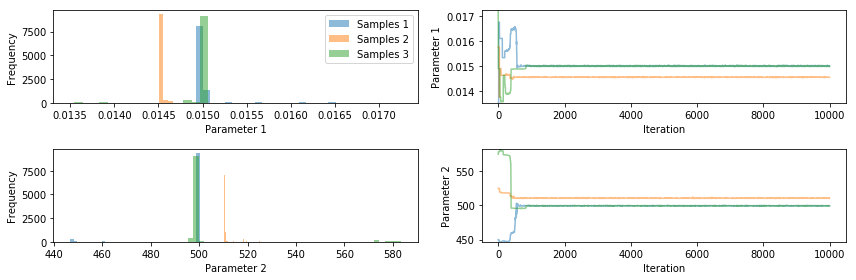

In [34]:
pints.plot.trace(chains_emu)
plt.show()

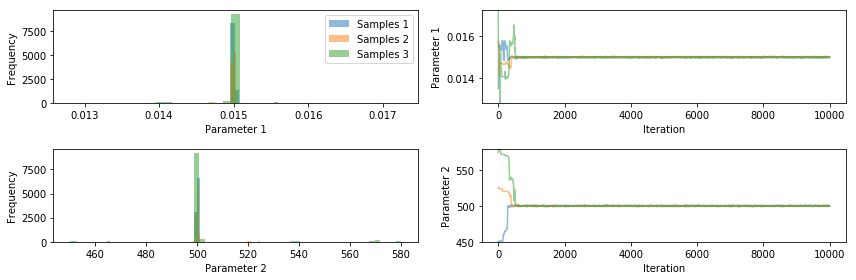

In [35]:
pints.plot.trace(chains)
plt.show()

In [36]:
chain_emu = chains_emu[0]
chain_emu = chain_emu[2000:]
chain = chains[0]
chain = chain[2000:]

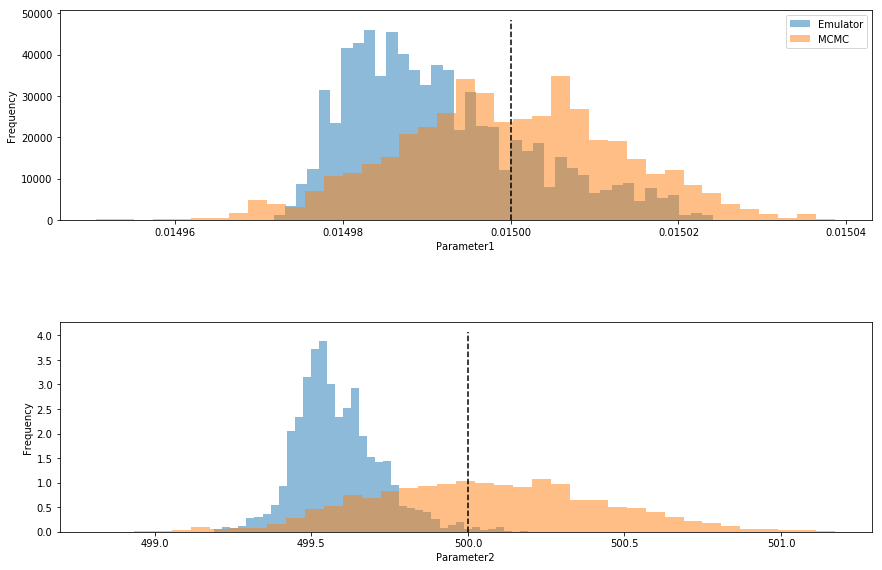

In [37]:
fig, axes = pints.plot.histogram([chain_emu, chain], ref_parameters=true_parameters, sample_names=["Emulator", "MCMC"])
fig.set_size_inches(14, 9)
plt.show()

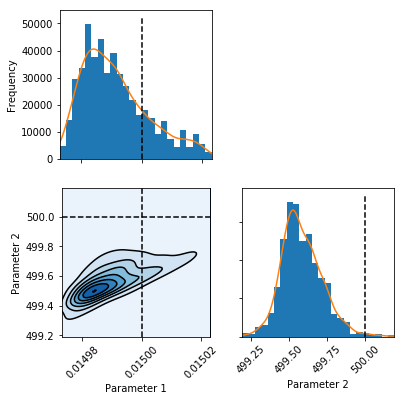

In [38]:
thinned_chain_emu = chain_emu[::10]
pints.plot.pairwise(thinned_chain_emu, kde=True, ref_parameters=true_parameters)
plt.show()

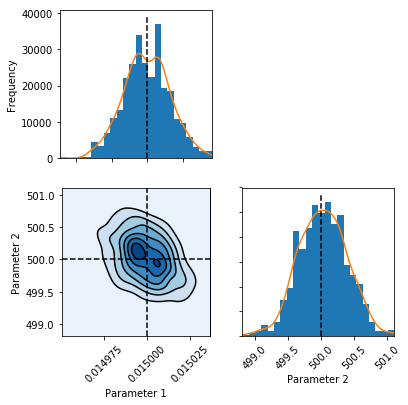

In [39]:
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

            r           k
0    0.014986  499.722294
1    0.014978  500.087913
2    0.014994  500.101559
3    0.015023  498.813899
4    0.015028  499.805307
..        ...         ...
795  0.014980  500.264936
796  0.015006  500.391591
797  0.015013  499.751644
798  0.015000  499.788163
799  0.014992  500.161116

[800 rows x 2 columns]


C:\Users\plagl\Anaconda3\lib\site-packages\seaborn\distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
C:\Users\plagl\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


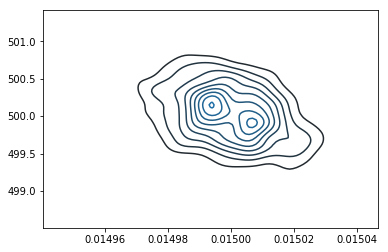

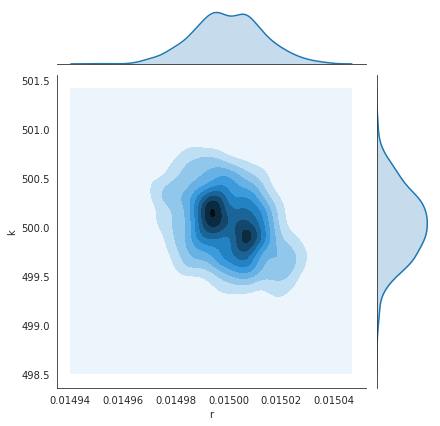

In [60]:
import seaborn as sns
import pandas as pd
data = pd.DataFrame({'r': thinned_chain[:, 0], 'k': thinned_chain[:, 1]})
print(data)
sns.kdeplot(data);
with sns.axes_style('white'):
    sns.jointplot(data['r'], data['k'], kind='kde');

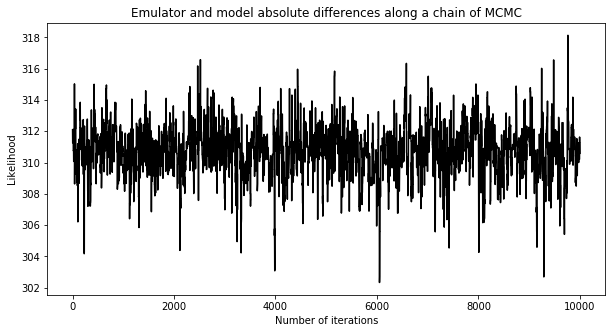

310.5859177115274

In [40]:
emu_prediction = np.apply_along_axis(emu, 1, chain_emu).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_prediction - emu_prediction)

iters = np.linspace(0, 10000, len(chain_emu))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

In [41]:
chain_emu

array([[1.49884634e-02, 4.99528805e+02],
       [1.49884634e-02, 4.99528805e+02],
       [1.49884634e-02, 4.99528805e+02],
       ...,
       [1.49831487e-02, 4.99434101e+02],
       [1.49831487e-02, 4.99434101e+02],
       [1.49831487e-02, 4.99434101e+02]])

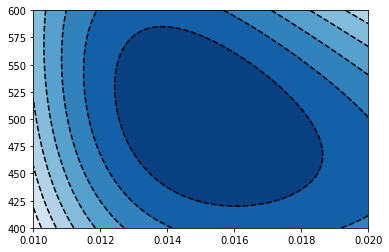

In [42]:
# Create grid
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
plt.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
plt.contour(xx, yy, ll, colors='k')
plt.show()

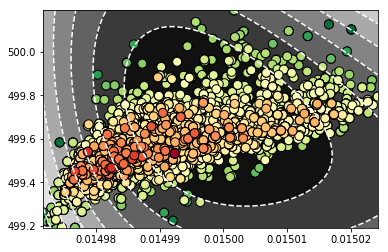

In [43]:
fig, ax = plt.subplots()                   

# Show density 
#ax.imshow(np.rot90(ll), cmap=plt.cm.Blues, extent=[xmin, xmax, ymin, ymax])                                                                     

# Plot chain_emu
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]

idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines
ax.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
plt.contour(xx, yy, ll, colors='w')

# Plot chain_emu
#ax.plot(x, y, 'k.', markersize=2)    
ax.set_xlim([xmin, xmax])                                                                           
ax.set_ylim([ymin, ymax])

ax.scatter(x_sorted, y_sorted, c=diffs_sorted, s=80, edgecolor='k', cmap="RdYlGn_r")
#fig.colorbar(ax)
plt.show()

Running...
Using Emulated Metropolis MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0         0         0          0:00.0
3     12     0         0         0          0:00.0
20    63     0.0476    0         0.0476     0:00.1
40    123    0.0244    0.0244    0.0244     0:00.2
60    183    0.0328    0.0164    0.0164     0:00.3
80    243    0.0247    0.0123    0.0123     0:00.4
100   303    0.0198    0.0099    0.0099     0:00.5
120   363    0.0165    0.00826   0.00826    0:00.6
140   423    0.0142    0.00709   0.00709    0:00.7
160   483    0.0186    0.00621   0.00621    0:00.8
180   543    0.0166    0.00552   0.00552    0:00.9
200   603    0.0149    0.00498   0.00498    0:01.0
220   663    0.0136    0.00452   0.00452    0:01.1
240   723    0.0124    0.00415   0.00415    0:01.2
260   783    0.0192    0.00383   0.00383  

3120  9363   0.00769   0.0016    0.00545    0:15.0
3140  9423   0.00764   0.00159   0.00541    0:15.1
3160  9483   0.00759   0.00158   0.00538    0:15.2
3180  9543   0.00754   0.00157   0.00534    0:15.3
3200  9603   0.0075    0.00156   0.00531    0:15.4
3220  9663   0.00745   0.00155   0.00559    0:15.5
3240  9723   0.00771   0.00154   0.00555    0:15.6
3260  9783   0.00767   0.00153   0.00552    0:15.7
3280  9843   0.00762   0.00152   0.00549    0:15.8
3300  9903   0.00757   0.00151   0.00545    0:15.9
3320  9963   0.00753   0.00151   0.00542    0:16.0
3340  10023  0.00748   0.0015    0.00539    0:16.1
3360  10083  0.00774   0.00149   0.00536    0:16.2
3380  10143  0.00799   0.00177   0.00532    0:16.3
3400  10203  0.00794   0.00176   0.00529    0:16.4
3420  10263  0.00789   0.00175   0.00526    0:16.5
3440  10323  0.00785   0.00174   0.00523    0:16.6
3460  10383  0.0078    0.00173   0.0052     0:16.7
3480  10443  0.00776   0.00172   0.00546    0:16.8
3500  10503  0.00771   0.00171 

6360  19083  0.0055    0.00204   0.00519    0:30.5
6380  19143  0.00564   0.00204   0.00517    0:30.6
6400  19203  0.00562   0.00203   0.00516    0:30.6
6420  19263  0.00561   0.00202   0.00514    0:30.7
6440  19323  0.00559   0.00202   0.00528    0:30.8
6460  19383  0.00557   0.00201   0.00526    0:30.9
6480  19443  0.00555   0.00201   0.00525    0:31.0
6500  19503  0.00569   0.002     0.00523    0:31.1
6520  19563  0.00567   0.00199   0.00521    0:31.2
6540  19623  0.00566   0.00199   0.0052     0:31.3
6560  19683  0.00564   0.00198   0.00518    0:31.4
6580  19743  0.00562   0.00198   0.00517    0:31.5
6600  19803  0.00561   0.00197   0.00515    0:31.6
6620  19863  0.00559   0.00196   0.00514    0:31.7
6640  19923  0.00557   0.00196   0.00512    0:31.8
6660  19983  0.00555   0.00195   0.0051     0:31.9
6680  20043  0.00554   0.00195   0.00509    0:32.0
6700  20103  0.00552   0.00194   0.00507    0:32.0
6720  20163  0.00551   0.00193   0.00506    0:32.1
6740  20223  0.00549   0.00208 

9580  28743  0.00501   0.00188   0.0048     0:45.6
9600  28803  0.005     0.00187   0.00479    0:45.7
9620  28863  0.00509   0.00187   0.00478    0:45.8
9640  28923  0.00508   0.00187   0.00477    0:45.9
9660  28983  0.00507   0.00186   0.00476    0:45.9
9680  29043  0.00506   0.00186   0.00475    0:46.0
9700  29103  0.00505   0.00186   0.00474    0:46.1
9720  29163  0.00504   0.00185   0.00473    0:46.2
9740  29223  0.00503   0.00185   0.00472    0:46.3
9760  29283  0.00502   0.00184   0.00471    0:46.4
9780  29343  0.00501   0.00194   0.0047     0:46.5
9800  29403  0.005     0.00194   0.00469    0:46.6
9820  29463  0.00499   0.00193   0.00468    0:46.7
9840  29523  0.00498   0.00193   0.00467    0:46.8
9860  29583  0.00497   0.00193   0.00466    0:46.9
9880  29643  0.00496   0.00192   0.00466    0:47.0
9900  29703  0.00495   0.00192   0.00465    0:47.1
9920  29763  0.00494   0.00192   0.00464    0:47.2
9940  29823  0.00493   0.00191   0.00463    0:47.3
9960  29883  0.00492   0.00191 

12840 38523  0.00397   0.00171   0.00436    1:01.1
12860 38583  0.00397   0.00171   0.00435    1:01.2
12880 38643  0.00396   0.00171   0.00435    1:01.3
12900 38703  0.00395   0.00171   0.00434    1:01.4
12920 38763  0.00395   0.0017    0.00433    1:01.5
12940 38823  0.00394   0.0017    0.00433    1:01.6
12960 38883  0.00393   0.0017    0.00432    1:01.7
12980 38943  0.00393   0.00169   0.00439    1:01.8
13000 39003  0.00392   0.00169   0.00438    1:01.9
13020 39063  0.00392   0.00169   0.00445    1:02.0
13040 39123  0.00391   0.00169   0.00445    1:02.1
13060 39183  0.0039    0.00168   0.00444    1:02.1
13080 39243  0.0039    0.00168   0.00443    1:02.2
13100 39303  0.00389   0.00168   0.00443    1:02.3
13120 39363  0.00389   0.00168   0.00442    1:02.4
13140 39423  0.00388   0.00167   0.00441    1:02.5
13160 39483  0.00388   0.00167   0.00441    1:02.6
13180 39543  0.00387   0.00167   0.0044     1:02.7
13200 39603  0.00386   0.00167   0.00439    1:02.8
13220 39663  0.00386   0.00166 

16060 48183  0.00318   0.00143   0.00386    1:16.5
16080 48243  0.00317   0.00143   0.00386    1:16.6
16100 48303  0.00317   0.00143   0.00385    1:16.7
16120 48363  0.00316   0.00143   0.00385    1:16.8
16140 48423  0.00316   0.00142   0.00384    1:16.9
16160 48483  0.00316   0.00142   0.0039     1:17.0
16180 48543  0.00315   0.00142   0.00389    1:17.1
16200 48603  0.00315   0.00142   0.00389    1:17.2
16220 48663  0.00314   0.00142   0.00388    1:17.3
16240 48723  0.00314   0.00142   0.00388    1:17.4
16260 48783  0.00314   0.00141   0.00387    1:17.5
16280 48843  0.00313   0.00141   0.00387    1:17.5
16300 48903  0.00313   0.00141   0.00386    1:17.6
16320 48963  0.00312   0.00141   0.00386    1:17.7
16340 49023  0.00312   0.00141   0.00386    1:17.8
16360 49083  0.00312   0.00141   0.00385    1:17.9
16380 49143  0.00311   0.0014    0.00385    1:18.0
16400 49203  0.00311   0.0014    0.00384    1:18.1
16420 49263  0.00311   0.0014    0.00384    1:18.2
16440 49323  0.0031    0.0014  

19280 57843  0.0027    0.00119   0.00327    1:32.0
19300 57903  0.00269   0.00119   0.00326    1:32.1
19320 57963  0.00269   0.00119   0.00326    1:32.2
19340 58023  0.00269   0.00119   0.00326    1:32.3
19360 58083  0.00269   0.00119   0.00325    1:32.4
19380 58143  0.00268   0.00119   0.00325    1:32.5
19400 58203  0.00268   0.00119   0.00325    1:32.6
19420 58263  0.00268   0.00118   0.00324    1:32.7
19440 58323  0.00267   0.00118   0.00324    1:32.8
19460 58383  0.00267   0.00118   0.00324    1:32.9
19480 58443  0.00267   0.00118   0.00323    1:33.0
19500 58503  0.00267   0.00118   0.00323    1:33.1
19520 58563  0.00266   0.00118   0.00323    1:33.2
19540 58623  0.00266   0.00118   0.00322    1:33.2
19560 58683  0.00266   0.00118   0.00322    1:33.3
19580 58743  0.00266   0.00117   0.00322    1:33.4
19600 58803  0.00265   0.00117   0.00321    1:33.5
19620 58863  0.00265   0.00117   0.00321    1:33.6
19640 58923  0.00265   0.00117   0.00321    1:33.7
19660 58983  0.00264   0.00117 

22500 67503  0.00231   0.00102   0.0028     1:47.6
22520 67563  0.00231   0.00102   0.0028     1:47.7
22540 67623  0.00231   0.00102   0.00279    1:47.8
22560 67683  0.0023    0.00102   0.00279    1:47.9
22580 67743  0.0023    0.00102   0.00279    1:48.0
22600 67803  0.0023    0.00102   0.00279    1:48.1
22620 67863  0.0023    0.00102   0.00279    1:48.2
22640 67923  0.0023    0.00102   0.00278    1:48.3
22660 67983  0.00229   0.00101   0.00278    1:48.4
22680 68043  0.00229   0.00101   0.00278    1:48.5
22700 68103  0.00229   0.00101   0.00278    1:48.6
22720 68163  0.00229   0.00101   0.00277    1:48.7
22740 68223  0.00229   0.00101   0.00277    1:48.8
22760 68283  0.00228   0.00101   0.00277    1:48.9
22780 68343  0.00228   0.00101   0.00277    1:49.0
22800 68403  0.00228   0.00101   0.00276    1:49.1
22820 68463  0.00228   0.00101   0.00276    1:49.2
22840 68523  0.00228   0.00101   0.00276    1:49.4
22860 68583  0.00227   0.00101   0.00276    1:49.5
22880 68643  0.00227   0.00101 

25740 77223  0.00202   0.000894  0.00245    2:03.8
25760 77283  0.00202   0.000893  0.00245    2:03.9
25780 77343  0.00202   0.000892  0.00244    2:04.0
25800 77403  0.00202   0.000891  0.00244    2:04.1
25820 77463  0.00201   0.000891  0.00244    2:04.2
25840 77523  0.00201   0.00089   0.00244    2:04.3
25860 77583  0.00201   0.000889  0.00244    2:04.4
25880 77643  0.00201   0.000889  0.00243    2:04.5
25900 77703  0.00201   0.000888  0.00243    2:04.6
25920 77763  0.00201   0.000887  0.00243    2:04.7
25940 77823  0.002     0.000887  0.00243    2:04.8
25960 77883  0.002     0.000886  0.00243    2:04.9
25980 77943  0.002     0.000885  0.00242    2:05.0
26000 78003  0.002     0.000885  0.00242    2:05.1
26020 78063  0.002     0.000884  0.00242    2:05.2
26040 78123  0.002     0.000883  0.00242    2:05.3
26060 78183  0.002     0.000883  0.00242    2:05.4
26080 78243  0.00199   0.000882  0.00242    2:05.5
26100 78303  0.00199   0.000881  0.00241    2:05.6
26120 78363  0.00199   0.000881

28960 86883  0.0018    0.000794  0.00218    2:19.7
28980 86943  0.00179   0.000794  0.00217    2:19.8
29000 87003  0.00179   0.000793  0.00217    2:19.9
29020 87063  0.00179   0.000793  0.00217    2:20.0
29040 87123  0.00179   0.000792  0.00217    2:20.1
29060 87183  0.00179   0.000791  0.00217    2:20.2
29080 87243  0.00179   0.000791  0.00217    2:20.3
29100 87303  0.00179   0.00079   0.00216    2:20.4
29120 87363  0.00179   0.00079   0.00216    2:20.5
29140 87423  0.00178   0.000789  0.00216    2:20.6
29160 87483  0.00178   0.000789  0.00216    2:20.7
29180 87543  0.00178   0.000788  0.00216    2:20.8
29200 87603  0.00178   0.000788  0.00216    2:20.8
29220 87663  0.00178   0.000787  0.00216    2:21.0
29240 87723  0.00178   0.000787  0.00215    2:21.1
29260 87783  0.00178   0.000786  0.00215    2:21.2
29280 87843  0.00178   0.000785  0.00215    2:21.3
29300 87903  0.00177   0.000785  0.00215    2:21.4
29320 87963  0.00177   0.000784  0.00215    2:21.5
29340 88023  0.00177   0.000784

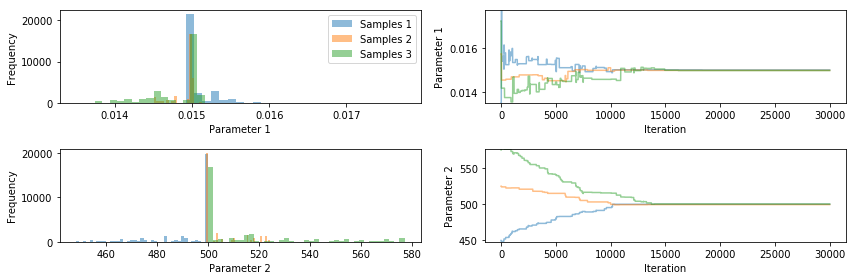

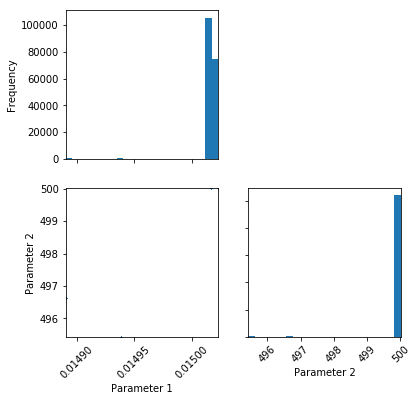

In [44]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05, #1.1
    np.array(true_parameters) * 1.15,
]
# Choose a covariance matrix for the proposal step
sigma0 = np.abs(true_parameters) * 5e-4

# Create mcmc routine
mcmc = pints.MCMCController(emu, 3, x0s, sigma0=sigma0, method=pints.EmulatedMetropolisMCMC, f=log_posterior)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
emulated_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(emulated_chains)

# Discard warm up
emulated_chains_thinned = emulated_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(emulated_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(emulated_chains_thinned[0])

# Show graphs
plt.show()

Running...
Using Emulated adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0         0         0          0:00.0
3     12     0         0         0          0:00.0
20    63     0         0         0          0:00.1
40    123    0         0         0          0:00.2
60    183    0         0         0          0:00.2
80    243    0         0         0          0:00.3
100   303    0         0         0          0:00.4
120   363    0         0         0          0:00.4
140   423    0         0         0          0:00.5
160   483    0         0         0          0:00.6
180   543    0         0         0          0:00.6
Initial phase completed.
200   603    0         0         0          0:00.7
220   663    0         0         0          0:00.8
240   723    0         0         0          0:00.9
260   78

c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


420   1263   0         0         0          0:01.5
440   1323   0         0         0          0:01.6
460   1383   0         0         0          0:01.7


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\p

480   1443   0         0         0          0:01.8
500   1503   0         0         0          0:01.9
520   1563   0         0         0          0:01.9


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


540   1623   0         0         0          0:02.0
560   1683   0         0         0          0:02.1
580   1743   0         0         0          0:02.2


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


600   1803   0         0         0          0:02.3
620   1863   0         0         0          0:02.3
640   1923   0         0         0          0:02.4


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


660   1983   0         0         0          0:02.5
680   2043   0         0         0          0:02.6
700   2103   0         0         0          0:02.6


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


720   2163   0         0         0          0:02.7
740   2223   0         0         0          0:02.8
760   2283   0         0         0          0:02.9


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


780   2343   0         0         0          0:03.0
800   2403   0         0         0          0:03.1
820   2463   0         0         0          0:03.1
840   2523   0         0         0          0:03.2
860   2583   0         0         0          0:03.3
880   2643   0         0         0          0:03.4
900   2703   0         0         0          0:03.5
920   2763   0         0         0          0:03.5
940   2823   0         0         0          0:03.6
960   2883   0         0         0          0:03.7
980   2943   0         0         0          0:03.8
1000  3003   0         0         0          0:03.9


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


1020  3063   0         0         0          0:04.0
1040  3123   0         0         0          0:04.0
1060  3183   0         0         0          0:04.1
1080  3243   0         0         0          0:04.2
1100  3303   0         0         0          0:04.2
1120  3363   0         0         0          0:04.3
1140  3423   0         0         0          0:04.4
1160  3483   0         0         0          0:04.5
1180  3543   0         0         0          0:04.5
1200  3603   0         0         0          0:04.6
1220  3663   0         0         0          0:04.7
1240  3723   0         0         0          0:04.7


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


1260  3783   0         0         0          0:04.8
1280  3843   0         0         0          0:04.9
1300  3903   0         0         0          0:05.0
1320  3963   0         0         0          0:05.0
1340  4023   0         0         0          0:05.1
1360  4083   0         0         0          0:05.2
1380  4143   0         0         0          0:05.3
1400  4203   0         0         0          0:05.3
1420  4263   0         0         0          0:05.4
1440  4323   0         0         0          0:05.5
1460  4383   0         0         0          0:05.6
1480  4443   0         0         0          0:05.6


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


1500  4503   0         0         0          0:05.7
1520  4563   0         0         0          0:05.8
1540  4623   0         0         0          0:05.9


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


1560  4683   0         0         0          0:05.9
1580  4743   0         0         0          0:06.0
1600  4803   0         0         0          0:06.1
1620  4863   0         0         0          0:06.2
1640  4923   0         0         0          0:06.2
1660  4983   0         0         0          0:06.3
1680  5043   0         0         0          0:06.4
1700  5103   0         0         0          0:06.5
1720  5163   0         0         0          0:06.5


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


1740  5223   0         0         0          0:06.6
1760  5283   0         0         0          0:06.7
1780  5343   0         0         0          0:06.7
1800  5403   0         0         0          0:06.8
1820  5463   0         0         0          0:06.9
1840  5523   0         0         0          0:07.0


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


1860  5583   0         0         0          0:07.0
1880  5643   0         0         0          0:07.1
1900  5703   0         0         0          0:07.2


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


1920  5763   0         0         0          0:07.3
1940  5823   0         0         0          0:07.4
1960  5883   0         0         0          0:07.4
1980  5943   0         0         0          0:07.5
2000  6003   0         0         0          0:07.6
2020  6063   0         0         0          0:07.7


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


2040  6123   0         0         0          0:07.8
2060  6183   0         0         0          0:07.8
2080  6243   0         0         0          0:07.9
2100  6303   0         0         0          0:08.0
2120  6363   0         0         0          0:08.1
2140  6423   0         0         0          0:08.1
2160  6483   0         0         0          0:08.2
2180  6543   0         0         0          0:08.3
2200  6603   0         0         0          0:08.4


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


2220  6663   0         0         0          0:08.4
2240  6723   0         0         0          0:08.5
2260  6783   0         0         0          0:08.6


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


2280  6843   0         0         0          0:08.7
2300  6903   0         0         0          0:08.8
2320  6963   0         0         0          0:08.8
2340  7023   0         0         0          0:08.9
2360  7083   0         0         0          0:09.0
2380  7143   0         0         0          0:09.1


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


2400  7203   0         0         0          0:09.2
2420  7263   0         0         0          0:09.3
2440  7323   0         0         0          0:09.4


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


2460  7383   0         0         0          0:09.4
2480  7443   0         0         0          0:09.5
2500  7503   0         0         0          0:09.6
2520  7563   0         0         0          0:09.7
2540  7623   0         0         0          0:09.7
2560  7683   0         0         0          0:09.8


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


2580  7743   0         0         0          0:09.9
2600  7803   0         0         0          0:10.0
2620  7863   0         0         0          0:10.0
2640  7923   0         0         0          0:10.1
2660  7983   0         0         0          0:10.2
2680  8043   0         0         0          0:10.2
2700  8103   0         0         0          0:10.3
2720  8163   0         0         0          0:10.4
2740  8223   0         0         0          0:10.5
2760  8283   0         0         0          0:10.5
2780  8343   0         0         0          0:10.6
2800  8403   0         0         0          0:10.7
2820  8463   0         0         0          0:10.7
2840  8523   0         0         0          0:10.8
2860  8583   0         0         0          0:10.9
2880  8643   0         0         0          0:11.0
2900  8703   0         0         0          0:11.0
2920  8763   0         0         0          0:11.1
2940  8823   0         0         0          0:11.2
2960  8883   0         0       

c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


3180  9543   0         0         0          0:12.0
3200  9603   0         0         0          0:12.1
3220  9663   0         0         0          0:12.2
3240  9723   0         0         0          0:12.3
3260  9783   0         0         0          0:12.3
3280  9843   0         0         0          0:12.4


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


3300  9903   0         0         0          0:12.5
3320  9963   0         0         0          0:12.6
3340  10023  0         0         0          0:12.6
3360  10083  0         0         0          0:12.7
3380  10143  0         0         0          0:12.8
3400  10203  0         0         0          0:12.8
3420  10263  0         0         0          0:12.9
3440  10323  0         0         0          0:13.0
3460  10383  0         0         0          0:13.1


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


3480  10443  0         0         0          0:13.1
3500  10503  0         0         0          0:13.2
3520  10563  0         0         0          0:13.3
3540  10623  0         0         0          0:13.3
3560  10683  0         0         0          0:13.4
3580  10743  0         0         0          0:13.5
3600  10803  0         0         0          0:13.6
3620  10863  0         0         0          0:13.6
3640  10923  0         0         0          0:13.7
3660  10983  0         0         0          0:13.8
3680  11043  0         0         0          0:13.9
3700  11103  0         0         0          0:13.9


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


3720  11163  0         0         0          0:14.0
3740  11223  0         0         0          0:14.1
3760  11283  0         0         0          0:14.2
3780  11343  0         0         0          0:14.2
3800  11403  0         0         0          0:14.3
3820  11463  0         0         0          0:14.4
3840  11523  0         0         0          0:14.4
3860  11583  0         0         0          0:14.5
3880  11643  0         0         0          0:14.6


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


3900  11703  0         0         0          0:14.7
3920  11763  0         0         0          0:14.7
3940  11823  0         0         0          0:14.8
3960  11883  0         0         0          0:14.9
3980  11943  0         0         0          0:15.0
4000  12003  0         0         0          0:15.0
4020  12063  0         0         0          0:15.1
4040  12123  0         0         0          0:15.2
4060  12183  0         0         0          0:15.3
4080  12243  0         0         0          0:15.3
4100  12303  0         0         0          0:15.4
4120  12363  0         0         0          0:15.5
4140  12423  0         0         0          0:15.6
4160  12483  0         0         0          0:15.6
4180  12543  0         0         0          0:15.7
4200  12603  0         0         0          0:15.8
4220  12663  0         0         0          0:15.9
4240  12723  0         0         0          0:16.0
4260  12783  0         0         0          0:16.0
4280  12843  0         0       

c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


4320  12963  0         0         0          0:16.3
4340  13023  0         0         0          0:16.3
4360  13083  0         0         0          0:16.4
4380  13143  0         0         0          0:16.5
4400  13203  0         0         0          0:16.6
4420  13263  0         0         0          0:16.6
4440  13323  0         0         0          0:16.7
4460  13383  0         0         0          0:16.8
4480  13443  0         0         0          0:16.8
4500  13503  0         0         0          0:16.9


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


4520  13563  0         0         0          0:17.0
4540  13623  0         0         0          0:17.0
4560  13683  0         0         0          0:17.1
4580  13743  0         0         0          0:17.2
4600  13803  0         0         0          0:17.2
4620  13863  0         0         0          0:17.3


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


4640  13923  0         0         0          0:17.4
4660  13983  0         0         0          0:17.5
4680  14043  0         0         0          0:17.5
4700  14103  0         0         0          0:17.6
4720  14163  0         0         0          0:17.7
4740  14223  0         0         0          0:17.7


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


4760  14283  0         0         0          0:17.8
4780  14343  0         0         0          0:17.9
4800  14403  0         0         0          0:18.0
4820  14463  0         0         0          0:18.1
4840  14523  0         0         0          0:18.2
4860  14583  0         0         0          0:18.3
4880  14643  0         0         0          0:18.4
4900  14703  0         0         0          0:18.4


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


4920  14763  0         0         0          0:18.5
4940  14823  0         0         0          0:18.6
4960  14883  0         0         0          0:18.7
4980  14943  0         0         0          0:18.7
5000  15003  0         0         0          0:18.8
5020  15063  0         0         0          0:18.9


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


5040  15123  0         0         0          0:19.0
5060  15183  0         0         0          0:19.1
5080  15243  0         0         0          0:19.1
5100  15303  0         0         0          0:19.2
5120  15363  0         0         0          0:19.3
5140  15423  0         0         0          0:19.4


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


5160  15483  0         0         0          0:19.4
5180  15543  0         0         0          0:19.5
5200  15603  0         0         0          0:19.6
5220  15663  0         0         0          0:19.7
5240  15723  0         0         0          0:19.7
5260  15783  0         0         0          0:19.8


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


5280  15843  0         0         0          0:19.9
5300  15903  0         0         0          0:20.0
5320  15963  0         0         0          0:20.0
5340  16023  0         0         0          0:20.1
5360  16083  0         0         0          0:20.2
5380  16143  0         0         0          0:20.3


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


5400  16203  0         0         0          0:20.3
5420  16263  0         0         0          0:20.4
5440  16323  0         0         0          0:20.5
5460  16383  0         0         0          0:20.6
5480  16443  0         0         0          0:20.6
5500  16503  0         0         0          0:20.7


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


5520  16563  0         0         0          0:20.8
5540  16623  0         0         0          0:20.8
5560  16683  0         0         0          0:20.9


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


5580  16743  0         0         0          0:21.0
5600  16803  0         0         0          0:21.1
5620  16863  0         0         0          0:21.1
5640  16923  0         0         0          0:21.2
5660  16983  0         0         0          0:21.3
5680  17043  0         0         0          0:21.3


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


5700  17103  0         0         0          0:21.4
5720  17163  0         0         0          0:21.5
5740  17223  0         0         0          0:21.6
5760  17283  0         0         0          0:21.6
5780  17343  0         0         0          0:21.7
5800  17403  0         0         0          0:21.8
5820  17463  0         0         0          0:21.9
5840  17523  0         0         0          0:21.9
5860  17583  0         0         0          0:22.0
5880  17643  0         0         0          0:22.1
5900  17703  0         0         0          0:22.2
5920  17763  0         0         0          0:22.2
5940  17823  0         0         0          0:22.3
5960  17883  0         0         0          0:22.4
5980  17943  0         0         0          0:22.5


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


6000  18003  0         0         0          0:22.6
6020  18063  0         0         0          0:22.7
6040  18123  0         0         0          0:22.7
6060  18183  0         0         0          0:22.8
6080  18243  0         0         0          0:22.9
6100  18303  0         0         0          0:23.0


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


6120  18363  0         0         0          0:23.1
6140  18423  0         0         0          0:23.1
6160  18483  0         0         0          0:23.2


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


6180  18543  0         0         0          0:23.3
6200  18603  0         0         0          0:23.4
6220  18663  0         0         0          0:23.4


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


6240  18723  0         0         0          0:23.5
6260  18783  0         0         0          0:23.6
6280  18843  0         0         0          0:23.7
6300  18903  0         0         0          0:23.8
6320  18963  0         0         0          0:23.8
6340  19023  0         0         0          0:23.9
6360  19083  0         0         0          0:24.0
6380  19143  0         0         0          0:24.1
6400  19203  0         0         0          0:24.1


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


6420  19263  0         0         0          0:24.2
6440  19323  0         0         0          0:24.3
6460  19383  0         0         0          0:24.4
6480  19443  0         0         0          0:24.4
6500  19503  0         0         0          0:24.5
6520  19563  0         0         0          0:24.6


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


6540  19623  0         0         0          0:24.7
6560  19683  0         0         0          0:24.8
6580  19743  0         0         0          0:24.8
6600  19803  0         0         0          0:24.9
6620  19863  0         0         0          0:25.0
6640  19923  0         0         0          0:25.1
6660  19983  0         0         0          0:25.2
6680  20043  0         0         0          0:25.3
6700  20103  0         0         0          0:25.3
6720  20163  0         0         0          0:25.4
6740  20223  0         0         0          0:25.5
6760  20283  0         0         0          0:25.6
6780  20343  0         0         0          0:25.7
6800  20403  0         0         0          0:25.8
6820  20463  0         0         0          0:25.8
6840  20523  0         0         0          0:25.9
6860  20583  0         0         0          0:26.0
6880  20643  0         0         0          0:26.0
6900  20703  0         0         0          0:26.1
6920  20763  0         0       

c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


6960  20883  0         0         0          0:26.3
6980  20943  0         0         0          0:26.4
7000  21003  0         0         0          0:26.5
7020  21063  0         0         0          0:26.5
7040  21123  0         0         0          0:26.6
7060  21183  0         0         0          0:26.7
7080  21243  0         0         0          0:26.8
7100  21303  0         0         0          0:26.9
7120  21363  0         0         0          0:26.9
7140  21423  0         0         0          0:27.0
7160  21483  0         0         0          0:27.1
7180  21543  0         0         0          0:27.1


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


7200  21603  0         0         0          0:27.2
7220  21663  0         0         0          0:27.3
7240  21723  0         0         0          0:27.4


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


7260  21783  0         0         0          0:27.5
7280  21843  0         0         0          0:27.6
7300  21903  0         0         0          0:27.6


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


7320  21963  0         0         0          0:27.7
7340  22023  0         0         0          0:27.8
7360  22083  0         0         0          0:27.9
7380  22143  0         0         0          0:27.9
7400  22203  0         0         0          0:28.0
7420  22263  0         0         0          0:28.1


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


7440  22323  0         0         0          0:28.2
7460  22383  0         0         0          0:28.2
7480  22443  0         0         0          0:28.3
7500  22503  0         0         0          0:28.4
7520  22563  0         0         0          0:28.5
7540  22623  0         0         0          0:28.5
7560  22683  0         0         0          0:28.6
7580  22743  0         0         0          0:28.7
7600  22803  0         0         0          0:28.8
7620  22863  0         0         0          0:28.9
7640  22923  0         0         0          0:28.9
7660  22983  0         0         0          0:29.0


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


7680  23043  0         0         0          0:29.1
7700  23103  0         0         0          0:29.2
7720  23163  0         0         0          0:29.3
7740  23223  0         0         0          0:29.3
7760  23283  0         0         0          0:29.4
7780  23343  0         0         0          0:29.5
7800  23403  0         0         0          0:29.6
7820  23463  0         0         0          0:29.7
7840  23523  0         0         0          0:29.7
7860  23583  0         0         0          0:29.8
7880  23643  0         0         0          0:29.9
7900  23703  0         0         0          0:30.0


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


7920  23763  0         0         0          0:30.0
7940  23823  0         0         0          0:30.1
7960  23883  0         0         0          0:30.2
7980  23943  0         0         0          0:30.3
8000  24003  0         0         0          0:30.3
8020  24063  0         0         0          0:30.4
8040  24123  0         0         0          0:30.5
8060  24183  0         0         0          0:30.6
8080  24243  0         0         0          0:30.6


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


8100  24303  0         0         0          0:30.7
8120  24363  0         0         0          0:30.8
8140  24423  0         0         0          0:30.9


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


8160  24483  0         0         0          0:31.0
8180  24543  0         0         0          0:31.0
8200  24603  0         0         0          0:31.1


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


8220  24663  0         0         0          0:31.2
8240  24723  0         0         0          0:31.3
8260  24783  0         0         0          0:31.3


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


8280  24843  0         0         0          0:31.4
8300  24903  0         0         0          0:31.5
8320  24963  0         0         0          0:31.5


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


8340  25023  0         0         0          0:31.6
8360  25083  0         0         0          0:31.7
8380  25143  0         0         0          0:31.8
8400  25203  0         0         0          0:31.9
8420  25263  0         0         0          0:32.0
8440  25323  0         0         0          0:32.1


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


8460  25383  0         0         0          0:32.2
8480  25443  0         0         0          0:32.3
8500  25503  0         0         0          0:32.4


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


8520  25563  0         0         0          0:32.5
8540  25623  0         0         0          0:32.6
8560  25683  0         0         0          0:32.7
8580  25743  0         0         0          0:32.8
8600  25803  0         0         0          0:32.9
8620  25863  0         0         0          0:33.0
8640  25923  0         0         0          0:33.1
8660  25983  0         0         0          0:33.2


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


8680  26043  0         0         0          0:33.3
8700  26103  0         0         0          0:33.4
8720  26163  0         0         0          0:33.5


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


8740  26223  0         0         0          0:33.6
8760  26283  0         0         0          0:33.7
8780  26343  0         0         0          0:33.8
8800  26403  0         0         0          0:33.9
8820  26463  0         0         0          0:34.0
8840  26523  0         0         0          0:34.1
8860  26583  0         0         0          0:34.1
8880  26643  0         0         0          0:34.2
8900  26703  0         0         0          0:34.3
8920  26763  0         0         0          0:34.3
8940  26823  0         0         0          0:34.4
8960  26883  0         0         0          0:34.5
8980  26943  0         0         0          0:34.5
9000  27003  0         0         0          0:34.6
9020  27063  0         0         0          0:34.7
9040  27123  0         0         0          0:34.8
9060  27183  0         0         0          0:34.9
9080  27243  0         0         0          0:35.0
9100  27303  0         0         0          0:35.1
9120  27363  0         0       

c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


9160  27483  0         0         0          0:35.4
9180  27543  0         0         0          0:35.5
9200  27603  0         0         0          0:35.5
9220  27663  0         0         0          0:35.6
9240  27723  0         0         0          0:35.7
9260  27783  0         0         0          0:35.7
9280  27843  0         0         0          0:35.8
9300  27903  0         0         0          0:35.9
9320  27963  0         0         0          0:36.0
9340  28023  0         0         0          0:36.1
9360  28083  0         0         0          0:36.1
9380  28143  0         0         0          0:36.2
9400  28203  0         0         0          0:36.3
9420  28263  0         0         0          0:36.3
9440  28323  0         0         0          0:36.4
9460  28383  0         0         0          0:36.5
9480  28443  0         0         0          0:36.5
9500  28503  0         0         0          0:36.6
9520  28563  0         0         0          0:36.6
9540  28623  0         0       

c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


9620  28863  0         0         0          0:37.0
9640  28923  0         0         0          0:37.1
9660  28983  0         0         0          0:37.1
9680  29043  0         0         0          0:37.2
9700  29103  0         0         0          0:37.2
9720  29163  0         0         0          0:37.3
9740  29223  0         0         0          0:37.4
9760  29283  0         0         0          0:37.4
9780  29343  0         0         0          0:37.5
9800  29403  0         0         0          0:37.6
9820  29463  0         0         0          0:37.6
9840  29523  0         0         0          0:37.7
9860  29583  0         0         0          0:37.7
9880  29643  0         0         0          0:37.8


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


9900  29703  0         0         0          0:37.9
9920  29763  0         0         0          0:38.0
9940  29823  0         0         0          0:38.0
9960  29883  0         0         0          0:38.1
9980  29943  0         0         0          0:38.2
10000 30003  0         0         0          0:38.2


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


10020 30063  0         0         0          0:38.3
10040 30123  0         0         0          0:38.4
10060 30183  0         0         0          0:38.4
10080 30243  0         0         0          0:38.5
10100 30303  0         0         0          0:38.5
10120 30363  0         0         0          0:38.6
10140 30423  0         0         0          0:38.7
10160 30483  0         0         0          0:38.7
10180 30543  0         0         0          0:38.8
10200 30603  0         0         0          0:38.9
10220 30663  0         0         0          0:38.9
10240 30723  0         0         0          0:39.0


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


10260 30783  0         0         0          0:39.0
10280 30843  0         0         0          0:39.1
10300 30903  0         0         0          0:39.2
10320 30963  0         0         0          0:39.2
10340 31023  0         0         0          0:39.3
10360 31083  0         0         0          0:39.4


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


10380 31143  0         0         0          0:39.4
10400 31203  0         0         0          0:39.5
10420 31263  0         0         0          0:39.6
10440 31323  0         0         0          0:39.6
10460 31383  0         0         0          0:39.7
10480 31443  0         0         0          0:39.7
10500 31503  0         0         0          0:39.8
10520 31563  0         0         0          0:39.9
10540 31623  0         0         0          0:39.9
10560 31683  0         0         0          0:40.0
10580 31743  0         0         0          0:40.1
10600 31803  0         0         0          0:40.1
10620 31863  0         0         0          0:40.2
10640 31923  0         0         0          0:40.3
10660 31983  0         0         0          0:40.3
10680 32043  0         0         0          0:40.4
10700 32103  0         0         0          0:40.4
10720 32163  0         0         0          0:40.5
10740 32223  0         0         0          0:40.6
10760 32283  0         0       

c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


11000 33003  0         0         0          0:41.4
11020 33063  0         0         0          0:41.4
11040 33123  0         0         0          0:41.5
11060 33183  0         0         0          0:41.6
11080 33243  0         0         0          0:41.6
11100 33303  0         0         0          0:41.7
11120 33363  0         0         0          0:41.8
11140 33423  0         0         0          0:41.8
11160 33483  0         0         0          0:41.9
11180 33543  0         0         0          0:42.0
11200 33603  0         0         0          0:42.0
11220 33663  0         0         0          0:42.1
11240 33723  0         0         0          0:42.1
11260 33783  0         0         0          0:42.2
11280 33843  0         0         0          0:42.3
11300 33903  0         0         0          0:42.3


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


11320 33963  0         0         0          0:42.4
11340 34023  0         0         0          0:42.5
11360 34083  0         0         0          0:42.5
11380 34143  0         0         0          0:42.6
11400 34203  0         0         0          0:42.7
11420 34263  0         0         0          0:42.7
11440 34323  0         0         0          0:42.8
11460 34383  0         0         0          0:42.9
11480 34443  0         0         0          0:42.9


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


11500 34503  0         0         0          0:43.0
11520 34563  0         0         0          0:43.1
11540 34623  0         0         0          0:43.1


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


11560 34683  0         0         0          0:43.2
11580 34743  0         0         0          0:43.2
11600 34803  0         0         0          0:43.3
11620 34863  0         0         0          0:43.4
11640 34923  0         0         0          0:43.4
11660 34983  0         0         0          0:43.5


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


11680 35043  0         0         0          0:43.6
11700 35103  0         0         0          0:43.6
11720 35163  0         0         0          0:43.7
11740 35223  0         0         0          0:43.8
11760 35283  0         0         0          0:43.8
11780 35343  0         0         0          0:43.9
11800 35403  0         0         0          0:44.0
11820 35463  0         0         0          0:44.0
11840 35523  0         0         0          0:44.1
11860 35583  0         0         0          0:44.1
11880 35643  0         0         0          0:44.2
11900 35703  0         0         0          0:44.3
11920 35763  0         0         0          0:44.3
11940 35823  0         0         0          0:44.4
11960 35883  0         0         0          0:44.5


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


11980 35943  0         0         0          0:44.5
12000 36003  0         0         0          0:44.6
12020 36063  0         0         0          0:44.7
12040 36123  0         0         0          0:44.7
12060 36183  0         0         0          0:44.8
12080 36243  0         0         0          0:44.8
12100 36303  0         0         0          0:44.9
12120 36363  0         0         0          0:45.0
12140 36423  0         0         0          0:45.0
12160 36483  0         0         0          0:45.1


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


12180 36543  0         0         0          0:45.2
12200 36603  0         0         0          0:45.2
12220 36663  0         0         0          0:45.3
12240 36723  0         0         0          0:45.4
12260 36783  0         0         0          0:45.4
12280 36843  0         0         0          0:45.5
12300 36903  0         0         0          0:45.6
12320 36963  0         0         0          0:45.6
12340 37023  0         0         0          0:45.7


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


12360 37083  0         0         0          0:45.7
12380 37143  0         0         0          0:45.8
12400 37203  0         0         0          0:45.9
12420 37263  0         0         0          0:45.9
12440 37323  0         0         0          0:46.0
12460 37383  0         0         0          0:46.1
12480 37443  0         0         0          0:46.2
12500 37503  0         0         0          0:46.2


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


12520 37563  0         0         0          0:46.3
12540 37623  0         0         0          0:46.3
12560 37683  0         0         0          0:46.4
12580 37743  0         0         0          0:46.5
12600 37803  0         0         0          0:46.5
12620 37863  0         0         0          0:46.6


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


12640 37923  0         0         0          0:46.7
12660 37983  0         0         0          0:46.7
12680 38043  0         0         0          0:46.8
12700 38103  0         0         0          0:46.9
12720 38163  0         0         0          0:46.9
12740 38223  0         0         0          0:47.0


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


12760 38283  0         0         0          0:47.1
12780 38343  0         0         0          0:47.1
12800 38403  0         0         0          0:47.2


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


12820 38463  0         0         0          0:47.3
12840 38523  0         0         0          0:47.3
12860 38583  0         0         0          0:47.4
12880 38643  0         0         0          0:47.5
12900 38703  0         0         0          0:47.5
12920 38763  0         0         0          0:47.6
12940 38823  0         0         0          0:47.7
12960 38883  0         0         0          0:47.7
12980 38943  0         0         0          0:47.8


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


13000 39003  0         0         0          0:47.9
13020 39063  0         0         0          0:47.9
13040 39123  0         0         0          0:48.0
13060 39183  0         0         0          0:48.1
13080 39243  0         0         0          0:48.1
13100 39303  0         0         0          0:48.2
13120 39363  0         0         0          0:48.3


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


13140 39423  0         0         0          0:48.3
13160 39483  0         0         0          0:48.4
13180 39543  0         0         0          0:48.5
13200 39603  0         0         0          0:48.5
13220 39663  0         0         0          0:48.6
13240 39723  0         0         0          0:48.7


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


13260 39783  0         0         0          0:48.7
13280 39843  0         0         0          0:48.8
13300 39903  0         0         0          0:48.9
13320 39963  0         0         0          0:48.9
13340 40023  0         0         0          0:49.0
13360 40083  0         0         0          0:49.1
13380 40143  0         0         0          0:49.1
13400 40203  0         0         0          0:49.2
13420 40263  0         0         0          0:49.2
13440 40323  0         0         0          0:49.3
13460 40383  0         0         0          0:49.4
13480 40443  0         0         0          0:49.4
13500 40503  0         0         0          0:49.5


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


13520 40563  0         0         0          0:49.6
13540 40623  0         0         0          0:49.6


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


13560 40683  0         0         0          0:49.7
13580 40743  0         0         0          0:49.8
13600 40803  0         0         0          0:49.8
13620 40863  0         0         0          0:49.9
13640 40923  0         0         0          0:50.0
13660 40983  0         0         0          0:50.0
13680 41043  0         0         0          0:50.1
13700 41103  0         0         0          0:50.2
13720 41163  0         0         0          0:50.2
13740 41223  0         0         0          0:50.3
13760 41283  0         0         0          0:50.3
13780 41343  0         0         0          0:50.4
13800 41403  0         0         0          0:50.5


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


13820 41463  0         0         0          0:50.5
13840 41523  0         0         0          0:50.6
13860 41583  0         0         0          0:50.7
13880 41643  0         0         0          0:50.7
13900 41703  0         0         0          0:50.8
13920 41763  0         0         0          0:50.9


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


13940 41823  0         0         0          0:50.9
13960 41883  0         0         0          0:51.0
13980 41943  0         0         0          0:51.1
14000 42003  0         0         0          0:51.1
14020 42063  0         0         0          0:51.2
14040 42123  0         0         0          0:51.3
14060 42183  0         0         0          0:51.3
14080 42243  0         0         0          0:51.4
14100 42303  0         0         0          0:51.4
14120 42363  0         0         0          0:51.5


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


14140 42423  0         0         0          0:51.6
14160 42483  0         0         0          0:51.6
14180 42543  0         0         0          0:51.7
14200 42603  0         0         0          0:51.8
14220 42663  0         0         0          0:51.8
14240 42723  0         0         0          0:51.9


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


14260 42783  0         0         0          0:52.0
14280 42843  0         0         0          0:52.0
14300 42903  0         0         0          0:52.1
14320 42963  0         0         0          0:52.2
14340 43023  0         0         0          0:52.2
14360 43083  0         0         0          0:52.3
14380 43143  0         0         0          0:52.3
14400 43203  0         0         0          0:52.4
14420 43263  0         0         0          0:52.5
14440 43323  0         0         0          0:52.5
14460 43383  0         0         0          0:52.6


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


14480 43443  0         0         0          0:52.7
14500 43503  0         0         0          0:52.7
14520 43563  0         0         0          0:52.8
14540 43623  0         0         0          0:52.9
14560 43683  0         0         0          0:52.9
14580 43743  0         0         0          0:53.0


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


14600 43803  0         0         0          0:53.1
14620 43863  0         0         0          0:53.1
14640 43923  0         0         0          0:53.2
14660 43983  0         0         0          0:53.2
14680 44043  0         0         0          0:53.3
14700 44103  0         0         0          0:53.4
14720 44163  0         0         0          0:53.4
14740 44223  0         0         0          0:53.5
14760 44283  0         0         0          0:53.6


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


14780 44343  0         0         0          0:53.6
14800 44403  0         0         0          0:53.7
14820 44463  0         0         0          0:53.8
14840 44523  0         0         0          0:53.8
14860 44583  0         0         0          0:53.9
14880 44643  0         0         0          0:54.0
14900 44703  0         0         0          0:54.0
14920 44763  0         0         0          0:54.1
14940 44823  0         0         0          0:54.2
14960 44883  0         0         0          0:54.2


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


14980 44943  0         0         0          0:54.3
15000 45003  0         0         0          0:54.3
15020 45063  0         0         0          0:54.4
15040 45123  0         0         0          0:54.5
15060 45183  0         0         0          0:54.5
15080 45243  0         0         0          0:54.6
15100 45303  0         0         0          0:54.7
15120 45363  0         0         0          0:54.7
15140 45423  0         0         0          0:54.8


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


15160 45483  0         0         0          0:54.9
15180 45543  0         0         0          0:54.9
15200 45603  0         0         0          0:55.0
15220 45663  0         0         0          0:55.1
15240 45723  0         0         0          0:55.1
15260 45783  0         0         0          0:55.2
15280 45843  0         0         0          0:55.3
15300 45903  0         0         0          0:55.3


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


15320 45963  0         0         0          0:55.4
15340 46023  0         0         0          0:55.4
15360 46083  0         0         0          0:55.5
15380 46143  0         0         0          0:55.6
15400 46203  0         0         0          0:55.6
15420 46263  0         0         0          0:55.7


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


15440 46323  0         0         0          0:55.8
15460 46383  0         0         0          0:55.8
15480 46443  0         0         0          0:55.9
15500 46503  0         0         0          0:56.0
15520 46563  0         0         0          0:56.1
15540 46623  0         0         0          0:56.2


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


15560 46683  0         0         0          0:56.2
15580 46743  0         0         0          0:56.3
15600 46803  0         0         0          0:56.4


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


15620 46863  0         0         0          0:56.4
15640 46923  0         0         0          0:56.5
15660 46983  0         0         0          0:56.6
15680 47043  0         0         0          0:56.6
15700 47103  0         0         0          0:56.7
15720 47163  0         0         0          0:56.8
15740 47223  0         0         0          0:56.8
15760 47283  0         0         0          0:56.9
15780 47343  0         0         0          0:57.0
15800 47403  0         0         0          0:57.0
15820 47463  0         0         0          0:57.1
15840 47523  0         0         0          0:57.1
15860 47583  0         0         0          0:57.2


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


15880 47643  0         0         0          0:57.3
15900 47703  0         0         0          0:57.3
15920 47763  0         0         0          0:57.4
15940 47823  0         0         0          0:57.5
15960 47883  0         0         0          0:57.5
15980 47943  0         0         0          0:57.6
16000 48003  0         0         0          0:57.7
16020 48063  0         0         0          0:57.7
16040 48123  0         0         0          0:57.8
16060 48183  0         0         0          0:57.8
16080 48243  0         0         0          0:57.9


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


16100 48303  0         0         0          0:58.0
16120 48363  0         0         0          0:58.0
16140 48423  0         0         0          0:58.1
16160 48483  0         0         0          0:58.2
16180 48543  0         0         0          0:58.2
16200 48603  0         0         0          0:58.3
16220 48663  0         0         0          0:58.4
16240 48723  0         0         0          0:58.4


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


16260 48783  0         0         0          0:58.5
16280 48843  0         0         0          0:58.6
16300 48903  0         0         0          0:58.6
16320 48963  0         0         0          0:58.7
16340 49023  0         0         0          0:58.8
16360 49083  0         0         0          0:58.9
16380 49143  0         0         0          0:58.9
16400 49203  0         0         0          0:59.0
16420 49263  0         0         0          0:59.1


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


16440 49323  0         0         0          0:59.1
16460 49383  0         0         0          0:59.2
16480 49443  0         0         0          0:59.3


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


16500 49503  0         0         0          0:59.3
16520 49563  0         0         0          0:59.4
16540 49623  0         0         0          0:59.5
16560 49683  0         0         0          0:59.6
16580 49743  0         0         0          0:59.6
16600 49803  0         0         0          0:59.7


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


16620 49863  0         0         0          0:59.8
16640 49923  0         0         0          0:59.8
16660 49983  0         0         0          0:59.9


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


16680 50043  0         0         0          1:00.0
16700 50103  0         0         0          1:00.1
16720 50163  0         0         0          1:00.1
16740 50223  0         0         0          1:00.2
16760 50283  0         0         0          1:00.3
16780 50343  0         0         0          1:00.4
16800 50403  0         0         0          1:00.4
16820 50463  0         0         0          1:00.5
16840 50523  0         0         0          1:00.6
16860 50583  0         0         0          1:00.7
16880 50643  0         0         0          1:00.7
16900 50703  0         0         0          1:00.8


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


16920 50763  0         0         0          1:00.9
16940 50823  0         0         0          1:00.9
16960 50883  0         0         0          1:01.0
16980 50943  0         0         0          1:01.1
17000 51003  0         0         0          1:01.2
17020 51063  0         0         0          1:01.2


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


17040 51123  0         0         0          1:01.3
17060 51183  0         0         0          1:01.4
17080 51243  0         0         0          1:01.5
17100 51303  0         0         0          1:01.5
17120 51363  0         0         0          1:01.6
17140 51423  0         0         0          1:01.7
17160 51483  0         0         0          1:01.8
17180 51543  0         0         0          1:01.8
17200 51603  0         0         0          1:01.9
17220 51663  0         0         0          1:02.0
17240 51723  0         0         0          1:02.0
17260 51783  0         0         0          1:02.1
17280 51843  0         0         0          1:02.2
17300 51903  0         0         0          1:02.3
17320 51963  0         0         0          1:02.3
17340 52023  0         0         0          1:02.4
17360 52083  0         0         0          1:02.5
17380 52143  0         0         0          1:02.5
17400 52203  0         0         0          1:02.6
17420 52263  0         0       

c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


17460 52383  0         0         0          1:02.8
17480 52443  0         0         0          1:02.9
17500 52503  0         0         0          1:03.0
17520 52563  0         0         0          1:03.1
17540 52623  0         0         0          1:03.1
17560 52683  0         0         0          1:03.2


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


17580 52743  0         0         0          1:03.3
17600 52803  0         0         0          1:03.4
17620 52863  0         0         0          1:03.4
17640 52923  0         0         0          1:03.5
17660 52983  0         0         0          1:03.6
17680 53043  0         0         0          1:03.6
17700 53103  0         0         0          1:03.7
17720 53163  0         0         0          1:03.8
17740 53223  0         0         0          1:03.9
17760 53283  0         0         0          1:03.9
17780 53343  0         0         0          1:04.0
17800 53403  0         0         0          1:04.1
17820 53463  0         0         0          1:04.2
17840 53523  0         0         0          1:04.3
17860 53583  0         0         0          1:04.3


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


17880 53643  0         0         0          1:04.4
17900 53703  0         0         0          1:04.5
17920 53763  0         0         0          1:04.6
17940 53823  0         0         0          1:04.6
17960 53883  0         0         0          1:04.7
17980 53943  0         0         0          1:04.8
18000 54003  0         0         0          1:04.9
18020 54063  0         0         0          1:04.9
18040 54123  0         0         0          1:05.0
18060 54183  0         0         0          1:05.1
18080 54243  0         0         0          1:05.1
18100 54303  0         0         0          1:05.2
18120 54363  0         0         0          1:05.3
18140 54423  0         0         0          1:05.4
18160 54483  0         0         0          1:05.4


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


18180 54543  0         0         0          1:05.5
18200 54603  0         0         0          1:05.6
18220 54663  0         0         0          1:05.6
18240 54723  0         0         0          1:05.7
18260 54783  0         0         0          1:05.8
18280 54843  0         0         0          1:05.9


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


18300 54903  0         0         0          1:05.9
18320 54963  0         0         0          1:06.0
18340 55023  0         0         0          1:06.1
18360 55083  0         0         0          1:06.1
18380 55143  0         0         0          1:06.2
18400 55203  0         0         0          1:06.3
18420 55263  0         0         0          1:06.4


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


18440 55323  0         0         0          1:06.4
18460 55383  0         0         0          1:06.5
18480 55443  0         0         0          1:06.6
18500 55503  0         0         0          1:06.7
18520 55563  0         0         0          1:06.7
18540 55623  0         0         0          1:06.8
18560 55683  0         0         0          1:06.9
18580 55743  0         0         0          1:07.0
18600 55803  0         0         0          1:07.0


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


18620 55863  0         0         0          1:07.1
18640 55923  0         0         0          1:07.2
18660 55983  0         0         0          1:07.2
18680 56043  0         0         0          1:07.3
18700 56103  0         0         0          1:07.4
18720 56163  0         0         0          1:07.5
18740 56223  0         0         0          1:07.5
18760 56283  0         0         0          1:07.6
18780 56343  0         0         0          1:07.6
18800 56403  0         0         0          1:07.7
18820 56463  0         0         0          1:07.8
18840 56523  0         0         0          1:07.8
18860 56583  0         0         0          1:07.9
18880 56643  0         0         0          1:08.0


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


18900 56703  0         0         0          1:08.0
18920 56763  0         0         0          1:08.1
18940 56823  0         0         0          1:08.2
18960 56883  0         0         0          1:08.2
18980 56943  0         0         0          1:08.3
19000 57003  0         0         0          1:08.4
19020 57063  0         0         0          1:08.5
19040 57123  0         0         0          1:08.5
19060 57183  0         0         0          1:08.6


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


19080 57243  0         0         0          1:08.7
19100 57303  0         0         0          1:08.7
19120 57363  0         0         0          1:08.8
19140 57423  0         0         0          1:08.9
19160 57483  0         0         0          1:08.9
19180 57543  0         0         0          1:09.0


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


19200 57603  0         0         0          1:09.1
19220 57663  0         0         0          1:09.2
19240 57723  0         0         0          1:09.2
19260 57783  0         0         0          1:09.3
19280 57843  0         0         0          1:09.4
19300 57903  0         0         0          1:09.5
19320 57963  0         0         0          1:09.5
19340 58023  0         0         0          1:09.6
19360 58083  0         0         0          1:09.7


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


19380 58143  0         0         0          1:09.8
19400 58203  0         0         0          1:09.8
19420 58263  0         0         0          1:09.9
19440 58323  0         0         0          1:10.0
19460 58383  0         0         0          1:10.1
19480 58443  0         0         0          1:10.1


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


19500 58503  0         0         0          1:10.2
19520 58563  0         0         0          1:10.3
19540 58623  0         0         0          1:10.3
19560 58683  0         0         0          1:10.4
19580 58743  0         0         0          1:10.5
19600 58803  0         0         0          1:10.6


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


19620 58863  0         0         0          1:10.6
19640 58923  0         0         0          1:10.7
19660 58983  0         0         0          1:10.8
19680 59043  0         0         0          1:10.8
19700 59103  0         0         0          1:10.9
19720 59163  0         0         0          1:11.0


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


19740 59223  0         0         0          1:11.0
19760 59283  0         0         0          1:11.1
19780 59343  0         0         0          1:11.2


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


19800 59403  0         0         0          1:11.2
19820 59463  0         0         0          1:11.3
19840 59523  0         0         0          1:11.4
19860 59583  0         0         0          1:11.4
19880 59643  0         0         0          1:11.5
19900 59703  0         0         0          1:11.6


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


19920 59763  0         0         0          1:11.6
19940 59823  0         0         0          1:11.7
19960 59883  0         0         0          1:11.8
19980 59943  0         0         0          1:11.8
20000 60003  0         0         0          1:11.9
20020 60063  0         0         0          1:12.0
20040 60123  0         0         0          1:12.0
20060 60183  0         0         0          1:12.1
20080 60243  0         0         0          1:12.2


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


20100 60303  0         0         0          1:12.2
20120 60363  0         0         0          1:12.3
20140 60423  0         0         0          1:12.4


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


20160 60483  0         0         0          1:12.5
20180 60543  0         0         0          1:12.5
20200 60603  0         0         0          1:12.6
20220 60663  0         0         0          1:12.7
20240 60723  0         0         0          1:12.8
20260 60783  0         0         0          1:12.9
20280 60843  0         0         0          1:12.9
20300 60903  0         0         0          1:13.0
20320 60963  0         0         0          1:13.1
20340 61023  0         0         0          1:13.2
20360 61083  0         0         0          1:13.3
20380 61143  0         0         0          1:13.3
20400 61203  0         0         0          1:13.4
20420 61263  0         0         0          1:13.5
20440 61323  0         0         0          1:13.6


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


20460 61383  0         0         0          1:13.6
20480 61443  0         0         0          1:13.7
20500 61503  0         0         0          1:13.8
20520 61563  0         0         0          1:13.9
20540 61623  0         0         0          1:13.9
20560 61683  0         0         0          1:14.0
20580 61743  0         0         0          1:14.1
20600 61803  0         0         0          1:14.2
20620 61863  0         0         0          1:14.2
20640 61923  0         0         0          1:14.3
20660 61983  0         0         0          1:14.4
20680 62043  0         0         0          1:14.4
20700 62103  0         0         0          1:14.5
20720 62163  0         0         0          1:14.6
20740 62223  0         0         0          1:14.6
20760 62283  0         0         0          1:14.7
20780 62343  0         0         0          1:14.8
20800 62403  0         0         0          1:14.8
20820 62463  0         0         0          1:14.9
20840 62523  0         0       

c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


21020 63063  0         0         0          1:15.6
21040 63123  0         0         0          1:15.7
21060 63183  0         0         0          1:15.7
21080 63243  0         0         0          1:15.8
21100 63303  0         0         0          1:15.9
21120 63363  0         0         0          1:15.9
21140 63423  0         0         0          1:16.0
21160 63483  0         0         0          1:16.1
21180 63543  0         0         0          1:16.1
21200 63603  0         0         0          1:16.2
21220 63663  0         0         0          1:16.3


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


21240 63723  0         0         0          1:16.3
21260 63783  0         0         0          1:16.4
21280 63843  0         0         0          1:16.5


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


21300 63903  0         0         0          1:16.6
21320 63963  0         0         0          1:16.6
21340 64023  0         0         0          1:16.7
21360 64083  0         0         0          1:16.8


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


21380 64143  0         0         0          1:16.8
21400 64203  0         0         0          1:16.9


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


21420 64263  0         0         0          1:17.0
21440 64323  0         0         0          1:17.0
21460 64383  0         0         0          1:17.1


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


21480 64443  0         0         0          1:17.2
21500 64503  0         0         0          1:17.2
21520 64563  0         0         0          1:17.3


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


21540 64623  0         0         0          1:17.4
21560 64683  0         0         0          1:17.4
21580 64743  0         0         0          1:17.5
21600 64803  0         0         0          1:17.6
21620 64863  0         0         0          1:17.7
21640 64923  0         0         0          1:17.7
21660 64983  0         0         0          1:17.8
21680 65043  0         0         0          1:17.9
21700 65103  0         0         0          1:17.9


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


21720 65163  0         0         0          1:18.0
21740 65223  0         0         0          1:18.1
21760 65283  0         0         0          1:18.1
21780 65343  0         0         0          1:18.2
21800 65403  0         0         0          1:18.3
21820 65463  0         0         0          1:18.3


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


21840 65523  0         0         0          1:18.4
21860 65583  0         0         0          1:18.5
21880 65643  0         0         0          1:18.5


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


21900 65703  0         0         0          1:18.6
21920 65763  0         0         0          1:18.7
21940 65823  0         0         0          1:18.7
21960 65883  0         0         0          1:18.8
21980 65943  0         0         0          1:18.9
22000 66003  0         0         0          1:19.0
22020 66063  0         0         0          1:19.1
22040 66123  0         0         0          1:19.1
22060 66183  0         0         0          1:19.2


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


22080 66243  0         0         0          1:19.2
22100 66303  0         0         0          1:19.3
22120 66363  0         0         0          1:19.4
22140 66423  0         0         0          1:19.5
22160 66483  0         0         0          1:19.5
22180 66543  0         0         0          1:19.6
22200 66603  0         0         0          1:19.7
22220 66663  0         0         0          1:19.7
22240 66723  0         0         0          1:19.8
22260 66783  0         0         0          1:19.9
22280 66843  0         0         0          1:19.9
22300 66903  0         0         0          1:20.0


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


22320 66963  0         0         0          1:20.1
22340 67023  0         0         0          1:20.1
22360 67083  0         0         0          1:20.2
22380 67143  0         0         0          1:20.3
22400 67203  0         0         0          1:20.3
22420 67263  0         0         0          1:20.4


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


22440 67323  0         0         0          1:20.5
22460 67383  0         0         0          1:20.5
22480 67443  0         0         0          1:20.6
22500 67503  0         0         0          1:20.7
22520 67563  0         0         0          1:20.7
22540 67623  0         0         0          1:20.8


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


22560 67683  0         0         0          1:20.9
22580 67743  0         0         0          1:20.9
22600 67803  0         0         0          1:21.0
22620 67863  0         0         0          1:21.1
22640 67923  0         0         0          1:21.1
22660 67983  0         0         0          1:21.2
22680 68043  0         0         0          1:21.3
22700 68103  0         0         0          1:21.4
22720 68163  0         0         0          1:21.4


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


22740 68223  0         0         0          1:21.5
22760 68283  0         0         0          1:21.6
22780 68343  0         0         0          1:21.6
22800 68403  0         0         0          1:21.7
22820 68463  0         0         0          1:21.8
22840 68523  0         0         0          1:21.8
22860 68583  0         0         0          1:21.9
22880 68643  0         0         0          1:22.0
22900 68703  0         0         0          1:22.1
22920 68763  0         0         0          1:22.2
22940 68823  0         0         0          1:22.2
22960 68883  0         0         0          1:22.3
22980 68943  0         0         0          1:22.4
23000 69003  0         0         0          1:22.4
23020 69063  0         0         0          1:22.5
23040 69123  0         0         0          1:22.6
23060 69183  0         0         0          1:22.7
23080 69243  0         0         0          1:22.7
23100 69303  0         0         0          1:22.8
23120 69363  0         0       

c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


23160 69483  0         0         0          1:23.0
23180 69543  0         0         0          1:23.1
23200 69603  0         0         0          1:23.1
23220 69663  0         0         0          1:23.2
23240 69723  0         0         0          1:23.3
23260 69783  0         0         0          1:23.3
23280 69843  0         0         0          1:23.4
23300 69903  0         0         0          1:23.5
23320 69963  0         0         0          1:23.5
23340 70023  0         0         0          1:23.6
23360 70083  0         0         0          1:23.7
23380 70143  0         0         0          1:23.8
23400 70203  0         0         0          1:23.8
23420 70263  0         0         0          1:23.9
23440 70323  0         0         0          1:24.0


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


23460 70383  0         0         0          1:24.1
23480 70443  0         0         0          1:24.1
23500 70503  0         0         0          1:24.2
23520 70563  0         0         0          1:24.3
23540 70623  0         0         0          1:24.3
23560 70683  0         0         0          1:24.4
23580 70743  0         0         0          1:24.5
23600 70803  0         0         0          1:24.6
23620 70863  0         0         0          1:24.6


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


23640 70923  0         0         0          1:24.7
23660 70983  0         0         0          1:24.8
23680 71043  0         0         0          1:24.9


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


23700 71103  0         0         0          1:25.0
23720 71163  0         0         0          1:25.0
23740 71223  0         0         0          1:25.1
23760 71283  0         0         0          1:25.2
23780 71343  0         0         0          1:25.3
23800 71403  0         0         0          1:25.3


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


23820 71463  0         0         0          1:25.4
23840 71523  0         0         0          1:25.5
23860 71583  0         0         0          1:25.6
23880 71643  0         0         0          1:25.7
23900 71703  0         0         0          1:25.8
23920 71763  0         0         0          1:25.9
23940 71823  0         0         0          1:26.0
23960 71883  0         0         0          1:26.1
23980 71943  0         0         0          1:26.1
24000 72003  0         0         0          1:26.2
24020 72063  0         0         0          1:26.3
24040 72123  0         0         0          1:26.4
24060 72183  0         0         0          1:26.4
24080 72243  0         0         0          1:26.5


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


24100 72303  0         0         0          1:26.6
24120 72363  0         0         0          1:26.7
24140 72423  0         0         0          1:26.7


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


24160 72483  0         0         0          1:26.8
24180 72543  0         0         0          1:26.9
24200 72603  0         0         0          1:26.9
24220 72663  0         0         0          1:27.0
24240 72723  0         0         0          1:27.1
24260 72783  0         0         0          1:27.1
24280 72843  0         0         0          1:27.2
24300 72903  0         0         0          1:27.3


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


24320 72963  0         0         0          1:27.5
24340 73023  0         0         0          1:27.6
24360 73083  0         0         0          1:27.6
24380 73143  0         0         0          1:27.7
24400 73203  0         0         0          1:27.8
24420 73263  0         0         0          1:27.9
24440 73323  0         0         0          1:27.9
24460 73383  0         0         0          1:28.0
24480 73443  0         0         0          1:28.1
24500 73503  0         0         0          1:28.2
24520 73563  0         0         0          1:28.2
24540 73623  0         0         0          1:28.3
24560 73683  0         0         0          1:28.4
24580 73743  0         0         0          1:28.5
24600 73803  0         0         0          1:28.5
24620 73863  0         0         0          1:28.6
24640 73923  0         0         0          1:28.7
24660 73983  0         0         0          1:28.8


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


24680 74043  0         0         0          1:28.9
24700 74103  0         0         0          1:28.9
24720 74163  0         0         0          1:29.0
24740 74223  0         0         0          1:29.1
24760 74283  0         0         0          1:29.2


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


24780 74343  0         0         0          1:29.3
24800 74403  0         0         0          1:29.4
24820 74463  0         0         0          1:29.4
24840 74523  0         0         0          1:29.5
24860 74583  0         0         0          1:29.6
24880 74643  0         0         0          1:29.7
24900 74703  0         0         0          1:29.7
24920 74763  0         0         0          1:29.8
24940 74823  0         0         0          1:29.9
24960 74883  0         0         0          1:29.9
24980 74943  0         0         0          1:30.0
25000 75003  0         0         0          1:30.1
25020 75063  0         0         0          1:30.2
25040 75123  0         0         0          1:30.3
25060 75183  0         0         0          1:30.3


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


25080 75243  0         0         0          1:30.4
25100 75303  0         0         0          1:30.5
25120 75363  0         0         0          1:30.6
25140 75423  0         0         0          1:30.6
25160 75483  0         0         0          1:30.7
25180 75543  0         0         0          1:30.8


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


25200 75603  0         0         0          1:30.8
25220 75663  0         0         0          1:30.9
25240 75723  0         0         0          1:31.0


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


25260 75783  0         0         0          1:31.1
25280 75843  0         0         0          1:31.1
25300 75903  0         0         0          1:31.2
25320 75963  0         0         0          1:31.3
25340 76023  0         0         0          1:31.3
25360 76083  0         0         0          1:31.4
25380 76143  0         0         0          1:31.5
25400 76203  0         0         0          1:31.6
25420 76263  0         0         0          1:31.6
25440 76323  0         0         0          1:31.7
25460 76383  0         0         0          1:31.8
25480 76443  0         0         0          1:31.8
25500 76503  0         0         0          1:31.9
25520 76563  0         0         0          1:32.0
25540 76623  0         0         0          1:32.1
25560 76683  0         0         0          1:32.1
25580 76743  0         0         0          1:32.2
25600 76803  0         0         0          1:32.3


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


25620 76863  0         0         0          1:32.3
25640 76923  0         0         0          1:32.4
25660 76983  0         0         0          1:32.5
25680 77043  0         0         0          1:32.5
25700 77103  0         0         0          1:32.6
25720 77163  0         0         0          1:32.7
25740 77223  0         0         0          1:32.8
25760 77283  0         0         0          1:32.8
25780 77343  0         0         0          1:32.9


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


25800 77403  0         0         0          1:33.0
25820 77463  0         0         0          1:33.1
25840 77523  0         0         0          1:33.1


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


25860 77583  0         0         0          1:33.2
25880 77643  0         0         0          1:33.3
25900 77703  0         0         0          1:33.3
25920 77763  0         0         0          1:33.4
25940 77823  0         0         0          1:33.5
25960 77883  0         0         0          1:33.6
25980 77943  0         0         0          1:33.7
26000 78003  0         0         0          1:33.7
26020 78063  0         0         0          1:33.8
26040 78123  0         0         0          1:33.9
26060 78183  0         0         0          1:33.9
26080 78243  0         0         0          1:34.0


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


26100 78303  0         0         0          1:34.1
26120 78363  0         0         0          1:34.2
26140 78423  0         0         0          1:34.2


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


26160 78483  0         0         0          1:34.3
26180 78543  0         0         0          1:34.4
26200 78603  0         0         0          1:34.4
26220 78663  0         0         0          1:34.5
26240 78723  0         0         0          1:34.6
26260 78783  0         0         0          1:34.7
26280 78843  0         0         0          1:34.7
26300 78903  0         0         0          1:34.8
26320 78963  0         0         0          1:34.9


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


26340 79023  0         0         0          1:34.9
26360 79083  0         0         0          1:35.0
26380 79143  0         0         0          1:35.1
26400 79203  0         0         0          1:35.2
26420 79263  0         0         0          1:35.3
26440 79323  0         0         0          1:35.3
26460 79383  0         0         0          1:35.4
26480 79443  0         0         0          1:35.5
26500 79503  0         0         0          1:35.5
26520 79563  0         0         0          1:35.6
26540 79623  0         0         0          1:35.7
26560 79683  0         0         0          1:35.8


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


26580 79743  0         0         0          1:35.8
26600 79803  0         0         0          1:35.9
26620 79863  0         0         0          1:36.0


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


26640 79923  0         0         0          1:36.1
26660 79983  0         0         0          1:36.1
26680 80043  0         0         0          1:36.2
26700 80103  0         0         0          1:36.3
26720 80163  0         0         0          1:36.3
26740 80223  0         0         0          1:36.4
26760 80283  0         0         0          1:36.5
26780 80343  0         0         0          1:36.5
26800 80403  0         0         0          1:36.6
26820 80463  0         0         0          1:36.7
26840 80523  0         0         0          1:36.8
26860 80583  0         0         0          1:36.8
26880 80643  0         0         0          1:36.9
26900 80703  0         0         0          1:37.0
26920 80763  0         0         0          1:37.1
26940 80823  0         0         0          1:37.1
26960 80883  0         0         0          1:37.2
26980 80943  0         0         0          1:37.3
27000 81003  0         0         0          1:37.3


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


27020 81063  0         0         0          1:37.4
27040 81123  0         0         0          1:37.5
27060 81183  0         0         0          1:37.5
27080 81243  0         0         0          1:37.6
27100 81303  0         0         0          1:37.7
27120 81363  0         0         0          1:37.7
27140 81423  0         0         0          1:37.8
27160 81483  0         0         0          1:37.9
27180 81543  0         0         0          1:38.0
27200 81603  0         0         0          1:38.0
27220 81663  0         0         0          1:38.1
27240 81723  0         0         0          1:38.2
27260 81783  0         0         0          1:38.2
27280 81843  0         0         0          1:38.3
27300 81903  0         0         0          1:38.4
27320 81963  0         0         0          1:38.4
27340 82023  0         0         0          1:38.5


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


27360 82083  0         0         0          1:38.6
27380 82143  0         0         0          1:38.6
27400 82203  0         0         0          1:38.7
27420 82263  0         0         0          1:38.8
27440 82323  0         0         0          1:38.8
27460 82383  0         0         0          1:38.9
27480 82443  0         0         0          1:39.0
27500 82503  0         0         0          1:39.1
27520 82563  0         0         0          1:39.1
27540 82623  0         0         0          1:39.2
27560 82683  0         0         0          1:39.3
27580 82743  0         0         0          1:39.3
27600 82803  0         0         0          1:39.4
27620 82863  0         0         0          1:39.5
27640 82923  0         0         0          1:39.5
27660 82983  0         0         0          1:39.6
27680 83043  0         0         0          1:39.7
27700 83103  0         0         0          1:39.7
27720 83163  0         0         0          1:39.8
27740 83223  0         0       

c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:
c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


27840 83523  0         0         0          1:40.2
27860 83583  0         0         0          1:40.3
27880 83643  0         0         0          1:40.4
27900 83703  0         0         0          1:40.4
27920 83763  0         0         0          1:40.5
27940 83823  0         0         0          1:40.6
27960 83883  0         0         0          1:40.6
27980 83943  0         0         0          1:40.7
28000 84003  0         0         0          1:40.8


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


28020 84063  0         0         0          1:40.8
28040 84123  0         0         0          1:40.9
28060 84183  0         0         0          1:41.0
28080 84243  0         0         0          1:41.1
28100 84303  0         0         0          1:41.1
28120 84363  0         0         0          1:41.2


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


28140 84423  0         0         0          1:41.3
28160 84483  0         0         0          1:41.3
28180 84543  0         0         0          1:41.4
28200 84603  0         0         0          1:41.5
28220 84663  0         0         0          1:41.5
28240 84723  0         0         0          1:41.6
28260 84783  0         0         0          1:41.7
28280 84843  0         0         0          1:41.7
28300 84903  0         0         0          1:41.8
28320 84963  0         0         0          1:41.9
28340 85023  0         0         0          1:42.0
28360 85083  0         0         0          1:42.0
28380 85143  0         0         0          1:42.1
28400 85203  0         0         0          1:42.2
28420 85263  0         0         0          1:42.2
28440 85323  0         0         0          1:42.3
28460 85383  0         0         0          1:42.4
28480 85443  0         0         0          1:42.4
28500 85503  0         0         0          1:42.5
28520 85563  0         0       

c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


28680 86043  0         0         0          1:43.1
28700 86103  0         0         0          1:43.2
28720 86163  0         0         0          1:43.2
28740 86223  0         0         0          1:43.3
28760 86283  0         0         0          1:43.4
28780 86343  0         0         0          1:43.5
28800 86403  0         0         0          1:43.5
28820 86463  0         0         0          1:43.6
28840 86523  0         0         0          1:43.7
28860 86583  0         0         0          1:43.7


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


28880 86643  0         0         0          1:43.8
28900 86703  0         0         0          1:43.9
28920 86763  0         0         0          1:43.9
28940 86823  0         0         0          1:44.0
28960 86883  0         0         0          1:44.1
28980 86943  0         0         0          1:44.1
29000 87003  0         0         0          1:44.2
29020 87063  0         0         0          1:44.3
29040 87123  0         0         0          1:44.3
29060 87183  0         0         0          1:44.4
29080 87243  0         0         0          1:44.5
29100 87303  0         0         0          1:44.6


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


29120 87363  0         0         0          1:44.6
29140 87423  0         0         0          1:44.7
29160 87483  0         0         0          1:44.8
29180 87543  0         0         0          1:44.8
29200 87603  0         0         0          1:44.9
29220 87663  0         0         0          1:45.0
29240 87723  0         0         0          1:45.0
29260 87783  0         0         0          1:45.1
29280 87843  0         0         0          1:45.2
29300 87903  0         0         0          1:45.2


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


29320 87963  0         0         0          1:45.3
29340 88023  0         0         0          1:45.4
29360 88083  0         0         0          1:45.5
29380 88143  0         0         0          1:45.5
29400 88203  0         0         0          1:45.6
29420 88263  0         0         0          1:45.7
29440 88323  0         0         0          1:45.7
29460 88383  0         0         0          1:45.8
29480 88443  0         0         0          1:45.9
29500 88503  0         0         0          1:45.9
29520 88563  0         0         0          1:46.0
29540 88623  0         0         0          1:46.1
29560 88683  0         0         0          1:46.1
29580 88743  0         0         0          1:46.2
29600 88803  0         0         0          1:46.3
29620 88863  0         0         0          1:46.3
29640 88923  0         0         0          1:46.4
29660 88983  0         0         0          1:46.5
29680 89043  0         0         0          1:46.6
29700 89103  0         0       

c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


29880 89643  0         0         0          1:47.2
29900 89703  0         0         0          1:47.3
29920 89763  0         0         0          1:47.4
29940 89823  0         0         0          1:47.5
29960 89883  0         0         0          1:47.5
29980 89943  0         0         0          1:47.6
30000 90000  0         0         0          1:47.7


c:\users\plagl\pints\pints\_mcmc\_emulated_ac.py:277: RuntimeWarning: invalid value encountered in double_scalars
  if ((self._f(self._proposed) * alpha2) / (self._f(self._current) * alpha1)) > u2:


Halting: Maximum number of iterations (30000) reached.
Done!
R-hat:
[1.017100980805739, 1.0041798467549083]


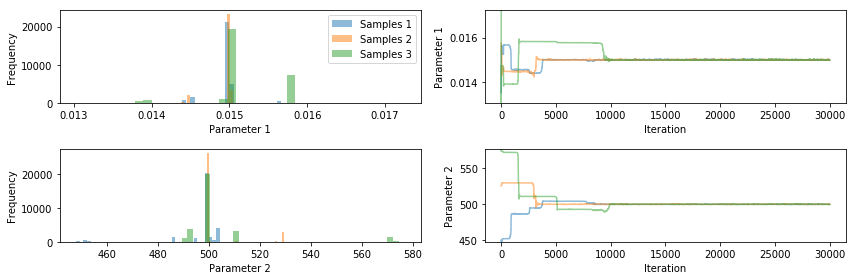

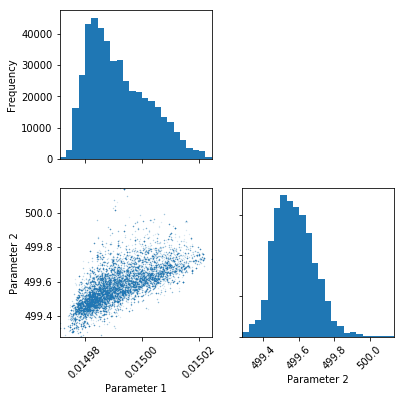

In [52]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05, #1.1
    np.array(true_parameters) * 1.15,
]
# Choose a covariance matrix for the proposal step
sigma0 = np.abs(true_parameters) * 5e-3

# Create mcmc routine
mcmc = pints.MCMCController(emu, 3, x0s, method=pints.EmulatedACMCMC, f=log_posterior)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
emulated_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(emulated_chains)

# Discard warm up
emulated_chains_thinned = emulated_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(emulated_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(emulated_chains_thinned[0])

# Show graphs
plt.show()

Running...
Using Metropolis random walk MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0.5       0         0          0:00.0
2     9      0.667     0.333     0          0:00.0
3     12     0.5       0.25      0.25       0:00.0
20    63     0.238     0.19      0.19       0:00.0
40    123    0.171     0.171     0.122      0:00.1
60    183    0.147541  0.131     0.0984     0:00.1
80    243    0.136     0.111     0.0988     0:00.1
100   303    0.119     0.109     0.0891     0:00.1
120   363    0.0992    0.0909    0.0826     0:00.2
140   423    0.0922    0.0851    0.0922     0:00.2
160   483    0.106     0.087     0.0807     0:00.2
180   543    0.116     0.0884    0.0718     0:00.3
200   603    0.104     0.0846    0.0647     0:00.3
220   663    0.095     0.0814    0.0633     0:00.3
240   723    0.104     0.0788    0.0622     0:00.3
260   783    0.0958    0.0805    0.0575

3100  9303   0.0516    0.0342    0.0555     0:04.3
3120  9363   0.0516    0.034     0.0551     0:04.4
3140  9423   0.0516    0.0337    0.0548     0:04.4
3160  9483   0.0512    0.0335    0.0544     0:04.4
3180  9543   0.0512    0.0333    0.0541     0:04.4
3200  9603   0.0515    0.0331    0.054      0:04.5
3220  9663   0.0512    0.0332    0.0543     0:04.5
3240  9723   0.0512    0.033     0.054      0:04.5
3260  9783   0.0512    0.0328    0.054      0:04.6
3280  9843   0.0509    0.0326    0.0536     0:04.6
3300  9903   0.0512    0.0324    0.0536     0:04.6
3320  9963   0.0512    0.0322    0.0536     0:04.6
3340  10023  0.0512    0.032     0.0536     0:04.7
3360  10083  0.0512    0.0318    0.0539     0:04.7
3380  10143  0.0509    0.0316    0.0538     0:04.7
3400  10203  0.0506    0.0318    0.0535     0:04.8
3420  10263  0.0503    0.0316    0.0538     0:04.8
3440  10323  0.0503    0.0314    0.0535     0:04.8
3460  10383  0.05      0.0312    0.0532     0:04.8
3480  10443  0.0497    0.031   

6480  19443  0.0406    0.0241    0.0468     0:09.1
6500  19503  0.0405    0.024     0.0466     0:09.1
6520  19563  0.0403    0.0244    0.0465     0:09.1
6540  19623  0.0402    0.0243    0.0463     0:09.1
6560  19683  0.0401    0.0242    0.0462     0:09.2
6580  19743  0.04      0.0242    0.046      0:09.2
6600  19803  0.04      0.0242    0.0461     0:09.2
6620  19863  0.0399    0.0242    0.0459     0:09.3
6640  19923  0.0398    0.0244    0.0458     0:09.3
6660  19983  0.0396    0.0246    0.0456     0:09.3
6680  20043  0.0395    0.0245    0.0455     0:09.3
6700  20103  0.0394    0.0245    0.0455     0:09.4
6720  20163  0.0393    0.0244    0.0454     0:09.4
6740  20223  0.0392    0.0243    0.0454     0:09.4
6760  20283  0.039     0.0243    0.0454     0:09.5
6780  20343  0.0389    0.0242    0.0454     0:09.5
6800  20403  0.039     0.0241    0.0453     0:09.5
6820  20463  0.0389    0.024     0.0453     0:09.6
6840  20523  0.0387    0.024     0.0453     0:09.6
6860  20583  0.0386    0.0239  

9780  29343  0.0305    0.0202    0.0384     0:13.8
9800  29403  0.0304    0.0202    0.0385     0:13.8
9820  29463  0.0303    0.0202    0.0384     0:13.8
9840  29523  0.0303    0.0201    0.0384     0:13.8
9860  29583  0.0303    0.0201    0.0384     0:13.9
9880  29643  0.0303    0.02      0.0384     0:13.9
9900  29703  0.0302    0.0201    0.0383     0:13.9
9920  29763  0.0301    0.0201    0.0382     0:13.9
9940  29823  0.0301    0.0201    0.0382     0:13.9
9960  29883  0.03      0.0203    0.0381     0:14.0
9980  29943  0.03      0.0202    0.0382     0:14.0
10000 30003  0.029997  0.0202    0.0381     0:14.0
10020 30063  0.03      0.0204    0.038      0:14.1
10040 30123  0.03      0.0203    0.038      0:14.1
10060 30183  0.0299    0.0203    0.038      0:14.1
10080 30243  0.03      0.0202    0.0379     0:14.1
10100 30303  0.0299    0.0202    0.0379     0:14.2
10120 30363  0.0298    0.0203    0.0379     0:14.2
10140 30423  0.0299    0.0202    0.038      0:14.2
10160 30483  0.0298    0.0203  

13040 39123  0.0252    0.0183    0.0325     0:18.7
13060 39183  0.0251    0.0183    0.0325     0:18.7
13080 39243  0.0252    0.0183    0.0325     0:18.8
13100 39303  0.0251    0.0182    0.0325     0:18.8
13120 39363  0.0251    0.0182    0.0325     0:18.8
13140 39423  0.025     0.0182    0.0326     0:18.8
13160 39483  0.0251    0.0182    0.0326     0:18.9
13180 39543  0.025     0.0181    0.0325     0:18.9
13200 39603  0.025     0.0183    0.0326     0:18.9
13220 39663  0.025     0.0182    0.0326     0:19.0
13240 39723  0.0251    0.0183    0.0326     0:19.0
13260 39783  0.025     0.018249  0.0325     0:19.0
13280 39843  0.025     0.0182    0.0325     0:19.1
13300 39903  0.025     0.0182    0.0324     0:19.1
13320 39963  0.025     0.0182    0.0324     0:19.1
13340 40023  0.025     0.0181    0.0323     0:19.2
13360 40083  0.0249    0.0181    0.0323     0:19.2
13380 40143  0.0249    0.0181    0.0322     0:19.2
13400 40203  0.0248    0.0181    0.0322     0:19.3
13420 40263  0.0248    0.018   

16400 49203  0.0228    0.0166    0.028      0:24.0
16420 49263  0.0228    0.0166    0.0281     0:24.1
16440 49323  0.0228    0.0165    0.028      0:24.1
16460 49383  0.0228    0.0165    0.028      0:24.2
16480 49443  0.0228    0.0165    0.028      0:24.2
16500 49503  0.0227    0.0165    0.0279     0:24.2
16520 49563  0.0227    0.0165    0.028      0:24.2
16540 49623  0.0227    0.0164    0.0279     0:24.3
16560 49683  0.0226    0.0164    0.0279     0:24.3
16580 49743  0.0226    0.0164    0.0279     0:24.3
16600 49803  0.022589  0.0164    0.0279     0:24.4
16620 49863  0.0226    0.0164    0.0279     0:24.4
16640 49923  0.0226    0.0164    0.0278     0:24.4
16660 49983  0.0226    0.0164    0.0278     0:24.5
16680 50043  0.0226    0.0164    0.0278     0:24.5
16700 50103  0.0226    0.0163    0.0278     0:24.5
16720 50163  0.0225    0.0163    0.0277     0:24.6
16740 50223  0.0225    0.016367  0.0278     0:24.6
16760 50283  0.0225    0.0164    0.0277     0:24.6
16780 50343  0.0225    0.0164  

19620 58863  0.0207    0.0158    0.0252     0:29.2
19640 58923  0.0208    0.0158    0.0252     0:29.2
19660 58983  0.0208    0.0158    0.0252     0:29.2
19680 59043  0.0208    0.0158    0.0252     0:29.3
19700 59103  0.0208    0.0157    0.0251     0:29.3
19720 59163  0.0207    0.0157    0.0251     0:29.4
19740 59223  0.0207    0.0158    0.0251     0:29.4
19760 59283  0.0207    0.0157    0.025      0:29.4
19780 59343  0.0207    0.0158    0.025      0:29.5
19800 59403  0.0207    0.0158    0.025      0:29.5
19820 59463  0.0207    0.0157    0.025      0:29.5
19840 59523  0.0207    0.0158    0.0249     0:29.6
19860 59583  0.0207    0.0158    0.0249     0:29.6
19880 59643  0.0207    0.0157    0.0249     0:29.6
19900 59703  0.0207    0.0158    0.0249     0:29.7
19920 59763  0.0207    0.0158    0.0248     0:29.7
19940 59823  0.0207    0.0158    0.0248     0:29.7
19960 59883  0.0207    0.0158    0.0248     0:29.8
19980 59943  0.0207    0.0158    0.0248     0:29.8
20000 60003  0.0206    0.0158  

22920 68763  0.0194    0.0155    0.023      0:34.6
22940 68823  0.0194    0.0155    0.023      0:34.6
22960 68883  0.0194    0.0155    0.023      0:34.6
22980 68943  0.0194    0.0155    0.023      0:34.7
23000 69003  0.0193    0.0156    0.023      0:34.7
23020 69063  0.0193    0.0156    0.0229     0:34.7
23040 69123  0.0194    0.0155    0.0229     0:34.8
23060 69183  0.0193    0.0155    0.0229     0:34.8
23080 69243  0.0193    0.0155    0.0229     0:34.8
23100 69303  0.0193    0.0155    0.0229     0:34.9
23120 69363  0.0193    0.0155    0.0229     0:34.9
23140 69423  0.0193    0.0155    0.0229     0:34.9
23160 69483  0.0193    0.0155    0.0229     0:35.0
23180 69543  0.0193    0.0154    0.0229     0:35.0
23200 69603  0.0193    0.0154    0.0229     0:35.0
23220 69663  0.0192    0.0154    0.0229     0:35.1
23240 69723  0.0192    0.0154    0.0228     0:35.1
23260 69783  0.0192    0.0154    0.0228     0:35.1
23280 69843  0.0192    0.0154    0.0228     0:35.2
23300 69903  0.0192    0.0154  

26140 78423  0.0182    0.0153    0.0217     0:39.6
26160 78483  0.0182    0.0153    0.0216     0:39.6
26180 78543  0.0182    0.0153    0.0216     0:39.6
26200 78603  0.0182    0.0153    0.0216     0:39.7
26220 78663  0.0182    0.0153    0.0216     0:39.7
26240 78723  0.0182    0.0153    0.0216     0:39.7
26260 78783  0.0182    0.0153    0.0216     0:39.8
26280 78843  0.0182    0.0154    0.0215     0:39.8
26300 78903  0.0182    0.0154    0.0215     0:39.8
26320 78963  0.0182    0.0153    0.0215     0:39.9
26340 79023  0.0182    0.0154    0.0215     0:39.9
26360 79083  0.0182    0.0154    0.0215     0:39.9
26380 79143  0.0182    0.0154    0.0215     0:39.9
26400 79203  0.0182    0.0154    0.0215     0:40.0
26420 79263  0.0182    0.0154    0.0215     0:40.0
26440 79323  0.0182    0.0154    0.0215     0:40.0
26460 79383  0.0181    0.0153    0.0215     0:40.1
26480 79443  0.0182    0.0153    0.0215     0:40.1
26500 79503  0.0182    0.0153    0.0215     0:40.1
26520 79563  0.0182    0.0153  

29480 88443  0.0178    0.015     0.0204     0:44.3
29500 88503  0.0178    0.0149    0.0204     0:44.4
29520 88563  0.0178    0.0149    0.0204     0:44.4
29540 88623  0.0178    0.0149    0.0203     0:44.4
29560 88683  0.0178    0.015     0.0204     0:44.4
29580 88743  0.0178    0.0149    0.0204     0:44.5
29600 88803  0.0178    0.0149    0.0204     0:44.5
29620 88863  0.0178    0.0149    0.0204     0:44.5
29640 88923  0.0177    0.0149    0.0204     0:44.5
29660 88983  0.0177    0.015     0.0204     0:44.6
29680 89043  0.0177    0.015     0.0204     0:44.6
29700 89103  0.0177    0.0149    0.0204     0:44.6
29720 89163  0.0177    0.0149    0.0204     0:44.7
29740 89223  0.0177    0.0149    0.0204     0:44.7
29760 89283  0.0177    0.0149    0.0204     0:44.7
29780 89343  0.0177    0.0149    0.0204     0:44.8
29800 89403  0.0177    0.0149    0.0204     0:44.8
29820 89463  0.0177    0.0149    0.0204     0:44.8
29840 89523  0.0177    0.0149    0.0204     0:44.9
29860 89583  0.0176    0.0149  

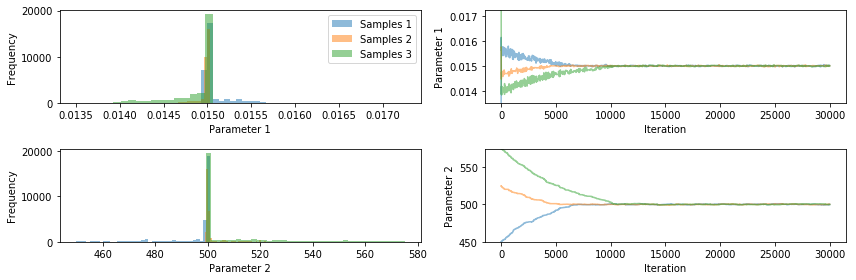

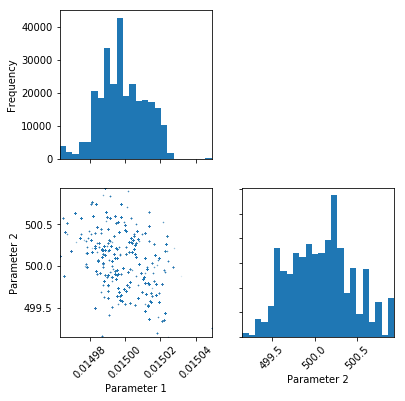

In [46]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05, #1.1
    np.array(true_parameters) * 1.15,
]
# Choose a covariance matrix for the proposal step
sigma0 = np.abs(true_parameters) * 1e-4

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, x0s, sigma0=sigma0, method=pints.MetropolisRandomWalkMCMC)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
metropolis_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(metropolis_chains)

# Discard warm up
metropolis_chains_thinned = metropolis_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(metropolis_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(metropolis_chains_thinned[0])

# Show graphs
plt.show()

In [47]:
metropolis_chains.shape

(3, 30000, 2)

In [48]:
metropolis_chains[0][:10]

array([[1.35000000e-02, 4.50000000e+02],
       [1.48070366e-02, 4.50139351e+02],
       [1.61433805e-02, 4.50201185e+02],
       [1.61433805e-02, 4.50201185e+02],
       [1.61433805e-02, 4.50201185e+02],
       [1.61433805e-02, 4.50201185e+02],
       [1.59149025e-02, 4.49990111e+02],
       [1.59149025e-02, 4.49990111e+02],
       [1.59149025e-02, 4.49990111e+02],
       [1.59149025e-02, 4.49990111e+02]])

In [49]:
emulated_chains[0][:10]

array([[1.35e-02, 4.50e+02],
       [1.35e-02, 4.50e+02],
       [1.35e-02, 4.50e+02],
       [1.35e-02, 4.50e+02],
       [1.35e-02, 4.50e+02],
       [1.35e-02, 4.50e+02],
       [1.35e-02, 4.50e+02],
       [1.35e-02, 4.50e+02],
       [1.35e-02, 4.50e+02],
       [1.35e-02, 4.50e+02]])

In [50]:
class RescaledModel(pints.ForwardModel):
    def __init__(self):
        self.base_model = pints.toy.LogisticModel()
    
    def simulate(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulate([r, k], times)
    
    def simulateS1(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulateS1([r, k], times)
    
    def n_parameters(self):
        # Return the dimension of the parameter vector
        return 2

model = pints.toy.LogisticModel()

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

# Perform an optimization
x0 = [0.01, 450]
opt = pints.OptimisationController(
    score,
    x0,
    method=pints.GradientDescent
)

opt.optimiser().set_learning_rate(1e-10)
opt.set_max_iterations(100)

found_parameters, found_value = opt.run()

# Rescale parameters
found_parameters = list(found_parameters)

# Show score of true solution
print('Score at true solution: ')
print(score(true_parameters))

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(true_parameters[k]))

Minimising error measure
Using Gradient descent
Running in sequential mode.
Iter. Eval. Best      Time m:s
0     1      7654193    0:00.0
1     2      7654193    0:00.0
2     3      7654193    0:00.0
3     4      7654193    0:00.0
20    21     7654193    0:00.0
40    41     7654193    0:00.0
60    61     7654193    0:00.0
80    81     7654193    0:00.0
100   100    7654193    0:00.0
Halting: Maximum number of iterations (100) reached.
Score at true solution: 
8961.206274430133
Found solution:          True parameters:
 1.00000000000000002e-02     1.49999999999999994e-02
 4.50000000000000000e+02     5.00000000000000000e+02


In [51]:
class RescaledModel(pints.ForwardModel):
    def __init__(self):
        self.base_model = pints.toy.LogisticModel()
    
    def simulate(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulate([r, k], times)
    
    def simulateS1(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulateS1([r, k], times)
    
    def n_parameters(self):
        # Return the dimension of the parameter vector
        return 2

model = RescaledModel()

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Select a score function
score = pints.SumOfSquaresError(problem)

# Perform an optimization
x0 = [1, 1]
opt = pints.OptimisationController(
    score,
    x0,
    method=pints.GradientDescent
)

opt.optimiser().set_learning_rate(1e-10)
opt.set_max_iterations(100)

found_parameters, found_value = opt.run()

# Rescale parameters
found_parameters = list(found_parameters)
found_parameters[0] = found_parameters[0] / 50
found_parameters[1] = found_parameters[1] * 500

# Show score of true solution
print('Score at true solution: ')
print(score(true_parameters))

# Compare parameters with original
print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(true_parameters[k]))

Minimising error measure
Using Gradient descent
Running in sequential mode.
Iter. Eval. Best      Time m:s
0     1      2413373    0:00.0
1     2      1383060    0:00.0
2     3      632654.2   0:00.0
3     4      219773.9   0:00.0
20    21     8961.039   0:00.0
40    41     8961.039   0:00.0
60    61     8961.038   0:00.0
80    81     8961.038   0:00.0
100   100    8961.037   0:00.0
Halting: Maximum number of iterations (100) reached.
Score at true solution: 
55933970.04719109
Found solution:          True parameters:
 1.49988272333894321e-02     1.49999999999999994e-02
 4.99997314647930750e+02     5.00000000000000000e+02
